In [1]:
import warnings
import os
import sys
# try to import peal and if not installed, add the parent directory to the path
try:
    import peal

except ImportError:
    # if peal not installed, but project downloaded locally
    module_path = os.path.abspath(os.path.join('..'))
    if module_path not in sys.path:
        sys.path.append(module_path)

# import basic libraries needed for sure and set the device depending on whether cuda is available or not
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'

warnings.filterwarnings('ignore')

In [2]:
from peal.global_utils import load_yaml_config
from peal.data.datasets import SymbolicDataset

unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')

dataset = SymbolicDataset(data_dir=unpoisened_dataset_config.dataset_path, mode='train', config=unpoisened_dataset_config)
train_size = int(0.95 * len(dataset))  # 80% for training
test_size = len(dataset) - train_size 
train_set, test_set = torch.utils.data.random_split(dataset, [train_size, test_size])

input_idx = [idx for idx, element in enumerate(dataset.attributes) if element not in ['Confounder', 'Target']]
target_idx = [idx for idx, element in enumerate(dataset.attributes) if element == 'Target']

In [58]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm, trange
from typing import Tuple
import logging
from torch.utils.data import DataLoader
import math
from peal.generators.interfaces import EditCapableGenerator
%matplotlib inline

logging.getLogger().setLevel(logging.INFO)

class VAE(nn.Module):
    def __init__(self, input_dim: int, encoder_dims: list, decoder_dims: list, latent_dim: int):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential()
        for i, dim in enumerate(encoder_dims):
            self.encoder.add_module(f'layer_{i + 1}', nn.Sequential(nn.LazyLinear(dim), nn.SiLU()))
        self.encoder.add_module('norm_encoder', nn.LayerNorm(dim))

        self.latent_mean = nn.Sequential(nn.LazyLinear(latent_dim))
        self.latent_logvar = nn.Sequential(nn.LazyLinear(latent_dim))

        self.decoder = nn.Sequential()
        for i, dim in enumerate(decoder_dims):
            self.decoder.add_module(f'layer_{i + 1}', nn.Sequential(nn.LazyLinear(dim), nn.SiLU()))
        self.decoder.add_module('norm_decoder', nn.LayerNorm(dim))
        self.decoder.add_module(f'to_original', nn.Sequential(nn.LazyLinear(input_dim)))

    def reparameterize(self, mean, logvar):
        if self.training:
            z = mean + torch.exp(logvar * 0.5) * torch.randn_like(logvar)
        else:
            z = mean
        return z

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.latent_mean(x), self.latent_logvar(x)
        return mean, logvar

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def sample(self, num_samples):
        eps = torch.randn([num_samples, self.latent_dim])
        return self.decode(eps).detach()

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar


class CircleVAEAdaptor(EditCapableGenerator):
    def __init__(self, config, dataset, model_dir=None):
        super(CircleVAEAdaptor, self).__init__()
        self.config = config
        self.dataset = dataset

        if not model_dir is None:
            self.model_dir = model_dir
        else:
            self.model_dir = config['base_path']

        #self.input_dim = config.input_dim
        #self.encoder_dims = config.encoder_dims
        #self.decoder_dims = config.decoder_dims
        #self.latent_dim = config.latent_dim
        
        self.input_dim = config['input_dim']
        self.encoder_dims = config['encoder_dims']
        self.decoder_dims = config['decoder_dims']
        self.latent_dim = config['latent_dim']

        self.train_and_load_vae(model_name=config['model_name'])

        self.input_idx = [
            idx
            for idx, element in enumerate(self.dataset.attributes)
            if element not in ["Confounder", "Target"]
        ]
        self.target_idx = [
            idx
            for idx, element in enumerate(self.dataset.attributes)
            if element == "Target"
        ]

    def train_and_load_vae(self, model_name='vae.pt', mode=None):
        self.model_path = os.path.join(self.model_dir, model_name)
        model = VAE(input_dim=self.input_dim, encoder_dims=self.encoder_dims, decoder_dims=self.decoder_dims,
                    latent_dim=self.latent_dim)

        if model_name in os.listdir(self.model_dir) and not mode == "train":
            model.load_state_dict(torch.load(self.model_path))
            logging.info(f'Model found with path {self.model_path}')
        elif model_name not in os.listdir(self.model_dir) and mode != 'train':
            logging.info('Model not found. Please run train_and_load_vae method and set its argument mode="train" ')
        else:
            logging.info(
                f'Training model with path {self.model_path}'
            )

        def VAELoss(x, x_hat, mean, logvar, beta=self.config['beta']):
            kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean ** 2 - logvar.exp(), dim=1), dim=0)
            reconstruction_loss = F.mse_loss(x, x_hat)
            return reconstruction_loss + beta * kl_loss

        def train(model, data_loader, epochs):
            model.train()
            optimizer = optim.Adam(model.parameters(), lr=1e-3)

            for epoch in tqdm(range(epochs)):
                total_loss = 0.0
                for x, y in data_loader:
                    x = x
                    optimizer.zero_grad()
                    x_hat, mean, logvar = model(x[:, self.input_idx])
                    loss = VAELoss(x[:, self.input_idx], x_hat=x_hat, mean=mean, logvar=logvar)
                    total_loss += loss.item()
                    loss.backward()
                    optimizer.step()

                print(f'Epoch: {epoch}, Loss: {loss}')

            return x, x_hat

        if mode == 'train':
            model.train()
            dataloader = DataLoader(self.dataset, batch_size=self.config['batch_size'], shuffle=True)
            train(model=model, data_loader=dataloader, epochs=self.config['num_epochs'])
            torch.save(model.state_dict(), self.model_path)

        self.model = model

    def sample_x(self, batch_size=1):
        return self.model.sample(num_samples=batch_size).detach()

    def DIVE(self, clean_batch, target_classes, model, classifier):

        classifier.eval()

        lasso_weight = self.config['lasso_weight']
        reconstruction_weight = self.config['reconstruction_weight']

        batch_size, _ = clean_batch.size()
        latent_dim = self.latent_dim

        mean, logvar = self.model.encode(clean_batch)
        z = model.reparameterize(mean, logvar).detach()  # no grads required for latents

        epsilon = torch.randn_like(z, requires_grad=True)
        epsilon.data *= 0.001
        optimizer = torch.optim.Adam([epsilon], lr=self.config['lr_counterfactual'], weight_decay=0)
        
        z_perturbed = z + epsilon 
        list_z = []
        list_counterfactuals = []
        list_z.append(z[0])
        list_counterfactuals.append(clean_batch[0])
        for it in range(self.config['num_iterations']):
            optimizer.zero_grad()

            decoded = model.decode(z_perturbed)

            classifier_criterion = lambda x: F.cross_entropy(classifier(x), target_classes)
            loss_attack = classifier_criterion(decoded)
            recon_regularizer = reconstruction_weight * torch.abs((clean_batch - decoded).mean(dim=-1)).sum()
            lasso_regularizer = lasso_weight * (torch.abs(z_perturbed - z)).sum()
            regularizer = recon_regularizer + lasso_regularizer

            loss = loss_attack + regularizer

            loss.backward()

            optimizer.step()
            
            z_perturbed = z + epsilon
            x = model.decode(z_perturbed).detach()
            list_z.append(z_perturbed.detach()[0])
            list_counterfactuals.append(x[0])

        return clean_batch, x, torch.stack(list_z), torch.stack(list_counterfactuals)
    
    def discard_counterfactuals(self, counterfactuals, classifier, target_classes, target_confidence, minimal_counterfactuals):
        for i in range(len(counterfactuals)):
            
            new_counterfactuals_confidence = classifier(counterfactuals[i]).softmax(dim=-1)[:, target_classes[i]]
            
            new_confidence_satisfied = new_counterfactuals_confidence > target_confidence
            
            new_confidence_satisfied_indices = torch.nonzero(new_counterfactuals_confidence > target_confidence)
            
            current_confidence_satisfied = classifier(minimal_counterfactuals[i:i+1]).softmax(dim=-1)[0][target_classes[i]].item() > target_confidence
             
            

    def edit(
            self,
            x_in: torch.Tensor,
            target_confidence_goal: float,
            target_classes: torch.Tensor,
            classifier: torch.nn.Module,
            **kwargs,
    ) -> Tuple[
        list[torch.Tensor], list[torch.Tensor], list[torch.Tensor], list[torch.Tensor]
    ]:
        """
        Edit a batch of samples to achieve a target confidence goal.
        Args:
            x_in: Batch of samples to edit.
            target_confidence_goal: Target confidence goal.
            target_classes: Target classes for each sample in the batch.
            classifier: Classifier to use for confidence estimation.
            **kwargs: Additional keyword arguments.
        Returns:
            Tuple of (edited samples, confidence estimates, number of iterations, number of queries).
        """

        list_counterfactuals = torch.zeros_like(x_in)
        y_target_end_confidence = torch.zeros([x_in.shape[0]])
        counterfactuals = x_in
        for i in range(len(x_in)):
            #while True:
            _, counterfactual, _ ,_ = self.DIVE(x_in[i:i + 1], target_classes[i:i + 1], self.model, classifier)
            current_confidence = classifier(counterfactual).softmax(dim=-1)[0][target_classes[i].item()].item()
                #if current_confidence > target_confidence_goal:
                #    break
            y_target_end_confidence[i] = current_confidence
            list_counterfactuals[i] = counterfactual

        diff_latent = x_in - list_counterfactuals

        x_list = [row_tensor for row_tensor in x_in]

        return list(list_counterfactuals), diff_latent, y_target_end_confidence, x_list


In [59]:
adaptor_config = load_yaml_config('<PEAL_BASE>/configs/adaptors/circle_vae.yaml')

In [60]:
adaptor = CircleVAEAdaptor(config=adaptor_config.generator, dataset=train_set.dataset, model_dir=None)

INFO:root:Model found with path peal_runs/artificial_circle_vae_generator/vae.pt


In [61]:
adaptor.train_and_load_vae(model_name='vae_beta_0.07.pt')#, mode='train')

INFO:root:Model found with path peal_runs/artificial_circle_vae_generator/vae_beta_0.07.pt


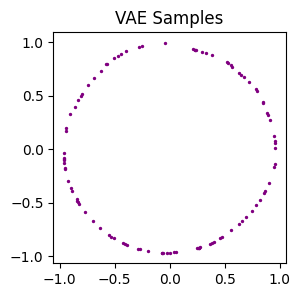

In [49]:
samples = adaptor.sample_x(batch_size=100)
plt.figure(figsize=(3,3))
plt.scatter(samples[:,0], samples[:,1], s=2, color='purple')
plt.title('VAE Samples')
plt.show()

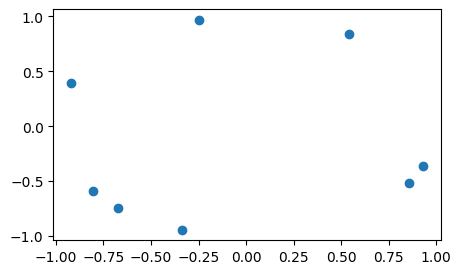

In [8]:
test_dl = DataLoader(test_set, batch_size=8, shuffle=True)
sample, _ = next(iter(test_dl))
plt.figure(figsize=(5,3))
plt.scatter(sample[:,0], sample[:, 1])
plt.show()

In [29]:
def circle_distance(samples):
    radius = 1
    return (((samples.pow(2)).sum(dim=-1) - radius).pow(2)).mean()

def angle_cdf(samples):
    scores = abs(samples[:, 1] / samples[:, 0])

    first_quad_mask = (samples[:, 0] > 0) & (samples[:, 1] > 0)
    second_quad_mask = (samples[:, 0] < 0) & (samples[:, 1] > 0)
    third_quad_mask = (samples[:, 0] < 0) & (samples[:, 1] < 0)
    fourth_quad_mask = (samples[:, 0] > 0) & (samples[:, 1] < 0)
    theta_1 = torch.atan(scores) * first_quad_mask
    theta_1 = theta_1[theta_1 != 0]
    theta_2 = (torch.pi - torch.atan(scores)) * second_quad_mask
    theta_2 = theta_2[theta_2 != 0]
    theta_3 = (torch.pi + torch.atan(scores)) * third_quad_mask
    theta_3 = theta_3[theta_3 != 0]
    theta_4 = (2 * torch.pi - torch.atan(scores)) * fourth_quad_mask
    theta_4 = theta_4[theta_4 != 0]
    thetas, indices = torch.cat([theta_1, theta_2, theta_3, theta_4]).sort(dim=-1)

    return thetas

def circle_ks(samples):
    dist = torch.distributions.uniform.Uniform(0, 2*torch.pi)
    sample_thetas = angle_cdf(samples)
    
    ecdf = torch.arange(len(samples)) / len(samples)
    true_cdf = dist.cdf(sample_thetas)
    return torch.max(torch.abs(dist.cdf(sample_thetas) - ecdf))

sizes = np.linspace(5, 30000, 50, dtype=np.int)
distances_bvae = []
ks_stats_bvae = []
for size in sizes:
    dist = 0.0
    ks = 0.0
    for it in range(5):
        samples = adaptor.sample_x(batch_size=size)
        dist += circle_distance(samples)
        ks += circle_ks(samples)
    distances_bvae.append(dist/5)
    ks_stats_bvae.append(ks/5)

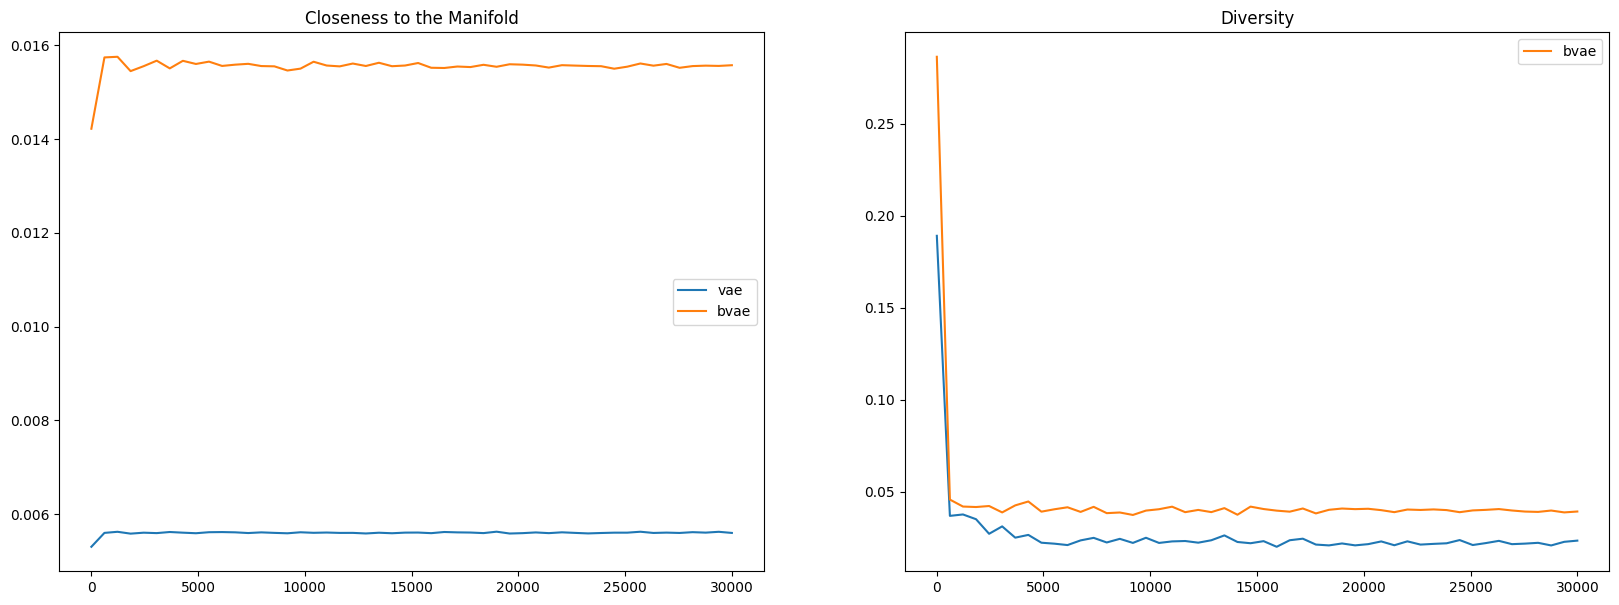

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(20, 7)) 

axs[0].plot(np.array(sizes), distances, label='vae')
axs[0].plot(np.array(sizes), distances_bvae, label='bvae')
axs[0].legend()
axs[0].set_title(f'Closeness to the Manifold')

axs[1].plot(np.array(sizes), ks_stats)
axs[1].plot(np.array(sizes), ks_stats_bvae, label='bvae')
axs[1].set_title(f'Diversity')
plt.legend()


In [62]:
student = torch.load('peal_runs/artificial_circle_poisened_classifier/model.cpl')
teacher = torch.load('peal_runs/artificial_circle_unpoisened_classifier/model.cpl')
list_counterfactuals, diff_latent, y_target_end_confidence, x_list = adaptor.edit(x_in=sample[:,:2], target_confidence_goal=0.9, target_classes=student(sample[:,:2]).argmin(dim=-1), classifier=student)

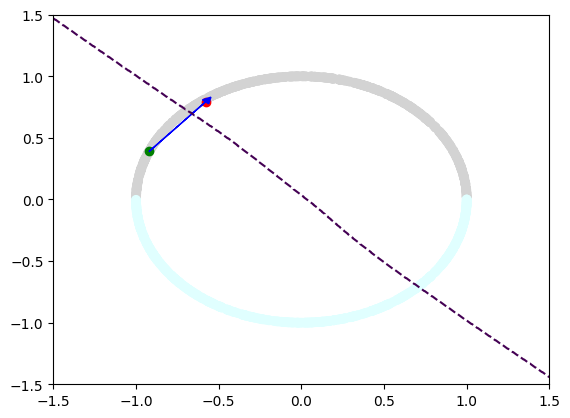

In [63]:
data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
for idx, key in enumerate(dataset.data):
    data[idx] = dataset.data[key]
plt.scatter(data[:,0], data[:,1], c=np.where(data[:,3] == 0, 'lightcyan', 'lightgray'))
for i, point in enumerate(list_counterfactuals):
    plt.scatter(x_list[i][0], x_list[i][1], color='green', label='start')
    plt.scatter(point[0], point[1], color='red', label='end')
    plt.arrow(
        x_list[i][0], x_list[i][1], # plot the original point plus arrow until (j+granularity)th point
        point[0] - x_list[i][0], 
        point[1] - x_list[i][1],
        head_width=0.05, head_length=0.05, fc='blue', ec='blue',

    )
    break
input_idx = [0,1]
xx1, xx2 = np.meshgrid(*[np.linspace(float(data[:, [input_idx]].min()-0.5),float(data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
z = student(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
plt.contour(xx1, xx2, z, levels=[0],linestyles='dashed', label='decision boundary')
#plt.legend()
plt.show()

In [64]:
original, counterfactuals, latents, list_counterfactuals = adaptor.DIVE(clean_batch=sample[4:5,:2], target_classes=student(sample[4:5,:2]).argmin(dim=-1), model=adaptor.model, classifier=student)

In [65]:
import matplotlib.pyplot as plt
import numpy as np

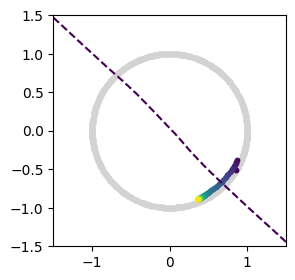

In [66]:
cmap = plt.get_cmap('viridis')
plt.figure(figsize=(3,3))

plt.scatter(data[:,0], data[:,1], c=np.where(data[:,3] == 0, 'lightcyan', 'lightgray')[0], s=10)
input_idx = [0,1]
xx1, xx2 = np.meshgrid(*[np.linspace(float(data[:, [input_idx]].min()-0.5),float(data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
plt.contour(xx1, xx2, z, levels=[0],linestyles='dashed', label='decision boundary')

for i in range(0, len(list_counterfactuals)):
    color = cmap(i / len(list_counterfactuals))  # Gradual color change
    plt.scatter(list_counterfactuals[i][0], list_counterfactuals[i][1], c=color, s=10)

In [ ]:
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.scatter(counterfactuals[:,0], counterfactuals[:,1], color='red')
plt.scatter(clean_batch[:, 0], clean_batch[:, 1], color='green')
plt.show()

In [352]:
class VAE(nn.Module):
    def __init__(self, input_dim: int, encoder_dims: list, decoder_dims: list, latent_dim: int):
        super(VAE, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        self.encoder = nn.Sequential()
        for i, dim in enumerate(encoder_dims):
            self.encoder.add_module(f'layer_{i+1}', nn.Sequential(nn.LazyLinear(dim), nn.SiLU()))
        self.encoder.add_module('norm_encoder', nn.LayerNorm(dim))

        self.latent_mean = nn.Sequential(nn.LazyLinear(latent_dim))
        self.latent_logvar = nn.Sequential(nn.LazyLinear(latent_dim))

        self.decoder = nn.Sequential()
        for i, dim in enumerate(decoder_dims):
            self.decoder.add_module(f'layer_{i+1}', nn.Sequential(nn.LazyLinear(dim), nn.SiLU()))
        self.decoder.add_module('norm_decoder', nn.LayerNorm(dim))
        self.decoder.add_module(f'to_original', nn.Sequential(nn.LazyLinear(input_dim)))

    def sampling_dist(self, mean, var):
        return torch.distributions.Normal(loc=mean, scale=var)

    def reparameterize(self, mean, logvar):
        if self.training:
            z = mean + torch.exp(logvar * 0.5) * torch.randn_like(logvar)
        else:
            z = mean
        return z

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.latent_mean(x), self.latent_logvar(x)
        return mean, logvar

    def decode(self, z):
        x_hat = self.decoder(z)
        return x_hat

    def sample(self, num_samples):
        eps = torch.randn([num_samples, self.latent_dim])
        return self.decode(eps).detach()

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar
    

def VAELoss(x, x_hat, mean, logvar, beta=0.1):
    kl_loss = torch.mean(-0.5 * torch.sum(1 + logvar - mean**2 - logvar.exp(), dim=1), dim=0)
    reconstruction_loss = F.mse_loss(x, x_hat)
    return reconstruction_loss + beta * kl_loss


def reconstructed_samples(x_recon, x):
    x_recon = x_recon.detach()
    plt.figure(figsize=(2, 2))
    plt.scatter(x_recon[:, 0], x_recon[:, 1])
    plt.scatter(x[:, 0], x[:, 1])
    plt.show()

def plot_latent(model, data_loader, epoch):
    for i, (x, y) in enumerate(data_loader):
        z, _ = model(x)
        z = z.to('cpu').detach().numpy()
        plt.scatter(z, c=y)

def train(model, data_loader, epochs):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    for epoch in tqdm(range(epochs)):
        total_loss = 0.0
        for x, y in data_loader:
            x = x
            optimizer.zero_grad()
            x_hat, mean, logvar = model(x[:, input_idx])
            loss = VAELoss(x[:, input_idx], x_hat=x_hat, mean=mean, logvar=logvar)
            total_loss += loss.item()
            loss.backward()
            optimizer.step()
        
        print(f'Epoch: {epoch}, Loss: {loss}')
        
        if epoch % 200 == 0:
            reconstructed_samples(x_recon=x_hat, x=x)
    
    return x, x_hat



In [93]:
model = VAE(input_dim=2, encoder_dims=[256, 256, 256], decoder_dims=[256, 256, 256], latent_dim=1)

In [94]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

  0%|                                                                                          | 0/5000 [00:00<?, ?it/s]

Epoch: 0, Loss: 1.1101207733154297


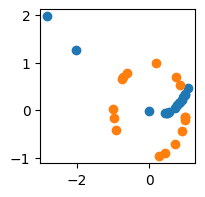

  0%|                                                                                  | 3/5000 [00:00<05:33, 14.98it/s]

Epoch: 1, Loss: 0.5300076007843018
Epoch: 2, Loss: 0.3718779385089874


  0%|                                                                                  | 6/5000 [00:00<04:25, 18.84it/s]

Epoch: 3, Loss: 0.3641032576560974
Epoch: 4, Loss: 0.33109092712402344
Epoch: 5, Loss: 0.5307974815368652
Epoch: 6, Loss: 0.29816752672195435
Epoch: 7, Loss: 0.3586491644382477


  0%|▏                                                                                | 12/5000 [00:00<03:43, 22.30it/s]

Epoch: 8, Loss: 0.25566938519477844
Epoch: 9, Loss: 0.33815354108810425
Epoch: 10, Loss: 0.29481014609336853
Epoch: 11, Loss: 0.2672855854034424
Epoch: 12, Loss: 0.3142499327659607


  0%|▏                                                                                | 15/5000 [00:00<03:47, 21.94it/s]

Epoch: 13, Loss: 0.25494086742401123
Epoch: 14, Loss: 0.3804413676261902
Epoch: 15, Loss: 0.1763685941696167
Epoch: 16, Loss: 0.17920458316802979


  0%|▎                                                                                | 18/5000 [00:00<03:34, 23.25it/s]

Epoch: 17, Loss: 0.15136244893074036
Epoch: 18, Loss: 0.2009781002998352


  0%|▎                                                                                | 21/5000 [00:00<03:31, 23.60it/s]

Epoch: 19, Loss: 0.3361905813217163
Epoch: 20, Loss: 0.12950177490711212
Epoch: 21, Loss: 0.19254836440086365


  0%|▍                                                                                | 24/5000 [00:01<03:38, 22.81it/s]

Epoch: 22, Loss: 0.25579720735549927
Epoch: 23, Loss: 0.1587262749671936


  1%|▍                                                                                | 27/5000 [00:01<03:48, 21.74it/s]

Epoch: 24, Loss: 0.32430049777030945
Epoch: 25, Loss: 0.18977800011634827
Epoch: 26, Loss: 0.18268118798732758
Epoch: 27, Loss: 0.28968343138694763
Epoch: 28, Loss: 0.13873974978923798


  1%|▌                                                                                | 33/5000 [00:01<03:34, 23.19it/s]

Epoch: 29, Loss: 0.1543988287448883
Epoch: 30, Loss: 0.1816762387752533
Epoch: 31, Loss: 0.13372232019901276
Epoch: 32, Loss: 0.1277393251657486
Epoch: 33, Loss: 0.26215988397598267


  1%|▋                                                                                | 39/5000 [00:01<03:24, 24.29it/s]

Epoch: 34, Loss: 0.14919207990169525
Epoch: 35, Loss: 0.16843287646770477
Epoch: 36, Loss: 0.15225990116596222
Epoch: 37, Loss: 0.15065035223960876
Epoch: 38, Loss: 0.13123835623264313
Epoch: 39, Loss: 0.12329171597957611


  1%|▋                                                                                | 42/5000 [00:01<03:28, 23.79it/s]

Epoch: 40, Loss: 0.13850075006484985
Epoch: 41, Loss: 0.11987800151109695
Epoch: 42, Loss: 0.2233094573020935
Epoch: 43, Loss: 0.13041642308235168
Epoch: 44, Loss: 0.19490842521190643


  1%|▊                                                                                | 51/5000 [00:02<03:14, 25.51it/s]

Epoch: 45, Loss: 0.1547335833311081
Epoch: 46, Loss: 0.14367897808551788
Epoch: 47, Loss: 0.16769802570343018
Epoch: 48, Loss: 0.18295365571975708
Epoch: 49, Loss: 0.14882656931877136
Epoch: 50, Loss: 0.1617693305015564


  1%|▉                                                                                | 57/5000 [00:02<03:15, 25.27it/s]

Epoch: 51, Loss: 0.12161372601985931
Epoch: 52, Loss: 0.1251961588859558
Epoch: 53, Loss: 0.12375292181968689
Epoch: 54, Loss: 0.13525569438934326
Epoch: 55, Loss: 0.11069339513778687
Epoch: 56, Loss: 0.1269385814666748


  1%|█                                                                                | 63/5000 [00:02<03:14, 25.32it/s]

Epoch: 57, Loss: 0.12305660545825958
Epoch: 58, Loss: 0.15238747000694275
Epoch: 59, Loss: 0.15774692595005035
Epoch: 60, Loss: 0.13794013857841492
Epoch: 61, Loss: 0.12477108091115952
Epoch: 62, Loss: 0.1313195824623108


  1%|█                                                                                | 69/5000 [00:02<03:14, 25.30it/s]

Epoch: 63, Loss: 0.14202150702476501
Epoch: 64, Loss: 0.1270715445280075
Epoch: 65, Loss: 0.12038016319274902
Epoch: 66, Loss: 0.13204574584960938
Epoch: 67, Loss: 0.11352766305208206
Epoch: 68, Loss: 0.15761689841747284


  1%|█▏                                                                               | 72/5000 [00:03<03:18, 24.80it/s]

Epoch: 69, Loss: 0.15641795098781586
Epoch: 70, Loss: 0.1444590985774994
Epoch: 71, Loss: 0.12432409822940826
Epoch: 72, Loss: 0.12222524732351303
Epoch: 73, Loss: 0.1392289400100708
Epoch: 74, Loss: 0.10718221962451935


  2%|█▎                                                                               | 81/5000 [00:03<03:13, 25.46it/s]

Epoch: 75, Loss: 0.12354032695293427
Epoch: 76, Loss: 0.1316104531288147
Epoch: 77, Loss: 0.12267577648162842
Epoch: 78, Loss: 0.2687901258468628
Epoch: 79, Loss: 0.11188600957393646
Epoch: 80, Loss: 0.11644970625638962


  2%|█▍                                                                               | 87/5000 [00:03<03:13, 25.41it/s]

Epoch: 81, Loss: 0.128678560256958
Epoch: 82, Loss: 0.3246500492095947
Epoch: 83, Loss: 0.1545499861240387
Epoch: 84, Loss: 0.15609194338321686
Epoch: 85, Loss: 0.13583585619926453
Epoch: 86, Loss: 0.11951342225074768


  2%|█▌                                                                               | 93/5000 [00:03<03:12, 25.52it/s]

Epoch: 87, Loss: 0.13177187740802765
Epoch: 88, Loss: 0.11893292516469955
Epoch: 89, Loss: 0.14237703382968903
Epoch: 90, Loss: 0.13365063071250916
Epoch: 91, Loss: 0.11259147524833679
Epoch: 92, Loss: 0.2557835876941681


  2%|█▌                                                                               | 99/5000 [00:04<03:08, 25.95it/s]

Epoch: 93, Loss: 0.13772569596767426
Epoch: 94, Loss: 0.1342686265707016
Epoch: 95, Loss: 0.14192438125610352
Epoch: 96, Loss: 0.12057466804981232
Epoch: 97, Loss: 0.16435140371322632
Epoch: 98, Loss: 0.12493416666984558


  2%|█▋                                                                              | 105/5000 [00:04<03:09, 25.82it/s]

Epoch: 99, Loss: 0.1256273090839386
Epoch: 100, Loss: 0.15436945855617523
Epoch: 101, Loss: 0.2742448151111603
Epoch: 102, Loss: 0.1276707500219345
Epoch: 103, Loss: 0.12675490975379944
Epoch: 104, Loss: 0.15805640816688538


  2%|█▊                                                                              | 111/5000 [00:04<03:06, 26.22it/s]

Epoch: 105, Loss: 0.1169600859284401
Epoch: 106, Loss: 0.1290826052427292
Epoch: 107, Loss: 0.11811625212430954
Epoch: 108, Loss: 0.11992352455854416
Epoch: 109, Loss: 0.12422585487365723
Epoch: 110, Loss: 0.12757691740989685


  2%|█▊                                                                              | 117/5000 [00:04<03:09, 25.71it/s]

Epoch: 111, Loss: 0.13100993633270264
Epoch: 112, Loss: 0.12294162809848785
Epoch: 113, Loss: 0.1313716173171997
Epoch: 114, Loss: 0.1144571602344513
Epoch: 115, Loss: 0.12229922413825989
Epoch: 116, Loss: 0.14687496423721313


  2%|█▉                                                                              | 123/5000 [00:05<03:10, 25.62it/s]

Epoch: 117, Loss: 0.11062946170568466
Epoch: 118, Loss: 0.11948899179697037
Epoch: 119, Loss: 0.13138633966445923
Epoch: 120, Loss: 0.13780999183654785
Epoch: 121, Loss: 0.14288336038589478
Epoch: 122, Loss: 0.14175179600715637


  3%|██                                                                              | 129/5000 [00:05<03:13, 25.22it/s]

Epoch: 123, Loss: 0.11749359220266342
Epoch: 124, Loss: 0.12283934652805328
Epoch: 125, Loss: 0.12030181288719177
Epoch: 126, Loss: 0.16419434547424316
Epoch: 127, Loss: 0.10313093662261963
Epoch: 128, Loss: 0.12014961242675781


  3%|██▏                                                                             | 135/5000 [00:05<03:13, 25.08it/s]

Epoch: 129, Loss: 0.14051373302936554
Epoch: 130, Loss: 0.12047667801380157
Epoch: 131, Loss: 0.13722270727157593
Epoch: 132, Loss: 0.1328539103269577
Epoch: 133, Loss: 0.13638676702976227
Epoch: 134, Loss: 0.14322613179683685


  3%|██▎                                                                             | 141/5000 [00:05<03:14, 25.03it/s]

Epoch: 135, Loss: 0.13323885202407837
Epoch: 136, Loss: 0.14245998859405518
Epoch: 137, Loss: 0.13370086252689362
Epoch: 138, Loss: 0.13220486044883728
Epoch: 139, Loss: 0.12501467764377594
Epoch: 140, Loss: 0.12329333275556564


  3%|██▎                                                                             | 144/5000 [00:05<03:25, 23.59it/s]

Epoch: 141, Loss: 0.12180380523204803
Epoch: 142, Loss: 0.12599264085292816
Epoch: 143, Loss: 0.1260259747505188
Epoch: 144, Loss: 0.12864866852760315
Epoch: 145, Loss: 0.1246567815542221


  3%|██▍                                                                             | 150/5000 [00:06<03:16, 24.67it/s]

Epoch: 146, Loss: 0.1343267858028412
Epoch: 147, Loss: 0.12260857969522476
Epoch: 148, Loss: 0.12602758407592773
Epoch: 149, Loss: 0.128676638007164
Epoch: 150, Loss: 0.13422273099422455
Epoch: 151, Loss: 0.11806492507457733


  3%|██▍                                                                             | 156/5000 [00:06<03:09, 25.51it/s]

Epoch: 152, Loss: 0.12102729082107544
Epoch: 153, Loss: 0.12591686844825745
Epoch: 154, Loss: 0.13866356015205383
Epoch: 155, Loss: 0.12440495193004608
Epoch: 156, Loss: 0.11809390783309937
Epoch: 157, Loss: 0.11948902159929276


  3%|██▌                                                                             | 162/5000 [00:06<03:10, 25.38it/s]

Epoch: 158, Loss: 0.1256045252084732
Epoch: 159, Loss: 0.12729226052761078
Epoch: 160, Loss: 0.13324224948883057
Epoch: 161, Loss: 0.12679362297058105
Epoch: 162, Loss: 0.13283729553222656
Epoch: 163, Loss: 0.13032004237174988


  3%|██▋                                                                             | 168/5000 [00:06<03:08, 25.65it/s]

Epoch: 164, Loss: 0.1432797610759735
Epoch: 165, Loss: 0.13218188285827637
Epoch: 166, Loss: 0.12344660609960556
Epoch: 167, Loss: 0.1439422219991684
Epoch: 168, Loss: 0.12870870530605316
Epoch: 169, Loss: 0.1189337968826294


  3%|██▊                                                                             | 174/5000 [00:07<03:05, 26.03it/s]

Epoch: 170, Loss: 0.12057466804981232
Epoch: 171, Loss: 0.1447717398405075
Epoch: 172, Loss: 0.13806316256523132
Epoch: 173, Loss: 0.13095363974571228
Epoch: 174, Loss: 0.14603498578071594
Epoch: 175, Loss: 0.12908223271369934


  4%|██▉                                                                             | 180/5000 [00:07<03:06, 25.82it/s]

Epoch: 176, Loss: 0.12372469902038574
Epoch: 177, Loss: 0.14339159429073334
Epoch: 178, Loss: 0.12917697429656982
Epoch: 179, Loss: 0.11660563945770264
Epoch: 180, Loss: 0.1553516685962677
Epoch: 181, Loss: 0.11770755797624588


  4%|██▉                                                                             | 186/5000 [00:07<03:09, 25.39it/s]

Epoch: 182, Loss: 0.12806349992752075
Epoch: 183, Loss: 0.14586184918880463
Epoch: 184, Loss: 0.1358853131532669
Epoch: 185, Loss: 0.12868186831474304
Epoch: 186, Loss: 0.13022008538246155
Epoch: 187, Loss: 0.1136782094836235


  4%|███                                                                             | 192/5000 [00:07<03:10, 25.23it/s]

Epoch: 188, Loss: 0.11662490665912628
Epoch: 189, Loss: 0.10902691632509232
Epoch: 190, Loss: 0.14886373281478882
Epoch: 191, Loss: 0.12753655016422272
Epoch: 192, Loss: 0.14987260103225708
Epoch: 193, Loss: 0.12954336404800415


  4%|███▏                                                                            | 198/5000 [00:08<03:06, 25.78it/s]

Epoch: 194, Loss: 0.13118040561676025
Epoch: 195, Loss: 0.1455778181552887
Epoch: 196, Loss: 0.13256868720054626
Epoch: 197, Loss: 0.12766489386558533
Epoch: 198, Loss: 0.12280287593603134
Epoch: 199, Loss: 0.11257845908403397
Epoch: 200, Loss: 0.11824456602334976


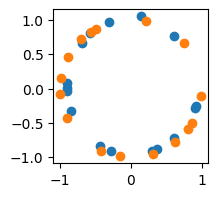

  4%|███▎                                                                            | 204/5000 [00:08<03:37, 22.06it/s]

Epoch: 201, Loss: 0.14161597192287445
Epoch: 202, Loss: 0.1432974934577942
Epoch: 203, Loss: 0.11345069110393524
Epoch: 204, Loss: 0.1192246675491333
Epoch: 205, Loss: 0.1301303505897522
Epoch: 206, Loss: 0.10692799091339111


  4%|███▎                                                                            | 210/5000 [00:08<03:25, 23.33it/s]

Epoch: 207, Loss: 0.16719543933868408
Epoch: 208, Loss: 0.12179934233427048
Epoch: 209, Loss: 0.1452956199645996


  4%|███▍                                                                            | 213/5000 [00:08<03:22, 23.63it/s]

Epoch: 210, Loss: 0.12104412913322449
Epoch: 211, Loss: 0.11918975412845612
Epoch: 212, Loss: 0.10963735729455948


  4%|███▍                                                                            | 216/5000 [00:08<03:18, 24.09it/s]

Epoch: 213, Loss: 0.12140555679798126
Epoch: 214, Loss: 0.1145777627825737
Epoch: 215, Loss: 0.1237424686551094


  4%|███▌                                                                            | 219/5000 [00:08<03:15, 24.39it/s]

Epoch: 216, Loss: 0.12492872029542923
Epoch: 217, Loss: 0.14217594265937805
Epoch: 218, Loss: 0.12188997119665146
Epoch: 219, Loss: 0.1337774097919464
Epoch: 220, Loss: 0.13719087839126587


  4%|███▌                                                                            | 222/5000 [00:09<03:16, 24.34it/s]

Epoch: 221, Loss: 0.14478464424610138
Epoch: 222, Loss: 0.16140086948871613
Epoch: 223, Loss: 0.12701565027236938


  4%|███▌                                                                            | 225/5000 [00:09<03:14, 24.53it/s]

Epoch: 224, Loss: 0.12805846333503723
Epoch: 225, Loss: 0.1162310242652893


  5%|███▋                                                                            | 228/5000 [00:09<03:16, 24.24it/s]

Epoch: 226, Loss: 0.11108647286891937
Epoch: 227, Loss: 0.12266185879707336
Epoch: 228, Loss: 0.15823589265346527


  5%|███▋                                                                            | 231/5000 [00:09<03:17, 24.13it/s]

Epoch: 229, Loss: 0.12686511874198914
Epoch: 230, Loss: 0.12096485495567322


  5%|███▋                                                                            | 234/5000 [00:09<03:13, 24.59it/s]

Epoch: 231, Loss: 0.12031593918800354
Epoch: 232, Loss: 0.12809234857559204
Epoch: 233, Loss: 0.12045085430145264
Epoch: 234, Loss: 0.11891782283782959


  5%|███▊                                                                            | 237/5000 [00:09<03:12, 24.79it/s]

Epoch: 235, Loss: 0.15310968458652496
Epoch: 236, Loss: 0.12329456955194473


  5%|███▊                                                                            | 240/5000 [00:09<03:14, 24.41it/s]

Epoch: 237, Loss: 0.24803844094276428
Epoch: 238, Loss: 0.14179635047912598
Epoch: 239, Loss: 0.1526447832584381


  5%|███▉                                                                            | 243/5000 [00:09<03:13, 24.64it/s]

Epoch: 240, Loss: 0.14721713960170746
Epoch: 241, Loss: 0.13442277908325195
Epoch: 242, Loss: 0.14133211970329285


  5%|███▉                                                                            | 246/5000 [00:10<03:10, 25.01it/s]

Epoch: 243, Loss: 0.14015212655067444
Epoch: 244, Loss: 0.12577560544013977
Epoch: 245, Loss: 0.1255584955215454


  5%|███▉                                                                            | 249/5000 [00:10<03:12, 24.72it/s]

Epoch: 246, Loss: 0.11582434177398682
Epoch: 247, Loss: 0.11128750443458557
Epoch: 248, Loss: 0.11967429518699646


  5%|████                                                                            | 252/5000 [00:10<03:11, 24.73it/s]

Epoch: 249, Loss: 0.13563036918640137
Epoch: 250, Loss: 0.16231213510036469
Epoch: 251, Loss: 0.1554713398218155


  5%|████                                                                            | 255/5000 [00:10<03:09, 25.05it/s]

Epoch: 252, Loss: 0.1210983470082283
Epoch: 253, Loss: 0.14123864471912384
Epoch: 254, Loss: 0.13216477632522583


  5%|████▏                                                                           | 258/5000 [00:10<03:13, 24.47it/s]

Epoch: 255, Loss: 0.1189098060131073
Epoch: 256, Loss: 0.13078370690345764
Epoch: 257, Loss: 0.1378338485956192


  5%|████▏                                                                           | 261/5000 [00:10<03:11, 24.76it/s]

Epoch: 258, Loss: 0.1087975949048996
Epoch: 259, Loss: 0.1467040777206421
Epoch: 260, Loss: 0.13328750431537628


  5%|████▏                                                                           | 264/5000 [00:10<03:12, 24.63it/s]

Epoch: 261, Loss: 0.11383288353681564
Epoch: 262, Loss: 0.1182589903473854
Epoch: 263, Loss: 0.12764671444892883


  5%|████▎                                                                           | 267/5000 [00:10<03:09, 25.04it/s]

Epoch: 264, Loss: 0.2040012776851654
Epoch: 265, Loss: 0.12992778420448303
Epoch: 266, Loss: 0.1580064594745636


  5%|████▎                                                                           | 270/5000 [00:11<03:08, 25.05it/s]

Epoch: 267, Loss: 0.1869736909866333
Epoch: 268, Loss: 0.2208476960659027
Epoch: 269, Loss: 0.23709341883659363


  5%|████▎                                                                           | 273/5000 [00:11<03:09, 24.90it/s]

Epoch: 270, Loss: 0.3138621747493744
Epoch: 271, Loss: 0.1947464644908905
Epoch: 272, Loss: 0.21191492676734924


  6%|████▍                                                                           | 276/5000 [00:11<03:08, 25.00it/s]

Epoch: 273, Loss: 0.13062915205955505
Epoch: 274, Loss: 0.19563236832618713
Epoch: 275, Loss: 0.1344567835330963


  6%|████▍                                                                           | 279/5000 [00:11<03:09, 24.88it/s]

Epoch: 276, Loss: 0.11954048275947571
Epoch: 277, Loss: 0.16158384084701538
Epoch: 278, Loss: 0.1442994475364685


  6%|████▌                                                                           | 282/5000 [00:11<03:10, 24.80it/s]

Epoch: 279, Loss: 0.20541299879550934
Epoch: 280, Loss: 0.11633041501045227
Epoch: 281, Loss: 0.13594019412994385


  6%|████▌                                                                           | 285/5000 [00:11<03:10, 24.73it/s]

Epoch: 282, Loss: 0.13699552416801453
Epoch: 283, Loss: 0.11242447793483734
Epoch: 284, Loss: 0.13013657927513123


  6%|████▌                                                                           | 288/5000 [00:11<03:09, 24.80it/s]

Epoch: 285, Loss: 0.13479773700237274
Epoch: 286, Loss: 0.1211772933602333
Epoch: 287, Loss: 0.12537311017513275


  6%|████▋                                                                           | 291/5000 [00:11<03:06, 25.28it/s]

Epoch: 288, Loss: 0.142015278339386
Epoch: 289, Loss: 0.11737325042486191
Epoch: 290, Loss: 0.12780208885669708


  6%|████▋                                                                           | 294/5000 [00:11<03:04, 25.45it/s]

Epoch: 291, Loss: 0.1257806271314621
Epoch: 292, Loss: 0.12950272858142853
Epoch: 293, Loss: 0.1274825930595398


  6%|████▊                                                                           | 297/5000 [00:12<03:09, 24.83it/s]

Epoch: 294, Loss: 0.13622789084911346
Epoch: 295, Loss: 0.14720065891742706
Epoch: 296, Loss: 0.1327821910381317
Epoch: 297, Loss: 0.12880119681358337
Epoch: 298, Loss: 0.1259928196668625


  6%|████▊                                                                           | 300/5000 [00:12<03:13, 24.33it/s]

Epoch: 299, Loss: 0.13653169572353363
Epoch: 300, Loss: 0.15461593866348267
Epoch: 301, Loss: 0.12005873024463654


  6%|████▊                                                                           | 303/5000 [00:12<03:13, 24.23it/s]

Epoch: 302, Loss: 0.12155185639858246
Epoch: 303, Loss: 0.12713085114955902


  6%|████▉                                                                           | 306/5000 [00:12<03:15, 24.07it/s]

Epoch: 304, Loss: 0.10618139058351517
Epoch: 305, Loss: 0.11875677853822708
Epoch: 306, Loss: 0.12045803666114807
Epoch: 307, Loss: 0.16220775246620178


  6%|████▉                                                                           | 309/5000 [00:12<03:12, 24.31it/s]

Epoch: 308, Loss: 0.16229623556137085
Epoch: 309, Loss: 0.15016774833202362


  6%|████▉                                                                           | 312/5000 [00:12<03:11, 24.45it/s]

Epoch: 310, Loss: 0.23873481154441833
Epoch: 311, Loss: 0.10822370648384094
Epoch: 312, Loss: 0.13235068321228027


  6%|█████                                                                           | 315/5000 [00:12<03:11, 24.47it/s]

Epoch: 313, Loss: 0.13078351318836212
Epoch: 314, Loss: 0.14888861775398254
Epoch: 315, Loss: 0.11753260344266891


  6%|█████                                                                           | 318/5000 [00:12<03:07, 24.95it/s]

Epoch: 316, Loss: 0.10961483418941498
Epoch: 317, Loss: 0.1344982087612152
Epoch: 318, Loss: 0.11464549601078033


  6%|█████▏                                                                          | 321/5000 [00:13<03:08, 24.80it/s]

Epoch: 319, Loss: 0.12471413612365723
Epoch: 320, Loss: 0.1382777839899063
Epoch: 321, Loss: 0.13853049278259277


  6%|█████▏                                                                          | 324/5000 [00:13<03:07, 24.95it/s]

Epoch: 322, Loss: 0.12788493931293488
Epoch: 323, Loss: 0.11500991880893707
Epoch: 324, Loss: 0.1373213529586792


  7%|█████▏                                                                          | 327/5000 [00:13<03:10, 24.47it/s]

Epoch: 325, Loss: 0.1257830560207367
Epoch: 326, Loss: 0.13132885098457336


  7%|█████▎                                                                          | 330/5000 [00:13<03:10, 24.56it/s]

Epoch: 327, Loss: 0.113082654774189
Epoch: 328, Loss: 0.13189317286014557
Epoch: 329, Loss: 0.12543773651123047


  7%|█████▎                                                                          | 333/5000 [00:13<03:08, 24.70it/s]

Epoch: 330, Loss: 0.11236074566841125
Epoch: 331, Loss: 0.12189830839633942
Epoch: 332, Loss: 0.13250064849853516


  7%|█████▍                                                                          | 336/5000 [00:13<03:08, 24.77it/s]

Epoch: 333, Loss: 0.13088372349739075
Epoch: 334, Loss: 0.13774198293685913
Epoch: 335, Loss: 0.14610740542411804


  7%|█████▍                                                                          | 339/5000 [00:13<03:10, 24.43it/s]

Epoch: 336, Loss: 0.15085072815418243
Epoch: 337, Loss: 0.15272614359855652
Epoch: 338, Loss: 0.11707411706447601
Epoch: 339, Loss: 0.11941580474376678
Epoch: 340, Loss: 0.11390407383441925


  7%|█████▌                                                                          | 345/5000 [00:14<03:10, 24.46it/s]

Epoch: 341, Loss: 0.1514011025428772
Epoch: 342, Loss: 0.1234515830874443
Epoch: 343, Loss: 0.1378900408744812
Epoch: 344, Loss: 0.1354638785123825
Epoch: 345, Loss: 0.11625027656555176


  7%|█████▌                                                                          | 348/5000 [00:14<03:12, 24.21it/s]

Epoch: 346, Loss: 0.12115497142076492
Epoch: 347, Loss: 0.14032715559005737
Epoch: 348, Loss: 0.15088316798210144
Epoch: 349, Loss: 0.12836098670959473
Epoch: 350, Loss: 0.12473446130752563


  7%|█████▋                                                                          | 357/5000 [00:14<03:08, 24.61it/s]

Epoch: 351, Loss: 0.12181248515844345
Epoch: 352, Loss: 0.1262814998626709
Epoch: 353, Loss: 0.13432346284389496
Epoch: 354, Loss: 0.11432795226573944
Epoch: 355, Loss: 0.12251546233892441
Epoch: 356, Loss: 0.11933749914169312


  7%|█████▊                                                                          | 363/5000 [00:14<03:03, 25.21it/s]

Epoch: 357, Loss: 0.1224643737077713
Epoch: 358, Loss: 0.11983867734670639
Epoch: 359, Loss: 0.14307253062725067
Epoch: 360, Loss: 0.15176519751548767
Epoch: 361, Loss: 0.11884035170078278
Epoch: 362, Loss: 0.12376759946346283


  7%|█████▉                                                                          | 369/5000 [00:15<03:00, 25.72it/s]

Epoch: 363, Loss: 0.12129755318164825
Epoch: 364, Loss: 0.12697315216064453
Epoch: 365, Loss: 0.1359507143497467
Epoch: 366, Loss: 0.1282675564289093
Epoch: 367, Loss: 0.1328485608100891
Epoch: 368, Loss: 0.10855814814567566


  8%|██████                                                                          | 375/5000 [00:15<03:01, 25.53it/s]

Epoch: 369, Loss: 0.11798028647899628
Epoch: 370, Loss: 0.14457008242607117
Epoch: 371, Loss: 0.14557315409183502
Epoch: 372, Loss: 0.12612983584403992
Epoch: 373, Loss: 0.15472719073295593
Epoch: 374, Loss: 0.12319567054510117


  8%|██████                                                                          | 378/5000 [00:15<03:02, 25.32it/s]

Epoch: 375, Loss: 0.13031253218650818
Epoch: 376, Loss: 0.11698310077190399
Epoch: 377, Loss: 0.11817316710948944
Epoch: 378, Loss: 0.1255207359790802
Epoch: 379, Loss: 0.12949441373348236


  8%|██████▏                                                                         | 384/5000 [00:15<03:04, 25.05it/s]

Epoch: 380, Loss: 0.13683514297008514
Epoch: 381, Loss: 0.14125731587409973
Epoch: 382, Loss: 0.11561175435781479
Epoch: 383, Loss: 0.14280034601688385
Epoch: 384, Loss: 0.1230018138885498
Epoch: 385, Loss: 0.1296159327030182


  8%|██████▏                                                                         | 390/5000 [00:15<03:05, 24.85it/s]

Epoch: 386, Loss: 0.1216016560792923
Epoch: 387, Loss: 0.12035772204399109
Epoch: 388, Loss: 0.1210298165678978
Epoch: 389, Loss: 0.11820629239082336
Epoch: 390, Loss: 0.11434362828731537
Epoch: 391, Loss: 0.12967506051063538


  8%|██████▎                                                                         | 396/5000 [00:16<03:01, 25.32it/s]

Epoch: 392, Loss: 0.12194042652845383
Epoch: 393, Loss: 0.12964822351932526
Epoch: 394, Loss: 0.12074776738882065
Epoch: 395, Loss: 0.1332131028175354
Epoch: 396, Loss: 0.14002355933189392
Epoch: 397, Loss: 0.15444360673427582


  8%|██████▍                                                                         | 399/5000 [00:16<03:02, 25.20it/s]

Epoch: 398, Loss: 0.1262393295764923
Epoch: 399, Loss: 0.11729317158460617
Epoch: 400, Loss: 0.11887507140636444


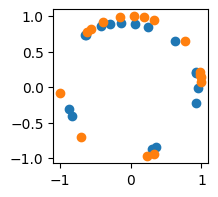

  8%|██████▍                                                                         | 402/5000 [00:16<03:36, 21.28it/s]

Epoch: 401, Loss: 0.11047280579805374


  8%|██████▍                                                                         | 405/5000 [00:16<03:25, 22.40it/s]

Epoch: 402, Loss: 0.13776057958602905
Epoch: 403, Loss: 0.1409110724925995
Epoch: 404, Loss: 0.11810924112796783
Epoch: 405, Loss: 0.13529768586158752
Epoch: 406, Loss: 0.11852669715881348


  8%|██████▌                                                                         | 408/5000 [00:16<03:14, 23.63it/s]

Epoch: 407, Loss: 0.12628591060638428


  8%|██████▌                                                                         | 411/5000 [00:16<03:11, 23.91it/s]

Epoch: 408, Loss: 0.11618498712778091
Epoch: 409, Loss: 0.12845651805400848
Epoch: 410, Loss: 0.1195371076464653
Epoch: 411, Loss: 0.12263758480548859
Epoch: 412, Loss: 0.1259034425020218


  8%|██████▌                                                                         | 414/5000 [00:16<03:10, 24.12it/s]

Epoch: 413, Loss: 0.1307431012392044


  8%|██████▋                                                                         | 417/5000 [00:17<03:10, 24.03it/s]

Epoch: 414, Loss: 0.1307491958141327
Epoch: 415, Loss: 0.11623584479093552
Epoch: 416, Loss: 0.13230527937412262
Epoch: 417, Loss: 0.12179333716630936
Epoch: 418, Loss: 0.13197088241577148


  8%|██████▊                                                                         | 423/5000 [00:17<03:04, 24.79it/s]

Epoch: 419, Loss: 0.11728430539369583
Epoch: 420, Loss: 0.13854598999023438
Epoch: 421, Loss: 0.149006187915802
Epoch: 422, Loss: 0.12742388248443604
Epoch: 423, Loss: 0.13599646091461182
Epoch: 424, Loss: 0.1284056156873703


  9%|██████▊                                                                         | 429/5000 [00:17<03:01, 25.13it/s]

Epoch: 425, Loss: 0.13186639547348022
Epoch: 426, Loss: 0.1193760484457016
Epoch: 427, Loss: 0.15073291957378387
Epoch: 428, Loss: 0.11964745819568634
Epoch: 429, Loss: 0.12686839699745178
Epoch: 430, Loss: 0.14069725573062897


  9%|██████▉                                                                         | 435/5000 [00:17<03:03, 24.82it/s]

Epoch: 431, Loss: 0.14960043132305145
Epoch: 432, Loss: 0.12107570469379425
Epoch: 433, Loss: 0.14523917436599731
Epoch: 434, Loss: 0.11633715033531189
Epoch: 435, Loss: 0.12843728065490723
Epoch: 436, Loss: 0.12237584590911865


  9%|███████                                                                         | 438/5000 [00:17<03:06, 24.41it/s]

Epoch: 437, Loss: 0.12836509943008423
Epoch: 438, Loss: 0.12924551963806152
Epoch: 439, Loss: 0.11136716604232788


  9%|███████                                                                         | 441/5000 [00:17<03:06, 24.50it/s]

Epoch: 440, Loss: 0.12897802889347076
Epoch: 441, Loss: 0.12691479921340942
Epoch: 442, Loss: 0.13320177793502808


  9%|███████                                                                         | 444/5000 [00:18<03:06, 24.47it/s]

Epoch: 443, Loss: 0.17413753271102905
Epoch: 444, Loss: 0.12153926491737366
Epoch: 445, Loss: 0.13283410668373108


  9%|███████▏                                                                        | 447/5000 [00:18<03:02, 24.99it/s]

Epoch: 446, Loss: 0.13278840482234955
Epoch: 447, Loss: 0.1150783821940422
Epoch: 448, Loss: 0.12914450466632843


  9%|███████▏                                                                        | 450/5000 [00:18<03:00, 25.26it/s]

Epoch: 449, Loss: 0.11605845391750336
Epoch: 450, Loss: 0.11939089000225067
Epoch: 451, Loss: 0.14237329363822937


  9%|███████▏                                                                        | 453/5000 [00:18<02:58, 25.46it/s]

Epoch: 452, Loss: 0.13765990734100342
Epoch: 453, Loss: 0.14633750915527344
Epoch: 454, Loss: 0.12243565917015076


  9%|███████▎                                                                        | 456/5000 [00:18<03:00, 25.17it/s]

Epoch: 455, Loss: 0.12878447771072388
Epoch: 456, Loss: 0.12353667616844177
Epoch: 457, Loss: 0.1326708197593689


  9%|███████▎                                                                        | 459/5000 [00:18<03:01, 25.02it/s]

Epoch: 458, Loss: 0.12176737189292908
Epoch: 459, Loss: 0.12847691774368286


  9%|███████▍                                                                        | 462/5000 [00:18<03:03, 24.70it/s]

Epoch: 460, Loss: 0.11945529282093048
Epoch: 461, Loss: 0.11933255195617676
Epoch: 462, Loss: 0.1299341470003128


  9%|███████▍                                                                        | 465/5000 [00:18<03:04, 24.54it/s]

Epoch: 463, Loss: 0.12611907720565796
Epoch: 464, Loss: 0.12800708413124084


  9%|███████▍                                                                        | 468/5000 [00:19<03:05, 24.42it/s]

Epoch: 465, Loss: 0.13200831413269043
Epoch: 466, Loss: 0.11728036403656006
Epoch: 467, Loss: 0.129892036318779


  9%|███████▌                                                                        | 471/5000 [00:19<03:04, 24.54it/s]

Epoch: 468, Loss: 0.11087463051080704
Epoch: 469, Loss: 0.1403478980064392
Epoch: 470, Loss: 0.12302723526954651


  9%|███████▌                                                                        | 474/5000 [00:19<03:05, 24.46it/s]

Epoch: 471, Loss: 0.13249480724334717
Epoch: 472, Loss: 0.14657410979270935
Epoch: 473, Loss: 0.12790820002555847
Epoch: 474, Loss: 0.1124269962310791
Epoch: 475, Loss: 0.13516336679458618


 10%|███████▋                                                                        | 480/5000 [00:19<03:05, 24.35it/s]

Epoch: 476, Loss: 0.12878239154815674
Epoch: 477, Loss: 0.12085224688053131
Epoch: 478, Loss: 0.13998344540596008
Epoch: 479, Loss: 0.13644780218601227
Epoch: 480, Loss: 0.12864768505096436


 10%|███████▋                                                                        | 483/5000 [00:19<03:05, 24.38it/s]

Epoch: 481, Loss: 0.11557644605636597
Epoch: 482, Loss: 0.1369796246290207
Epoch: 483, Loss: 0.11342982947826385
Epoch: 484, Loss: 0.12601113319396973


 10%|███████▊                                                                        | 486/5000 [00:19<03:13, 23.27it/s]

Epoch: 485, Loss: 0.11433178931474686


 10%|███████▊                                                                        | 489/5000 [00:19<03:09, 23.78it/s]

Epoch: 486, Loss: 0.12300213426351547
Epoch: 487, Loss: 0.1331443041563034
Epoch: 488, Loss: 0.12386064976453781
Epoch: 489, Loss: 0.13915219902992249
Epoch: 490, Loss: 0.1378328949213028


 10%|███████▊                                                                        | 492/5000 [00:20<03:03, 24.54it/s]

Epoch: 491, Loss: 0.12371839582920074


 10%|███████▉                                                                        | 495/5000 [00:20<03:04, 24.43it/s]

Epoch: 492, Loss: 0.1281196027994156
Epoch: 493, Loss: 0.1366378366947174
Epoch: 494, Loss: 0.12099478393793106
Epoch: 495, Loss: 0.11855540424585342
Epoch: 496, Loss: 0.12888851761817932


 10%|███████▉                                                                        | 498/5000 [00:20<03:01, 24.76it/s]

Epoch: 497, Loss: 0.11064447462558746


 10%|████████                                                                        | 501/5000 [00:20<03:04, 24.36it/s]

Epoch: 498, Loss: 0.11748187243938446
Epoch: 499, Loss: 0.13752111792564392
Epoch: 500, Loss: 0.12194447219371796
Epoch: 501, Loss: 0.11627618223428726


 10%|████████                                                                        | 504/5000 [00:20<03:03, 24.51it/s]

Epoch: 502, Loss: 0.13332265615463257
Epoch: 503, Loss: 0.14591336250305176


 10%|████████                                                                        | 507/5000 [00:20<02:58, 25.13it/s]

Epoch: 504, Loss: 0.12020059674978256
Epoch: 505, Loss: 0.13665804266929626
Epoch: 506, Loss: 0.13494572043418884
Epoch: 507, Loss: 0.12010526657104492
Epoch: 508, Loss: 0.13537980616092682


 10%|████████▏                                                                       | 510/5000 [00:20<03:05, 24.18it/s]

Epoch: 509, Loss: 0.12381958961486816
Epoch: 510, Loss: 0.14980411529541016
Epoch: 511, Loss: 0.11581601202487946


 10%|████████▏                                                                       | 513/5000 [00:20<03:06, 24.06it/s]

Epoch: 512, Loss: 0.11803381890058517
Epoch: 513, Loss: 0.10861658304929733


 10%|████████▎                                                                       | 516/5000 [00:21<03:10, 23.59it/s]

Epoch: 514, Loss: 0.11918283998966217
Epoch: 515, Loss: 0.13454566895961761
Epoch: 516, Loss: 0.11981300264596939


 10%|████████▎                                                                       | 519/5000 [00:21<03:05, 24.10it/s]

Epoch: 517, Loss: 0.11445283144712448
Epoch: 518, Loss: 0.12134848535060883
Epoch: 519, Loss: 0.12316940724849701


 10%|████████▎                                                                       | 522/5000 [00:21<03:05, 24.19it/s]

Epoch: 520, Loss: 0.12974970042705536
Epoch: 521, Loss: 0.12289868295192719


 10%|████████▍                                                                       | 525/5000 [00:21<03:06, 23.97it/s]

Epoch: 522, Loss: 0.14936603605747223
Epoch: 523, Loss: 0.11577808856964111
Epoch: 524, Loss: 0.1146419569849968
Epoch: 525, Loss: 0.12209011614322662
Epoch: 526, Loss: 0.1156046912074089


 11%|████████▍                                                                       | 528/5000 [00:21<03:05, 24.08it/s]

Epoch: 527, Loss: 0.13684135675430298
Epoch: 528, Loss: 0.1180855929851532
Epoch: 529, Loss: 0.11419427394866943


 11%|████████▍                                                                       | 531/5000 [00:21<03:11, 23.38it/s]

Epoch: 530, Loss: 0.15361368656158447
Epoch: 531, Loss: 0.10918956995010376


 11%|████████▌                                                                       | 534/5000 [00:21<03:08, 23.73it/s]

Epoch: 532, Loss: 0.10863736271858215
Epoch: 533, Loss: 0.1271974742412567
Epoch: 534, Loss: 0.12460649013519287
Epoch: 535, Loss: 0.11780725419521332


 11%|████████▌                                                                       | 537/5000 [00:21<03:07, 23.85it/s]

Epoch: 536, Loss: 0.12295937538146973


 11%|████████▋                                                                       | 540/5000 [00:22<03:04, 24.18it/s]

Epoch: 537, Loss: 0.12007090449333191
Epoch: 538, Loss: 0.1301674246788025
Epoch: 539, Loss: 0.11545731127262115
Epoch: 540, Loss: 0.12376980483531952
Epoch: 541, Loss: 0.11881185322999954


 11%|████████▋                                                                       | 543/5000 [00:22<03:02, 24.45it/s]

Epoch: 542, Loss: 0.11755775660276413


 11%|████████▋                                                                       | 546/5000 [00:22<03:05, 24.01it/s]

Epoch: 543, Loss: 0.13599783182144165
Epoch: 544, Loss: 0.1281612515449524
Epoch: 545, Loss: 0.152730792760849
Epoch: 546, Loss: 0.11902349442243576
Epoch: 547, Loss: 0.10744854807853699


 11%|████████▊                                                                       | 552/5000 [00:22<03:04, 24.10it/s]

Epoch: 548, Loss: 0.1227097287774086
Epoch: 549, Loss: 0.140219047665596
Epoch: 550, Loss: 0.12599627673625946
Epoch: 551, Loss: 0.11433419585227966
Epoch: 552, Loss: 0.11149784177541733


 11%|████████▉                                                                       | 558/5000 [00:22<02:59, 24.69it/s]

Epoch: 553, Loss: 0.13501551747322083
Epoch: 554, Loss: 0.11448847502470016
Epoch: 555, Loss: 0.12534873187541962
Epoch: 556, Loss: 0.11124543845653534
Epoch: 557, Loss: 0.12328435480594635
Epoch: 558, Loss: 0.127302885055542


 11%|█████████                                                                       | 564/5000 [00:23<02:55, 25.33it/s]

Epoch: 559, Loss: 0.11306173354387283
Epoch: 560, Loss: 0.12025502324104309
Epoch: 561, Loss: 0.1513574868440628
Epoch: 562, Loss: 0.12196217477321625
Epoch: 563, Loss: 0.12647084891796112
Epoch: 564, Loss: 0.13193832337856293


 11%|█████████                                                                       | 567/5000 [00:23<03:00, 24.62it/s]

Epoch: 565, Loss: 0.11868511140346527
Epoch: 566, Loss: 0.12126389145851135
Epoch: 567, Loss: 0.1216772198677063
Epoch: 568, Loss: 0.11759867519140244


 11%|█████████                                                                       | 570/5000 [00:23<02:59, 24.69it/s]

Epoch: 569, Loss: 0.11876046657562256


 11%|█████████▏                                                                      | 573/5000 [00:23<03:01, 24.41it/s]

Epoch: 570, Loss: 0.1130959689617157
Epoch: 571, Loss: 0.13561555743217468
Epoch: 572, Loss: 0.12102396786212921
Epoch: 573, Loss: 0.11911129951477051
Epoch: 574, Loss: 0.12360651791095734


 12%|█████████▎                                                                      | 579/5000 [00:23<03:02, 24.22it/s]

Epoch: 575, Loss: 0.12308211624622345
Epoch: 576, Loss: 0.13008257746696472
Epoch: 577, Loss: 0.13121157884597778
Epoch: 578, Loss: 0.1352425217628479
Epoch: 579, Loss: 0.12066920101642609


 12%|█████████▎                                                                      | 585/5000 [00:23<02:55, 25.09it/s]

Epoch: 580, Loss: 0.11824530363082886
Epoch: 581, Loss: 0.12402337789535522
Epoch: 582, Loss: 0.13393062353134155
Epoch: 583, Loss: 0.13104066252708435
Epoch: 584, Loss: 0.1491265445947647
Epoch: 585, Loss: 0.13676373660564423


 12%|█████████▍                                                                      | 588/5000 [00:24<03:00, 24.46it/s]

Epoch: 586, Loss: 0.11302465200424194
Epoch: 587, Loss: 0.10622580349445343
Epoch: 588, Loss: 0.11759071052074432
Epoch: 589, Loss: 0.12693259119987488


 12%|█████████▍                                                                      | 591/5000 [00:24<02:59, 24.59it/s]

Epoch: 590, Loss: 0.11752358824014664


 12%|█████████▌                                                                      | 594/5000 [00:24<03:01, 24.28it/s]

Epoch: 591, Loss: 0.1198756992816925
Epoch: 592, Loss: 0.12246151268482208
Epoch: 593, Loss: 0.1203957200050354
Epoch: 594, Loss: 0.13017404079437256
Epoch: 595, Loss: 0.11224193125963211


 12%|█████████▌                                                                      | 600/5000 [00:24<03:07, 23.41it/s]

Epoch: 596, Loss: 0.14415985345840454
Epoch: 597, Loss: 0.11379571259021759
Epoch: 598, Loss: 0.13005363941192627
Epoch: 599, Loss: 0.12603139877319336
Epoch: 600, Loss: 0.1172378659248352


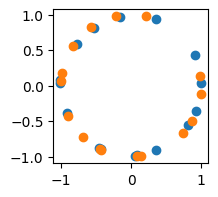

 12%|█████████▋                                                                      | 603/5000 [00:24<03:44, 19.55it/s]

Epoch: 601, Loss: 0.11516575515270233
Epoch: 602, Loss: 0.14982947707176208


 12%|█████████▋                                                                      | 606/5000 [00:24<03:34, 20.51it/s]

Epoch: 603, Loss: 0.13401541113853455
Epoch: 604, Loss: 0.12371748685836792
Epoch: 605, Loss: 0.11347457766532898
Epoch: 606, Loss: 0.13671252131462097
Epoch: 607, Loss: 0.12179745733737946


 12%|█████████▊                                                                      | 612/5000 [00:25<03:14, 22.58it/s]

Epoch: 608, Loss: 0.11918403208255768
Epoch: 609, Loss: 0.11537478119134903
Epoch: 610, Loss: 0.12465347349643707
Epoch: 611, Loss: 0.1165662556886673
Epoch: 612, Loss: 0.1270189732313156
Epoch: 613, Loss: 0.12146086990833282


 12%|█████████▉                                                                      | 618/5000 [00:25<03:01, 24.09it/s]

Epoch: 614, Loss: 0.12757040560245514
Epoch: 615, Loss: 0.1337396204471588
Epoch: 616, Loss: 0.11857123672962189
Epoch: 617, Loss: 0.1350754350423813
Epoch: 618, Loss: 0.12602627277374268
Epoch: 619, Loss: 0.13198599219322205


 12%|█████████▉                                                                      | 621/5000 [00:25<03:06, 23.52it/s]

Epoch: 620, Loss: 0.1110813170671463
Epoch: 621, Loss: 0.1195283904671669
Epoch: 622, Loss: 0.12734845280647278


 12%|█████████▉                                                                      | 624/5000 [00:25<03:01, 24.10it/s]

Epoch: 623, Loss: 0.1438579112291336
Epoch: 624, Loss: 0.12018729001283646
Epoch: 625, Loss: 0.1257222592830658


 13%|██████████                                                                      | 627/5000 [00:25<03:04, 23.67it/s]

Epoch: 626, Loss: 0.11583688855171204
Epoch: 627, Loss: 0.11401690542697906


 13%|██████████                                                                      | 630/5000 [00:25<03:03, 23.81it/s]

Epoch: 628, Loss: 0.13168971240520477
Epoch: 629, Loss: 0.11222489178180695
Epoch: 630, Loss: 0.12391459941864014


 13%|██████████▏                                                                     | 633/5000 [00:25<02:59, 24.32it/s]

Epoch: 631, Loss: 0.12706995010375977
Epoch: 632, Loss: 0.11812807619571686
Epoch: 633, Loss: 0.1297212690114975


 13%|██████████▏                                                                     | 636/5000 [00:26<02:57, 24.62it/s]

Epoch: 634, Loss: 0.12151096761226654
Epoch: 635, Loss: 0.10990024358034134


 13%|██████████▏                                                                     | 639/5000 [00:26<02:59, 24.26it/s]

Epoch: 636, Loss: 0.13014362752437592
Epoch: 637, Loss: 0.14106982946395874
Epoch: 638, Loss: 0.11953024566173553
Epoch: 639, Loss: 0.12928101420402527
Epoch: 640, Loss: 0.1180223673582077


 13%|██████████▎                                                                     | 645/5000 [00:26<02:56, 24.71it/s]

Epoch: 641, Loss: 0.12701916694641113
Epoch: 642, Loss: 0.12304843217134476
Epoch: 643, Loss: 0.11747493594884872
Epoch: 644, Loss: 0.12102826684713364
Epoch: 645, Loss: 0.12184232473373413
Epoch: 646, Loss: 0.11625852435827255


 13%|██████████▍                                                                     | 651/5000 [00:26<02:51, 25.30it/s]

Epoch: 647, Loss: 0.11177720874547958
Epoch: 648, Loss: 0.12321871519088745
Epoch: 649, Loss: 0.11467820405960083
Epoch: 650, Loss: 0.15182170271873474
Epoch: 651, Loss: 0.12931975722312927
Epoch: 652, Loss: 0.13471856713294983


 13%|██████████▌                                                                     | 657/5000 [00:26<02:51, 25.40it/s]

Epoch: 653, Loss: 0.12642121315002441
Epoch: 654, Loss: 0.10964301973581314
Epoch: 655, Loss: 0.11639495193958282
Epoch: 656, Loss: 0.12691573798656464
Epoch: 657, Loss: 0.1275818645954132
Epoch: 658, Loss: 0.13404574990272522


 13%|██████████▌                                                                     | 663/5000 [00:27<02:50, 25.45it/s]

Epoch: 659, Loss: 0.13545453548431396
Epoch: 660, Loss: 0.13489043712615967
Epoch: 661, Loss: 0.11334604769945145
Epoch: 662, Loss: 0.11948072165250778
Epoch: 663, Loss: 0.12029022723436356
Epoch: 664, Loss: 0.13252262771129608


 13%|██████████▋                                                                     | 666/5000 [00:27<02:55, 24.67it/s]

Epoch: 665, Loss: 0.12318189442157745
Epoch: 666, Loss: 0.12349055707454681
Epoch: 667, Loss: 0.11553184688091278


 13%|██████████▋                                                                     | 669/5000 [00:27<02:58, 24.21it/s]

Epoch: 668, Loss: 0.1264711618423462
Epoch: 669, Loss: 0.12221983075141907


 13%|██████████▊                                                                     | 672/5000 [00:27<03:01, 23.89it/s]

Epoch: 670, Loss: 0.11632616817951202
Epoch: 671, Loss: 0.11789118498563766
Epoch: 672, Loss: 0.12045218795537949


 14%|██████████▊                                                                     | 675/5000 [00:27<02:57, 24.32it/s]

Epoch: 673, Loss: 0.11046205461025238
Epoch: 674, Loss: 0.13018900156021118
Epoch: 675, Loss: 0.1178521141409874


 14%|██████████▊                                                                     | 678/5000 [00:27<02:59, 24.05it/s]

Epoch: 676, Loss: 0.12066561728715897
Epoch: 677, Loss: 0.14804641902446747


 14%|██████████▉                                                                     | 681/5000 [00:27<02:59, 24.11it/s]

Epoch: 678, Loss: 0.11450915038585663
Epoch: 679, Loss: 0.1185937225818634
Epoch: 680, Loss: 0.13553346693515778


 14%|██████████▉                                                                     | 684/5000 [00:28<02:56, 24.43it/s]

Epoch: 681, Loss: 0.13755711913108826
Epoch: 682, Loss: 0.12475813925266266
Epoch: 683, Loss: 0.13516844809055328


 14%|██████████▉                                                                     | 687/5000 [00:28<02:55, 24.62it/s]

Epoch: 684, Loss: 0.13237763941287994
Epoch: 685, Loss: 0.12841811776161194
Epoch: 686, Loss: 0.14515137672424316
Epoch: 687, Loss: 0.1433308720588684
Epoch: 688, Loss: 0.12402428686618805


 14%|███████████                                                                     | 690/5000 [00:28<02:58, 24.15it/s]

Epoch: 689, Loss: 0.14375914633274078
Epoch: 690, Loss: 0.143580362200737
Epoch: 691, Loss: 0.1306988149881363


 14%|███████████                                                                     | 693/5000 [00:28<02:58, 24.15it/s]

Epoch: 692, Loss: 0.11668821424245834
Epoch: 693, Loss: 0.13602596521377563


 14%|███████████▏                                                                    | 696/5000 [00:28<02:58, 24.08it/s]

Epoch: 694, Loss: 0.13462737202644348
Epoch: 695, Loss: 0.13360381126403809
Epoch: 696, Loss: 0.12159454822540283


 14%|███████████▏                                                                    | 699/5000 [00:28<02:56, 24.31it/s]

Epoch: 697, Loss: 0.1117648035287857
Epoch: 698, Loss: 0.10955294966697693
Epoch: 699, Loss: 0.1260375827550888


 14%|███████████▏                                                                    | 702/5000 [00:28<02:56, 24.42it/s]

Epoch: 700, Loss: 0.12196098268032074
Epoch: 701, Loss: 0.12069600820541382


 14%|███████████▎                                                                    | 705/5000 [00:28<02:58, 24.09it/s]

Epoch: 702, Loss: 0.13379806280136108
Epoch: 703, Loss: 0.11862429231405258
Epoch: 704, Loss: 0.11589407920837402
Epoch: 705, Loss: 0.11968707293272018
Epoch: 706, Loss: 0.12461891025304794


 14%|███████████▍                                                                    | 711/5000 [00:29<02:52, 24.84it/s]

Epoch: 707, Loss: 0.13671311736106873
Epoch: 708, Loss: 0.14107215404510498
Epoch: 709, Loss: 0.13694614171981812
Epoch: 710, Loss: 0.1229136735200882
Epoch: 711, Loss: 0.11838053911924362
Epoch: 712, Loss: 0.13118228316307068


 14%|███████████▍                                                                    | 714/5000 [00:29<02:54, 24.61it/s]

Epoch: 713, Loss: 0.13363151252269745
Epoch: 714, Loss: 0.1140463575720787
Epoch: 715, Loss: 0.13768723607063293


 14%|███████████▍                                                                    | 717/5000 [00:29<02:55, 24.42it/s]

Epoch: 716, Loss: 0.11585643887519836
Epoch: 717, Loss: 0.14853090047836304


 14%|███████████▌                                                                    | 720/5000 [00:29<02:57, 24.14it/s]

Epoch: 718, Loss: 0.1322789043188095
Epoch: 719, Loss: 0.1276073008775711
Epoch: 720, Loss: 0.12172164022922516


 14%|███████████▌                                                                    | 723/5000 [00:29<02:56, 24.21it/s]

Epoch: 721, Loss: 0.13321754336357117
Epoch: 722, Loss: 0.23708245158195496


 15%|███████████▌                                                                    | 726/5000 [00:29<02:55, 24.42it/s]

Epoch: 723, Loss: 0.12723992764949799
Epoch: 724, Loss: 0.12130828946828842
Epoch: 725, Loss: 0.13222835958003998
Epoch: 726, Loss: 0.12110604345798492


 15%|███████████▋                                                                    | 729/5000 [00:29<02:54, 24.43it/s]

Epoch: 727, Loss: 0.11602683365345001
Epoch: 728, Loss: 0.13969454169273376


 15%|███████████▋                                                                    | 732/5000 [00:30<02:54, 24.50it/s]

Epoch: 729, Loss: 0.1313222348690033
Epoch: 730, Loss: 0.12939462065696716
Epoch: 731, Loss: 0.1749274730682373
Epoch: 732, Loss: 0.12875422835350037


 15%|███████████▊                                                                    | 735/5000 [00:30<02:55, 24.31it/s]

Epoch: 733, Loss: 0.12391045689582825
Epoch: 734, Loss: 0.11579005420207977


 15%|███████████▊                                                                    | 738/5000 [00:30<02:54, 24.38it/s]

Epoch: 735, Loss: 0.12505537271499634
Epoch: 736, Loss: 0.1298515349626541
Epoch: 737, Loss: 0.12970520555973053
Epoch: 738, Loss: 0.12479393929243088
Epoch: 739, Loss: 0.11189646273851395


 15%|███████████▉                                                                    | 744/5000 [00:30<02:54, 24.39it/s]

Epoch: 740, Loss: 0.1320359706878662
Epoch: 741, Loss: 0.12713733315467834
Epoch: 742, Loss: 0.11919514089822769
Epoch: 743, Loss: 0.1390238106250763
Epoch: 744, Loss: 0.11546548455953598


 15%|███████████▉                                                                    | 747/5000 [00:30<02:58, 23.76it/s]

Epoch: 745, Loss: 0.11846673488616943
Epoch: 746, Loss: 0.1151261255145073
Epoch: 747, Loss: 0.12059003114700317
Epoch: 748, Loss: 0.12614454329013824


 15%|████████████                                                                    | 750/5000 [00:30<02:57, 23.96it/s]

Epoch: 749, Loss: 0.1412055492401123


 15%|████████████                                                                    | 753/5000 [00:30<02:59, 23.67it/s]

Epoch: 750, Loss: 0.11435326188802719
Epoch: 751, Loss: 0.13337942957878113
Epoch: 752, Loss: 0.13110536336898804
Epoch: 753, Loss: 0.12408970296382904
Epoch: 754, Loss: 0.142681285738945


 15%|████████████▏                                                                   | 759/5000 [00:31<02:53, 24.44it/s]

Epoch: 755, Loss: 0.12172077596187592
Epoch: 756, Loss: 0.11417502909898758
Epoch: 757, Loss: 0.12069961428642273
Epoch: 758, Loss: 0.11437995731830597
Epoch: 759, Loss: 0.11647167801856995
Epoch: 760, Loss: 0.14998002350330353


 15%|████████████▏                                                                   | 765/5000 [00:31<02:51, 24.63it/s]

Epoch: 761, Loss: 0.12439171224832535
Epoch: 762, Loss: 0.1283305585384369
Epoch: 763, Loss: 0.11148925125598907
Epoch: 764, Loss: 0.12714999914169312
Epoch: 765, Loss: 0.12362125515937805


 15%|████████████▎                                                                   | 771/5000 [00:31<02:47, 25.27it/s]

Epoch: 766, Loss: 0.16734573245048523
Epoch: 767, Loss: 0.11950905621051788
Epoch: 768, Loss: 0.11677318066358566
Epoch: 769, Loss: 0.11856063455343246
Epoch: 770, Loss: 0.14876998960971832
Epoch: 771, Loss: 0.13700558245182037


 15%|████████████▍                                                                   | 774/5000 [00:31<02:59, 23.59it/s]

Epoch: 772, Loss: 0.12099795043468475
Epoch: 773, Loss: 0.1444714516401291
Epoch: 774, Loss: 0.12658244371414185
Epoch: 775, Loss: 0.11375461518764496


 16%|████████████▍                                                                   | 777/5000 [00:31<02:52, 24.50it/s]

Epoch: 776, Loss: 0.11568540334701538


 16%|████████████▍                                                                   | 780/5000 [00:32<02:52, 24.51it/s]

Epoch: 777, Loss: 0.131971538066864
Epoch: 778, Loss: 0.13305339217185974
Epoch: 779, Loss: 0.138933464884758
Epoch: 780, Loss: 0.11969702690839767
Epoch: 781, Loss: 0.12699078023433685


 16%|████████████▌                                                                   | 783/5000 [00:32<02:48, 25.08it/s]

Epoch: 782, Loss: 0.1253778636455536


 16%|████████████▌                                                                   | 786/5000 [00:32<02:46, 25.28it/s]

Epoch: 783, Loss: 0.12624065577983856
Epoch: 784, Loss: 0.11831625550985336
Epoch: 785, Loss: 0.10746607184410095
Epoch: 786, Loss: 0.15489494800567627
Epoch: 787, Loss: 0.11545916646718979


 16%|████████████▌                                                                   | 789/5000 [00:32<02:52, 24.48it/s]

Epoch: 788, Loss: 0.13896316289901733


 16%|████████████▋                                                                   | 792/5000 [00:32<02:53, 24.31it/s]

Epoch: 789, Loss: 0.1499587595462799
Epoch: 790, Loss: 0.11703653633594513
Epoch: 791, Loss: 0.14828723669052124
Epoch: 792, Loss: 0.12285955250263214


 16%|████████████▋                                                                   | 795/5000 [00:32<02:53, 24.27it/s]

Epoch: 793, Loss: 0.14601674675941467
Epoch: 794, Loss: 0.1317146122455597


 16%|████████████▊                                                                   | 798/5000 [00:32<02:51, 24.57it/s]

Epoch: 795, Loss: 0.12755943834781647
Epoch: 796, Loss: 0.12640854716300964
Epoch: 797, Loss: 0.1290382742881775
Epoch: 798, Loss: 0.1145448237657547
Epoch: 799, Loss: 0.1217615082859993
Epoch: 800, Loss: 0.11135204881429672


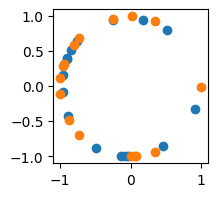

 16%|████████████▊                                                                   | 801/5000 [00:32<03:20, 20.91it/s]

Epoch: 801, Loss: 0.1261025071144104
Epoch: 802, Loss: 0.10918797552585602


 16%|████████████▊                                                                   | 804/5000 [00:33<03:15, 21.41it/s]

Epoch: 803, Loss: 0.11495684832334518
Epoch: 804, Loss: 0.12431764602661133
Epoch: 805, Loss: 0.12132410705089569


 16%|████████████▉                                                                   | 807/5000 [00:33<03:08, 22.29it/s]

Epoch: 806, Loss: 0.1118193194270134
Epoch: 807, Loss: 0.1490321159362793


 16%|████████████▉                                                                   | 810/5000 [00:33<03:07, 22.32it/s]

Epoch: 808, Loss: 0.12702099978923798
Epoch: 809, Loss: 0.13663044571876526
Epoch: 810, Loss: 0.12078744918107986


 16%|█████████████                                                                   | 813/5000 [00:33<03:06, 22.46it/s]

Epoch: 811, Loss: 0.13523633778095245
Epoch: 812, Loss: 0.1226184219121933


 16%|█████████████                                                                   | 816/5000 [00:33<03:01, 23.03it/s]

Epoch: 813, Loss: 0.1527775526046753
Epoch: 814, Loss: 0.12027204781770706
Epoch: 815, Loss: 0.1652107536792755


 16%|█████████████                                                                   | 819/5000 [00:33<02:59, 23.33it/s]

Epoch: 816, Loss: 0.12729546427726746
Epoch: 817, Loss: 0.13302549719810486
Epoch: 818, Loss: 0.12158748507499695


 16%|█████████████▏                                                                  | 822/5000 [00:33<02:56, 23.73it/s]

Epoch: 819, Loss: 0.11080516129732132
Epoch: 820, Loss: 0.149551123380661
Epoch: 821, Loss: 0.12062966823577881


 16%|█████████████▏                                                                  | 825/5000 [00:33<02:55, 23.80it/s]

Epoch: 822, Loss: 0.15207043290138245
Epoch: 823, Loss: 0.12666739523410797
Epoch: 824, Loss: 0.15491145849227905
Epoch: 825, Loss: 0.11334977298974991
Epoch: 826, Loss: 0.13644590973854065


 17%|█████████████▎                                                                  | 831/5000 [00:34<02:50, 24.42it/s]

Epoch: 827, Loss: 0.11870037019252777
Epoch: 828, Loss: 0.13222049176692963
Epoch: 829, Loss: 0.11631622910499573
Epoch: 830, Loss: 0.1458277702331543
Epoch: 831, Loss: 0.1275857537984848


 17%|█████████████▎                                                                  | 834/5000 [00:34<02:53, 24.01it/s]

Epoch: 832, Loss: 0.12019932270050049
Epoch: 833, Loss: 0.1373830884695053
Epoch: 834, Loss: 0.12280786037445068
Epoch: 835, Loss: 0.11942589282989502


 17%|█████████████▍                                                                  | 837/5000 [00:34<02:50, 24.43it/s]

Epoch: 836, Loss: 0.13315878808498383


 17%|█████████████▍                                                                  | 840/5000 [00:34<02:55, 23.71it/s]

Epoch: 837, Loss: 0.1218319907784462
Epoch: 838, Loss: 0.11093507707118988
Epoch: 839, Loss: 0.14352087676525116
Epoch: 840, Loss: 0.12364225089550018
Epoch: 841, Loss: 0.12565389275550842


 17%|█████████████▌                                                                  | 846/5000 [00:34<02:52, 24.06it/s]

Epoch: 842, Loss: 0.1327964812517166
Epoch: 843, Loss: 0.1298629194498062
Epoch: 844, Loss: 0.12516656517982483
Epoch: 845, Loss: 0.1131584644317627
Epoch: 846, Loss: 0.11494380980730057


 17%|█████████████▋                                                                  | 852/5000 [00:35<02:50, 24.33it/s]

Epoch: 847, Loss: 0.15326620638370514
Epoch: 848, Loss: 0.13753864169120789
Epoch: 849, Loss: 0.11994531005620956
Epoch: 850, Loss: 0.1317407488822937
Epoch: 851, Loss: 0.13935627043247223
Epoch: 852, Loss: 0.11906153708696365


 17%|█████████████▋                                                                  | 858/5000 [00:35<02:46, 24.93it/s]

Epoch: 853, Loss: 0.1249065101146698
Epoch: 854, Loss: 0.11543118953704834
Epoch: 855, Loss: 0.1319820135831833
Epoch: 856, Loss: 0.14720578491687775
Epoch: 857, Loss: 0.11939973384141922
Epoch: 858, Loss: 0.11690759658813477


 17%|█████████████▊                                                                  | 861/5000 [00:35<02:52, 24.03it/s]

Epoch: 859, Loss: 0.11342556774616241
Epoch: 860, Loss: 0.1499490737915039
Epoch: 861, Loss: 0.12156575173139572
Epoch: 862, Loss: 0.11973261833190918


 17%|█████████████▊                                                                  | 864/5000 [00:35<02:48, 24.51it/s]

Epoch: 863, Loss: 0.13130058348178864


 17%|█████████████▊                                                                  | 867/5000 [00:35<02:53, 23.89it/s]

Epoch: 864, Loss: 0.11721798032522202
Epoch: 865, Loss: 0.10571915656328201
Epoch: 866, Loss: 0.14297790825366974
Epoch: 867, Loss: 0.13506443798542023
Epoch: 868, Loss: 0.14567843079566956


 17%|█████████████▉                                                                  | 873/5000 [00:35<02:48, 24.43it/s]

Epoch: 869, Loss: 0.12857677042484283
Epoch: 870, Loss: 0.11684805154800415
Epoch: 871, Loss: 0.10593488812446594
Epoch: 872, Loss: 0.11643648147583008
Epoch: 873, Loss: 0.1295507252216339
Epoch: 874, Loss: 0.11455374956130981


 18%|██████████████                                                                  | 879/5000 [00:36<02:45, 24.92it/s]

Epoch: 875, Loss: 0.13861332833766937
Epoch: 876, Loss: 0.125529944896698
Epoch: 877, Loss: 0.13013440370559692
Epoch: 878, Loss: 0.11315714567899704
Epoch: 879, Loss: 0.14857017993927002


 18%|██████████████▏                                                                 | 885/5000 [00:36<02:43, 25.18it/s]

Epoch: 880, Loss: 0.13290266692638397
Epoch: 881, Loss: 0.11747926473617554
Epoch: 882, Loss: 0.10772751271724701
Epoch: 883, Loss: 0.13168299198150635
Epoch: 884, Loss: 0.12690004706382751
Epoch: 885, Loss: 0.11932908743619919


 18%|██████████████▎                                                                 | 891/5000 [00:36<02:45, 24.85it/s]

Epoch: 886, Loss: 0.1158122792840004
Epoch: 887, Loss: 0.11782495677471161
Epoch: 888, Loss: 0.1315125674009323
Epoch: 889, Loss: 0.1457931399345398
Epoch: 890, Loss: 0.11029106378555298
Epoch: 891, Loss: 0.11524605751037598


 18%|██████████████▎                                                                 | 897/5000 [00:36<02:44, 24.99it/s]

Epoch: 892, Loss: 0.12609738111495972
Epoch: 893, Loss: 0.12294494360685349
Epoch: 894, Loss: 0.11782936006784439
Epoch: 895, Loss: 0.14315925538539886
Epoch: 896, Loss: 0.14094258844852448
Epoch: 897, Loss: 0.12634989619255066


 18%|██████████████▍                                                                 | 903/5000 [00:37<02:43, 25.12it/s]

Epoch: 898, Loss: 0.1271311193704605
Epoch: 899, Loss: 0.11399073898792267
Epoch: 900, Loss: 0.11913004517555237
Epoch: 901, Loss: 0.14316695928573608
Epoch: 902, Loss: 0.12076354026794434
Epoch: 903, Loss: 0.11892358958721161


 18%|██████████████▌                                                                 | 909/5000 [00:37<02:38, 25.83it/s]

Epoch: 904, Loss: 0.11704985797405243
Epoch: 905, Loss: 0.1227724626660347
Epoch: 906, Loss: 0.11310042440891266
Epoch: 907, Loss: 0.14235617220401764
Epoch: 908, Loss: 0.12718996405601501
Epoch: 909, Loss: 0.12210312485694885


 18%|██████████████▋                                                                 | 915/5000 [00:37<02:39, 25.55it/s]

Epoch: 910, Loss: 0.11698780208826065
Epoch: 911, Loss: 0.11848992854356766
Epoch: 912, Loss: 0.12632182240486145
Epoch: 913, Loss: 0.12270929664373398
Epoch: 914, Loss: 0.12307682633399963
Epoch: 915, Loss: 0.12822353839874268


 18%|██████████████▋                                                                 | 921/5000 [00:37<02:41, 25.29it/s]

Epoch: 916, Loss: 0.1114838570356369
Epoch: 917, Loss: 0.13758081197738647
Epoch: 918, Loss: 0.1232914924621582
Epoch: 919, Loss: 0.12114337831735611
Epoch: 920, Loss: 0.1227816641330719
Epoch: 921, Loss: 0.11539342999458313


 19%|██████████████▊                                                                 | 927/5000 [00:38<02:40, 25.38it/s]

Epoch: 922, Loss: 0.12262430787086487
Epoch: 923, Loss: 0.11871274560689926
Epoch: 924, Loss: 0.11475187540054321
Epoch: 925, Loss: 0.12168270349502563
Epoch: 926, Loss: 0.12640468776226044
Epoch: 927, Loss: 0.12778134644031525


 19%|██████████████▉                                                                 | 933/5000 [00:38<02:39, 25.44it/s]

Epoch: 928, Loss: 0.11531081795692444
Epoch: 929, Loss: 0.1375306248664856
Epoch: 930, Loss: 0.13542960584163666
Epoch: 931, Loss: 0.12354600429534912
Epoch: 932, Loss: 0.1391109824180603
Epoch: 933, Loss: 0.12571443617343903


 19%|███████████████                                                                 | 939/5000 [00:38<02:44, 24.74it/s]

Epoch: 934, Loss: 0.11276116967201233
Epoch: 935, Loss: 0.11804203689098358
Epoch: 936, Loss: 0.13213567435741425
Epoch: 937, Loss: 0.1236102283000946
Epoch: 938, Loss: 0.12262911349534988


 19%|███████████████                                                                 | 945/5000 [00:38<02:42, 24.92it/s]

Epoch: 939, Loss: 0.12427166104316711
Epoch: 940, Loss: 0.11194124072790146
Epoch: 941, Loss: 0.12530581653118134
Epoch: 942, Loss: 0.11627331376075745
Epoch: 943, Loss: 0.11505885422229767
Epoch: 944, Loss: 0.11210963129997253


 19%|███████████████▏                                                                | 951/5000 [00:39<02:38, 25.49it/s]

Epoch: 945, Loss: 0.13282370567321777
Epoch: 946, Loss: 0.11910158395767212
Epoch: 947, Loss: 0.1260649561882019
Epoch: 948, Loss: 0.1240752786397934
Epoch: 949, Loss: 0.11127019673585892
Epoch: 950, Loss: 0.1290993094444275


 19%|███████████████▎                                                                | 957/5000 [00:39<02:36, 25.91it/s]

Epoch: 951, Loss: 0.12568415701389313
Epoch: 952, Loss: 0.12006770819425583
Epoch: 953, Loss: 0.12723097205162048
Epoch: 954, Loss: 0.12646088004112244
Epoch: 955, Loss: 0.11806704849004745
Epoch: 956, Loss: 0.1141137033700943


 19%|███████████████▍                                                                | 963/5000 [00:39<02:37, 25.66it/s]

Epoch: 957, Loss: 0.12370693683624268
Epoch: 958, Loss: 0.11976667493581772
Epoch: 959, Loss: 0.12340513616800308
Epoch: 960, Loss: 0.11790022999048233
Epoch: 961, Loss: 0.12463251501321793
Epoch: 962, Loss: 0.13066476583480835


 19%|███████████████▌                                                                | 969/5000 [00:39<02:40, 25.15it/s]

Epoch: 963, Loss: 0.12421975284814835
Epoch: 964, Loss: 0.1341194212436676
Epoch: 965, Loss: 0.11728990077972412
Epoch: 966, Loss: 0.12287533283233643
Epoch: 967, Loss: 0.13219279050827026
Epoch: 968, Loss: 0.12122099101543427


 20%|███████████████▌                                                                | 975/5000 [00:39<02:41, 24.85it/s]

Epoch: 969, Loss: 0.10965608060359955
Epoch: 970, Loss: 0.11463140696287155
Epoch: 971, Loss: 0.13502167165279388
Epoch: 972, Loss: 0.12964867055416107
Epoch: 973, Loss: 0.13027580082416534
Epoch: 974, Loss: 0.1212000921368599


 20%|███████████████▋                                                                | 981/5000 [00:40<02:41, 24.81it/s]

Epoch: 975, Loss: 0.12512917816638947
Epoch: 976, Loss: 0.1262642741203308
Epoch: 977, Loss: 0.11419429630041122
Epoch: 978, Loss: 0.11763293296098709
Epoch: 979, Loss: 0.11841233819723129
Epoch: 980, Loss: 0.1257857382297516


 20%|███████████████▊                                                                | 987/5000 [00:40<02:40, 24.97it/s]

Epoch: 981, Loss: 0.13016459345817566
Epoch: 982, Loss: 0.12203282117843628
Epoch: 983, Loss: 0.13766667246818542
Epoch: 984, Loss: 0.11318223923444748
Epoch: 985, Loss: 0.12209615856409073
Epoch: 986, Loss: 0.12672896683216095


 20%|███████████████▉                                                                | 993/5000 [00:40<02:42, 24.62it/s]

Epoch: 987, Loss: 0.1529357135295868
Epoch: 988, Loss: 0.11915446817874908
Epoch: 989, Loss: 0.14312201738357544
Epoch: 990, Loss: 0.1252589076757431
Epoch: 991, Loss: 0.158061683177948
Epoch: 992, Loss: 0.128738671541214


 20%|███████████████▉                                                                | 996/5000 [00:40<02:46, 24.02it/s]

Epoch: 993, Loss: 0.1138918399810791
Epoch: 994, Loss: 0.12301026284694672
Epoch: 995, Loss: 0.1174439787864685
Epoch: 996, Loss: 0.1252572238445282
Epoch: 997, Loss: 0.1537858545780182


 20%|███████████████▉                                                                | 999/5000 [00:40<02:45, 24.14it/s]

Epoch: 998, Loss: 0.14042630791664124
Epoch: 999, Loss: 0.12018454074859619
Epoch: 1000, Loss: 0.11485005915164948


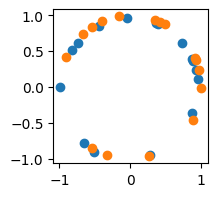

 20%|███████████████▉                                                               | 1005/5000 [00:41<03:02, 21.87it/s]

Epoch: 1001, Loss: 0.11443395167589188
Epoch: 1002, Loss: 0.13697394728660583
Epoch: 1003, Loss: 0.12143214046955109
Epoch: 1004, Loss: 0.110711470246315
Epoch: 1005, Loss: 0.12172318249940872
Epoch: 1006, Loss: 0.11277410387992859


 20%|███████████████▉                                                               | 1011/5000 [00:41<02:48, 23.74it/s]

Epoch: 1007, Loss: 0.10635398328304291
Epoch: 1008, Loss: 0.11697022616863251
Epoch: 1009, Loss: 0.13666628301143646
Epoch: 1010, Loss: 0.1333085596561432
Epoch: 1011, Loss: 0.15787047147750854
Epoch: 1012, Loss: 0.12873783707618713


 20%|████████████████                                                               | 1017/5000 [00:41<02:39, 24.94it/s]

Epoch: 1013, Loss: 0.12931281328201294
Epoch: 1014, Loss: 0.1356341391801834
Epoch: 1015, Loss: 0.115456223487854
Epoch: 1016, Loss: 0.11869535595178604
Epoch: 1017, Loss: 0.14197938144207
Epoch: 1018, Loss: 0.12597548961639404


 20%|████████████████▏                                                              | 1023/5000 [00:41<02:37, 25.28it/s]

Epoch: 1019, Loss: 0.12289430946111679
Epoch: 1020, Loss: 0.11466655880212784
Epoch: 1021, Loss: 0.1453092098236084
Epoch: 1022, Loss: 0.11732189357280731
Epoch: 1023, Loss: 0.1379699856042862
Epoch: 1024, Loss: 0.13885022699832916


 21%|████████████████▎                                                              | 1029/5000 [00:42<02:41, 24.63it/s]

Epoch: 1025, Loss: 0.10999777913093567
Epoch: 1026, Loss: 0.13459043204784393
Epoch: 1027, Loss: 0.13180503249168396
Epoch: 1028, Loss: 0.13506826758384705
Epoch: 1029, Loss: 0.11237795650959015


 21%|████████████████▎                                                              | 1035/5000 [00:42<02:44, 24.10it/s]

Epoch: 1030, Loss: 0.13595421612262726
Epoch: 1031, Loss: 0.11550195515155792
Epoch: 1032, Loss: 0.13640892505645752
Epoch: 1033, Loss: 0.12466971576213837
Epoch: 1034, Loss: 0.13520017266273499


 21%|████████████████▍                                                              | 1038/5000 [00:42<02:47, 23.72it/s]

Epoch: 1035, Loss: 0.12978139519691467
Epoch: 1036, Loss: 0.12338703870773315
Epoch: 1037, Loss: 0.12799739837646484
Epoch: 1038, Loss: 0.12695430219173431
Epoch: 1039, Loss: 0.12998554110527039


 21%|████████████████▍                                                              | 1044/5000 [00:42<02:41, 24.48it/s]

Epoch: 1040, Loss: 0.11977928876876831
Epoch: 1041, Loss: 0.11944692581892014
Epoch: 1042, Loss: 0.1232106015086174
Epoch: 1043, Loss: 0.1191202700138092
Epoch: 1044, Loss: 0.13324081897735596
Epoch: 1045, Loss: 0.15166479349136353


 21%|████████████████▌                                                              | 1050/5000 [00:43<02:40, 24.65it/s]

Epoch: 1046, Loss: 0.13521501421928406
Epoch: 1047, Loss: 0.11990288645029068
Epoch: 1048, Loss: 0.11373651772737503
Epoch: 1049, Loss: 0.13424155116081238
Epoch: 1050, Loss: 0.1395845264196396
Epoch: 1051, Loss: 0.10858253389596939


 21%|████████████████▋                                                              | 1056/5000 [00:43<02:55, 22.47it/s]

Epoch: 1052, Loss: 0.12140057235956192
Epoch: 1053, Loss: 0.13074873387813568
Epoch: 1054, Loss: 0.1271567940711975
Epoch: 1055, Loss: 0.1465480774641037


 21%|████████████████▋                                                              | 1059/5000 [00:43<03:07, 21.04it/s]

Epoch: 1056, Loss: 0.12400468438863754
Epoch: 1057, Loss: 0.13920502364635468
Epoch: 1058, Loss: 0.11421501636505127
Epoch: 1059, Loss: 0.1280289590358734
Epoch: 1060, Loss: 0.11426489055156708


 21%|████████████████▊                                                              | 1065/5000 [00:43<03:00, 21.85it/s]

Epoch: 1061, Loss: 0.1390533745288849
Epoch: 1062, Loss: 0.12146086990833282
Epoch: 1063, Loss: 0.11664865165948868
Epoch: 1064, Loss: 0.11551571637392044
Epoch: 1065, Loss: 0.12794137001037598


 21%|████████████████▉                                                              | 1071/5000 [00:44<02:44, 23.92it/s]

Epoch: 1066, Loss: 0.12077872455120087
Epoch: 1067, Loss: 0.14061900973320007
Epoch: 1068, Loss: 0.11370288580656052
Epoch: 1069, Loss: 0.13142749667167664
Epoch: 1070, Loss: 0.12801450490951538
Epoch: 1071, Loss: 0.11726675927639008


 22%|█████████████████                                                              | 1077/5000 [00:44<02:45, 23.69it/s]

Epoch: 1072, Loss: 0.10684099793434143
Epoch: 1073, Loss: 0.11531326174736023
Epoch: 1074, Loss: 0.12230901420116425
Epoch: 1075, Loss: 0.1156269758939743
Epoch: 1076, Loss: 0.11572012305259705


 22%|█████████████████                                                              | 1083/5000 [00:44<02:43, 23.97it/s]

Epoch: 1077, Loss: 0.12966498732566833
Epoch: 1078, Loss: 0.12291254103183746
Epoch: 1079, Loss: 0.1234569400548935
Epoch: 1080, Loss: 0.1286395788192749
Epoch: 1081, Loss: 0.11367630958557129
Epoch: 1082, Loss: 0.12249163538217545


 22%|█████████████████▏                                                             | 1086/5000 [00:44<02:43, 23.90it/s]

Epoch: 1083, Loss: 0.11932194232940674
Epoch: 1084, Loss: 0.11782095581293106
Epoch: 1085, Loss: 0.12116044014692307
Epoch: 1086, Loss: 0.11928761005401611
Epoch: 1087, Loss: 0.14646489918231964


 22%|█████████████████▎                                                             | 1092/5000 [00:44<02:48, 23.26it/s]

Epoch: 1088, Loss: 0.12393148988485336
Epoch: 1089, Loss: 0.12488530576229095
Epoch: 1090, Loss: 0.13037484884262085
Epoch: 1091, Loss: 0.12887686491012573
Epoch: 1092, Loss: 0.13361825048923492


 22%|█████████████████▎                                                             | 1098/5000 [00:45<02:48, 23.15it/s]

Epoch: 1093, Loss: 0.11672616004943848
Epoch: 1094, Loss: 0.13007327914237976
Epoch: 1095, Loss: 0.11313813924789429
Epoch: 1096, Loss: 0.12574025988578796
Epoch: 1097, Loss: 0.1063702255487442


 22%|█████████████████▍                                                             | 1101/5000 [00:45<02:45, 23.51it/s]

Epoch: 1098, Loss: 0.12220413982868195
Epoch: 1099, Loss: 0.12894567847251892
Epoch: 1100, Loss: 0.11500690132379532
Epoch: 1101, Loss: 0.1200793907046318
Epoch: 1102, Loss: 0.12728697061538696


 22%|█████████████████▍                                                             | 1107/5000 [00:45<02:45, 23.52it/s]

Epoch: 1103, Loss: 0.12383919209241867
Epoch: 1104, Loss: 0.1341700255870819
Epoch: 1105, Loss: 0.12798044085502625
Epoch: 1106, Loss: 0.13279524445533752
Epoch: 1107, Loss: 0.12178703397512436


 22%|█████████████████▌                                                             | 1113/5000 [00:45<02:49, 22.97it/s]

Epoch: 1108, Loss: 0.1273936778306961
Epoch: 1109, Loss: 0.11310383677482605
Epoch: 1110, Loss: 0.11523333191871643
Epoch: 1111, Loss: 0.11693165451288223
Epoch: 1112, Loss: 0.11536526679992676


 22%|█████████████████▋                                                             | 1116/5000 [00:46<02:48, 23.09it/s]

Epoch: 1113, Loss: 0.12498350441455841
Epoch: 1114, Loss: 0.11797723174095154
Epoch: 1115, Loss: 0.1150238886475563
Epoch: 1116, Loss: 0.12831711769104004
Epoch: 1117, Loss: 0.13097092509269714


 22%|█████████████████▋                                                             | 1122/5000 [00:46<02:42, 23.93it/s]

Epoch: 1118, Loss: 0.1346973180770874
Epoch: 1119, Loss: 0.1199927106499672
Epoch: 1120, Loss: 0.1252337545156479
Epoch: 1121, Loss: 0.12121547758579254
Epoch: 1122, Loss: 0.12811298668384552
Epoch: 1123, Loss: 0.12380073964595795


 23%|█████████████████▊                                                             | 1128/5000 [00:46<02:35, 24.87it/s]

Epoch: 1124, Loss: 0.1074168011546135
Epoch: 1125, Loss: 0.10813514143228531
Epoch: 1126, Loss: 0.11064691096544266
Epoch: 1127, Loss: 0.11488279700279236
Epoch: 1128, Loss: 0.1028393805027008
Epoch: 1129, Loss: 0.1185791864991188


 23%|█████████████████▉                                                             | 1134/5000 [00:46<02:33, 25.20it/s]

Epoch: 1130, Loss: 0.14789974689483643
Epoch: 1131, Loss: 0.12003281712532043
Epoch: 1132, Loss: 0.1282208114862442
Epoch: 1133, Loss: 0.12151850759983063
Epoch: 1134, Loss: 0.15575116872787476
Epoch: 1135, Loss: 0.1216290295124054


 23%|██████████████████                                                             | 1140/5000 [00:46<02:31, 25.44it/s]

Epoch: 1136, Loss: 0.11797817051410675
Epoch: 1137, Loss: 0.11586463451385498
Epoch: 1138, Loss: 0.1262722909450531
Epoch: 1139, Loss: 0.11470124125480652
Epoch: 1140, Loss: 0.11172991245985031
Epoch: 1141, Loss: 0.10409637540578842


 23%|██████████████████                                                             | 1146/5000 [00:47<02:33, 25.11it/s]

Epoch: 1142, Loss: 0.12721437215805054
Epoch: 1143, Loss: 0.11403276026248932
Epoch: 1144, Loss: 0.12905503809452057
Epoch: 1145, Loss: 0.12253701686859131
Epoch: 1146, Loss: 0.13305997848510742
Epoch: 1147, Loss: 0.12283489108085632


 23%|██████████████████▏                                                            | 1152/5000 [00:47<02:31, 25.46it/s]

Epoch: 1148, Loss: 0.11312109231948853
Epoch: 1149, Loss: 0.12312392145395279
Epoch: 1150, Loss: 0.12119877338409424
Epoch: 1151, Loss: 0.12562420964241028
Epoch: 1152, Loss: 0.12097366899251938
Epoch: 1153, Loss: 0.1353515088558197


 23%|██████████████████▎                                                            | 1158/5000 [00:47<02:32, 25.24it/s]

Epoch: 1154, Loss: 0.13316012918949127
Epoch: 1155, Loss: 0.12032440304756165
Epoch: 1156, Loss: 0.11082850396633148
Epoch: 1157, Loss: 0.11887489259243011
Epoch: 1158, Loss: 0.12957258522510529
Epoch: 1159, Loss: 0.11679216474294662


 23%|██████████████████▍                                                            | 1164/5000 [00:47<02:30, 25.43it/s]

Epoch: 1160, Loss: 0.12512733042240143
Epoch: 1161, Loss: 0.11187499761581421
Epoch: 1162, Loss: 0.12626953423023224
Epoch: 1163, Loss: 0.12233901768922806
Epoch: 1164, Loss: 0.12326686829328537
Epoch: 1165, Loss: 0.1420668661594391


 23%|██████████████████▍                                                            | 1170/5000 [00:48<02:30, 25.51it/s]

Epoch: 1166, Loss: 0.1146814227104187
Epoch: 1167, Loss: 0.13047605752944946
Epoch: 1168, Loss: 0.12017549574375153
Epoch: 1169, Loss: 0.11178208142518997
Epoch: 1170, Loss: 0.12283004075288773
Epoch: 1171, Loss: 0.1500691920518875


 24%|██████████████████▌                                                            | 1176/5000 [00:48<02:30, 25.40it/s]

Epoch: 1172, Loss: 0.12036708742380142
Epoch: 1173, Loss: 0.10904333740472794
Epoch: 1174, Loss: 0.12247201800346375
Epoch: 1175, Loss: 0.14109113812446594
Epoch: 1176, Loss: 0.11470431089401245
Epoch: 1177, Loss: 0.12852594256401062


 24%|██████████████████▋                                                            | 1182/5000 [00:48<02:30, 25.41it/s]

Epoch: 1178, Loss: 0.11963210999965668
Epoch: 1179, Loss: 0.1261729598045349
Epoch: 1180, Loss: 0.13178184628486633
Epoch: 1181, Loss: 0.13532055914402008
Epoch: 1182, Loss: 0.10917293280363083
Epoch: 1183, Loss: 0.1136779934167862


 24%|██████████████████▊                                                            | 1188/5000 [00:48<02:27, 25.82it/s]

Epoch: 1184, Loss: 0.14615574479103088
Epoch: 1185, Loss: 0.1181224137544632
Epoch: 1186, Loss: 0.12325369566679001
Epoch: 1187, Loss: 0.12986406683921814
Epoch: 1188, Loss: 0.11490310728549957
Epoch: 1189, Loss: 0.13311034440994263


 24%|██████████████████▊                                                            | 1194/5000 [00:49<02:33, 24.80it/s]

Epoch: 1190, Loss: 0.11119777709245682
Epoch: 1191, Loss: 0.12247220426797867
Epoch: 1192, Loss: 0.1341266930103302
Epoch: 1193, Loss: 0.11321413516998291
Epoch: 1194, Loss: 0.1272992342710495


 24%|██████████████████▉                                                            | 1200/5000 [00:49<02:31, 25.03it/s]

Epoch: 1195, Loss: 0.14499245584011078
Epoch: 1196, Loss: 0.12558522820472717
Epoch: 1197, Loss: 0.12582994997501373
Epoch: 1198, Loss: 0.14216196537017822
Epoch: 1199, Loss: 0.12248235940933228
Epoch: 1200, Loss: 0.1230832189321518


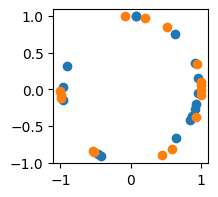

 24%|███████████████████                                                            | 1206/5000 [00:49<02:49, 22.36it/s]

Epoch: 1201, Loss: 0.11444882303476334
Epoch: 1202, Loss: 0.14125017821788788
Epoch: 1203, Loss: 0.12749351561069489
Epoch: 1204, Loss: 0.12066159397363663
Epoch: 1205, Loss: 0.1386081576347351
Epoch: 1206, Loss: 0.11722955107688904


 24%|███████████████████▏                                                           | 1212/5000 [00:49<02:49, 22.41it/s]

Epoch: 1207, Loss: 0.13828636705875397
Epoch: 1208, Loss: 0.11014169454574585
Epoch: 1209, Loss: 0.11762097477912903
Epoch: 1210, Loss: 0.12393287569284439
Epoch: 1211, Loss: 0.11612485349178314


 24%|███████████████████▏                                                           | 1218/5000 [00:50<02:38, 23.79it/s]

Epoch: 1212, Loss: 0.125238835811615
Epoch: 1213, Loss: 0.12100321054458618
Epoch: 1214, Loss: 0.13199850916862488
Epoch: 1215, Loss: 0.13193650543689728
Epoch: 1216, Loss: 0.11861170083284378
Epoch: 1217, Loss: 0.1202135905623436


 24%|███████████████████▎                                                           | 1221/5000 [00:50<02:44, 22.94it/s]

Epoch: 1218, Loss: 0.12014530599117279
Epoch: 1219, Loss: 0.12316404283046722
Epoch: 1220, Loss: 0.1276273876428604
Epoch: 1221, Loss: 0.13254593312740326
Epoch: 1222, Loss: 0.13683448731899261


 25%|███████████████████▍                                                           | 1227/5000 [00:50<02:43, 23.13it/s]

Epoch: 1223, Loss: 0.11232539266347885
Epoch: 1224, Loss: 0.13124427199363708
Epoch: 1225, Loss: 0.13061650097370148
Epoch: 1226, Loss: 0.11669694632291794
Epoch: 1227, Loss: 0.12327868491411209
Epoch: 1228, Loss: 0.13256096839904785


 25%|███████████████████▍                                                           | 1233/5000 [00:50<02:39, 23.55it/s]

Epoch: 1229, Loss: 0.11660519242286682
Epoch: 1230, Loss: 0.1134302169084549
Epoch: 1231, Loss: 0.1280273199081421
Epoch: 1232, Loss: 0.10994579643011093
Epoch: 1233, Loss: 0.10953404009342194


 25%|███████████████████▌                                                           | 1239/5000 [00:51<02:38, 23.68it/s]

Epoch: 1234, Loss: 0.12513510882854462
Epoch: 1235, Loss: 0.1371808648109436
Epoch: 1236, Loss: 0.11411329358816147
Epoch: 1237, Loss: 0.11977812647819519
Epoch: 1238, Loss: 0.11886283755302429


 25%|███████████████████▌                                                           | 1242/5000 [00:51<02:37, 23.79it/s]

Epoch: 1239, Loss: 0.11245851218700409
Epoch: 1240, Loss: 0.11874392628669739
Epoch: 1241, Loss: 0.1300770491361618
Epoch: 1242, Loss: 0.11989416182041168
Epoch: 1243, Loss: 0.11337853223085403


 25%|███████████████████▋                                                           | 1248/5000 [00:51<02:34, 24.32it/s]

Epoch: 1244, Loss: 0.14076408743858337
Epoch: 1245, Loss: 0.12448656558990479
Epoch: 1246, Loss: 0.12246045470237732
Epoch: 1247, Loss: 0.1144617572426796
Epoch: 1248, Loss: 0.11286059767007828


 25%|███████████████████▊                                                           | 1254/5000 [00:51<02:31, 24.74it/s]

Epoch: 1249, Loss: 0.11593899130821228
Epoch: 1250, Loss: 0.13107571005821228
Epoch: 1251, Loss: 0.11952221393585205
Epoch: 1252, Loss: 0.12535065412521362
Epoch: 1253, Loss: 0.13664637506008148
Epoch: 1254, Loss: 0.10812701284885406


 25%|███████████████████▉                                                           | 1260/5000 [00:51<02:31, 24.61it/s]

Epoch: 1255, Loss: 0.12081398069858551
Epoch: 1256, Loss: 0.12318279594182968
Epoch: 1257, Loss: 0.12684322893619537
Epoch: 1258, Loss: 0.11915993690490723
Epoch: 1259, Loss: 0.12126873433589935
Epoch: 1260, Loss: 0.11065031588077545


 25%|████████████████████                                                           | 1266/5000 [00:52<02:28, 25.15it/s]

Epoch: 1261, Loss: 0.15525035560131073
Epoch: 1262, Loss: 0.11620444059371948
Epoch: 1263, Loss: 0.12993696331977844
Epoch: 1264, Loss: 0.11791665852069855
Epoch: 1265, Loss: 0.1167624294757843
Epoch: 1266, Loss: 0.11904245615005493


 25%|████████████████████                                                           | 1272/5000 [00:52<02:27, 25.24it/s]

Epoch: 1267, Loss: 0.10794136673212051
Epoch: 1268, Loss: 0.11519454419612885
Epoch: 1269, Loss: 0.13436752557754517
Epoch: 1270, Loss: 0.13743871450424194
Epoch: 1271, Loss: 0.12103335559368134
Epoch: 1272, Loss: 0.12404492497444153


 26%|████████████████████▏                                                          | 1278/5000 [00:52<02:30, 24.68it/s]

Epoch: 1273, Loss: 0.1428043097257614
Epoch: 1274, Loss: 0.12160752713680267
Epoch: 1275, Loss: 0.12459051609039307
Epoch: 1276, Loss: 0.11940189450979233
Epoch: 1277, Loss: 0.1209341511130333


 26%|████████████████████▎                                                          | 1284/5000 [00:52<02:24, 25.65it/s]

Epoch: 1278, Loss: 0.1265799105167389
Epoch: 1279, Loss: 0.12181073427200317
Epoch: 1280, Loss: 0.13048957288265228
Epoch: 1281, Loss: 0.1321343630552292
Epoch: 1282, Loss: 0.11996913701295853
Epoch: 1283, Loss: 0.13041768968105316


 26%|████████████████████▍                                                          | 1290/5000 [00:53<02:21, 26.20it/s]

Epoch: 1284, Loss: 0.14642199873924255
Epoch: 1285, Loss: 0.11410577595233917
Epoch: 1286, Loss: 0.12716072797775269
Epoch: 1287, Loss: 0.1357656866312027
Epoch: 1288, Loss: 0.13383108377456665
Epoch: 1289, Loss: 0.11567869782447815


 26%|████████████████████▍                                                          | 1293/5000 [00:53<02:22, 26.10it/s]

Epoch: 1290, Loss: 0.13608495891094208
Epoch: 1291, Loss: 0.1276175081729889
Epoch: 1292, Loss: 0.133209228515625
Epoch: 1293, Loss: 0.1191757321357727
Epoch: 1294, Loss: 0.11180850863456726
Epoch: 1295, Loss: 0.12043455988168716


 26%|████████████████████▌                                                          | 1302/5000 [00:53<02:27, 25.00it/s]

Epoch: 1296, Loss: 0.11188957095146179
Epoch: 1297, Loss: 0.13678096234798431
Epoch: 1298, Loss: 0.12338016927242279
Epoch: 1299, Loss: 0.13392364978790283
Epoch: 1300, Loss: 0.12470761686563492
Epoch: 1301, Loss: 0.12190611660480499


 26%|████████████████████▋                                                          | 1308/5000 [00:53<02:28, 24.90it/s]

Epoch: 1302, Loss: 0.11771706491708755
Epoch: 1303, Loss: 0.1255672127008438
Epoch: 1304, Loss: 0.11048315465450287
Epoch: 1305, Loss: 0.13132597506046295
Epoch: 1306, Loss: 0.11401950567960739
Epoch: 1307, Loss: 0.10982122272253036


 26%|████████████████████▊                                                          | 1314/5000 [00:54<02:26, 25.17it/s]

Epoch: 1308, Loss: 0.11443816125392914
Epoch: 1309, Loss: 0.11601068824529648
Epoch: 1310, Loss: 0.11324525624513626
Epoch: 1311, Loss: 0.1300494223833084
Epoch: 1312, Loss: 0.12882614135742188
Epoch: 1313, Loss: 0.1147826761007309


 26%|████████████████████▊                                                          | 1320/5000 [00:54<02:24, 25.40it/s]

Epoch: 1314, Loss: 0.10994678735733032
Epoch: 1315, Loss: 0.150192528963089
Epoch: 1316, Loss: 0.11921775341033936
Epoch: 1317, Loss: 0.16738295555114746
Epoch: 1318, Loss: 0.12068778276443481
Epoch: 1319, Loss: 0.1250012069940567


 27%|████████████████████▉                                                          | 1326/5000 [00:54<02:25, 25.25it/s]

Epoch: 1320, Loss: 0.13940706849098206
Epoch: 1321, Loss: 0.11976315081119537
Epoch: 1322, Loss: 0.12396970391273499
Epoch: 1323, Loss: 0.12062287330627441
Epoch: 1324, Loss: 0.12039824575185776
Epoch: 1325, Loss: 0.12365502119064331


 27%|█████████████████████                                                          | 1332/5000 [00:54<02:24, 25.40it/s]

Epoch: 1326, Loss: 0.11319515854120255
Epoch: 1327, Loss: 0.12376099824905396
Epoch: 1328, Loss: 0.13082176446914673
Epoch: 1329, Loss: 0.12299155443906784
Epoch: 1330, Loss: 0.11707717180252075
Epoch: 1331, Loss: 0.123667873442173


 27%|█████████████████████▏                                                         | 1338/5000 [00:55<02:24, 25.41it/s]

Epoch: 1332, Loss: 0.14761003851890564
Epoch: 1333, Loss: 0.11689019203186035
Epoch: 1334, Loss: 0.12187186628580093
Epoch: 1335, Loss: 0.13608717918395996
Epoch: 1336, Loss: 0.13553926348686218
Epoch: 1337, Loss: 0.12189057469367981


 27%|█████████████████████▏                                                         | 1344/5000 [00:55<02:19, 26.18it/s]

Epoch: 1338, Loss: 0.12604917585849762
Epoch: 1339, Loss: 0.11170025914907455
Epoch: 1340, Loss: 0.11320062726736069
Epoch: 1341, Loss: 0.11928772181272507
Epoch: 1342, Loss: 0.12842321395874023
Epoch: 1343, Loss: 0.12142200022935867


 27%|█████████████████████▎                                                         | 1347/5000 [00:55<02:30, 24.29it/s]

Epoch: 1344, Loss: 0.1191382110118866
Epoch: 1345, Loss: 0.11920132488012314
Epoch: 1346, Loss: 0.12683875858783722
Epoch: 1347, Loss: 0.11589573323726654
Epoch: 1348, Loss: 0.10532163083553314


 27%|█████████████████████▍                                                         | 1353/5000 [00:55<02:37, 23.21it/s]

Epoch: 1349, Loss: 0.11641620844602585
Epoch: 1350, Loss: 0.13120681047439575
Epoch: 1351, Loss: 0.15173624455928802
Epoch: 1352, Loss: 0.11008424311876297
Epoch: 1353, Loss: 0.11905145645141602


 27%|█████████████████████▍                                                         | 1359/5000 [00:55<02:40, 22.73it/s]

Epoch: 1354, Loss: 0.1286258101463318
Epoch: 1355, Loss: 0.11657676845788956
Epoch: 1356, Loss: 0.12924447655677795
Epoch: 1357, Loss: 0.11377270519733429
Epoch: 1358, Loss: 0.11364991217851639


 27%|█████████████████████▌                                                         | 1362/5000 [00:56<02:38, 22.94it/s]

Epoch: 1359, Loss: 0.12662993371486664
Epoch: 1360, Loss: 0.11087647080421448
Epoch: 1361, Loss: 0.11219299584627151
Epoch: 1362, Loss: 0.12810534238815308


 27%|█████████████████████▌                                                         | 1368/5000 [00:56<02:41, 22.47it/s]

Epoch: 1363, Loss: 0.13536790013313293
Epoch: 1364, Loss: 0.11722343415021896
Epoch: 1365, Loss: 0.12305263429880142
Epoch: 1366, Loss: 0.1313551664352417
Epoch: 1367, Loss: 0.1282784640789032


 27%|█████████████████████▋                                                         | 1371/5000 [00:56<02:34, 23.51it/s]

Epoch: 1368, Loss: 0.11753635108470917
Epoch: 1369, Loss: 0.12859579920768738
Epoch: 1370, Loss: 0.1241636872291565
Epoch: 1371, Loss: 0.12123950570821762


 28%|█████████████████████▊                                                         | 1377/5000 [00:56<02:47, 21.57it/s]

Epoch: 1372, Loss: 0.1465207040309906
Epoch: 1373, Loss: 0.14803573489189148
Epoch: 1374, Loss: 0.11700935661792755
Epoch: 1375, Loss: 0.12708275020122528
Epoch: 1376, Loss: 0.1146160438656807
Epoch: 1377, Loss: 0.12260730564594269


 28%|█████████████████████▊                                                         | 1383/5000 [00:56<02:29, 24.18it/s]

Epoch: 1378, Loss: 0.12167056649923325
Epoch: 1379, Loss: 0.11898075044155121
Epoch: 1380, Loss: 0.11544986069202423
Epoch: 1381, Loss: 0.11476893723011017
Epoch: 1382, Loss: 0.12139745056629181
Epoch: 1383, Loss: 0.12858372926712036


 28%|█████████████████████▉                                                         | 1389/5000 [00:57<02:25, 24.78it/s]

Epoch: 1384, Loss: 0.13254229724407196
Epoch: 1385, Loss: 0.11837619543075562
Epoch: 1386, Loss: 0.1317613273859024
Epoch: 1387, Loss: 0.12589311599731445
Epoch: 1388, Loss: 0.12330619990825653
Epoch: 1389, Loss: 0.12752318382263184


 28%|██████████████████████                                                         | 1395/5000 [00:57<02:20, 25.73it/s]

Epoch: 1390, Loss: 0.11612395942211151
Epoch: 1391, Loss: 0.12028095126152039
Epoch: 1392, Loss: 0.1366289108991623
Epoch: 1393, Loss: 0.1124979704618454
Epoch: 1394, Loss: 0.1234523355960846
Epoch: 1395, Loss: 0.12627385556697845


 28%|██████████████████████                                                         | 1398/5000 [00:57<02:17, 26.18it/s]

Epoch: 1396, Loss: 0.12709015607833862
Epoch: 1397, Loss: 0.1230032742023468
Epoch: 1398, Loss: 0.15640906989574432
Epoch: 1399, Loss: 0.11533204466104507
Epoch: 1400, Loss: 0.10827679932117462


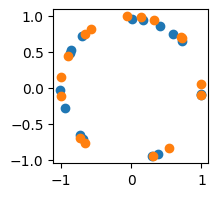

 28%|██████████████████████▏                                                        | 1407/5000 [00:57<02:31, 23.79it/s]

Epoch: 1401, Loss: 0.11937350779771805
Epoch: 1402, Loss: 0.11895634233951569
Epoch: 1403, Loss: 0.12298586964607239
Epoch: 1404, Loss: 0.1217813491821289
Epoch: 1405, Loss: 0.13438841700553894
Epoch: 1406, Loss: 0.11830286681652069


 28%|██████████████████████▎                                                        | 1413/5000 [00:58<02:27, 24.37it/s]

Epoch: 1407, Loss: 0.1171887218952179
Epoch: 1408, Loss: 0.12398754805326462
Epoch: 1409, Loss: 0.13264551758766174
Epoch: 1410, Loss: 0.11923711746931076
Epoch: 1411, Loss: 0.1427592635154724
Epoch: 1412, Loss: 0.11979208141565323


 28%|██████████████████████▎                                                        | 1416/5000 [00:58<02:51, 20.92it/s]

Epoch: 1413, Loss: 0.12792381644248962
Epoch: 1414, Loss: 0.12063513696193695
Epoch: 1415, Loss: 0.11123310029506683


 28%|██████████████████████▍                                                        | 1419/5000 [00:58<02:51, 20.85it/s]

Epoch: 1416, Loss: 0.13587217032909393
Epoch: 1417, Loss: 0.13699057698249817
Epoch: 1418, Loss: 0.13141115009784698
Epoch: 1419, Loss: 0.12264269590377808
Epoch: 1420, Loss: 0.11210684478282928


 28%|██████████████████████▌                                                        | 1425/5000 [00:58<02:43, 21.86it/s]

Epoch: 1421, Loss: 0.12832839787006378
Epoch: 1422, Loss: 0.12352093309164047
Epoch: 1423, Loss: 0.11751819401979446
Epoch: 1424, Loss: 0.12976306676864624
Epoch: 1425, Loss: 0.11588255316019058


 29%|██████████████████████▌                                                        | 1431/5000 [00:59<02:44, 21.74it/s]

Epoch: 1426, Loss: 0.11661610007286072
Epoch: 1427, Loss: 0.133074551820755
Epoch: 1428, Loss: 0.14750123023986816
Epoch: 1429, Loss: 0.13915026187896729
Epoch: 1430, Loss: 0.11941737681627274


 29%|██████████████████████▋                                                        | 1434/5000 [00:59<02:38, 22.50it/s]

Epoch: 1431, Loss: 0.12146272510290146
Epoch: 1432, Loss: 0.14090508222579956
Epoch: 1433, Loss: 0.13853800296783447
Epoch: 1434, Loss: 0.12141157686710358
Epoch: 1435, Loss: 0.11925230920314789


 29%|██████████████████████▊                                                        | 1440/5000 [00:59<02:38, 22.51it/s]

Epoch: 1436, Loss: 0.12907442450523376
Epoch: 1437, Loss: 0.1156187504529953
Epoch: 1438, Loss: 0.1192891001701355
Epoch: 1439, Loss: 0.12294339388608932


 29%|██████████████████████▊                                                        | 1443/5000 [00:59<03:02, 19.47it/s]

Epoch: 1440, Loss: 0.13171537220478058
Epoch: 1441, Loss: 0.1333857774734497
Epoch: 1442, Loss: 0.11274024099111557
Epoch: 1443, Loss: 0.11207924783229828


 29%|██████████████████████▊                                                        | 1446/5000 [00:59<03:17, 18.02it/s]

Epoch: 1444, Loss: 0.12342564761638641
Epoch: 1445, Loss: 0.12282298505306244
Epoch: 1446, Loss: 0.10886020958423615
Epoch: 1447, Loss: 0.129256010055542


 29%|██████████████████████▉                                                        | 1452/5000 [01:00<02:55, 20.24it/s]

Epoch: 1448, Loss: 0.12471860647201538
Epoch: 1449, Loss: 0.1525050848722458
Epoch: 1450, Loss: 0.12059446424245834
Epoch: 1451, Loss: 0.11015861481428146
Epoch: 1452, Loss: 0.13959287106990814


 29%|███████████████████████                                                        | 1458/5000 [01:00<02:46, 21.24it/s]

Epoch: 1453, Loss: 0.12404486536979675
Epoch: 1454, Loss: 0.11602258682250977
Epoch: 1455, Loss: 0.15181228518486023
Epoch: 1456, Loss: 0.10932184755802155
Epoch: 1457, Loss: 0.12940609455108643


 29%|███████████████████████                                                        | 1461/5000 [01:00<02:46, 21.26it/s]

Epoch: 1458, Loss: 0.12667186558246613
Epoch: 1459, Loss: 0.16398568451404572
Epoch: 1460, Loss: 0.122153639793396
Epoch: 1461, Loss: 0.13380078971385956
Epoch: 1462, Loss: 0.11976255476474762


 29%|███████████████████████▏                                                       | 1467/5000 [01:00<02:44, 21.44it/s]

Epoch: 1463, Loss: 0.12607324123382568
Epoch: 1464, Loss: 0.11449463665485382
Epoch: 1465, Loss: 0.13742923736572266
Epoch: 1466, Loss: 0.119603231549263
Epoch: 1467, Loss: 0.1116628646850586


 29%|███████████████████████▎                                                       | 1473/5000 [01:01<02:36, 22.60it/s]

Epoch: 1468, Loss: 0.1494893729686737
Epoch: 1469, Loss: 0.11868225038051605
Epoch: 1470, Loss: 0.11441586166620255
Epoch: 1471, Loss: 0.1389908790588379
Epoch: 1472, Loss: 0.1317170113325119


 30%|███████████████████████▎                                                       | 1476/5000 [01:01<02:37, 22.45it/s]

Epoch: 1473, Loss: 0.12322590500116348
Epoch: 1474, Loss: 0.12692713737487793
Epoch: 1475, Loss: 0.10764076560735703
Epoch: 1476, Loss: 0.1324891895055771
Epoch: 1477, Loss: 0.13170680403709412


 30%|███████████████████████▍                                                       | 1482/5000 [01:01<02:36, 22.45it/s]

Epoch: 1478, Loss: 0.12400103360414505
Epoch: 1479, Loss: 0.12528344988822937
Epoch: 1480, Loss: 0.1289447396993637
Epoch: 1481, Loss: 0.12463049590587616
Epoch: 1482, Loss: 0.11715148389339447


 30%|███████████████████████▌                                                       | 1488/5000 [01:01<02:41, 21.81it/s]

Epoch: 1483, Loss: 0.11347214877605438
Epoch: 1484, Loss: 0.11729773133993149
Epoch: 1485, Loss: 0.1193842887878418
Epoch: 1486, Loss: 0.11326196789741516
Epoch: 1487, Loss: 0.11355049163103104


 30%|███████████████████████▌                                                       | 1491/5000 [01:01<02:45, 21.24it/s]

Epoch: 1488, Loss: 0.1193084865808487
Epoch: 1489, Loss: 0.11672177910804749
Epoch: 1490, Loss: 0.12297387421131134
Epoch: 1491, Loss: 0.1103571429848671
Epoch: 1492, Loss: 0.1328202188014984


 30%|███████████████████████▋                                                       | 1497/5000 [01:02<02:39, 21.97it/s]

Epoch: 1493, Loss: 0.11237367987632751
Epoch: 1494, Loss: 0.13629840314388275
Epoch: 1495, Loss: 0.14019407331943512
Epoch: 1496, Loss: 0.1376180648803711
Epoch: 1497, Loss: 0.11488654464483261


 30%|███████████████████████▋                                                       | 1503/5000 [01:02<02:37, 22.25it/s]

Epoch: 1498, Loss: 0.11931446939706802
Epoch: 1499, Loss: 0.1276116669178009
Epoch: 1500, Loss: 0.12401643395423889
Epoch: 1501, Loss: 0.1353994756937027
Epoch: 1502, Loss: 0.12639550864696503


 30%|███████████████████████▊                                                       | 1506/5000 [01:02<03:04, 18.96it/s]

Epoch: 1503, Loss: 0.11944597214460373
Epoch: 1504, Loss: 0.13127276301383972
Epoch: 1505, Loss: 0.1551951915025711


 30%|███████████████████████▊                                                       | 1510/5000 [01:02<03:07, 18.56it/s]

Epoch: 1506, Loss: 0.12145238369703293
Epoch: 1507, Loss: 0.1347772777080536
Epoch: 1508, Loss: 0.1333131492137909
Epoch: 1509, Loss: 0.13353893160820007


 30%|███████████████████████▉                                                       | 1514/5000 [01:03<03:06, 18.73it/s]

Epoch: 1510, Loss: 0.12052486836910248
Epoch: 1511, Loss: 0.12329234182834625
Epoch: 1512, Loss: 0.14675292372703552
Epoch: 1513, Loss: 0.13186421990394592


 30%|███████████████████████▉                                                       | 1518/5000 [01:03<03:22, 17.20it/s]

Epoch: 1514, Loss: 0.11783528327941895
Epoch: 1515, Loss: 0.11675725877285004
Epoch: 1516, Loss: 0.1441187709569931
Epoch: 1517, Loss: 0.1384476274251938


 30%|████████████████████████                                                       | 1521/5000 [01:03<03:11, 18.20it/s]

Epoch: 1518, Loss: 0.13061532378196716
Epoch: 1519, Loss: 0.13917818665504456
Epoch: 1520, Loss: 0.11874635517597198
Epoch: 1521, Loss: 0.10985321551561356


 30%|████████████████████████                                                       | 1525/5000 [01:03<03:14, 17.87it/s]

Epoch: 1522, Loss: 0.1197737604379654
Epoch: 1523, Loss: 0.13883739709854126
Epoch: 1524, Loss: 0.16296839714050293
Epoch: 1525, Loss: 0.1324690282344818


 31%|████████████████████████▏                                                      | 1530/5000 [01:03<02:55, 19.76it/s]

Epoch: 1526, Loss: 0.14356687664985657
Epoch: 1527, Loss: 0.1570868343114853
Epoch: 1528, Loss: 0.12819646298885345
Epoch: 1529, Loss: 0.1220267042517662
Epoch: 1530, Loss: 0.11862072348594666


 31%|████████████████████████▎                                                      | 1536/5000 [01:04<02:32, 22.71it/s]

Epoch: 1531, Loss: 0.13596320152282715
Epoch: 1532, Loss: 0.12747064232826233
Epoch: 1533, Loss: 0.12311159819364548
Epoch: 1534, Loss: 0.12076915800571442
Epoch: 1535, Loss: 0.1290341317653656
Epoch: 1536, Loss: 0.122979074716568


 31%|████████████████████████▎                                                      | 1542/5000 [01:04<02:20, 24.54it/s]

Epoch: 1537, Loss: 0.12066256999969482
Epoch: 1538, Loss: 0.1348133683204651
Epoch: 1539, Loss: 0.14539948105812073
Epoch: 1540, Loss: 0.12065653502941132
Epoch: 1541, Loss: 0.1487123966217041
Epoch: 1542, Loss: 0.12398429960012436


 31%|████████████████████████▍                                                      | 1545/5000 [01:04<02:41, 21.42it/s]

Epoch: 1543, Loss: 0.12797336280345917
Epoch: 1544, Loss: 0.13205894827842712
Epoch: 1545, Loss: 0.12023495137691498
Epoch: 1546, Loss: 0.12521487474441528


 31%|████████████████████████▌                                                      | 1551/5000 [01:04<02:39, 21.59it/s]

Epoch: 1547, Loss: 0.12150813639163971
Epoch: 1548, Loss: 0.11979542672634125
Epoch: 1549, Loss: 0.10857456922531128
Epoch: 1550, Loss: 0.1296195089817047


 31%|████████████████████████▌                                                      | 1554/5000 [01:05<02:50, 20.20it/s]

Epoch: 1551, Loss: 0.13231171667575836
Epoch: 1552, Loss: 0.125819131731987
Epoch: 1553, Loss: 0.12317252159118652
Epoch: 1554, Loss: 0.13896487653255463
Epoch: 1555, Loss: 0.13270169496536255


 31%|████████████████████████▋                                                      | 1560/5000 [01:05<02:32, 22.57it/s]

Epoch: 1556, Loss: 0.12605586647987366
Epoch: 1557, Loss: 0.177697092294693
Epoch: 1558, Loss: 0.12307475507259369
Epoch: 1559, Loss: 0.12770940363407135
Epoch: 1560, Loss: 0.10295941680669785


 31%|████████████████████████▋                                                      | 1563/5000 [01:05<02:38, 21.66it/s]

Epoch: 1561, Loss: 0.13664279878139496
Epoch: 1562, Loss: 0.13865450024604797
Epoch: 1563, Loss: 0.12856215238571167
Epoch: 1564, Loss: 0.12563017010688782


 31%|████████████████████████▊                                                      | 1569/5000 [01:05<02:50, 20.12it/s]

Epoch: 1565, Loss: 0.11178012937307358
Epoch: 1566, Loss: 0.11991336941719055
Epoch: 1567, Loss: 0.11467824876308441
Epoch: 1568, Loss: 0.13340631127357483
Epoch: 1569, Loss: 0.13753536343574524


 32%|████████████████████████▉                                                      | 1575/5000 [01:06<02:38, 21.65it/s]

Epoch: 1570, Loss: 0.13229531049728394
Epoch: 1571, Loss: 0.13007299602031708
Epoch: 1572, Loss: 0.11428263783454895
Epoch: 1573, Loss: 0.14295218884944916
Epoch: 1574, Loss: 0.10768255591392517


 32%|████████████████████████▉                                                      | 1578/5000 [01:06<02:34, 22.14it/s]

Epoch: 1575, Loss: 0.119868703186512
Epoch: 1576, Loss: 0.1188533678650856
Epoch: 1577, Loss: 0.13052965700626373
Epoch: 1578, Loss: 0.13589982688426971
Epoch: 1579, Loss: 0.12096953392028809


 32%|█████████████████████████                                                      | 1584/5000 [01:06<02:25, 23.55it/s]

Epoch: 1580, Loss: 0.13312658667564392
Epoch: 1581, Loss: 0.13011834025382996
Epoch: 1582, Loss: 0.13762274384498596
Epoch: 1583, Loss: 0.1145024523139
Epoch: 1584, Loss: 0.132135272026062
Epoch: 1585, Loss: 0.1374226063489914


 32%|█████████████████████████                                                      | 1590/5000 [01:06<02:23, 23.82it/s]

Epoch: 1586, Loss: 0.15653249621391296
Epoch: 1587, Loss: 0.12151072919368744
Epoch: 1588, Loss: 0.13303622603416443
Epoch: 1589, Loss: 0.13045446574687958
Epoch: 1590, Loss: 0.12966209650039673
Epoch: 1591, Loss: 0.12281719595193863


 32%|█████████████████████████▏                                                     | 1596/5000 [01:06<02:19, 24.41it/s]

Epoch: 1592, Loss: 0.13776718080043793
Epoch: 1593, Loss: 0.1113099530339241
Epoch: 1594, Loss: 0.12224340438842773
Epoch: 1595, Loss: 0.11002717912197113
Epoch: 1596, Loss: 0.12341521680355072
Epoch: 1597, Loss: 0.11281710863113403


 32%|█████████████████████████▎                                                     | 1599/5000 [01:06<02:15, 25.13it/s]

Epoch: 1598, Loss: 0.1116800457239151
Epoch: 1599, Loss: 0.1371726095676422
Epoch: 1600, Loss: 0.11143025755882263


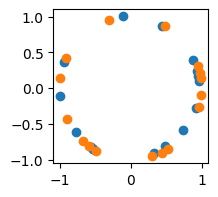

 32%|█████████████████████████▎                                                     | 1602/5000 [01:07<02:41, 21.08it/s]

Epoch: 1601, Loss: 0.12430275976657867


 32%|█████████████████████████▎                                                     | 1605/5000 [01:07<02:32, 22.32it/s]

Epoch: 1602, Loss: 0.11548148840665817
Epoch: 1603, Loss: 0.11797340214252472
Epoch: 1604, Loss: 0.11085400730371475
Epoch: 1605, Loss: 0.11070923507213593
Epoch: 1606, Loss: 0.12030762434005737


 32%|█████████████████████████▍                                                     | 1608/5000 [01:07<02:26, 23.16it/s]

Epoch: 1607, Loss: 0.1217908039689064


 32%|█████████████████████████▍                                                     | 1611/5000 [01:07<02:23, 23.62it/s]

Epoch: 1608, Loss: 0.11500854790210724
Epoch: 1609, Loss: 0.11846410483121872
Epoch: 1610, Loss: 0.1339637041091919
Epoch: 1611, Loss: 0.13620512187480927
Epoch: 1612, Loss: 0.11870177835226059


 32%|█████████████████████████▌                                                     | 1614/5000 [01:07<02:20, 24.17it/s]

Epoch: 1613, Loss: 0.13309825956821442


 32%|█████████████████████████▌                                                     | 1617/5000 [01:07<02:25, 23.19it/s]

Epoch: 1614, Loss: 0.11248171329498291
Epoch: 1615, Loss: 0.10472171753644943
Epoch: 1616, Loss: 0.14113172888755798
Epoch: 1617, Loss: 0.14474225044250488


 32%|█████████████████████████▌                                                     | 1620/5000 [01:07<02:45, 20.41it/s]

Epoch: 1618, Loss: 0.11805809289216995
Epoch: 1619, Loss: 0.1080939769744873
Epoch: 1620, Loss: 0.125226229429245
Epoch: 1621, Loss: 0.13133423030376434


 32%|█████████████████████████▋                                                     | 1623/5000 [01:08<02:34, 21.86it/s]

Epoch: 1622, Loss: 0.12147291749715805


 33%|█████████████████████████▋                                                     | 1626/5000 [01:08<02:28, 22.70it/s]

Epoch: 1623, Loss: 0.11683350056409836
Epoch: 1624, Loss: 0.11285115033388138
Epoch: 1625, Loss: 0.13617171347141266
Epoch: 1626, Loss: 0.1284416913986206
Epoch: 1627, Loss: 0.1372135579586029


 33%|█████████████████████████▋                                                     | 1629/5000 [01:08<02:23, 23.56it/s]

Epoch: 1628, Loss: 0.1163347065448761


 33%|█████████████████████████▊                                                     | 1632/5000 [01:08<02:14, 25.12it/s]

Epoch: 1629, Loss: 0.11617177724838257
Epoch: 1630, Loss: 0.1394374966621399
Epoch: 1631, Loss: 0.11716112494468689
Epoch: 1632, Loss: 0.1285904347896576
Epoch: 1633, Loss: 0.12633544206619263


 33%|█████████████████████████▊                                                     | 1635/5000 [01:08<02:18, 24.25it/s]

Epoch: 1634, Loss: 0.11621618270874023


 33%|█████████████████████████▉                                                     | 1638/5000 [01:08<02:15, 24.79it/s]

Epoch: 1635, Loss: 0.1362946331501007
Epoch: 1636, Loss: 0.12133297324180603
Epoch: 1637, Loss: 0.12894690036773682
Epoch: 1638, Loss: 0.12038596719503403
Epoch: 1639, Loss: 0.11060360819101334


 33%|█████████████████████████▉                                                     | 1641/5000 [01:08<02:10, 25.74it/s]

Epoch: 1640, Loss: 0.12854938209056854


 33%|█████████████████████████▉                                                     | 1644/5000 [01:08<02:09, 25.89it/s]

Epoch: 1641, Loss: 0.11850805580615997
Epoch: 1642, Loss: 0.14645712077617645
Epoch: 1643, Loss: 0.11979284137487411
Epoch: 1644, Loss: 0.13375592231750488
Epoch: 1645, Loss: 0.12243565171957016


 33%|██████████████████████████                                                     | 1647/5000 [01:09<02:08, 26.03it/s]

Epoch: 1646, Loss: 0.11826027929782867


 33%|██████████████████████████                                                     | 1650/5000 [01:09<02:06, 26.41it/s]

Epoch: 1647, Loss: 0.1362733691930771
Epoch: 1648, Loss: 0.13160695135593414
Epoch: 1649, Loss: 0.1334160715341568
Epoch: 1650, Loss: 0.12462852895259857
Epoch: 1651, Loss: 0.12258908897638321


 33%|██████████████████████████                                                     | 1653/5000 [01:09<02:03, 27.20it/s]

Epoch: 1652, Loss: 0.1420094072818756


 33%|██████████████████████████▏                                                    | 1656/5000 [01:09<02:04, 26.85it/s]

Epoch: 1653, Loss: 0.12880080938339233
Epoch: 1654, Loss: 0.11940667033195496
Epoch: 1655, Loss: 0.11572056263685226
Epoch: 1656, Loss: 0.11753933131694794
Epoch: 1657, Loss: 0.1146649569272995


 33%|██████████████████████████▏                                                    | 1659/5000 [01:09<02:04, 26.83it/s]

Epoch: 1658, Loss: 0.12212088704109192


 33%|██████████████████████████▎                                                    | 1662/5000 [01:09<02:08, 25.94it/s]

Epoch: 1659, Loss: 0.1391756683588028
Epoch: 1660, Loss: 0.11972109973430634
Epoch: 1661, Loss: 0.1212213784456253
Epoch: 1662, Loss: 0.12110963463783264


 33%|██████████████████████████▎                                                    | 1665/5000 [01:09<02:09, 25.77it/s]

Epoch: 1663, Loss: 0.12987908720970154
Epoch: 1664, Loss: 0.1401256024837494


 33%|██████████████████████████▎                                                    | 1668/5000 [01:09<02:07, 26.20it/s]

Epoch: 1665, Loss: 0.12534283101558685
Epoch: 1666, Loss: 0.12127484381198883
Epoch: 1667, Loss: 0.13014574348926544
Epoch: 1668, Loss: 0.12554804980754852


 33%|██████████████████████████▍                                                    | 1671/5000 [01:09<02:08, 25.90it/s]

Epoch: 1669, Loss: 0.12748855352401733
Epoch: 1670, Loss: 0.12057548761367798


 33%|██████████████████████████▍                                                    | 1674/5000 [01:10<02:05, 26.40it/s]

Epoch: 1671, Loss: 0.1281452476978302
Epoch: 1672, Loss: 0.11255497485399246
Epoch: 1673, Loss: 0.1168665811419487
Epoch: 1674, Loss: 0.12536633014678955


 34%|██████████████████████████▍                                                    | 1677/5000 [01:10<02:07, 26.08it/s]

Epoch: 1675, Loss: 0.12224018573760986
Epoch: 1676, Loss: 0.18197542428970337


 34%|██████████████████████████▌                                                    | 1680/5000 [01:10<02:09, 25.64it/s]

Epoch: 1677, Loss: 0.13119684159755707
Epoch: 1678, Loss: 0.15095588564872742
Epoch: 1679, Loss: 0.11994189023971558
Epoch: 1680, Loss: 0.12474340200424194


 34%|██████████████████████████▌                                                    | 1683/5000 [01:10<02:07, 26.04it/s]

Epoch: 1681, Loss: 0.1190238669514656
Epoch: 1682, Loss: 0.12801125645637512


 34%|██████████████████████████▋                                                    | 1686/5000 [01:10<02:06, 26.20it/s]

Epoch: 1683, Loss: 0.11423208564519882
Epoch: 1684, Loss: 0.1260852962732315
Epoch: 1685, Loss: 0.11858901381492615
Epoch: 1686, Loss: 0.12174168229103088


 34%|██████████████████████████▋                                                    | 1689/5000 [01:10<02:04, 26.60it/s]

Epoch: 1687, Loss: 0.14444854855537415
Epoch: 1688, Loss: 0.1160658746957779


 34%|██████████████████████████▋                                                    | 1692/5000 [01:10<02:04, 26.60it/s]

Epoch: 1689, Loss: 0.11317993700504303
Epoch: 1690, Loss: 0.15792164206504822
Epoch: 1691, Loss: 0.13064296543598175
Epoch: 1692, Loss: 0.12670184671878815
Epoch: 1693, Loss: 0.11288212984800339


 34%|██████████████████████████▊                                                    | 1698/5000 [01:10<02:10, 25.21it/s]

Epoch: 1694, Loss: 0.1204301118850708
Epoch: 1695, Loss: 0.10641776025295258
Epoch: 1696, Loss: 0.13545258343219757
Epoch: 1697, Loss: 0.11147031933069229
Epoch: 1698, Loss: 0.12126654386520386
Epoch: 1699, Loss: 0.11550460010766983


 34%|██████████████████████████▉                                                    | 1701/5000 [01:11<02:12, 24.89it/s]

Epoch: 1700, Loss: 0.142503559589386
Epoch: 1701, Loss: 0.12337028980255127
Epoch: 1702, Loss: 0.22607716917991638


 34%|██████████████████████████▉                                                    | 1704/5000 [01:11<02:27, 22.32it/s]

Epoch: 1703, Loss: 0.11836376041173935


 34%|██████████████████████████▉                                                    | 1707/5000 [01:11<02:26, 22.45it/s]

Epoch: 1704, Loss: 0.11605678498744965
Epoch: 1705, Loss: 0.13027557730674744
Epoch: 1706, Loss: 0.11587323248386383
Epoch: 1707, Loss: 0.13049373030662537
Epoch: 1708, Loss: 0.12535561621189117


 34%|███████████████████████████                                                    | 1713/5000 [01:11<02:22, 23.14it/s]

Epoch: 1709, Loss: 0.1272902935743332
Epoch: 1710, Loss: 0.12955030798912048
Epoch: 1711, Loss: 0.12415356934070587
Epoch: 1712, Loss: 0.12251725047826767
Epoch: 1713, Loss: 0.12148617208003998


 34%|███████████████████████████                                                    | 1716/5000 [01:11<02:27, 22.30it/s]

Epoch: 1714, Loss: 0.1303761899471283
Epoch: 1715, Loss: 0.11315342783927917
Epoch: 1716, Loss: 0.11279803514480591
Epoch: 1717, Loss: 0.12804639339447021


 34%|███████████████████████████▏                                                   | 1722/5000 [01:12<02:39, 20.56it/s]

Epoch: 1718, Loss: 0.12411685287952423
Epoch: 1719, Loss: 0.12365933507680893
Epoch: 1720, Loss: 0.11844265460968018
Epoch: 1721, Loss: 0.13376115262508392
Epoch: 1722, Loss: 0.1264074295759201


 35%|███████████████████████████▎                                                   | 1728/5000 [01:12<02:24, 22.72it/s]

Epoch: 1723, Loss: 0.13531963527202606
Epoch: 1724, Loss: 0.12294700741767883
Epoch: 1725, Loss: 0.13335292041301727
Epoch: 1726, Loss: 0.11804115772247314
Epoch: 1727, Loss: 0.13229957222938538
Epoch: 1728, Loss: 0.12487221509218216


 35%|███████████████████████████▍                                                   | 1734/5000 [01:12<02:13, 24.54it/s]

Epoch: 1729, Loss: 0.12731550633907318
Epoch: 1730, Loss: 0.13195940852165222
Epoch: 1731, Loss: 0.1260279417037964
Epoch: 1732, Loss: 0.1327299177646637
Epoch: 1733, Loss: 0.13911981880664825
Epoch: 1734, Loss: 0.12158116698265076


 35%|███████████████████████████▍                                                   | 1740/5000 [01:12<02:05, 25.96it/s]

Epoch: 1735, Loss: 0.12448729574680328
Epoch: 1736, Loss: 0.11380039155483246
Epoch: 1737, Loss: 0.12243345379829407
Epoch: 1738, Loss: 0.11686098575592041
Epoch: 1739, Loss: 0.11841423064470291
Epoch: 1740, Loss: 0.11171157658100128


 35%|███████████████████████████▌                                                   | 1746/5000 [01:13<02:01, 26.87it/s]

Epoch: 1741, Loss: 0.1268349140882492
Epoch: 1742, Loss: 0.13725057244300842
Epoch: 1743, Loss: 0.1280166059732437
Epoch: 1744, Loss: 0.11354589462280273
Epoch: 1745, Loss: 0.12328758835792542
Epoch: 1746, Loss: 0.12555725872516632


 35%|███████████████████████████▋                                                   | 1752/5000 [01:13<02:03, 26.29it/s]

Epoch: 1747, Loss: 0.12641657888889313
Epoch: 1748, Loss: 0.12595714628696442
Epoch: 1749, Loss: 0.11456066370010376
Epoch: 1750, Loss: 0.11794732511043549
Epoch: 1751, Loss: 0.1399233192205429
Epoch: 1752, Loss: 0.1331489384174347


 35%|███████████████████████████▊                                                   | 1758/5000 [01:13<02:02, 26.39it/s]

Epoch: 1753, Loss: 0.12293984740972519
Epoch: 1754, Loss: 0.12797364592552185
Epoch: 1755, Loss: 0.10670570284128189
Epoch: 1756, Loss: 0.14644043147563934
Epoch: 1757, Loss: 0.1112307757139206
Epoch: 1758, Loss: 0.12780925631523132


 35%|███████████████████████████▊                                                   | 1764/5000 [01:13<02:04, 25.93it/s]

Epoch: 1759, Loss: 0.12227426469326019
Epoch: 1760, Loss: 0.1303132027387619
Epoch: 1761, Loss: 0.12355422228574753
Epoch: 1762, Loss: 0.129215806722641
Epoch: 1763, Loss: 0.1208784282207489
Epoch: 1764, Loss: 0.1199757382273674


 35%|███████████████████████████▉                                                   | 1770/5000 [01:13<02:03, 26.17it/s]

Epoch: 1765, Loss: 0.1265295296907425
Epoch: 1766, Loss: 0.12980546057224274
Epoch: 1767, Loss: 0.13630688190460205
Epoch: 1768, Loss: 0.1262412965297699
Epoch: 1769, Loss: 0.159301295876503
Epoch: 1770, Loss: 0.12370271235704422


 36%|████████████████████████████                                                   | 1776/5000 [01:14<02:00, 26.65it/s]

Epoch: 1771, Loss: 0.1329999566078186
Epoch: 1772, Loss: 0.17363950610160828
Epoch: 1773, Loss: 0.13745428621768951
Epoch: 1774, Loss: 0.11834924668073654
Epoch: 1775, Loss: 0.13301381468772888
Epoch: 1776, Loss: 0.11634065955877304


 36%|████████████████████████████▏                                                  | 1782/5000 [01:14<01:59, 26.99it/s]

Epoch: 1777, Loss: 0.10874761641025543
Epoch: 1778, Loss: 0.1378433108329773
Epoch: 1779, Loss: 0.11965048313140869
Epoch: 1780, Loss: 0.13232488930225372
Epoch: 1781, Loss: 0.11896892637014389
Epoch: 1782, Loss: 0.13366574048995972


 36%|████████████████████████████▎                                                  | 1788/5000 [01:14<01:57, 27.27it/s]

Epoch: 1783, Loss: 0.12826098501682281
Epoch: 1784, Loss: 0.12277401238679886
Epoch: 1785, Loss: 0.12580297887325287
Epoch: 1786, Loss: 0.12941785156726837
Epoch: 1787, Loss: 0.11863164603710175
Epoch: 1788, Loss: 0.11958503723144531


 36%|████████████████████████████▎                                                  | 1794/5000 [01:14<02:10, 24.59it/s]

Epoch: 1789, Loss: 0.11414767801761627
Epoch: 1790, Loss: 0.11797024309635162
Epoch: 1791, Loss: 0.1068088486790657
Epoch: 1792, Loss: 0.13270516693592072
Epoch: 1793, Loss: 0.12002260982990265


 36%|████████████████████████████▍                                                  | 1800/5000 [01:15<02:11, 24.26it/s]

Epoch: 1794, Loss: 0.12428230047225952
Epoch: 1795, Loss: 0.13027727603912354
Epoch: 1796, Loss: 0.13464246690273285
Epoch: 1797, Loss: 0.14088544249534607
Epoch: 1798, Loss: 0.12088346481323242
Epoch: 1799, Loss: 0.1223275437951088
Epoch: 1800, Loss: 0.14471708238124847


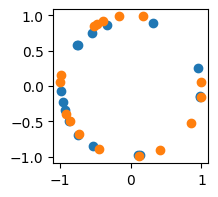

 36%|████████████████████████████▍                                                  | 1803/5000 [01:15<02:29, 21.41it/s]

Epoch: 1801, Loss: 0.10991255939006805
Epoch: 1802, Loss: 0.12646470963954926
Epoch: 1803, Loss: 0.12367410957813263


 36%|████████████████████████████▌                                                  | 1806/5000 [01:15<02:21, 22.54it/s]

Epoch: 1804, Loss: 0.11800277978181839
Epoch: 1805, Loss: 0.11483906209468842
Epoch: 1806, Loss: 0.14833205938339233


 36%|████████████████████████████▌                                                  | 1809/5000 [01:15<02:17, 23.29it/s]

Epoch: 1807, Loss: 0.11301039159297943
Epoch: 1808, Loss: 0.12262760102748871
Epoch: 1809, Loss: 0.11878873407840729


 36%|████████████████████████████▋                                                  | 1812/5000 [01:15<02:15, 23.53it/s]

Epoch: 1810, Loss: 0.11134538054466248
Epoch: 1811, Loss: 0.11653956770896912


 36%|████████████████████████████▋                                                  | 1815/5000 [01:15<02:13, 23.94it/s]

Epoch: 1812, Loss: 0.11159724742174149
Epoch: 1813, Loss: 0.13339561223983765
Epoch: 1814, Loss: 0.13467738032341003
Epoch: 1815, Loss: 0.1233239620923996


 36%|████████████████████████████▋                                                  | 1818/5000 [01:15<02:08, 24.72it/s]

Epoch: 1816, Loss: 0.11408063769340515
Epoch: 1817, Loss: 0.11016979813575745


 36%|████████████████████████████▊                                                  | 1821/5000 [01:16<02:08, 24.74it/s]

Epoch: 1818, Loss: 0.13887135684490204
Epoch: 1819, Loss: 0.10543351620435715
Epoch: 1820, Loss: 0.1712978482246399
Epoch: 1821, Loss: 0.12095420062541962


 36%|████████████████████████████▊                                                  | 1824/5000 [01:16<02:07, 25.00it/s]

Epoch: 1822, Loss: 0.11243721097707748
Epoch: 1823, Loss: 0.11859045177698135


 37%|████████████████████████████▊                                                  | 1827/5000 [01:16<02:04, 25.58it/s]

Epoch: 1824, Loss: 0.11619578301906586
Epoch: 1825, Loss: 0.11713278293609619
Epoch: 1826, Loss: 0.12170511484146118
Epoch: 1827, Loss: 0.11924301832914352


 37%|████████████████████████████▉                                                  | 1830/5000 [01:16<02:05, 25.28it/s]

Epoch: 1828, Loss: 0.11143438518047333
Epoch: 1829, Loss: 0.12029977142810822


 37%|████████████████████████████▉                                                  | 1833/5000 [01:16<02:03, 25.65it/s]

Epoch: 1830, Loss: 0.12109135091304779
Epoch: 1831, Loss: 0.11797989159822464
Epoch: 1832, Loss: 0.11392368376255035
Epoch: 1833, Loss: 0.10908815264701843


 37%|█████████████████████████████                                                  | 1836/5000 [01:16<02:28, 21.25it/s]

Epoch: 1834, Loss: 0.106376513838768
Epoch: 1835, Loss: 0.13835294544696808
Epoch: 1836, Loss: 0.12588202953338623
Epoch: 1837, Loss: 0.16171607375144958


 37%|█████████████████████████████                                                  | 1839/5000 [01:16<02:19, 22.61it/s]

Epoch: 1838, Loss: 0.1402018517255783


 37%|█████████████████████████████                                                  | 1842/5000 [01:16<02:36, 20.22it/s]

Epoch: 1839, Loss: 0.12168677151203156
Epoch: 1840, Loss: 0.13232412934303284
Epoch: 1841, Loss: 0.1601485162973404
Epoch: 1842, Loss: 0.121177539229393


 37%|█████████████████████████████▏                                                 | 1848/5000 [01:17<02:19, 22.65it/s]

Epoch: 1843, Loss: 0.15175364911556244
Epoch: 1844, Loss: 0.12783458828926086
Epoch: 1845, Loss: 0.10989896953105927
Epoch: 1846, Loss: 0.1638251096010208
Epoch: 1847, Loss: 0.11553394794464111
Epoch: 1848, Loss: 0.12489225715398788


 37%|█████████████████████████████▎                                                 | 1854/5000 [01:17<02:09, 24.27it/s]

Epoch: 1849, Loss: 0.12306667864322662
Epoch: 1850, Loss: 0.14737218618392944
Epoch: 1851, Loss: 0.12226313352584839
Epoch: 1852, Loss: 0.13193677365779877
Epoch: 1853, Loss: 0.12209444493055344
Epoch: 1854, Loss: 0.12083515524864197


 37%|█████████████████████████████▍                                                 | 1860/5000 [01:17<02:06, 24.75it/s]

Epoch: 1855, Loss: 0.12168560922145844
Epoch: 1856, Loss: 0.1123337373137474
Epoch: 1857, Loss: 0.11041241884231567
Epoch: 1858, Loss: 0.14217126369476318
Epoch: 1859, Loss: 0.11977390944957733
Epoch: 1860, Loss: 0.12545424699783325


 37%|█████████████████████████████▍                                                 | 1866/5000 [01:17<02:05, 24.89it/s]

Epoch: 1861, Loss: 0.12622655928134918
Epoch: 1862, Loss: 0.12973661720752716
Epoch: 1863, Loss: 0.13427212834358215
Epoch: 1864, Loss: 0.12594300508499146
Epoch: 1865, Loss: 0.13123953342437744


 37%|█████████████████████████████▌                                                 | 1872/5000 [01:18<02:03, 25.29it/s]

Epoch: 1866, Loss: 0.11375164240598679
Epoch: 1867, Loss: 0.12552618980407715
Epoch: 1868, Loss: 0.1176300048828125
Epoch: 1869, Loss: 0.12879569828510284
Epoch: 1870, Loss: 0.11685378104448318
Epoch: 1871, Loss: 0.11416485905647278


 38%|█████████████████████████████▋                                                 | 1878/5000 [01:18<02:10, 23.89it/s]

Epoch: 1872, Loss: 0.11366095393896103
Epoch: 1873, Loss: 0.11506664752960205
Epoch: 1874, Loss: 0.10745754837989807
Epoch: 1875, Loss: 0.1353255659341812
Epoch: 1876, Loss: 0.11549801379442215
Epoch: 1877, Loss: 0.15197570621967316


 38%|█████████████████████████████▊                                                 | 1884/5000 [01:18<02:07, 24.51it/s]

Epoch: 1878, Loss: 0.11571038514375687
Epoch: 1879, Loss: 0.11492577195167542
Epoch: 1880, Loss: 0.11893706023693085
Epoch: 1881, Loss: 0.12577104568481445
Epoch: 1882, Loss: 0.1144876629114151
Epoch: 1883, Loss: 0.12269552052021027


 38%|█████████████████████████████▊                                                 | 1890/5000 [01:18<02:06, 24.54it/s]

Epoch: 1884, Loss: 0.1183999627828598
Epoch: 1885, Loss: 0.13446614146232605
Epoch: 1886, Loss: 0.1132529005408287
Epoch: 1887, Loss: 0.12641295790672302
Epoch: 1888, Loss: 0.13035306334495544
Epoch: 1889, Loss: 0.11280573904514313


 38%|█████████████████████████████▉                                                 | 1896/5000 [01:19<02:02, 25.32it/s]

Epoch: 1890, Loss: 0.12743540108203888
Epoch: 1891, Loss: 0.11939973384141922
Epoch: 1892, Loss: 0.13033507764339447
Epoch: 1893, Loss: 0.11725220084190369
Epoch: 1894, Loss: 0.11426931619644165
Epoch: 1895, Loss: 0.14173495769500732


 38%|██████████████████████████████                                                 | 1902/5000 [01:19<01:54, 26.97it/s]

Epoch: 1896, Loss: 0.12469092756509781
Epoch: 1897, Loss: 0.12472821027040482
Epoch: 1898, Loss: 0.11953426897525787
Epoch: 1899, Loss: 0.114104263484478
Epoch: 1900, Loss: 0.12555694580078125
Epoch: 1901, Loss: 0.12777960300445557


 38%|██████████████████████████████                                                 | 1905/5000 [01:19<01:56, 26.54it/s]

Epoch: 1902, Loss: 0.1267898827791214
Epoch: 1903, Loss: 0.11986833065748215
Epoch: 1904, Loss: 0.12216120213270187
Epoch: 1905, Loss: 0.1294601857662201
Epoch: 1906, Loss: 0.14080342650413513


 38%|██████████████████████████████▏                                                | 1911/5000 [01:19<02:01, 25.39it/s]

Epoch: 1907, Loss: 0.107339046895504
Epoch: 1908, Loss: 0.13460180163383484
Epoch: 1909, Loss: 0.13748180866241455
Epoch: 1910, Loss: 0.14209607243537903
Epoch: 1911, Loss: 0.13534921407699585


 38%|██████████████████████████████▎                                                | 1917/5000 [01:19<02:07, 24.27it/s]

Epoch: 1912, Loss: 0.12568558752536774
Epoch: 1913, Loss: 0.14032456278800964
Epoch: 1914, Loss: 0.12188813835382462
Epoch: 1915, Loss: 0.1320362687110901
Epoch: 1916, Loss: 0.13111186027526855
Epoch: 1917, Loss: 0.13057318329811096


 38%|██████████████████████████████▍                                                | 1923/5000 [01:20<01:57, 26.19it/s]

Epoch: 1918, Loss: 0.12646262347698212
Epoch: 1919, Loss: 0.11656849086284637
Epoch: 1920, Loss: 0.12262223660945892
Epoch: 1921, Loss: 0.10725775361061096
Epoch: 1922, Loss: 0.10940729081630707
Epoch: 1923, Loss: 0.12029328942298889


 39%|██████████████████████████████▍                                                | 1929/5000 [01:20<01:56, 26.36it/s]

Epoch: 1924, Loss: 0.1432189643383026
Epoch: 1925, Loss: 0.1159525215625763
Epoch: 1926, Loss: 0.12313241511583328
Epoch: 1927, Loss: 0.13852794468402863
Epoch: 1928, Loss: 0.1228722557425499
Epoch: 1929, Loss: 0.12392005324363708


 39%|██████████████████████████████▌                                                | 1935/5000 [01:20<01:58, 25.92it/s]

Epoch: 1930, Loss: 0.1196947768330574
Epoch: 1931, Loss: 0.12103293091058731
Epoch: 1932, Loss: 0.11559028923511505
Epoch: 1933, Loss: 0.132810577750206
Epoch: 1934, Loss: 0.11415021866559982
Epoch: 1935, Loss: 0.13606394827365875


 39%|██████████████████████████████▋                                                | 1941/5000 [01:20<01:58, 25.89it/s]

Epoch: 1936, Loss: 0.1159602552652359
Epoch: 1937, Loss: 0.11163819581270218
Epoch: 1938, Loss: 0.11863160878419876
Epoch: 1939, Loss: 0.1186290979385376
Epoch: 1940, Loss: 0.11127325892448425
Epoch: 1941, Loss: 0.156699076294899


 39%|██████████████████████████████▊                                                | 1947/5000 [01:21<01:57, 26.00it/s]

Epoch: 1942, Loss: 0.1222584992647171
Epoch: 1943, Loss: 0.10984007269144058
Epoch: 1944, Loss: 0.12916557490825653
Epoch: 1945, Loss: 0.12077656388282776
Epoch: 1946, Loss: 0.12890340387821198
Epoch: 1947, Loss: 0.11522229760885239


 39%|██████████████████████████████▊                                                | 1953/5000 [01:21<01:53, 26.86it/s]

Epoch: 1948, Loss: 0.11425717175006866
Epoch: 1949, Loss: 0.12022686749696732
Epoch: 1950, Loss: 0.11215797066688538
Epoch: 1951, Loss: 0.128371924161911
Epoch: 1952, Loss: 0.12490381300449371
Epoch: 1953, Loss: 0.12170233577489853


 39%|██████████████████████████████▉                                                | 1959/5000 [01:21<01:53, 26.89it/s]

Epoch: 1954, Loss: 0.12153821438550949
Epoch: 1955, Loss: 0.13301332294940948
Epoch: 1956, Loss: 0.12648290395736694
Epoch: 1957, Loss: 0.1188923567533493
Epoch: 1958, Loss: 0.10845474153757095
Epoch: 1959, Loss: 0.12012587487697601


 39%|███████████████████████████████                                                | 1965/5000 [01:21<01:52, 26.86it/s]

Epoch: 1960, Loss: 0.11639200150966644
Epoch: 1961, Loss: 0.12765678763389587
Epoch: 1962, Loss: 0.11407247930765152
Epoch: 1963, Loss: 0.15043644607067108
Epoch: 1964, Loss: 0.12937863171100616
Epoch: 1965, Loss: 0.11835753917694092


 39%|███████████████████████████████▏                                               | 1971/5000 [01:22<01:53, 26.68it/s]

Epoch: 1966, Loss: 0.1283714324235916
Epoch: 1967, Loss: 0.10504166781902313
Epoch: 1968, Loss: 0.119705930352211
Epoch: 1969, Loss: 0.12757910788059235
Epoch: 1970, Loss: 0.12441512197256088
Epoch: 1971, Loss: 0.1121489405632019


 40%|███████████████████████████████▏                                               | 1977/5000 [01:22<01:54, 26.43it/s]

Epoch: 1972, Loss: 0.11745376884937286
Epoch: 1973, Loss: 0.11974142491817474
Epoch: 1974, Loss: 0.150152325630188
Epoch: 1975, Loss: 0.11552130430936813
Epoch: 1976, Loss: 0.11484828591346741
Epoch: 1977, Loss: 0.11681262403726578


 40%|███████████████████████████████▎                                               | 1983/5000 [01:22<01:53, 26.57it/s]

Epoch: 1978, Loss: 0.11123966425657272
Epoch: 1979, Loss: 0.12177350372076035
Epoch: 1980, Loss: 0.12400238960981369
Epoch: 1981, Loss: 0.13728231191635132
Epoch: 1982, Loss: 0.11818069219589233
Epoch: 1983, Loss: 0.1263602077960968


 40%|███████████████████████████████▍                                               | 1989/5000 [01:22<01:53, 26.46it/s]

Epoch: 1984, Loss: 0.13036301732063293
Epoch: 1985, Loss: 0.12592099606990814
Epoch: 1986, Loss: 0.13531087338924408
Epoch: 1987, Loss: 0.13246864080429077
Epoch: 1988, Loss: 0.12753884494304657
Epoch: 1989, Loss: 0.12662339210510254


 40%|███████████████████████████████▌                                               | 1995/5000 [01:22<01:52, 26.70it/s]

Epoch: 1990, Loss: 0.12404963374137878
Epoch: 1991, Loss: 0.1282874345779419
Epoch: 1992, Loss: 0.12954014539718628
Epoch: 1993, Loss: 0.1314188539981842
Epoch: 1994, Loss: 0.11246216297149658
Epoch: 1995, Loss: 0.11299504339694977


 40%|███████████████████████████████▌                                               | 1998/5000 [01:23<01:52, 26.72it/s]

Epoch: 1996, Loss: 0.1274896264076233
Epoch: 1997, Loss: 0.12492072582244873
Epoch: 1998, Loss: 0.11100488901138306
Epoch: 1999, Loss: 0.12113388627767563
Epoch: 2000, Loss: 0.11057393997907639


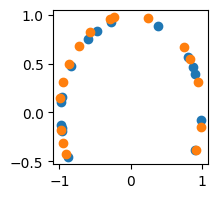

 40%|███████████████████████████████▋                                               | 2007/5000 [01:23<02:00, 24.82it/s]

Epoch: 2001, Loss: 0.1269134283065796
Epoch: 2002, Loss: 0.12432534992694855
Epoch: 2003, Loss: 0.11866738647222519
Epoch: 2004, Loss: 0.14632737636566162
Epoch: 2005, Loss: 0.12260357290506363
Epoch: 2006, Loss: 0.12445680797100067


 40%|███████████████████████████████▊                                               | 2013/5000 [01:23<01:57, 25.32it/s]

Epoch: 2007, Loss: 0.123046875
Epoch: 2008, Loss: 0.12005221843719482
Epoch: 2009, Loss: 0.10648570954799652
Epoch: 2010, Loss: 0.11134156584739685
Epoch: 2011, Loss: 0.12389007955789566
Epoch: 2012, Loss: 0.1340692639350891


 40%|███████████████████████████████▉                                               | 2019/5000 [01:23<01:53, 26.16it/s]

Epoch: 2013, Loss: 0.1332041323184967
Epoch: 2014, Loss: 0.10967940837144852
Epoch: 2015, Loss: 0.11149828135967255
Epoch: 2016, Loss: 0.1368458867073059
Epoch: 2017, Loss: 0.11601769924163818
Epoch: 2018, Loss: 0.1588103026151657


 40%|███████████████████████████████▉                                               | 2025/5000 [01:24<01:49, 27.24it/s]

Epoch: 2019, Loss: 0.11315900832414627
Epoch: 2020, Loss: 0.11588017642498016
Epoch: 2021, Loss: 0.125620037317276
Epoch: 2022, Loss: 0.11510366201400757
Epoch: 2023, Loss: 0.12345100939273834
Epoch: 2024, Loss: 0.11335238069295883


 41%|████████████████████████████████                                               | 2031/5000 [01:24<01:46, 27.99it/s]

Epoch: 2025, Loss: 0.12467486411333084
Epoch: 2026, Loss: 0.11487025022506714
Epoch: 2027, Loss: 0.14345276355743408
Epoch: 2028, Loss: 0.11413069069385529
Epoch: 2029, Loss: 0.12456493824720383
Epoch: 2030, Loss: 0.1233106404542923


 41%|████████████████████████████████▏                                              | 2037/5000 [01:24<01:49, 26.98it/s]

Epoch: 2031, Loss: 0.10754580795764923
Epoch: 2032, Loss: 0.13394394516944885
Epoch: 2033, Loss: 0.1309308409690857
Epoch: 2034, Loss: 0.11510017514228821
Epoch: 2035, Loss: 0.12935078144073486
Epoch: 2036, Loss: 0.1331128627061844


 41%|████████████████████████████████▎                                              | 2043/5000 [01:24<01:53, 25.97it/s]

Epoch: 2037, Loss: 0.12170115858316422
Epoch: 2038, Loss: 0.11153122782707214
Epoch: 2039, Loss: 0.1343822479248047
Epoch: 2040, Loss: 0.11925169825553894
Epoch: 2041, Loss: 0.1245746910572052
Epoch: 2042, Loss: 0.1098623275756836


 41%|████████████████████████████████▎                                              | 2046/5000 [01:24<01:59, 24.78it/s]

Epoch: 2043, Loss: 0.11176170408725739
Epoch: 2044, Loss: 0.12957581877708435
Epoch: 2045, Loss: 0.10837902128696442
Epoch: 2046, Loss: 0.11512531340122223
Epoch: 2047, Loss: 0.12752412259578705


 41%|████████████████████████████████▍                                              | 2052/5000 [01:25<01:57, 25.02it/s]

Epoch: 2048, Loss: 0.11991454660892487
Epoch: 2049, Loss: 0.12896597385406494
Epoch: 2050, Loss: 0.11558188498020172
Epoch: 2051, Loss: 0.11146771907806396
Epoch: 2052, Loss: 0.11642614006996155
Epoch: 2053, Loss: 0.12935468554496765


 41%|████████████████████████████████▌                                              | 2058/5000 [01:25<01:52, 26.12it/s]

Epoch: 2054, Loss: 0.115046925842762
Epoch: 2055, Loss: 0.15410952270030975
Epoch: 2056, Loss: 0.13936540484428406
Epoch: 2057, Loss: 0.11740551888942719
Epoch: 2058, Loss: 0.1253245621919632
Epoch: 2059, Loss: 0.12083162367343903


 41%|████████████████████████████████▌                                              | 2064/5000 [01:25<01:47, 27.23it/s]

Epoch: 2060, Loss: 0.11268310248851776
Epoch: 2061, Loss: 0.1303396075963974
Epoch: 2062, Loss: 0.13783912360668182
Epoch: 2063, Loss: 0.12637192010879517
Epoch: 2064, Loss: 0.12232105433940887
Epoch: 2065, Loss: 0.11682331562042236


 41%|████████████████████████████████▋                                              | 2070/5000 [01:25<01:47, 27.37it/s]

Epoch: 2066, Loss: 0.12887655198574066
Epoch: 2067, Loss: 0.14291658997535706
Epoch: 2068, Loss: 0.12089414894580841
Epoch: 2069, Loss: 0.12629450857639313
Epoch: 2070, Loss: 0.11824226379394531
Epoch: 2071, Loss: 0.11474241316318512


 42%|████████████████████████████████▊                                              | 2076/5000 [01:26<01:46, 27.35it/s]

Epoch: 2072, Loss: 0.12700839340686798
Epoch: 2073, Loss: 0.12937141954898834
Epoch: 2074, Loss: 0.11669057607650757
Epoch: 2075, Loss: 0.12080351263284683
Epoch: 2076, Loss: 0.12746572494506836
Epoch: 2077, Loss: 0.1242050901055336


 42%|████████████████████████████████▉                                              | 2082/5000 [01:26<01:43, 28.06it/s]

Epoch: 2078, Loss: 0.127811461687088
Epoch: 2079, Loss: 0.1212071031332016
Epoch: 2080, Loss: 0.11266721785068512
Epoch: 2081, Loss: 0.1179957389831543
Epoch: 2082, Loss: 0.1334720253944397
Epoch: 2083, Loss: 0.12129852175712585


 42%|████████████████████████████████▉                                              | 2088/5000 [01:26<01:47, 27.12it/s]

Epoch: 2084, Loss: 0.13936182856559753
Epoch: 2085, Loss: 0.11322995275259018
Epoch: 2086, Loss: 0.13950388133525848
Epoch: 2087, Loss: 0.1142469048500061
Epoch: 2088, Loss: 0.17341089248657227
Epoch: 2089, Loss: 0.12022358179092407


 42%|█████████████████████████████████                                              | 2094/5000 [01:26<01:49, 26.61it/s]

Epoch: 2090, Loss: 0.13089768588542938
Epoch: 2091, Loss: 0.12640245258808136
Epoch: 2092, Loss: 0.12772709131240845
Epoch: 2093, Loss: 0.14213019609451294
Epoch: 2094, Loss: 0.11850587278604507
Epoch: 2095, Loss: 0.12327343970537186


 42%|█████████████████████████████████▏                                             | 2100/5000 [01:26<01:50, 26.25it/s]

Epoch: 2096, Loss: 0.11568552255630493
Epoch: 2097, Loss: 0.14327463507652283
Epoch: 2098, Loss: 0.13349264860153198
Epoch: 2099, Loss: 0.11254282295703888
Epoch: 2100, Loss: 0.11599989235401154
Epoch: 2101, Loss: 0.14144369959831238


 42%|█████████████████████████████████▎                                             | 2106/5000 [01:27<01:48, 26.57it/s]

Epoch: 2102, Loss: 0.11604767292737961
Epoch: 2103, Loss: 0.13105425238609314
Epoch: 2104, Loss: 0.11184035241603851
Epoch: 2105, Loss: 0.12150061130523682
Epoch: 2106, Loss: 0.12232007086277008
Epoch: 2107, Loss: 0.12790700793266296


 42%|█████████████████████████████████▎                                             | 2112/5000 [01:27<01:45, 27.43it/s]

Epoch: 2108, Loss: 0.11938106268644333
Epoch: 2109, Loss: 0.12503355741500854
Epoch: 2110, Loss: 0.1490757167339325
Epoch: 2111, Loss: 0.1364416927099228
Epoch: 2112, Loss: 0.11625295877456665
Epoch: 2113, Loss: 0.1268353909254074


 42%|█████████████████████████████████▍                                             | 2118/5000 [01:27<01:44, 27.45it/s]

Epoch: 2114, Loss: 0.12882408499717712
Epoch: 2115, Loss: 0.12233082950115204
Epoch: 2116, Loss: 0.11367969959974289
Epoch: 2117, Loss: 0.11612676084041595
Epoch: 2118, Loss: 0.13262426853179932
Epoch: 2119, Loss: 0.1550525426864624


 42%|█████████████████████████████████▌                                             | 2124/5000 [01:27<01:44, 27.57it/s]

Epoch: 2120, Loss: 0.14068889617919922
Epoch: 2121, Loss: 0.13059218227863312
Epoch: 2122, Loss: 0.12396708875894547
Epoch: 2123, Loss: 0.12311514467000961
Epoch: 2124, Loss: 0.11313074082136154
Epoch: 2125, Loss: 0.11651505529880524


 43%|█████████████████████████████████▋                                             | 2130/5000 [01:28<01:54, 25.07it/s]

Epoch: 2126, Loss: 0.11906734853982925
Epoch: 2127, Loss: 0.13498622179031372
Epoch: 2128, Loss: 0.1151295155286789
Epoch: 2129, Loss: 0.1249932199716568
Epoch: 2130, Loss: 0.11451652646064758


 43%|█████████████████████████████████▋                                             | 2136/5000 [01:28<01:52, 25.53it/s]

Epoch: 2131, Loss: 0.12375055998563766
Epoch: 2132, Loss: 0.13731516897678375
Epoch: 2133, Loss: 0.12821850180625916
Epoch: 2134, Loss: 0.12616300582885742
Epoch: 2135, Loss: 0.1224939227104187
Epoch: 2136, Loss: 0.12228496372699738


 43%|█████████████████████████████████▊                                             | 2142/5000 [01:28<01:51, 25.67it/s]

Epoch: 2137, Loss: 0.11062514781951904
Epoch: 2138, Loss: 0.11930914223194122
Epoch: 2139, Loss: 0.13038703799247742
Epoch: 2140, Loss: 0.14509326219558716
Epoch: 2141, Loss: 0.11456102132797241
Epoch: 2142, Loss: 0.12933549284934998


 43%|█████████████████████████████████▉                                             | 2149/5000 [01:28<01:43, 27.61it/s]

Epoch: 2143, Loss: 0.12764139473438263
Epoch: 2144, Loss: 0.12097422033548355
Epoch: 2145, Loss: 0.11119973659515381
Epoch: 2146, Loss: 0.15192179381847382
Epoch: 2147, Loss: 0.1208031177520752
Epoch: 2148, Loss: 0.14571595191955566


 43%|██████████████████████████████████                                             | 2155/5000 [01:28<01:44, 27.15it/s]

Epoch: 2149, Loss: 0.12626570463180542
Epoch: 2150, Loss: 0.1295628845691681
Epoch: 2151, Loss: 0.12103990465402603
Epoch: 2152, Loss: 0.13327515125274658
Epoch: 2153, Loss: 0.1261744499206543
Epoch: 2154, Loss: 0.1214209496974945


 43%|██████████████████████████████████▏                                            | 2161/5000 [01:29<01:42, 27.60it/s]

Epoch: 2155, Loss: 0.1266002357006073
Epoch: 2156, Loss: 0.11143949627876282
Epoch: 2157, Loss: 0.12141218036413193
Epoch: 2158, Loss: 0.1195121705532074
Epoch: 2159, Loss: 0.12507088482379913
Epoch: 2160, Loss: 0.11007645726203918


 43%|██████████████████████████████████▏                                            | 2167/5000 [01:29<01:44, 27.23it/s]

Epoch: 2161, Loss: 0.1177295446395874
Epoch: 2162, Loss: 0.12105674296617508
Epoch: 2163, Loss: 0.12381980568170547
Epoch: 2164, Loss: 0.11273375153541565
Epoch: 2165, Loss: 0.13196949660778046
Epoch: 2166, Loss: 0.12722867727279663


 43%|██████████████████████████████████▎                                            | 2173/5000 [01:29<01:45, 26.92it/s]

Epoch: 2167, Loss: 0.11533575505018234
Epoch: 2168, Loss: 0.13699890673160553
Epoch: 2169, Loss: 0.12778857350349426
Epoch: 2170, Loss: 0.1344200074672699
Epoch: 2171, Loss: 0.12984412908554077
Epoch: 2172, Loss: 0.15163010358810425


 44%|██████████████████████████████████▍                                            | 2179/5000 [01:29<01:44, 27.02it/s]

Epoch: 2173, Loss: 0.10825839638710022
Epoch: 2174, Loss: 0.12050186097621918
Epoch: 2175, Loss: 0.12174555659294128
Epoch: 2176, Loss: 0.1343350112438202
Epoch: 2177, Loss: 0.13448017835617065
Epoch: 2178, Loss: 0.11524254083633423


 44%|██████████████████████████████████▌                                            | 2185/5000 [01:30<01:47, 26.31it/s]

Epoch: 2179, Loss: 0.1316608488559723
Epoch: 2180, Loss: 0.12203666567802429
Epoch: 2181, Loss: 0.13737526535987854
Epoch: 2182, Loss: 0.1331178843975067
Epoch: 2183, Loss: 0.10866638273000717
Epoch: 2184, Loss: 0.12572042644023895


 44%|██████████████████████████████████▌                                            | 2191/5000 [01:30<01:44, 26.82it/s]

Epoch: 2185, Loss: 0.1347222626209259
Epoch: 2186, Loss: 0.11143630743026733
Epoch: 2187, Loss: 0.12493214011192322
Epoch: 2188, Loss: 0.13397692143917084
Epoch: 2189, Loss: 0.13980118930339813
Epoch: 2190, Loss: 0.11512578278779984


 44%|██████████████████████████████████▋                                            | 2197/5000 [01:30<01:44, 26.72it/s]

Epoch: 2191, Loss: 0.10873644053936005
Epoch: 2192, Loss: 0.11742451041936874
Epoch: 2193, Loss: 0.12171889841556549
Epoch: 2194, Loss: 0.1165715903043747
Epoch: 2195, Loss: 0.12629221379756927
Epoch: 2196, Loss: 0.22352334856987


 44%|██████████████████████████████████▊                                            | 2200/5000 [01:30<01:45, 26.62it/s]

Epoch: 2197, Loss: 0.1252402514219284
Epoch: 2198, Loss: 0.11806807667016983
Epoch: 2199, Loss: 0.11485778540372849
Epoch: 2200, Loss: 0.12317177653312683


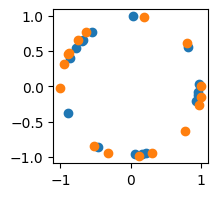

 44%|██████████████████████████████████▊                                            | 2206/5000 [01:30<01:56, 23.96it/s]

Epoch: 2201, Loss: 0.11285188049077988
Epoch: 2202, Loss: 0.1208510622382164
Epoch: 2203, Loss: 0.12111371755599976
Epoch: 2204, Loss: 0.12295357137918472
Epoch: 2205, Loss: 0.11565123498439789
Epoch: 2206, Loss: 0.12867997586727142


 44%|██████████████████████████████████▉                                            | 2212/5000 [01:31<01:50, 25.13it/s]

Epoch: 2207, Loss: 0.11804277449846268
Epoch: 2208, Loss: 0.12999603152275085
Epoch: 2209, Loss: 0.11895367503166199
Epoch: 2210, Loss: 0.12474605441093445
Epoch: 2211, Loss: 0.13133814930915833
Epoch: 2212, Loss: 0.16218525171279907


 44%|███████████████████████████████████                                            | 2218/5000 [01:31<01:48, 25.67it/s]

Epoch: 2213, Loss: 0.13209858536720276
Epoch: 2214, Loss: 0.13461829721927643
Epoch: 2215, Loss: 0.1307772397994995
Epoch: 2216, Loss: 0.1313745528459549
Epoch: 2217, Loss: 0.13798180222511292
Epoch: 2218, Loss: 0.11855070292949677


 44%|███████████████████████████████████▏                                           | 2224/5000 [01:31<01:43, 26.88it/s]

Epoch: 2219, Loss: 0.12031233310699463
Epoch: 2220, Loss: 0.1289481520652771
Epoch: 2221, Loss: 0.10727409273386002
Epoch: 2222, Loss: 0.11097664386034012
Epoch: 2223, Loss: 0.13491719961166382
Epoch: 2224, Loss: 0.12122124433517456


 45%|███████████████████████████████████▏                                           | 2230/5000 [01:31<01:40, 27.47it/s]

Epoch: 2225, Loss: 0.12770454585552216
Epoch: 2226, Loss: 0.11291798949241638
Epoch: 2227, Loss: 0.13174688816070557
Epoch: 2228, Loss: 0.11590129137039185
Epoch: 2229, Loss: 0.12209150195121765
Epoch: 2230, Loss: 0.12075497955083847


 45%|███████████████████████████████████▎                                           | 2236/5000 [01:32<01:41, 27.33it/s]

Epoch: 2231, Loss: 0.1360798180103302
Epoch: 2232, Loss: 0.11460760235786438
Epoch: 2233, Loss: 0.1237175464630127
Epoch: 2234, Loss: 0.1224614679813385
Epoch: 2235, Loss: 0.1334853172302246
Epoch: 2236, Loss: 0.12522819638252258


 45%|███████████████████████████████████▍                                           | 2242/5000 [01:32<01:44, 26.50it/s]

Epoch: 2237, Loss: 0.11877033114433289
Epoch: 2238, Loss: 0.13065025210380554
Epoch: 2239, Loss: 0.14743992686271667
Epoch: 2240, Loss: 0.11365656554698944
Epoch: 2241, Loss: 0.11752723902463913
Epoch: 2242, Loss: 0.12408845126628876


 45%|███████████████████████████████████▌                                           | 2248/5000 [01:32<01:47, 25.60it/s]

Epoch: 2243, Loss: 0.1102840006351471
Epoch: 2244, Loss: 0.11739890277385712
Epoch: 2245, Loss: 0.1265617161989212
Epoch: 2246, Loss: 0.12089196592569351
Epoch: 2247, Loss: 0.13344493508338928
Epoch: 2248, Loss: 0.11606897413730621


 45%|███████████████████████████████████▌                                           | 2254/5000 [01:32<01:41, 27.00it/s]

Epoch: 2249, Loss: 0.13211451470851898
Epoch: 2250, Loss: 0.12786637246608734
Epoch: 2251, Loss: 0.1536926031112671
Epoch: 2252, Loss: 0.11276058852672577
Epoch: 2253, Loss: 0.11285244673490524
Epoch: 2254, Loss: 0.13866953551769257


 45%|███████████████████████████████████▋                                           | 2260/5000 [01:32<01:43, 26.54it/s]

Epoch: 2255, Loss: 0.11085150390863419
Epoch: 2256, Loss: 0.14890800416469574
Epoch: 2257, Loss: 0.11659529060125351
Epoch: 2258, Loss: 0.12682688236236572
Epoch: 2259, Loss: 0.12543964385986328
Epoch: 2260, Loss: 0.11462932825088501


 45%|███████████████████████████████████▊                                           | 2266/5000 [01:33<01:49, 25.06it/s]

Epoch: 2261, Loss: 0.13762438297271729
Epoch: 2262, Loss: 0.11021304875612259
Epoch: 2263, Loss: 0.13430552184581757
Epoch: 2264, Loss: 0.12154677510261536
Epoch: 2265, Loss: 0.12781094014644623


 45%|███████████████████████████████████▉                                           | 2272/5000 [01:33<01:46, 25.63it/s]

Epoch: 2266, Loss: 0.12977029383182526
Epoch: 2267, Loss: 0.13349522650241852
Epoch: 2268, Loss: 0.130855530500412
Epoch: 2269, Loss: 0.12051732838153839
Epoch: 2270, Loss: 0.1454383134841919
Epoch: 2271, Loss: 0.111088827252388


 46%|███████████████████████████████████▉                                           | 2278/5000 [01:33<01:43, 26.35it/s]

Epoch: 2272, Loss: 0.12107302248477936
Epoch: 2273, Loss: 0.1206456646323204
Epoch: 2274, Loss: 0.12803268432617188
Epoch: 2275, Loss: 0.11578179895877838
Epoch: 2276, Loss: 0.12086844444274902
Epoch: 2277, Loss: 0.11778680235147476


 46%|████████████████████████████████████                                           | 2284/5000 [01:33<01:44, 25.92it/s]

Epoch: 2278, Loss: 0.120432548224926
Epoch: 2279, Loss: 0.13484448194503784
Epoch: 2280, Loss: 0.13413557410240173
Epoch: 2281, Loss: 0.1304638683795929
Epoch: 2282, Loss: 0.12886790931224823
Epoch: 2283, Loss: 0.1121019795536995


 46%|████████████████████████████████████▏                                          | 2290/5000 [01:34<01:42, 26.35it/s]

Epoch: 2284, Loss: 0.12269404530525208
Epoch: 2285, Loss: 0.139525905251503
Epoch: 2286, Loss: 0.12839165329933167
Epoch: 2287, Loss: 0.12846224009990692
Epoch: 2288, Loss: 0.1240358054637909
Epoch: 2289, Loss: 0.1180005744099617


 46%|████████████████████████████████████▎                                          | 2296/5000 [01:34<01:42, 26.37it/s]

Epoch: 2290, Loss: 0.11787557601928711
Epoch: 2291, Loss: 0.15116757154464722
Epoch: 2292, Loss: 0.1259239763021469
Epoch: 2293, Loss: 0.13289116322994232
Epoch: 2294, Loss: 0.11928250640630722
Epoch: 2295, Loss: 0.13671335577964783


 46%|████████████████████████████████████▎                                          | 2302/5000 [01:34<01:39, 27.04it/s]

Epoch: 2296, Loss: 0.12104698270559311
Epoch: 2297, Loss: 0.14234934747219086
Epoch: 2298, Loss: 0.1279568076133728
Epoch: 2299, Loss: 0.1299688071012497
Epoch: 2300, Loss: 0.1155082955956459
Epoch: 2301, Loss: 0.1158023402094841


 46%|████████████████████████████████████▍                                          | 2308/5000 [01:34<01:42, 26.25it/s]

Epoch: 2302, Loss: 0.12773549556732178
Epoch: 2303, Loss: 0.1349138617515564
Epoch: 2304, Loss: 0.1269194483757019
Epoch: 2305, Loss: 0.11449068784713745
Epoch: 2306, Loss: 0.1365402191877365
Epoch: 2307, Loss: 0.11063473671674728


 46%|████████████████████████████████████▌                                          | 2314/5000 [01:35<01:44, 25.66it/s]

Epoch: 2308, Loss: 0.11724922060966492
Epoch: 2309, Loss: 0.12277831882238388
Epoch: 2310, Loss: 0.13871514797210693
Epoch: 2311, Loss: 0.11177098006010056
Epoch: 2312, Loss: 0.11139635741710663
Epoch: 2313, Loss: 0.13379842042922974


 46%|████████████████████████████████████▌                                          | 2317/5000 [01:35<01:46, 25.29it/s]

Epoch: 2314, Loss: 0.13206735253334045
Epoch: 2315, Loss: 0.12592442333698273
Epoch: 2316, Loss: 0.12840203940868378
Epoch: 2317, Loss: 0.12822803854942322
Epoch: 2318, Loss: 0.12613260746002197


 46%|████████████████████████████████████▋                                          | 2323/5000 [01:35<01:54, 23.36it/s]

Epoch: 2319, Loss: 0.13585442304611206
Epoch: 2320, Loss: 0.11876370012760162
Epoch: 2321, Loss: 0.12021183967590332
Epoch: 2322, Loss: 0.12154026329517365
Epoch: 2323, Loss: 0.12473184615373611


 47%|████████████████████████████████████▊                                          | 2329/5000 [01:35<01:52, 23.69it/s]

Epoch: 2324, Loss: 0.1238904744386673
Epoch: 2325, Loss: 0.15795816481113434
Epoch: 2326, Loss: 0.13471780717372894
Epoch: 2327, Loss: 0.1401570439338684
Epoch: 2328, Loss: 0.14382925629615784
Epoch: 2329, Loss: 0.12520384788513184


 47%|████████████████████████████████████▉                                          | 2335/5000 [01:35<01:51, 23.89it/s]

Epoch: 2330, Loss: 0.1236339658498764
Epoch: 2331, Loss: 0.11464399099349976
Epoch: 2332, Loss: 0.12759266793727875
Epoch: 2333, Loss: 0.12924081087112427
Epoch: 2334, Loss: 0.16683503985404968


 47%|████████████████████████████████████▉                                          | 2341/5000 [01:36<01:47, 24.78it/s]

Epoch: 2335, Loss: 0.12687018513679504
Epoch: 2336, Loss: 0.12227601557970047
Epoch: 2337, Loss: 0.11850693821907043
Epoch: 2338, Loss: 0.1195436343550682
Epoch: 2339, Loss: 0.11700733006000519
Epoch: 2340, Loss: 0.13153037428855896


 47%|█████████████████████████████████████                                          | 2347/5000 [01:36<01:44, 25.48it/s]

Epoch: 2341, Loss: 0.13149628043174744
Epoch: 2342, Loss: 0.12864696979522705
Epoch: 2343, Loss: 0.10706828534603119
Epoch: 2344, Loss: 0.11923851072788239
Epoch: 2345, Loss: 0.11362485587596893
Epoch: 2346, Loss: 0.12926186621189117


 47%|█████████████████████████████████████▏                                         | 2353/5000 [01:36<01:39, 26.65it/s]

Epoch: 2347, Loss: 0.10916008055210114
Epoch: 2348, Loss: 0.12129966914653778
Epoch: 2349, Loss: 0.1119653582572937
Epoch: 2350, Loss: 0.11538296192884445
Epoch: 2351, Loss: 0.10790881514549255
Epoch: 2352, Loss: 0.12058759480714798


 47%|█████████████████████████████████████▎                                         | 2359/5000 [01:36<01:37, 26.95it/s]

Epoch: 2353, Loss: 0.11142613738775253
Epoch: 2354, Loss: 0.11193034797906876
Epoch: 2355, Loss: 0.13488301634788513
Epoch: 2356, Loss: 0.13785836100578308
Epoch: 2357, Loss: 0.12418137490749359
Epoch: 2358, Loss: 0.11785025894641876


 47%|█████████████████████████████████████▎                                         | 2362/5000 [01:37<01:48, 24.38it/s]

Epoch: 2359, Loss: 0.1214718371629715
Epoch: 2360, Loss: 0.127754807472229
Epoch: 2361, Loss: 0.12122898548841476
Epoch: 2362, Loss: 0.12914371490478516


 47%|█████████████████████████████████████▍                                         | 2368/5000 [01:37<01:46, 24.72it/s]

Epoch: 2363, Loss: 0.13351741433143616
Epoch: 2364, Loss: 0.12529940903186798
Epoch: 2365, Loss: 0.12191146612167358
Epoch: 2366, Loss: 0.12188030779361725
Epoch: 2367, Loss: 0.12010782212018967
Epoch: 2368, Loss: 0.13365307450294495


 47%|█████████████████████████████████████▌                                         | 2374/5000 [01:37<01:44, 25.11it/s]

Epoch: 2369, Loss: 0.12247039377689362
Epoch: 2370, Loss: 0.11653079092502594
Epoch: 2371, Loss: 0.12060173600912094
Epoch: 2372, Loss: 0.12762051820755005
Epoch: 2373, Loss: 0.12668095529079437
Epoch: 2374, Loss: 0.13789230585098267


 48%|█████████████████████████████████████▌                                         | 2380/5000 [01:37<01:44, 25.11it/s]

Epoch: 2375, Loss: 0.12926992774009705
Epoch: 2376, Loss: 0.12964768707752228
Epoch: 2377, Loss: 0.12633858621120453
Epoch: 2378, Loss: 0.11759654432535172
Epoch: 2379, Loss: 0.12537303566932678
Epoch: 2380, Loss: 0.1245119720697403


 48%|█████████████████████████████████████▋                                         | 2386/5000 [01:37<01:39, 26.28it/s]

Epoch: 2381, Loss: 0.1353723406791687
Epoch: 2382, Loss: 0.11487388610839844
Epoch: 2383, Loss: 0.12942469120025635
Epoch: 2384, Loss: 0.11956645548343658
Epoch: 2385, Loss: 0.12685883045196533
Epoch: 2386, Loss: 0.1514909565448761


 48%|█████████████████████████████████████▊                                         | 2392/5000 [01:38<01:39, 26.28it/s]

Epoch: 2387, Loss: 0.11863172799348831
Epoch: 2388, Loss: 0.11210369318723679
Epoch: 2389, Loss: 0.11671623587608337
Epoch: 2390, Loss: 0.12655863165855408
Epoch: 2391, Loss: 0.12070690095424652
Epoch: 2392, Loss: 0.12354742735624313


 48%|█████████████████████████████████████▉                                         | 2398/5000 [01:38<01:38, 26.38it/s]

Epoch: 2393, Loss: 0.13304677605628967
Epoch: 2394, Loss: 0.12323564291000366
Epoch: 2395, Loss: 0.11658735573291779
Epoch: 2396, Loss: 0.13401494920253754
Epoch: 2397, Loss: 0.13204438984394073
Epoch: 2398, Loss: 0.12429670989513397
Epoch: 2399, Loss: 0.10895334929227829
Epoch: 2400, Loss: 0.11552842706441879


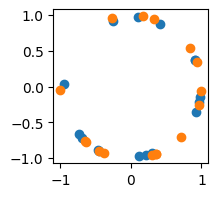

 48%|█████████████████████████████████████▉                                         | 2401/5000 [01:38<01:57, 22.14it/s]

Epoch: 2401, Loss: 0.11844903975725174
Epoch: 2402, Loss: 0.1227509006857872


 48%|█████████████████████████████████████▉                                         | 2404/5000 [01:38<01:54, 22.63it/s]

Epoch: 2403, Loss: 0.10871423780918121
Epoch: 2404, Loss: 0.12689125537872314
Epoch: 2405, Loss: 0.1382768452167511
Epoch: 2406, Loss: 0.1121840700507164


 48%|██████████████████████████████████████                                         | 2407/5000 [01:38<01:52, 23.03it/s]

Epoch: 2407, Loss: 0.18463295698165894


 48%|██████████████████████████████████████▏                                        | 2413/5000 [01:39<01:42, 25.23it/s]

Epoch: 2408, Loss: 0.11827334761619568
Epoch: 2409, Loss: 0.13024061918258667
Epoch: 2410, Loss: 0.11550670862197876
Epoch: 2411, Loss: 0.11471645534038544
Epoch: 2412, Loss: 0.12007074803113937
Epoch: 2413, Loss: 0.12263430655002594


 48%|██████████████████████████████████████▏                                        | 2419/5000 [01:39<01:37, 26.40it/s]

Epoch: 2414, Loss: 0.1290355622768402
Epoch: 2415, Loss: 0.12120424211025238
Epoch: 2416, Loss: 0.11681992560625076
Epoch: 2417, Loss: 0.12030867487192154
Epoch: 2418, Loss: 0.12365417182445526
Epoch: 2419, Loss: 0.12159678339958191


 48%|██████████████████████████████████████▎                                        | 2422/5000 [01:39<01:39, 25.80it/s]

Epoch: 2420, Loss: 0.12141754478216171
Epoch: 2421, Loss: 0.12237284332513809
Epoch: 2422, Loss: 0.11705943197011948
Epoch: 2423, Loss: 0.1248062327504158


 48%|██████████████████████████████████████▎                                        | 2425/5000 [01:39<01:41, 25.25it/s]

Epoch: 2424, Loss: 0.11359045654535294


 49%|██████████████████████████████████████▎                                        | 2428/5000 [01:39<01:39, 25.80it/s]

Epoch: 2425, Loss: 0.12136012315750122
Epoch: 2426, Loss: 0.13164332509040833
Epoch: 2427, Loss: 0.12052954733371735
Epoch: 2428, Loss: 0.12422238290309906
Epoch: 2429, Loss: 0.1216893121600151


 49%|██████████████████████████████████████▍                                        | 2431/5000 [01:39<01:39, 25.94it/s]

Epoch: 2430, Loss: 0.13466104865074158


 49%|██████████████████████████████████████▍                                        | 2434/5000 [01:39<01:39, 25.86it/s]

Epoch: 2431, Loss: 0.11770693957805634
Epoch: 2432, Loss: 0.12487466633319855
Epoch: 2433, Loss: 0.1279086470603943
Epoch: 2434, Loss: 0.12752263247966766
Epoch: 2435, Loss: 0.11515004187822342


 49%|██████████████████████████████████████▌                                        | 2437/5000 [01:39<01:36, 26.56it/s]

Epoch: 2436, Loss: 0.11733276396989822


 49%|██████████████████████████████████████▌                                        | 2440/5000 [01:40<01:34, 26.97it/s]

Epoch: 2437, Loss: 0.12172507494688034
Epoch: 2438, Loss: 0.1334773749113083
Epoch: 2439, Loss: 0.12061230093240738
Epoch: 2440, Loss: 0.12715163826942444
Epoch: 2441, Loss: 0.11558128148317337


 49%|██████████████████████████████████████▌                                        | 2443/5000 [01:40<01:34, 26.94it/s]

Epoch: 2442, Loss: 0.12534980475902557


 49%|██████████████████████████████████████▋                                        | 2446/5000 [01:40<01:34, 27.01it/s]

Epoch: 2443, Loss: 0.14386393129825592
Epoch: 2444, Loss: 0.1208958625793457
Epoch: 2445, Loss: 0.1174301728606224
Epoch: 2446, Loss: 0.1332516074180603
Epoch: 2447, Loss: 0.11679122596979141


 49%|██████████████████████████████████████▋                                        | 2449/5000 [01:40<01:35, 26.64it/s]

Epoch: 2448, Loss: 0.11307008564472198


 49%|██████████████████████████████████████▋                                        | 2452/5000 [01:40<01:37, 26.07it/s]

Epoch: 2449, Loss: 0.12280196696519852
Epoch: 2450, Loss: 0.12991513311862946
Epoch: 2451, Loss: 0.11925871670246124
Epoch: 2452, Loss: 0.12343522906303406
Epoch: 2453, Loss: 0.13914494216442108


 49%|██████████████████████████████████████▊                                        | 2455/5000 [01:40<01:35, 26.52it/s]

Epoch: 2454, Loss: 0.11217862367630005


 49%|██████████████████████████████████████▊                                        | 2458/5000 [01:40<01:33, 27.24it/s]

Epoch: 2455, Loss: 0.12210141122341156
Epoch: 2456, Loss: 0.12444543838500977
Epoch: 2457, Loss: 0.11022345721721649
Epoch: 2458, Loss: 0.1300763338804245
Epoch: 2459, Loss: 0.10884793102741241


 49%|██████████████████████████████████████▉                                        | 2461/5000 [01:40<01:37, 25.93it/s]

Epoch: 2460, Loss: 0.1157395988702774


 49%|██████████████████████████████████████▉                                        | 2464/5000 [01:41<01:38, 25.74it/s]

Epoch: 2461, Loss: 0.13156606256961823
Epoch: 2462, Loss: 0.10534554719924927
Epoch: 2463, Loss: 0.20469781756401062
Epoch: 2464, Loss: 0.11485444009304047
Epoch: 2465, Loss: 0.12253064662218094


 49%|██████████████████████████████████████▉                                        | 2467/5000 [01:41<01:37, 25.95it/s]

Epoch: 2466, Loss: 0.1160239726305008


 49%|███████████████████████████████████████                                        | 2470/5000 [01:41<01:38, 25.80it/s]

Epoch: 2467, Loss: 0.1314019113779068
Epoch: 2468, Loss: 0.12728391587734222
Epoch: 2469, Loss: 0.13711465895175934
Epoch: 2470, Loss: 0.11621838063001633
Epoch: 2471, Loss: 0.12516924738883972


 49%|███████████████████████████████████████                                        | 2473/5000 [01:41<01:36, 26.22it/s]

Epoch: 2472, Loss: 0.12544170022010803


 50%|███████████████████████████████████████                                        | 2476/5000 [01:41<01:36, 26.20it/s]

Epoch: 2473, Loss: 0.1255495250225067
Epoch: 2474, Loss: 0.11495255678892136
Epoch: 2475, Loss: 0.11920049041509628
Epoch: 2476, Loss: 0.12655939161777496
Epoch: 2477, Loss: 0.11603118479251862


 50%|███████████████████████████████████████▏                                       | 2479/5000 [01:41<01:36, 26.03it/s]

Epoch: 2478, Loss: 0.12213563174009323


 50%|███████████████████████████████████████▏                                       | 2482/5000 [01:41<01:43, 24.42it/s]

Epoch: 2479, Loss: 0.12844933569431305
Epoch: 2480, Loss: 0.11104419082403183
Epoch: 2481, Loss: 0.1393309384584427
Epoch: 2482, Loss: 0.1297752559185028


 50%|███████████████████████████████████████▎                                       | 2485/5000 [01:41<01:37, 25.66it/s]

Epoch: 2483, Loss: 0.1337989717721939
Epoch: 2484, Loss: 0.14143505692481995


 50%|███████████████████████████████████████▎                                       | 2488/5000 [01:41<01:36, 26.16it/s]

Epoch: 2485, Loss: 0.13158202171325684
Epoch: 2486, Loss: 0.13196322321891785
Epoch: 2487, Loss: 0.11620589345693588
Epoch: 2488, Loss: 0.1287514865398407


 50%|███████████████████████████████████████▍                                       | 2494/5000 [01:42<01:47, 23.41it/s]

Epoch: 2489, Loss: 0.11561648547649384
Epoch: 2490, Loss: 0.12027546763420105
Epoch: 2491, Loss: 0.13979527354240417
Epoch: 2492, Loss: 0.1251252144575119
Epoch: 2493, Loss: 0.11600212752819061
Epoch: 2494, Loss: 0.11606462299823761


 50%|███████████████████████████████████████▌                                       | 2500/5000 [01:42<01:44, 23.92it/s]

Epoch: 2495, Loss: 0.1266903430223465
Epoch: 2496, Loss: 0.12276960909366608
Epoch: 2497, Loss: 0.14755861461162567
Epoch: 2498, Loss: 0.11698998510837555
Epoch: 2499, Loss: 0.11245648562908173


 50%|███████████████████████████████████████▌                                       | 2503/5000 [01:42<01:44, 23.99it/s]

Epoch: 2500, Loss: 0.11211700737476349
Epoch: 2501, Loss: 0.12900906801223755
Epoch: 2502, Loss: 0.13061390817165375
Epoch: 2503, Loss: 0.1338263601064682
Epoch: 2504, Loss: 0.11144457012414932


 50%|███████████████████████████████████████▋                                       | 2509/5000 [01:42<01:43, 24.02it/s]

Epoch: 2505, Loss: 0.13116198778152466
Epoch: 2506, Loss: 0.12164077907800674
Epoch: 2507, Loss: 0.12182595580816269
Epoch: 2508, Loss: 0.10971974581480026
Epoch: 2509, Loss: 0.10953814536333084
Epoch: 2510, Loss: 0.11223717033863068


 50%|███████████████████████████████████████▋                                       | 2515/5000 [01:43<01:46, 23.35it/s]

Epoch: 2511, Loss: 0.1227707788348198
Epoch: 2512, Loss: 0.12540394067764282
Epoch: 2513, Loss: 0.11776131391525269
Epoch: 2514, Loss: 0.13238510489463806
Epoch: 2515, Loss: 0.12338151782751083


 50%|███████████████████████████████████████▊                                       | 2521/5000 [01:43<01:42, 24.23it/s]

Epoch: 2516, Loss: 0.12310577929019928
Epoch: 2517, Loss: 0.12266124039888382
Epoch: 2518, Loss: 0.1197952926158905
Epoch: 2519, Loss: 0.11480126529932022
Epoch: 2520, Loss: 0.11825985461473465
Epoch: 2521, Loss: 0.11733806878328323


 51%|███████████████████████████████████████▉                                       | 2527/5000 [01:43<01:45, 23.42it/s]

Epoch: 2522, Loss: 0.12687860429286957
Epoch: 2523, Loss: 0.11844391375780106
Epoch: 2524, Loss: 0.13264445960521698
Epoch: 2525, Loss: 0.12436489760875702
Epoch: 2526, Loss: 0.11706248670816422


 51%|███████████████████████████████████████▉                                       | 2530/5000 [01:43<01:43, 23.98it/s]

Epoch: 2527, Loss: 0.12464630603790283
Epoch: 2528, Loss: 0.11913653463125229
Epoch: 2529, Loss: 0.12195029854774475
Epoch: 2530, Loss: 0.13491055369377136
Epoch: 2531, Loss: 0.12445081025362015


 51%|████████████████████████████████████████                                       | 2536/5000 [01:43<01:44, 23.68it/s]

Epoch: 2532, Loss: 0.12512299418449402
Epoch: 2533, Loss: 0.1183403804898262
Epoch: 2534, Loss: 0.12962165474891663
Epoch: 2535, Loss: 0.13614347577095032
Epoch: 2536, Loss: 0.11739888042211533
Epoch: 2537, Loss: 0.14302995800971985


 51%|████████████████████████████████████████▏                                      | 2542/5000 [01:44<01:41, 24.14it/s]

Epoch: 2538, Loss: 0.1172720193862915
Epoch: 2539, Loss: 0.1092950627207756
Epoch: 2540, Loss: 0.12482234835624695
Epoch: 2541, Loss: 0.12542614340782166
Epoch: 2542, Loss: 0.11423659324645996


 51%|████████████████████████████████████████▎                                      | 2548/5000 [01:44<01:41, 24.22it/s]

Epoch: 2543, Loss: 0.1579662412405014
Epoch: 2544, Loss: 0.11507081985473633
Epoch: 2545, Loss: 0.12269625812768936
Epoch: 2546, Loss: 0.12081708014011383
Epoch: 2547, Loss: 0.12337709963321686


 51%|████████████████████████████████████████▎                                      | 2551/5000 [01:44<01:56, 21.06it/s]

Epoch: 2548, Loss: 0.12481439113616943
Epoch: 2549, Loss: 0.10841363668441772
Epoch: 2550, Loss: 0.12415200471878052


 51%|████████████████████████████████████████▎                                      | 2554/5000 [01:44<02:17, 17.79it/s]

Epoch: 2551, Loss: 0.1409611701965332
Epoch: 2552, Loss: 0.11747869104146957
Epoch: 2553, Loss: 0.12266736477613449
Epoch: 2554, Loss: 0.13965877890586853


 51%|████████████████████████████████████████▍                                      | 2560/5000 [01:45<02:03, 19.76it/s]

Epoch: 2555, Loss: 0.11739838123321533
Epoch: 2556, Loss: 0.1201058104634285
Epoch: 2557, Loss: 0.12158884108066559
Epoch: 2558, Loss: 0.12542760372161865
Epoch: 2559, Loss: 0.12517400085926056


 51%|████████████████████████████████████████▍                                      | 2563/5000 [01:45<02:18, 17.62it/s]

Epoch: 2560, Loss: 0.12534116208553314
Epoch: 2561, Loss: 0.10996010899543762
Epoch: 2562, Loss: 0.12245085835456848


 51%|████████████████████████████████████████▌                                      | 2565/5000 [01:45<02:47, 14.56it/s]

Epoch: 2563, Loss: 0.1265651434659958
Epoch: 2564, Loss: 0.12495107203722
Epoch: 2565, Loss: 0.134887233376503


 51%|████████████████████████████████████████▌                                      | 2567/5000 [01:45<02:48, 14.42it/s]

Epoch: 2566, Loss: 0.129714697599411
Epoch: 2567, Loss: 0.13443857431411743


 51%|████████████████████████████████████████▌                                      | 2571/5000 [01:46<03:10, 12.76it/s]

Epoch: 2568, Loss: 0.12769874930381775
Epoch: 2569, Loss: 0.12913772463798523
Epoch: 2570, Loss: 0.13180387020111084


 52%|████████████████████████████████████████▋                                      | 2575/5000 [01:46<02:54, 13.89it/s]

Epoch: 2571, Loss: 0.1160895824432373
Epoch: 2572, Loss: 0.11044300347566605
Epoch: 2573, Loss: 0.1150820255279541
Epoch: 2574, Loss: 0.1220993623137474


 52%|████████████████████████████████████████▋                                      | 2578/5000 [01:46<02:32, 15.88it/s]

Epoch: 2575, Loss: 0.11583833396434784
Epoch: 2576, Loss: 0.12835988402366638
Epoch: 2577, Loss: 0.12154553830623627
Epoch: 2578, Loss: 0.11232675611972809


 52%|████████████████████████████████████████▊                                      | 2583/5000 [01:46<02:23, 16.84it/s]

Epoch: 2579, Loss: 0.1286718249320984
Epoch: 2580, Loss: 0.1246357262134552
Epoch: 2581, Loss: 0.12550991773605347
Epoch: 2582, Loss: 0.13394057750701904


 52%|████████████████████████████████████████▊                                      | 2587/5000 [01:47<02:24, 16.64it/s]

Epoch: 2583, Loss: 0.11808855086565018
Epoch: 2584, Loss: 0.11666363477706909
Epoch: 2585, Loss: 0.1192590594291687
Epoch: 2586, Loss: 0.12614630162715912


 52%|████████████████████████████████████████▉                                      | 2592/5000 [01:47<02:05, 19.26it/s]

Epoch: 2587, Loss: 0.10880742222070694
Epoch: 2588, Loss: 0.12225400656461716
Epoch: 2589, Loss: 0.11660513281822205
Epoch: 2590, Loss: 0.12050295621156693
Epoch: 2591, Loss: 0.12699776887893677


 52%|█████████████████████████████████████████                                      | 2595/5000 [01:47<01:57, 20.49it/s]

Epoch: 2592, Loss: 0.1398714780807495
Epoch: 2593, Loss: 0.13831472396850586
Epoch: 2594, Loss: 0.14184652268886566
Epoch: 2595, Loss: 0.11556986719369888
Epoch: 2596, Loss: 0.12205284088850021


 52%|█████████████████████████████████████████                                      | 2598/5000 [01:47<01:54, 20.96it/s]

Epoch: 2597, Loss: 0.13253885507583618
Epoch: 2598, Loss: 0.12281818687915802
Epoch: 2599, Loss: 0.13486488163471222
Epoch: 2600, Loss: 0.1380697339773178


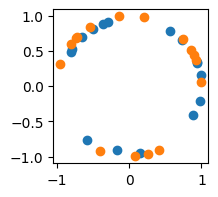

 52%|█████████████████████████████████████████▏                                     | 2607/5000 [01:47<01:48, 22.00it/s]

Epoch: 2601, Loss: 0.11426608264446259
Epoch: 2602, Loss: 0.11206769943237305
Epoch: 2603, Loss: 0.11617352068424225
Epoch: 2604, Loss: 0.112398162484169
Epoch: 2605, Loss: 0.12892326712608337
Epoch: 2606, Loss: 0.121905617415905


 52%|█████████████████████████████████████████▎                                     | 2613/5000 [01:48<01:36, 24.75it/s]

Epoch: 2607, Loss: 0.11158381402492523
Epoch: 2608, Loss: 0.11642126739025116
Epoch: 2609, Loss: 0.12979227304458618
Epoch: 2610, Loss: 0.12197832018136978
Epoch: 2611, Loss: 0.12847882509231567
Epoch: 2612, Loss: 0.11118095368146896


 52%|█████████████████████████████████████████▍                                     | 2619/5000 [01:48<01:32, 25.70it/s]

Epoch: 2613, Loss: 0.12187515944242477
Epoch: 2614, Loss: 0.14824189245700836
Epoch: 2615, Loss: 0.11913637816905975
Epoch: 2616, Loss: 0.1272011250257492
Epoch: 2617, Loss: 0.11218390613794327
Epoch: 2618, Loss: 0.12012556195259094


 52%|█████████████████████████████████████████▍                                     | 2625/5000 [01:48<01:28, 26.84it/s]

Epoch: 2619, Loss: 0.11754845827817917
Epoch: 2620, Loss: 0.11834046244621277
Epoch: 2621, Loss: 0.12583236396312714
Epoch: 2622, Loss: 0.1394314020872116
Epoch: 2623, Loss: 0.1210986003279686
Epoch: 2624, Loss: 0.12108895182609558


 53%|█████████████████████████████████████████▌                                     | 2631/5000 [01:48<01:31, 25.92it/s]

Epoch: 2625, Loss: 0.10627743601799011
Epoch: 2626, Loss: 0.1429997682571411
Epoch: 2627, Loss: 0.12499083578586578
Epoch: 2628, Loss: 0.11376135796308517
Epoch: 2629, Loss: 0.12367479503154755
Epoch: 2630, Loss: 0.1313849687576294


 53%|█████████████████████████████████████████▋                                     | 2637/5000 [01:49<01:31, 25.69it/s]

Epoch: 2631, Loss: 0.13312196731567383
Epoch: 2632, Loss: 0.1329905390739441
Epoch: 2633, Loss: 0.1406191885471344
Epoch: 2634, Loss: 0.12418019026517868
Epoch: 2635, Loss: 0.11767223477363586
Epoch: 2636, Loss: 0.11792129278182983


 53%|█████████████████████████████████████████▊                                     | 2643/5000 [01:49<01:32, 25.51it/s]

Epoch: 2637, Loss: 0.14756038784980774
Epoch: 2638, Loss: 0.12090009450912476
Epoch: 2639, Loss: 0.12287743389606476
Epoch: 2640, Loss: 0.1242930144071579
Epoch: 2641, Loss: 0.11987902969121933
Epoch: 2642, Loss: 0.12452438473701477


 53%|█████████████████████████████████████████▊                                     | 2649/5000 [01:49<01:31, 25.58it/s]

Epoch: 2643, Loss: 0.11393050104379654
Epoch: 2644, Loss: 0.1288352906703949
Epoch: 2645, Loss: 0.1244734451174736
Epoch: 2646, Loss: 0.12228130549192429
Epoch: 2647, Loss: 0.1172737330198288
Epoch: 2648, Loss: 0.11343412846326828


 53%|█████████████████████████████████████████▉                                     | 2655/5000 [01:49<01:31, 25.62it/s]

Epoch: 2649, Loss: 0.14386051893234253
Epoch: 2650, Loss: 0.12216465175151825
Epoch: 2651, Loss: 0.12455392628908157
Epoch: 2652, Loss: 0.11982965469360352
Epoch: 2653, Loss: 0.12527018785476685
Epoch: 2654, Loss: 0.12382511794567108


 53%|██████████████████████████████████████████                                     | 2661/5000 [01:50<01:30, 25.73it/s]

Epoch: 2655, Loss: 0.11952558904886246
Epoch: 2656, Loss: 0.12256600707769394
Epoch: 2657, Loss: 0.12556178867816925
Epoch: 2658, Loss: 0.11941765993833542
Epoch: 2659, Loss: 0.1201571598649025
Epoch: 2660, Loss: 0.11486655473709106


 53%|██████████████████████████████████████████▏                                    | 2667/5000 [01:50<01:32, 25.21it/s]

Epoch: 2661, Loss: 0.12701982259750366
Epoch: 2662, Loss: 0.11526820063591003
Epoch: 2663, Loss: 0.1394842267036438
Epoch: 2664, Loss: 0.1378093659877777
Epoch: 2665, Loss: 0.11970304697751999
Epoch: 2666, Loss: 0.1207505390048027


 53%|██████████████████████████████████████████▏                                    | 2673/5000 [01:50<01:30, 25.72it/s]

Epoch: 2667, Loss: 0.12008494138717651
Epoch: 2668, Loss: 0.11895130574703217
Epoch: 2669, Loss: 0.1205904632806778
Epoch: 2670, Loss: 0.13293135166168213
Epoch: 2671, Loss: 0.16420316696166992
Epoch: 2672, Loss: 0.14956194162368774


 54%|██████████████████████████████████████████▎                                    | 2676/5000 [01:50<01:31, 25.28it/s]

Epoch: 2673, Loss: 0.1274982988834381
Epoch: 2674, Loss: 0.11919398605823517
Epoch: 2675, Loss: 0.12660226225852966
Epoch: 2676, Loss: 0.12941791117191315
Epoch: 2677, Loss: 0.1271124929189682


 54%|██████████████████████████████████████████▍                                    | 2682/5000 [01:50<01:40, 23.01it/s]

Epoch: 2678, Loss: 0.15694960951805115
Epoch: 2679, Loss: 0.14176040887832642
Epoch: 2680, Loss: 0.12064440548419952
Epoch: 2681, Loss: 0.11367027461528778


 54%|██████████████████████████████████████████▍                                    | 2685/5000 [01:51<01:56, 19.79it/s]

Epoch: 2682, Loss: 0.11938387155532837
Epoch: 2683, Loss: 0.11340519785881042
Epoch: 2684, Loss: 0.12759874761104584
Epoch: 2685, Loss: 0.1158733069896698
Epoch: 2686, Loss: 0.11675095558166504


 54%|██████████████████████████████████████████▌                                    | 2691/5000 [01:51<01:44, 22.13it/s]

Epoch: 2687, Loss: 0.11748051643371582
Epoch: 2688, Loss: 0.1419571191072464
Epoch: 2689, Loss: 0.12535329163074493
Epoch: 2690, Loss: 0.11011219769716263
Epoch: 2691, Loss: 0.12618272006511688
Epoch: 2692, Loss: 0.11837460100650787


 54%|██████████████████████████████████████████▌                                    | 2697/5000 [01:51<01:35, 24.01it/s]

Epoch: 2693, Loss: 0.1196388453245163
Epoch: 2694, Loss: 0.11781087517738342
Epoch: 2695, Loss: 0.134111225605011
Epoch: 2696, Loss: 0.11848976463079453
Epoch: 2697, Loss: 0.11086861044168472
Epoch: 2698, Loss: 0.12959493696689606


 54%|██████████████████████████████████████████▋                                    | 2703/5000 [01:51<01:32, 24.83it/s]

Epoch: 2699, Loss: 0.14911693334579468
Epoch: 2700, Loss: 0.13472670316696167
Epoch: 2701, Loss: 0.11776594072580338
Epoch: 2702, Loss: 0.11096305400133133
Epoch: 2703, Loss: 0.12383605539798737


 54%|██████████████████████████████████████████▊                                    | 2709/5000 [01:52<01:29, 25.56it/s]

Epoch: 2704, Loss: 0.13708710670471191
Epoch: 2705, Loss: 0.12809300422668457
Epoch: 2706, Loss: 0.1157207190990448
Epoch: 2707, Loss: 0.12142512202262878
Epoch: 2708, Loss: 0.11918078362941742
Epoch: 2709, Loss: 0.10986921936273575


 54%|██████████████████████████████████████████▉                                    | 2715/5000 [01:52<01:37, 23.32it/s]

Epoch: 2710, Loss: 0.12017254531383514
Epoch: 2711, Loss: 0.11427247524261475
Epoch: 2712, Loss: 0.14244750142097473
Epoch: 2713, Loss: 0.13508285582065582
Epoch: 2714, Loss: 0.11864098906517029


 54%|██████████████████████████████████████████▉                                    | 2718/5000 [01:52<01:41, 22.43it/s]

Epoch: 2715, Loss: 0.14311623573303223
Epoch: 2716, Loss: 0.12218686193227768
Epoch: 2717, Loss: 0.11621657013893127
Epoch: 2718, Loss: 0.12893034517765045
Epoch: 2719, Loss: 0.13418245315551758


 54%|███████████████████████████████████████████                                    | 2724/5000 [01:52<01:33, 24.28it/s]

Epoch: 2720, Loss: 0.13243216276168823
Epoch: 2721, Loss: 0.11684577167034149
Epoch: 2722, Loss: 0.12914197146892548
Epoch: 2723, Loss: 0.123850516974926
Epoch: 2724, Loss: 0.1247253566980362
Epoch: 2725, Loss: 0.11150593310594559


 55%|███████████████████████████████████████████▏                                   | 2730/5000 [01:52<01:29, 25.33it/s]

Epoch: 2726, Loss: 0.12283572554588318
Epoch: 2727, Loss: 0.1404934823513031
Epoch: 2728, Loss: 0.1549426019191742
Epoch: 2729, Loss: 0.11219336837530136
Epoch: 2730, Loss: 0.12766802310943604
Epoch: 2731, Loss: 0.12437067180871964


 55%|███████████████████████████████████████████▏                                   | 2736/5000 [01:53<01:34, 23.97it/s]

Epoch: 2732, Loss: 0.11301964521408081
Epoch: 2733, Loss: 0.1233925074338913
Epoch: 2734, Loss: 0.12816163897514343
Epoch: 2735, Loss: 0.11629516631364822


 55%|███████████████████████████████████████████▎                                   | 2739/5000 [01:53<01:49, 20.64it/s]

Epoch: 2736, Loss: 0.11607532203197479
Epoch: 2737, Loss: 0.12115953117609024
Epoch: 2738, Loss: 0.1068163737654686
Epoch: 2739, Loss: 0.11659781634807587


 55%|███████████████████████████████████████████▎                                   | 2745/5000 [01:53<01:38, 22.87it/s]

Epoch: 2740, Loss: 0.1350240856409073
Epoch: 2741, Loss: 0.14667131006717682
Epoch: 2742, Loss: 0.12062917649745941
Epoch: 2743, Loss: 0.1224561557173729
Epoch: 2744, Loss: 0.1312059462070465
Epoch: 2745, Loss: 0.12268248200416565


 55%|███████████████████████████████████████████▍                                   | 2751/5000 [01:53<01:31, 24.63it/s]

Epoch: 2746, Loss: 0.12499034404754639
Epoch: 2747, Loss: 0.11738578975200653
Epoch: 2748, Loss: 0.11818158626556396
Epoch: 2749, Loss: 0.12277689576148987
Epoch: 2750, Loss: 0.11937396228313446
Epoch: 2751, Loss: 0.11069652438163757


 55%|███████████████████████████████████████████▌                                   | 2757/5000 [01:54<01:35, 23.46it/s]

Epoch: 2752, Loss: 0.1330815553665161
Epoch: 2753, Loss: 0.12205901741981506
Epoch: 2754, Loss: 0.111580990254879
Epoch: 2755, Loss: 0.13009929656982422
Epoch: 2756, Loss: 0.1371019035577774


 55%|███████████████████████████████████████████▋                                   | 2763/5000 [01:54<01:28, 25.29it/s]

Epoch: 2757, Loss: 0.11132758855819702
Epoch: 2758, Loss: 0.11691707372665405
Epoch: 2759, Loss: 0.10915601253509521
Epoch: 2760, Loss: 0.13617448508739471
Epoch: 2761, Loss: 0.1245870441198349
Epoch: 2762, Loss: 0.12175631523132324


 55%|███████████████████████████████████████████▊                                   | 2769/5000 [01:54<01:24, 26.41it/s]

Epoch: 2763, Loss: 0.11906247586011887
Epoch: 2764, Loss: 0.12443995475769043
Epoch: 2765, Loss: 0.1266041100025177
Epoch: 2766, Loss: 0.11577092856168747
Epoch: 2767, Loss: 0.11919955164194107
Epoch: 2768, Loss: 0.11863626539707184


 56%|███████████████████████████████████████████▊                                   | 2775/5000 [01:54<01:22, 26.89it/s]

Epoch: 2769, Loss: 0.13344453275203705
Epoch: 2770, Loss: 0.12347550690174103
Epoch: 2771, Loss: 0.1213628500699997
Epoch: 2772, Loss: 0.11191588640213013
Epoch: 2773, Loss: 0.11520229279994965
Epoch: 2774, Loss: 0.11848104745149612


 56%|███████████████████████████████████████████▉                                   | 2778/5000 [01:54<01:29, 24.89it/s]

Epoch: 2775, Loss: 0.11879119277000427
Epoch: 2776, Loss: 0.12855388224124908
Epoch: 2777, Loss: 0.12412874400615692
Epoch: 2778, Loss: 0.11225813627243042
Epoch: 2779, Loss: 0.11134681105613708


 56%|███████████████████████████████████████████▉                                   | 2784/5000 [01:55<01:39, 22.35it/s]

Epoch: 2780, Loss: 0.1345691978931427
Epoch: 2781, Loss: 0.11826883256435394
Epoch: 2782, Loss: 0.12169770896434784
Epoch: 2783, Loss: 0.12000888586044312
Epoch: 2784, Loss: 0.13196368515491486


 56%|████████████████████████████████████████████                                   | 2790/5000 [01:55<01:30, 24.54it/s]

Epoch: 2785, Loss: 0.11599373072385788
Epoch: 2786, Loss: 0.12476278841495514
Epoch: 2787, Loss: 0.12816932797431946
Epoch: 2788, Loss: 0.12055918574333191
Epoch: 2789, Loss: 0.12822571396827698
Epoch: 2790, Loss: 0.11489128321409225


 56%|████████████████████████████████████████████▏                                  | 2796/5000 [01:55<01:30, 24.45it/s]

Epoch: 2791, Loss: 0.13049469888210297
Epoch: 2792, Loss: 0.13723962008953094
Epoch: 2793, Loss: 0.12493818998336792
Epoch: 2794, Loss: 0.10877510905265808
Epoch: 2795, Loss: 0.1174456775188446


 56%|████████████████████████████████████████████▏                                  | 2799/5000 [01:55<01:28, 24.77it/s]

Epoch: 2796, Loss: 0.12007919698953629
Epoch: 2797, Loss: 0.12679709494113922
Epoch: 2798, Loss: 0.12595929205417633
Epoch: 2799, Loss: 0.14760830998420715
Epoch: 2800, Loss: 0.14171697199344635


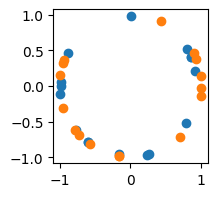

 56%|████████████████████████████████████████████▎                                  | 2805/5000 [01:56<01:41, 21.53it/s]

Epoch: 2801, Loss: 0.12011769413948059
Epoch: 2802, Loss: 0.1357877105474472
Epoch: 2803, Loss: 0.15003030002117157
Epoch: 2804, Loss: 0.11440955102443695
Epoch: 2805, Loss: 0.11209136247634888


 56%|████████████████████████████████████████████▍                                  | 2811/5000 [01:56<01:32, 23.79it/s]

Epoch: 2806, Loss: 0.11381858587265015
Epoch: 2807, Loss: 0.1320766657590866
Epoch: 2808, Loss: 0.12894153594970703
Epoch: 2809, Loss: 0.11384116858243942
Epoch: 2810, Loss: 0.11680664867162704
Epoch: 2811, Loss: 0.14595140516757965


 56%|████████████████████████████████████████████▌                                  | 2817/5000 [01:56<01:27, 24.93it/s]

Epoch: 2812, Loss: 0.1480322629213333
Epoch: 2813, Loss: 0.11482509225606918
Epoch: 2814, Loss: 0.12124046683311462
Epoch: 2815, Loss: 0.1222127377986908
Epoch: 2816, Loss: 0.12863752245903015
Epoch: 2817, Loss: 0.12992191314697266


 56%|████████████████████████████████████████████▌                                  | 2823/5000 [01:56<01:25, 25.60it/s]

Epoch: 2818, Loss: 0.11903078109025955
Epoch: 2819, Loss: 0.12211786955595016
Epoch: 2820, Loss: 0.12207480520009995
Epoch: 2821, Loss: 0.12438635528087616
Epoch: 2822, Loss: 0.12409880757331848
Epoch: 2823, Loss: 0.1943484991788864


 57%|████████████████████████████████████████████▋                                  | 2829/5000 [01:57<01:20, 26.99it/s]

Epoch: 2824, Loss: 0.10942241549491882
Epoch: 2825, Loss: 0.13496270775794983
Epoch: 2826, Loss: 0.11957816779613495
Epoch: 2827, Loss: 0.1132582277059555
Epoch: 2828, Loss: 0.1121678352355957
Epoch: 2829, Loss: 0.1287388652563095


 57%|████████████████████████████████████████████▊                                  | 2835/5000 [01:57<01:21, 26.49it/s]

Epoch: 2830, Loss: 0.15775051712989807
Epoch: 2831, Loss: 0.12934739887714386
Epoch: 2832, Loss: 0.13509629666805267
Epoch: 2833, Loss: 0.11104121804237366
Epoch: 2834, Loss: 0.113408662378788
Epoch: 2835, Loss: 0.12786200642585754


 57%|████████████████████████████████████████████▉                                  | 2841/5000 [01:57<01:20, 26.83it/s]

Epoch: 2836, Loss: 0.12032058835029602
Epoch: 2837, Loss: 0.10825181007385254
Epoch: 2838, Loss: 0.1137315109372139
Epoch: 2839, Loss: 0.10587748140096664
Epoch: 2840, Loss: 0.12409497052431107
Epoch: 2841, Loss: 0.11861637234687805


 57%|████████████████████████████████████████████▉                                  | 2847/5000 [01:57<01:32, 23.37it/s]

Epoch: 2842, Loss: 0.11693230271339417
Epoch: 2843, Loss: 0.11930221319198608
Epoch: 2844, Loss: 0.13271522521972656
Epoch: 2845, Loss: 0.14403396844863892
Epoch: 2846, Loss: 0.12222738564014435


 57%|█████████████████████████████████████████████                                  | 2850/5000 [01:57<01:48, 19.78it/s]

Epoch: 2847, Loss: 0.13423241674900055
Epoch: 2848, Loss: 0.11064457893371582
Epoch: 2849, Loss: 0.13432376086711884
Epoch: 2850, Loss: 0.12662455439567566


 57%|█████████████████████████████████████████████                                  | 2856/5000 [01:58<01:40, 21.31it/s]

Epoch: 2851, Loss: 0.1363571286201477
Epoch: 2852, Loss: 0.11760564148426056
Epoch: 2853, Loss: 0.1158154159784317
Epoch: 2854, Loss: 0.11312932521104813
Epoch: 2855, Loss: 0.11768520623445511
Epoch: 2856, Loss: 0.12110403180122375


 57%|█████████████████████████████████████████████▏                                 | 2862/5000 [01:58<01:30, 23.66it/s]

Epoch: 2857, Loss: 0.12197346985340118
Epoch: 2858, Loss: 0.11997056007385254
Epoch: 2859, Loss: 0.127738818526268
Epoch: 2860, Loss: 0.10835441201925278
Epoch: 2861, Loss: 0.11187134683132172
Epoch: 2862, Loss: 0.11873096227645874


 57%|█████████████████████████████████████████████▎                                 | 2869/5000 [01:58<01:19, 26.73it/s]

Epoch: 2863, Loss: 0.11037140339612961
Epoch: 2864, Loss: 0.13635893166065216
Epoch: 2865, Loss: 0.13000023365020752
Epoch: 2866, Loss: 0.13890114426612854
Epoch: 2867, Loss: 0.12615743279457092
Epoch: 2868, Loss: 0.12861225008964539


 57%|█████████████████████████████████████████████▍                                 | 2875/5000 [01:58<01:20, 26.55it/s]

Epoch: 2869, Loss: 0.12008422613143921
Epoch: 2870, Loss: 0.11507295072078705
Epoch: 2871, Loss: 0.11489669978618622
Epoch: 2872, Loss: 0.12689244747161865
Epoch: 2873, Loss: 0.10788707435131073
Epoch: 2874, Loss: 0.11207301914691925


 58%|█████████████████████████████████████████████▍                                 | 2878/5000 [01:59<01:23, 25.52it/s]

Epoch: 2875, Loss: 0.11516808718442917
Epoch: 2876, Loss: 0.1497519314289093
Epoch: 2877, Loss: 0.12274898588657379
Epoch: 2878, Loss: 0.13165652751922607
Epoch: 2879, Loss: 0.11437301337718964


 58%|█████████████████████████████████████████████▌                                 | 2884/5000 [01:59<01:23, 25.24it/s]

Epoch: 2880, Loss: 0.14606723189353943
Epoch: 2881, Loss: 0.1431187391281128
Epoch: 2882, Loss: 0.12988026440143585
Epoch: 2883, Loss: 0.15424111485481262
Epoch: 2884, Loss: 0.12948811054229736


 58%|█████████████████████████████████████████████▋                                 | 2890/5000 [01:59<01:29, 23.61it/s]

Epoch: 2885, Loss: 0.12240464985370636
Epoch: 2886, Loss: 0.13113480806350708
Epoch: 2887, Loss: 0.11791317164897919
Epoch: 2888, Loss: 0.12253101915121078
Epoch: 2889, Loss: 0.12289728224277496


 58%|█████████████████████████████████████████████▊                                 | 2896/5000 [01:59<01:20, 26.09it/s]

Epoch: 2890, Loss: 0.11556218564510345
Epoch: 2891, Loss: 0.11455611884593964
Epoch: 2892, Loss: 0.11832650005817413
Epoch: 2893, Loss: 0.15680746734142303
Epoch: 2894, Loss: 0.13826978206634521
Epoch: 2895, Loss: 0.12527720630168915


 58%|█████████████████████████████████████████████▊                                 | 2899/5000 [01:59<01:24, 24.80it/s]

Epoch: 2896, Loss: 0.1278233677148819
Epoch: 2897, Loss: 0.11328195035457611
Epoch: 2898, Loss: 0.13292145729064941
Epoch: 2899, Loss: 0.1201430931687355
Epoch: 2900, Loss: 0.1152011826634407


 58%|█████████████████████████████████████████████▉                                 | 2905/5000 [02:00<01:23, 24.97it/s]

Epoch: 2901, Loss: 0.11003360152244568
Epoch: 2902, Loss: 0.12045730650424957
Epoch: 2903, Loss: 0.12289322912693024
Epoch: 2904, Loss: 0.12564492225646973
Epoch: 2905, Loss: 0.11930237710475922
Epoch: 2906, Loss: 0.12833914160728455


 58%|█████████████████████████████████████████████▉                                 | 2911/5000 [02:00<01:21, 25.51it/s]

Epoch: 2907, Loss: 0.11829515546560287
Epoch: 2908, Loss: 0.12012723088264465
Epoch: 2909, Loss: 0.11452063173055649
Epoch: 2910, Loss: 0.11754998564720154
Epoch: 2911, Loss: 0.1369229555130005
Epoch: 2912, Loss: 0.1227380633354187


 58%|██████████████████████████████████████████████                                 | 2918/5000 [02:00<01:16, 27.17it/s]

Epoch: 2913, Loss: 0.13342513144016266
Epoch: 2914, Loss: 0.12589935958385468
Epoch: 2915, Loss: 0.11749323457479477
Epoch: 2916, Loss: 0.11481346189975739
Epoch: 2917, Loss: 0.12968645989894867
Epoch: 2918, Loss: 0.12127168476581573


 58%|██████████████████████████████████████████████▏                                | 2924/5000 [02:00<01:20, 25.91it/s]

Epoch: 2919, Loss: 0.11767715960741043
Epoch: 2920, Loss: 0.11830142140388489
Epoch: 2921, Loss: 0.12575887143611908
Epoch: 2922, Loss: 0.11858917772769928
Epoch: 2923, Loss: 0.1012454405426979


 59%|██████████████████████████████████████████████▏                                | 2927/5000 [02:01<01:22, 25.09it/s]

Epoch: 2924, Loss: 0.10628020018339157
Epoch: 2925, Loss: 0.13153506815433502
Epoch: 2926, Loss: 0.13209262490272522
Epoch: 2927, Loss: 0.11086592078208923
Epoch: 2928, Loss: 0.10355901718139648


 59%|██████████████████████████████████████████████▎                                | 2933/5000 [02:01<01:29, 23.04it/s]

Epoch: 2929, Loss: 0.11437787860631943
Epoch: 2930, Loss: 0.13389432430267334
Epoch: 2931, Loss: 0.1255464404821396
Epoch: 2932, Loss: 0.19280388951301575


 59%|██████████████████████████████████████████████▍                                | 2936/5000 [02:01<01:30, 22.71it/s]

Epoch: 2933, Loss: 0.12167321145534515
Epoch: 2934, Loss: 0.12855499982833862
Epoch: 2935, Loss: 0.11208701878786087
Epoch: 2936, Loss: 0.11818617582321167


 59%|██████████████████████████████████████████████▍                                | 2942/5000 [02:01<01:37, 21.12it/s]

Epoch: 2937, Loss: 0.11512653529644012
Epoch: 2938, Loss: 0.11890088766813278
Epoch: 2939, Loss: 0.11364199221134186
Epoch: 2940, Loss: 0.13860176503658295
Epoch: 2941, Loss: 0.1179809421300888


 59%|██████████████████████████████████████████████▌                                | 2945/5000 [02:01<01:41, 20.21it/s]

Epoch: 2942, Loss: 0.118683360517025
Epoch: 2943, Loss: 0.11740583181381226
Epoch: 2944, Loss: 0.1277187168598175
Epoch: 2945, Loss: 0.11745871603488922
Epoch: 2946, Loss: 0.10876592993736267


 59%|██████████████████████████████████████████████▋                                | 2951/5000 [02:02<01:31, 22.35it/s]

Epoch: 2947, Loss: 0.11986241489648819
Epoch: 2948, Loss: 0.16323432326316833
Epoch: 2949, Loss: 0.13412226736545563
Epoch: 2950, Loss: 0.11764764785766602
Epoch: 2951, Loss: 0.12605346739292145
Epoch: 2952, Loss: 0.11957591027021408


 59%|██████████████████████████████████████████████▋                                | 2957/5000 [02:02<01:25, 23.95it/s]

Epoch: 2953, Loss: 0.12310875952243805
Epoch: 2954, Loss: 0.12491846829652786
Epoch: 2955, Loss: 0.12681743502616882
Epoch: 2956, Loss: 0.12251037359237671
Epoch: 2957, Loss: 0.12151738256216049


 59%|██████████████████████████████████████████████▊                                | 2963/5000 [02:02<01:26, 23.65it/s]

Epoch: 2958, Loss: 0.12540630996227264
Epoch: 2959, Loss: 0.11061365902423859
Epoch: 2960, Loss: 0.13380898535251617
Epoch: 2961, Loss: 0.11147121340036392
Epoch: 2962, Loss: 0.1126910150051117
Epoch: 2963, Loss: 0.11514054238796234


 59%|██████████████████████████████████████████████▉                                | 2969/5000 [02:02<01:22, 24.63it/s]

Epoch: 2964, Loss: 0.12868094444274902
Epoch: 2965, Loss: 0.112002894282341
Epoch: 2966, Loss: 0.12854453921318054
Epoch: 2967, Loss: 0.11646215617656708
Epoch: 2968, Loss: 0.11411106586456299
Epoch: 2969, Loss: 0.12764233350753784


 60%|███████████████████████████████████████████████                                | 2975/5000 [02:03<01:22, 24.64it/s]

Epoch: 2970, Loss: 0.13800884783267975
Epoch: 2971, Loss: 0.11653368175029755
Epoch: 2972, Loss: 0.12420070171356201
Epoch: 2973, Loss: 0.11510857194662094
Epoch: 2974, Loss: 0.1160706952214241


 60%|███████████████████████████████████████████████                                | 2981/5000 [02:03<01:19, 25.37it/s]

Epoch: 2975, Loss: 0.12391205132007599
Epoch: 2976, Loss: 0.14621375501155853
Epoch: 2977, Loss: 0.11680155992507935
Epoch: 2978, Loss: 0.11395198106765747
Epoch: 2979, Loss: 0.11855252087116241
Epoch: 2980, Loss: 0.1130189448595047


 60%|███████████████████████████████████████████████▏                               | 2987/5000 [02:03<01:19, 25.33it/s]

Epoch: 2981, Loss: 0.11477683484554291
Epoch: 2982, Loss: 0.1165139228105545
Epoch: 2983, Loss: 0.1185397058725357
Epoch: 2984, Loss: 0.1326920986175537
Epoch: 2985, Loss: 0.11101772636175156
Epoch: 2986, Loss: 0.11769380420446396


 60%|███████████████████████████████████████████████▎                               | 2993/5000 [02:03<01:18, 25.63it/s]

Epoch: 2987, Loss: 0.12616904079914093
Epoch: 2988, Loss: 0.13715317845344543
Epoch: 2989, Loss: 0.10967236757278442
Epoch: 2990, Loss: 0.11564955115318298
Epoch: 2991, Loss: 0.11833294481039047
Epoch: 2992, Loss: 0.11245275288820267


 60%|███████████████████████████████████████████████▍                               | 2999/5000 [02:04<01:17, 25.75it/s]

Epoch: 2993, Loss: 0.10864334553480148
Epoch: 2994, Loss: 0.11990761011838913
Epoch: 2995, Loss: 0.11916293948888779
Epoch: 2996, Loss: 0.12875263392925262
Epoch: 2997, Loss: 0.11688601970672607
Epoch: 2998, Loss: 0.10180705785751343
Epoch: 2999, Loss: 0.12994542717933655
Epoch: 3000, Loss: 0.13093554973602295


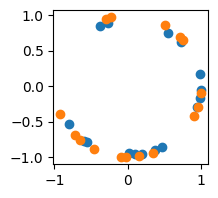

 60%|███████████████████████████████████████████████▍                               | 3002/5000 [02:04<01:30, 21.99it/s]

Epoch: 3001, Loss: 0.13327333331108093
Epoch: 3002, Loss: 0.13576097786426544


 60%|███████████████████████████████████████████████▍                               | 3005/5000 [02:04<01:26, 23.10it/s]

Epoch: 3003, Loss: 0.12235558778047562
Epoch: 3004, Loss: 0.10925287008285522
Epoch: 3005, Loss: 0.10555899143218994
Epoch: 3006, Loss: 0.11918523907661438


 60%|███████████████████████████████████████████████▌                               | 3008/5000 [02:04<01:22, 24.18it/s]

Epoch: 3007, Loss: 0.12313804030418396
Epoch: 3008, Loss: 0.11792407929897308


 60%|███████████████████████████████████████████████▌                               | 3011/5000 [02:04<01:20, 24.74it/s]

Epoch: 3009, Loss: 0.12066049128770828
Epoch: 3010, Loss: 0.130621999502182
Epoch: 3011, Loss: 0.13511265814304352


 60%|███████████████████████████████████████████████▌                               | 3014/5000 [02:04<01:26, 22.92it/s]

Epoch: 3012, Loss: 0.11555850505828857
Epoch: 3013, Loss: 0.1554160714149475


 60%|███████████████████████████████████████████████▋                               | 3017/5000 [02:04<01:28, 22.28it/s]

Epoch: 3014, Loss: 0.1386219710111618
Epoch: 3015, Loss: 0.14036943018436432
Epoch: 3016, Loss: 0.11316681653261185


 60%|███████████████████████████████████████████████▋                               | 3020/5000 [02:04<01:23, 23.80it/s]

Epoch: 3017, Loss: 0.11493614315986633
Epoch: 3018, Loss: 0.11052682995796204
Epoch: 3019, Loss: 0.12035997211933136


 60%|███████████████████████████████████████████████▊                               | 3023/5000 [02:05<01:20, 24.53it/s]

Epoch: 3020, Loss: 0.12452997267246246
Epoch: 3021, Loss: 0.12898214161396027
Epoch: 3022, Loss: 0.1232634037733078


 61%|███████████████████████████████████████████████▊                               | 3026/5000 [02:05<01:19, 24.71it/s]

Epoch: 3023, Loss: 0.11848073452711105
Epoch: 3024, Loss: 0.11550434678792953
Epoch: 3025, Loss: 0.13877104222774506
Epoch: 3026, Loss: 0.12372109293937683
Epoch: 3027, Loss: 0.1330963522195816


 61%|███████████████████████████████████████████████▊                               | 3029/5000 [02:05<01:26, 22.71it/s]

Epoch: 3028, Loss: 0.126870259642601
Epoch: 3029, Loss: 0.11205531656742096
Epoch: 3030, Loss: 0.12290830910205841


 61%|███████████████████████████████████████████████▉                               | 3032/5000 [02:05<01:24, 23.26it/s]

Epoch: 3031, Loss: 0.1313176155090332
Epoch: 3032, Loss: 0.13466666638851166
Epoch: 3033, Loss: 0.13940852880477905


 61%|███████████████████████████████████████████████▉                               | 3035/5000 [02:05<01:21, 24.24it/s]

Epoch: 3034, Loss: 0.13398735225200653
Epoch: 3035, Loss: 0.12828455865383148
Epoch: 3036, Loss: 0.12704093754291534


 61%|████████████████████████████████████████████████                               | 3038/5000 [02:05<01:20, 24.45it/s]

Epoch: 3037, Loss: 0.13754186034202576
Epoch: 3038, Loss: 0.11614631861448288
Epoch: 3039, Loss: 0.1184166967868805


 61%|████████████████████████████████████████████████                               | 3041/5000 [02:05<01:17, 25.13it/s]

Epoch: 3040, Loss: 0.12220994383096695
Epoch: 3041, Loss: 0.11890948563814163
Epoch: 3042, Loss: 0.11568969488143921


 61%|████████████████████████████████████████████████                               | 3044/5000 [02:05<01:19, 24.71it/s]

Epoch: 3043, Loss: 0.11406299471855164
Epoch: 3044, Loss: 0.13935157656669617
Epoch: 3045, Loss: 0.12201205641031265


 61%|████████████████████████████████████████████████▏                              | 3047/5000 [02:06<01:15, 25.79it/s]

Epoch: 3046, Loss: 0.12150625139474869
Epoch: 3047, Loss: 0.1188628077507019
Epoch: 3048, Loss: 0.12242968380451202


 61%|████████████████████████████████████████████████▏                              | 3050/5000 [02:06<01:19, 24.51it/s]

Epoch: 3049, Loss: 0.11205636709928513
Epoch: 3050, Loss: 0.15519002079963684


 61%|████████████████████████████████████████████████▏                              | 3053/5000 [02:06<01:21, 23.78it/s]

Epoch: 3051, Loss: 0.13612833619117737
Epoch: 3052, Loss: 0.10792412608861923
Epoch: 3053, Loss: 0.10005619376897812
Epoch: 3054, Loss: 0.11057211458683014


 61%|████████████████████████████████████████████████▎                              | 3056/5000 [02:06<01:30, 21.56it/s]

Epoch: 3055, Loss: 0.12888842821121216
Epoch: 3056, Loss: 0.11729764193296432
Epoch: 3057, Loss: 0.13392427563667297


 61%|████████████████████████████████████████████████▎                              | 3059/5000 [02:06<01:38, 19.79it/s]

Epoch: 3058, Loss: 0.12847298383712769


 61%|████████████████████████████████████████████████▍                              | 3062/5000 [02:06<01:37, 19.80it/s]

Epoch: 3059, Loss: 0.11457318067550659
Epoch: 3060, Loss: 0.13139377534389496
Epoch: 3061, Loss: 0.11827825009822845
Epoch: 3062, Loss: 0.11858657002449036


 61%|████████████████████████████████████████████████▍                              | 3065/5000 [02:07<01:50, 17.46it/s]

Epoch: 3063, Loss: 0.1293509304523468
Epoch: 3064, Loss: 0.12306846678256989
Epoch: 3065, Loss: 0.12288056313991547


 61%|████████████████████████████████████████████████▍                              | 3067/5000 [02:07<01:48, 17.84it/s]

Epoch: 3066, Loss: 0.12253770977258682


 61%|████████████████████████████████████████████████▌                              | 3070/5000 [02:07<01:41, 18.95it/s]

Epoch: 3067, Loss: 0.12050372362136841
Epoch: 3068, Loss: 0.11538244783878326
Epoch: 3069, Loss: 0.12203431874513626
Epoch: 3070, Loss: 0.15199097990989685
Epoch: 3071, Loss: 0.11315570771694183


 62%|████████████████████████████████████████████████▌                              | 3075/5000 [02:07<01:40, 19.13it/s]

Epoch: 3072, Loss: 0.11622864007949829
Epoch: 3073, Loss: 0.11997678875923157
Epoch: 3074, Loss: 0.1285395324230194
Epoch: 3075, Loss: 0.11238211393356323


 62%|████████████████████████████████████████████████▋                              | 3078/5000 [02:07<01:37, 19.67it/s]

Epoch: 3076, Loss: 0.11392244696617126
Epoch: 3077, Loss: 0.12236227840185165
Epoch: 3078, Loss: 0.11924637854099274
Epoch: 3079, Loss: 0.12163586914539337


 62%|████████████████████████████████████████████████▋                              | 3081/5000 [02:07<01:35, 20.18it/s]

Epoch: 3080, Loss: 0.11740192770957947


 62%|████████████████████████████████████████████████▋                              | 3084/5000 [02:07<01:31, 20.89it/s]

Epoch: 3081, Loss: 0.1358516365289688
Epoch: 3082, Loss: 0.13729438185691833
Epoch: 3083, Loss: 0.1215374544262886
Epoch: 3084, Loss: 0.11267836391925812
Epoch: 3085, Loss: 0.12527236342430115


 62%|████████████████████████████████████████████████▊                              | 3090/5000 [02:08<01:24, 22.69it/s]

Epoch: 3086, Loss: 0.15470311045646667
Epoch: 3087, Loss: 0.12141244113445282
Epoch: 3088, Loss: 0.12011106312274933
Epoch: 3089, Loss: 0.12021469324827194
Epoch: 3090, Loss: 0.12064354866743088
Epoch: 3091, Loss: 0.11380897462368011


 62%|████████████████████████████████████████████████▉                              | 3096/5000 [02:08<01:16, 24.73it/s]

Epoch: 3092, Loss: 0.10928116738796234
Epoch: 3093, Loss: 0.11603424698114395
Epoch: 3094, Loss: 0.10986530035734177
Epoch: 3095, Loss: 0.12739063799381256
Epoch: 3096, Loss: 0.11547431349754333
Epoch: 3097, Loss: 0.13731692731380463


 62%|█████████████████████████████████████████████████                              | 3102/5000 [02:08<01:13, 25.80it/s]

Epoch: 3098, Loss: 0.14656643569469452
Epoch: 3099, Loss: 0.12413035333156586
Epoch: 3100, Loss: 0.10891623049974442
Epoch: 3101, Loss: 0.1361604928970337
Epoch: 3102, Loss: 0.11730534583330154


 62%|█████████████████████████████████████████████████                              | 3105/5000 [02:08<01:31, 20.82it/s]

Epoch: 3103, Loss: 0.11894413828849792
Epoch: 3104, Loss: 0.11579717695713043
Epoch: 3105, Loss: 0.12113142013549805


 62%|█████████████████████████████████████████████████                              | 3108/5000 [02:09<02:41, 11.69it/s]

Epoch: 3106, Loss: 0.12632660567760468
Epoch: 3107, Loss: 0.1296929568052292


 62%|█████████████████████████████████████████████████▏                             | 3110/5000 [02:09<02:40, 11.75it/s]

Epoch: 3108, Loss: 0.13225190341472626
Epoch: 3109, Loss: 0.12909720838069916
Epoch: 3110, Loss: 0.13251423835754395


 62%|█████████████████████████████████████████████████▏                             | 3114/5000 [02:09<02:39, 11.84it/s]

Epoch: 3111, Loss: 0.11066096276044846
Epoch: 3112, Loss: 0.13450583815574646
Epoch: 3113, Loss: 0.11391152441501617


 62%|█████████████████████████████████████████████████▎                             | 3118/5000 [02:10<02:19, 13.47it/s]

Epoch: 3114, Loss: 0.12149239331483841
Epoch: 3115, Loss: 0.12440500408411026
Epoch: 3116, Loss: 0.1270463764667511
Epoch: 3117, Loss: 0.12035451829433441


 62%|█████████████████████████████████████████████████▎                             | 3120/5000 [02:10<02:14, 13.98it/s]

Epoch: 3118, Loss: 0.12971465289592743
Epoch: 3119, Loss: 0.11889322102069855
Epoch: 3120, Loss: 0.11970002204179764


 62%|█████████████████████████████████████████████████▎                             | 3124/5000 [02:10<02:38, 11.85it/s]

Epoch: 3121, Loss: 0.11484475433826447
Epoch: 3122, Loss: 0.11893083900213242
Epoch: 3123, Loss: 0.11697749048471451


 63%|█████████████████████████████████████████████████▍                             | 3126/5000 [02:10<02:45, 11.36it/s]

Epoch: 3124, Loss: 0.1263159066438675
Epoch: 3125, Loss: 0.12041101604700089
Epoch: 3126, Loss: 0.11992214620113373


 63%|█████████████████████████████████████████████████▍                             | 3130/5000 [02:11<02:23, 13.00it/s]

Epoch: 3127, Loss: 0.12854883074760437
Epoch: 3128, Loss: 0.13483162224292755
Epoch: 3129, Loss: 0.1208016574382782
Epoch: 3130, Loss: 0.13252142071723938


 63%|█████████████████████████████████████████████████▌                             | 3134/5000 [02:11<02:12, 14.13it/s]

Epoch: 3131, Loss: 0.11242636293172836
Epoch: 3132, Loss: 0.15024662017822266
Epoch: 3133, Loss: 0.12193164229393005


 63%|█████████████████████████████████████████████████▌                             | 3136/5000 [02:11<02:11, 14.15it/s]

Epoch: 3134, Loss: 0.1337505429983139
Epoch: 3135, Loss: 0.11997999250888824
Epoch: 3136, Loss: 0.1235208734869957


 63%|█████████████████████████████████████████████████▌                             | 3140/5000 [02:11<02:07, 14.64it/s]

Epoch: 3137, Loss: 0.11339122802019119
Epoch: 3138, Loss: 0.11548842489719391
Epoch: 3139, Loss: 0.11408863216638565
Epoch: 3140, Loss: 0.11173838376998901


 63%|█████████████████████████████████████████████████▋                             | 3145/5000 [02:12<01:51, 16.68it/s]

Epoch: 3141, Loss: 0.10901308804750443
Epoch: 3142, Loss: 0.12561742961406708
Epoch: 3143, Loss: 0.13017691671848297
Epoch: 3144, Loss: 0.1102510541677475
Epoch: 3145, Loss: 0.12438995391130447


 63%|█████████████████████████████████████████████████▊                             | 3149/5000 [02:12<01:51, 16.63it/s]

Epoch: 3146, Loss: 0.13782653212547302
Epoch: 3147, Loss: 0.12089554965496063
Epoch: 3148, Loss: 0.13161104917526245
Epoch: 3149, Loss: 0.10651061683893204


 63%|█████████████████████████████████████████████████▊                             | 3154/5000 [02:12<01:39, 18.64it/s]

Epoch: 3150, Loss: 0.1259017288684845
Epoch: 3151, Loss: 0.11633790284395218
Epoch: 3152, Loss: 0.12592928111553192
Epoch: 3153, Loss: 0.12494350969791412


 63%|█████████████████████████████████████████████████▊                             | 3156/5000 [02:12<01:53, 16.29it/s]

Epoch: 3154, Loss: 0.11400610953569412
Epoch: 3155, Loss: 0.11291838437318802
Epoch: 3156, Loss: 0.11402051895856857
Epoch: 3157, Loss: 0.11742788553237915


 63%|█████████████████████████████████████████████████▉                             | 3161/5000 [02:12<01:45, 17.47it/s]

Epoch: 3158, Loss: 0.12239719927310944
Epoch: 3159, Loss: 0.12451332062482834
Epoch: 3160, Loss: 0.11328098922967911
Epoch: 3161, Loss: 0.11607855558395386


 63%|██████████████████████████████████████████████████                             | 3166/5000 [02:13<01:34, 19.39it/s]

Epoch: 3162, Loss: 0.12793700397014618
Epoch: 3163, Loss: 0.14967066049575806
Epoch: 3164, Loss: 0.14610035717487335
Epoch: 3165, Loss: 0.12120528519153595
Epoch: 3166, Loss: 0.11253101378679276


 63%|██████████████████████████████████████████████████                             | 3172/5000 [02:13<01:25, 21.36it/s]

Epoch: 3167, Loss: 0.12350515276193619
Epoch: 3168, Loss: 0.13216739892959595
Epoch: 3169, Loss: 0.1361624300479889
Epoch: 3170, Loss: 0.13231779634952545
Epoch: 3171, Loss: 0.12976166605949402


 64%|██████████████████████████████████████████████████▏                            | 3175/5000 [02:13<01:25, 21.26it/s]

Epoch: 3172, Loss: 0.14387904107570648
Epoch: 3173, Loss: 0.13202917575836182
Epoch: 3174, Loss: 0.12350685894489288
Epoch: 3175, Loss: 0.14204363524913788
Epoch: 3176, Loss: 0.11014529317617416


 64%|██████████████████████████████████████████████████▎                            | 3181/5000 [02:13<01:25, 21.32it/s]

Epoch: 3177, Loss: 0.1513785421848297
Epoch: 3178, Loss: 0.1191091537475586
Epoch: 3179, Loss: 0.11467151343822479
Epoch: 3180, Loss: 0.11201778799295425
Epoch: 3181, Loss: 0.11671911180019379


 64%|██████████████████████████████████████████████████▎                            | 3187/5000 [02:14<01:21, 22.29it/s]

Epoch: 3182, Loss: 0.1273026019334793
Epoch: 3183, Loss: 0.12460872530937195
Epoch: 3184, Loss: 0.12167507410049438
Epoch: 3185, Loss: 0.12168306112289429
Epoch: 3186, Loss: 0.1322993040084839


 64%|██████████████████████████████████████████████████▍                            | 3190/5000 [02:14<01:22, 21.82it/s]

Epoch: 3187, Loss: 0.1306147575378418
Epoch: 3188, Loss: 0.12062688916921616
Epoch: 3189, Loss: 0.11278671026229858
Epoch: 3190, Loss: 0.11096833646297455
Epoch: 3191, Loss: 0.10743854939937592


 64%|██████████████████████████████████████████████████▍                            | 3196/5000 [02:14<01:22, 21.87it/s]

Epoch: 3192, Loss: 0.13797293603420258
Epoch: 3193, Loss: 0.12055720388889313
Epoch: 3194, Loss: 0.1562582105398178
Epoch: 3195, Loss: 0.12659788131713867
Epoch: 3196, Loss: 0.11530925333499908


 64%|██████████████████████████████████████████████████▌                            | 3199/5000 [02:14<01:22, 21.95it/s]

Epoch: 3197, Loss: 0.12195225805044174
Epoch: 3198, Loss: 0.12622500956058502
Epoch: 3199, Loss: 0.12429572641849518
Epoch: 3200, Loss: 0.12738539278507233


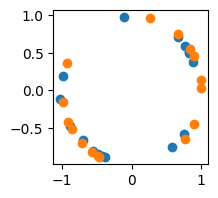

 64%|██████████████████████████████████████████████████▋                            | 3205/5000 [02:15<01:25, 20.91it/s]

Epoch: 3201, Loss: 0.10824764519929886
Epoch: 3202, Loss: 0.13586290180683136
Epoch: 3203, Loss: 0.1212376207113266
Epoch: 3204, Loss: 0.12487222254276276
Epoch: 3205, Loss: 0.12741981446743011
Epoch: 3206, Loss: 0.10861093550920486


 64%|██████████████████████████████████████████████████▋                            | 3211/5000 [02:15<01:17, 23.05it/s]

Epoch: 3207, Loss: 0.11216054111719131
Epoch: 3208, Loss: 0.11132139712572098
Epoch: 3209, Loss: 0.12397655844688416
Epoch: 3210, Loss: 0.1068490669131279
Epoch: 3211, Loss: 0.1257736086845398
Epoch: 3212, Loss: 0.12501896917819977


 64%|██████████████████████████████████████████████████▊                            | 3217/5000 [02:15<01:17, 23.15it/s]

Epoch: 3213, Loss: 0.12154249101877213
Epoch: 3214, Loss: 0.13743092119693756
Epoch: 3215, Loss: 0.1345333456993103
Epoch: 3216, Loss: 0.1267610788345337
Epoch: 3217, Loss: 0.11456234753131866
Epoch: 3218, Loss: 0.12592239677906036


 64%|██████████████████████████████████████████████████▉                            | 3223/5000 [02:15<01:13, 24.20it/s]

Epoch: 3219, Loss: 0.11312661319971085
Epoch: 3220, Loss: 0.1085595116019249
Epoch: 3221, Loss: 0.12148788571357727
Epoch: 3222, Loss: 0.13418793678283691
Epoch: 3223, Loss: 0.11262830346822739
Epoch: 3224, Loss: 0.12394322454929352


 65%|███████████████████████████████████████████████████                            | 3229/5000 [02:16<01:11, 24.76it/s]

Epoch: 3225, Loss: 0.11345602571964264
Epoch: 3226, Loss: 0.12104322761297226
Epoch: 3227, Loss: 0.11857141554355621
Epoch: 3228, Loss: 0.12708275020122528
Epoch: 3229, Loss: 0.11713328212499619
Epoch: 3230, Loss: 0.15877297520637512


 65%|███████████████████████████████████████████████████                            | 3235/5000 [02:16<01:09, 25.50it/s]

Epoch: 3231, Loss: 0.12957724928855896
Epoch: 3232, Loss: 0.12035878002643585
Epoch: 3233, Loss: 0.14158952236175537
Epoch: 3234, Loss: 0.12328857183456421
Epoch: 3235, Loss: 0.13168630003929138
Epoch: 3236, Loss: 0.1178109422326088


 65%|███████████████████████████████████████████████████▏                           | 3241/5000 [02:16<01:08, 25.63it/s]

Epoch: 3237, Loss: 0.12665998935699463
Epoch: 3238, Loss: 0.10745460540056229
Epoch: 3239, Loss: 0.1454157531261444
Epoch: 3240, Loss: 0.12206434458494186
Epoch: 3241, Loss: 0.11660318076610565


 65%|███████████████████████████████████████████████████▎                           | 3247/5000 [02:16<01:08, 25.67it/s]

Epoch: 3242, Loss: 0.1106778085231781
Epoch: 3243, Loss: 0.13231593370437622
Epoch: 3244, Loss: 0.11805970966815948
Epoch: 3245, Loss: 0.14598771929740906
Epoch: 3246, Loss: 0.1149897649884224
Epoch: 3247, Loss: 0.11751610040664673


 65%|███████████████████████████████████████████████████▍                           | 3253/5000 [02:16<01:08, 25.69it/s]

Epoch: 3248, Loss: 0.11713650077581406
Epoch: 3249, Loss: 0.11244016885757446
Epoch: 3250, Loss: 0.13591021299362183
Epoch: 3251, Loss: 0.12433456629514694
Epoch: 3252, Loss: 0.10570686310529709
Epoch: 3253, Loss: 0.12079498171806335


 65%|███████████████████████████████████████████████████▍                           | 3259/5000 [02:17<01:07, 25.86it/s]

Epoch: 3254, Loss: 0.11579762399196625
Epoch: 3255, Loss: 0.11201009154319763
Epoch: 3256, Loss: 0.11190607398748398
Epoch: 3257, Loss: 0.12713263928890228
Epoch: 3258, Loss: 0.13640537858009338
Epoch: 3259, Loss: 0.11741691827774048


 65%|███████████████████████████████████████████████████▌                           | 3265/5000 [02:17<01:12, 23.86it/s]

Epoch: 3260, Loss: 0.126351460814476
Epoch: 3261, Loss: 0.1135922521352768
Epoch: 3262, Loss: 0.11064289510250092
Epoch: 3263, Loss: 0.12655121088027954
Epoch: 3264, Loss: 0.10925363749265671


 65%|███████████████████████████████████████████████████▋                           | 3268/5000 [02:17<01:15, 23.00it/s]

Epoch: 3265, Loss: 0.10679450631141663
Epoch: 3266, Loss: 0.11701029539108276
Epoch: 3267, Loss: 0.12964145839214325
Epoch: 3268, Loss: 0.11896717548370361
Epoch: 3269, Loss: 0.11363301426172256


 65%|███████████████████████████████████████████████████▋                           | 3274/5000 [02:17<01:13, 23.58it/s]

Epoch: 3270, Loss: 0.11001965403556824
Epoch: 3271, Loss: 0.13442791998386383
Epoch: 3272, Loss: 0.11999945342540741
Epoch: 3273, Loss: 0.12299268692731857
Epoch: 3274, Loss: 0.12412896007299423


 66%|███████████████████████████████████████████████████▊                           | 3280/5000 [02:18<01:09, 24.68it/s]

Epoch: 3275, Loss: 0.1078365370631218
Epoch: 3276, Loss: 0.11709393560886383
Epoch: 3277, Loss: 0.13589870929718018
Epoch: 3278, Loss: 0.12816958129405975
Epoch: 3279, Loss: 0.12466071546077728
Epoch: 3280, Loss: 0.1265423744916916


 66%|███████████████████████████████████████████████████▉                           | 3286/5000 [02:18<01:08, 25.06it/s]

Epoch: 3281, Loss: 0.12279292196035385
Epoch: 3282, Loss: 0.1301274299621582
Epoch: 3283, Loss: 0.12386494874954224
Epoch: 3284, Loss: 0.12104056775569916
Epoch: 3285, Loss: 0.11869882047176361
Epoch: 3286, Loss: 0.13382790982723236


 66%|████████████████████████████████████████████████████                           | 3292/5000 [02:18<01:10, 24.39it/s]

Epoch: 3287, Loss: 0.11560799926519394
Epoch: 3288, Loss: 0.11379576474428177
Epoch: 3289, Loss: 0.11964847147464752
Epoch: 3290, Loss: 0.1162167638540268
Epoch: 3291, Loss: 0.17332574725151062


 66%|████████████████████████████████████████████████████                           | 3295/5000 [02:18<01:09, 24.62it/s]

Epoch: 3292, Loss: 0.1255425363779068
Epoch: 3293, Loss: 0.11413383483886719
Epoch: 3294, Loss: 0.11121920496225357
Epoch: 3295, Loss: 0.11874758452177048
Epoch: 3296, Loss: 0.11324162036180496


 66%|████████████████████████████████████████████████████▏                          | 3301/5000 [02:18<01:16, 22.25it/s]

Epoch: 3297, Loss: 0.13749627768993378
Epoch: 3298, Loss: 0.12534965574741364
Epoch: 3299, Loss: 0.11053695529699326
Epoch: 3300, Loss: 0.13439303636550903
Epoch: 3301, Loss: 0.11500497907400131


 66%|████████████████████████████████████████████████████▎                          | 3307/5000 [02:19<01:13, 23.02it/s]

Epoch: 3302, Loss: 0.11669648438692093
Epoch: 3303, Loss: 0.12014110386371613
Epoch: 3304, Loss: 0.13015098869800568
Epoch: 3305, Loss: 0.1515672206878662
Epoch: 3306, Loss: 0.12500788271427155


 66%|████████████████████████████████████████████████████▎                          | 3310/5000 [02:19<01:14, 22.66it/s]

Epoch: 3307, Loss: 0.12400636076927185
Epoch: 3308, Loss: 0.12290649861097336
Epoch: 3309, Loss: 0.1343773454427719
Epoch: 3310, Loss: 0.13090600073337555
Epoch: 3311, Loss: 0.11789698153734207


 66%|████████████████████████████████████████████████████▍                          | 3316/5000 [02:19<01:12, 23.36it/s]

Epoch: 3312, Loss: 0.11202801764011383
Epoch: 3313, Loss: 0.11705170571804047
Epoch: 3314, Loss: 0.11477913707494736
Epoch: 3315, Loss: 0.14151503145694733
Epoch: 3316, Loss: 0.13218173384666443


 66%|████████████████████████████████████████████████████▍                          | 3322/5000 [02:19<01:16, 21.97it/s]

Epoch: 3317, Loss: 0.1351793110370636
Epoch: 3318, Loss: 0.11534681916236877
Epoch: 3319, Loss: 0.11226899921894073
Epoch: 3320, Loss: 0.1292128562927246
Epoch: 3321, Loss: 0.1264544576406479


 66%|████████████████████████████████████████████████████▌                          | 3325/5000 [02:20<01:14, 22.41it/s]

Epoch: 3322, Loss: 0.10355345904827118
Epoch: 3323, Loss: 0.12125051021575928
Epoch: 3324, Loss: 0.11208829283714294
Epoch: 3325, Loss: 0.1180814653635025
Epoch: 3326, Loss: 0.12927384674549103


 67%|████████████████████████████████████████████████████▋                          | 3331/5000 [02:20<01:13, 22.76it/s]

Epoch: 3327, Loss: 0.12332168221473694
Epoch: 3328, Loss: 0.10920196771621704
Epoch: 3329, Loss: 0.11687108874320984
Epoch: 3330, Loss: 0.12014183402061462
Epoch: 3331, Loss: 0.14126983284950256


 67%|████████████████████████████████████████████████████▋                          | 3337/5000 [02:20<01:11, 23.10it/s]

Epoch: 3332, Loss: 0.12666037678718567
Epoch: 3333, Loss: 0.13918724656105042
Epoch: 3334, Loss: 0.12989521026611328
Epoch: 3335, Loss: 0.14151334762573242
Epoch: 3336, Loss: 0.1157538890838623


 67%|████████████████████████████████████████████████████▊                          | 3343/5000 [02:20<01:07, 24.48it/s]

Epoch: 3337, Loss: 0.1175382062792778
Epoch: 3338, Loss: 0.11863569170236588
Epoch: 3339, Loss: 0.11366581171751022
Epoch: 3340, Loss: 0.12689632177352905
Epoch: 3341, Loss: 0.11196774244308472
Epoch: 3342, Loss: 0.12369631975889206


 67%|████████████████████████████████████████████████████▊                          | 3346/5000 [02:20<01:07, 24.32it/s]

Epoch: 3343, Loss: 0.12674948573112488
Epoch: 3344, Loss: 0.11398095637559891
Epoch: 3345, Loss: 0.11781622469425201
Epoch: 3346, Loss: 0.11942808330059052
Epoch: 3347, Loss: 0.11554181575775146


 67%|████████████████████████████████████████████████████▉                          | 3352/5000 [02:21<01:07, 24.53it/s]

Epoch: 3348, Loss: 0.11373290419578552
Epoch: 3349, Loss: 0.11717952787876129
Epoch: 3350, Loss: 0.11837443709373474
Epoch: 3351, Loss: 0.14146585762500763
Epoch: 3352, Loss: 0.11601918935775757
Epoch: 3353, Loss: 0.11002200096845627


 67%|█████████████████████████████████████████████████████                          | 3358/5000 [02:21<01:03, 25.77it/s]

Epoch: 3354, Loss: 0.11533927172422409
Epoch: 3355, Loss: 0.13412052392959595
Epoch: 3356, Loss: 0.12583160400390625
Epoch: 3357, Loss: 0.12372241914272308
Epoch: 3358, Loss: 0.13012979924678802
Epoch: 3359, Loss: 0.13456159830093384


 67%|█████████████████████████████████████████████████████                          | 3361/5000 [02:21<01:02, 26.15it/s]

Epoch: 3360, Loss: 0.14110848307609558
Epoch: 3361, Loss: 0.12581199407577515
Epoch: 3362, Loss: 0.11707672476768494


 67%|█████████████████████████████████████████████████████▏                         | 3367/5000 [02:21<01:19, 20.63it/s]

Epoch: 3363, Loss: 0.12275344133377075
Epoch: 3364, Loss: 0.11465777456760406
Epoch: 3365, Loss: 0.11016739904880524
Epoch: 3366, Loss: 0.11272497475147247
Epoch: 3367, Loss: 0.13197584450244904
Epoch: 3368, Loss: 0.13320541381835938


 67%|█████████████████████████████████████████████████████▎                         | 3373/5000 [02:22<01:10, 23.21it/s]

Epoch: 3369, Loss: 0.12046299129724503
Epoch: 3370, Loss: 0.11587807536125183
Epoch: 3371, Loss: 0.11499211192131042
Epoch: 3372, Loss: 0.11503136157989502
Epoch: 3373, Loss: 0.11880256980657578
Epoch: 3374, Loss: 0.1196175068616867


 68%|█████████████████████████████████████████████████████▍                         | 3379/5000 [02:22<01:03, 25.33it/s]

Epoch: 3375, Loss: 0.13452975451946259
Epoch: 3376, Loss: 0.1330832839012146
Epoch: 3377, Loss: 0.11154720932245255
Epoch: 3378, Loss: 0.12081865966320038
Epoch: 3379, Loss: 0.11155793070793152
Epoch: 3380, Loss: 0.11361349374055862


 68%|█████████████████████████████████████████████████████▍                         | 3385/5000 [02:22<01:03, 25.32it/s]

Epoch: 3381, Loss: 0.12070085108280182
Epoch: 3382, Loss: 0.11697161197662354
Epoch: 3383, Loss: 0.11817152053117752
Epoch: 3384, Loss: 0.1251782476902008
Epoch: 3385, Loss: 0.13807600736618042
Epoch: 3386, Loss: 0.12883055210113525


 68%|█████████████████████████████████████████████████████▌                         | 3391/5000 [02:22<01:02, 25.75it/s]

Epoch: 3387, Loss: 0.1118844598531723
Epoch: 3388, Loss: 0.13238151371479034
Epoch: 3389, Loss: 0.1252608597278595
Epoch: 3390, Loss: 0.10951262712478638
Epoch: 3391, Loss: 0.1100197434425354


 68%|█████████████████████████████████████████████████████▋                         | 3397/5000 [02:22<01:05, 24.45it/s]

Epoch: 3392, Loss: 0.13448040187358856
Epoch: 3393, Loss: 0.12716573476791382
Epoch: 3394, Loss: 0.11420837789773941
Epoch: 3395, Loss: 0.12513312697410583
Epoch: 3396, Loss: 0.12021131813526154


 68%|█████████████████████████████████████████████████████▋                         | 3400/5000 [02:23<01:05, 24.53it/s]

Epoch: 3397, Loss: 0.13453489542007446
Epoch: 3398, Loss: 0.1141703799366951
Epoch: 3399, Loss: 0.12080525606870651
Epoch: 3400, Loss: 0.12282533198595047


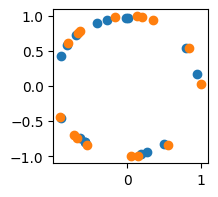

 68%|█████████████████████████████████████████████████████▊                         | 3406/5000 [02:23<01:13, 21.71it/s]

Epoch: 3401, Loss: 0.11802250146865845
Epoch: 3402, Loss: 0.1149962842464447
Epoch: 3403, Loss: 0.12952272593975067
Epoch: 3404, Loss: 0.11941517144441605
Epoch: 3405, Loss: 0.1309618353843689


 68%|█████████████████████████████████████████████████████▉                         | 3412/5000 [02:23<01:06, 23.87it/s]

Epoch: 3406, Loss: 0.13134907186031342
Epoch: 3407, Loss: 0.1144547238945961
Epoch: 3408, Loss: 0.1118459552526474
Epoch: 3409, Loss: 0.11738656461238861
Epoch: 3410, Loss: 0.12811510264873505
Epoch: 3411, Loss: 0.11939910799264908


 68%|█████████████████████████████████████████████████████▉                         | 3415/5000 [02:23<01:04, 24.55it/s]

Epoch: 3412, Loss: 0.12898464500904083
Epoch: 3413, Loss: 0.11737772077322006
Epoch: 3414, Loss: 0.12660589814186096
Epoch: 3415, Loss: 0.12300066649913788
Epoch: 3416, Loss: 0.11503887921571732


 68%|██████████████████████████████████████████████████████                         | 3421/5000 [02:24<01:04, 24.35it/s]

Epoch: 3417, Loss: 0.12745004892349243
Epoch: 3418, Loss: 0.12106505036354065
Epoch: 3419, Loss: 0.15184947848320007
Epoch: 3420, Loss: 0.12891054153442383
Epoch: 3421, Loss: 0.11509478092193604
Epoch: 3422, Loss: 0.11023497581481934


 69%|██████████████████████████████████████████████████████▏                        | 3427/5000 [02:24<01:01, 25.56it/s]

Epoch: 3423, Loss: 0.12698757648468018
Epoch: 3424, Loss: 0.12475447356700897
Epoch: 3425, Loss: 0.1310727447271347
Epoch: 3426, Loss: 0.11648336797952652
Epoch: 3427, Loss: 0.13568489253520966
Epoch: 3428, Loss: 0.12826812267303467


 69%|██████████████████████████████████████████████████████▏                        | 3433/5000 [02:24<01:00, 25.96it/s]

Epoch: 3429, Loss: 0.1217866837978363
Epoch: 3430, Loss: 0.11035724729299545
Epoch: 3431, Loss: 0.13432617485523224
Epoch: 3432, Loss: 0.1152188628911972
Epoch: 3433, Loss: 0.1284686177968979
Epoch: 3434, Loss: 0.1249614804983139


 69%|██████████████████████████████████████████████████████▎                        | 3439/5000 [02:24<00:59, 26.18it/s]

Epoch: 3435, Loss: 0.13992352783679962
Epoch: 3436, Loss: 0.14125192165374756
Epoch: 3437, Loss: 0.11393055319786072
Epoch: 3438, Loss: 0.11916960030794144
Epoch: 3439, Loss: 0.12185448408126831
Epoch: 3440, Loss: 0.11095937341451645


 69%|██████████████████████████████████████████████████████▍                        | 3445/5000 [02:24<00:59, 26.07it/s]

Epoch: 3441, Loss: 0.11062349379062653
Epoch: 3442, Loss: 0.13337460160255432
Epoch: 3443, Loss: 0.15167059004306793
Epoch: 3444, Loss: 0.11008797585964203
Epoch: 3445, Loss: 0.1632709503173828
Epoch: 3446, Loss: 0.13365551829338074


 69%|██████████████████████████████████████████████████████▌                        | 3451/5000 [02:25<00:59, 25.90it/s]

Epoch: 3447, Loss: 0.12027767300605774
Epoch: 3448, Loss: 0.11940725147724152
Epoch: 3449, Loss: 0.12601317465305328
Epoch: 3450, Loss: 0.11054198443889618
Epoch: 3451, Loss: 0.113526850938797
Epoch: 3452, Loss: 0.12395136803388596


 69%|██████████████████████████████████████████████████████▌                        | 3457/5000 [02:25<01:01, 25.25it/s]

Epoch: 3453, Loss: 0.12362858653068542
Epoch: 3454, Loss: 0.13405492901802063
Epoch: 3455, Loss: 0.12212438136339188
Epoch: 3456, Loss: 0.12224990129470825
Epoch: 3457, Loss: 0.13421179354190826


 69%|██████████████████████████████████████████████████████▋                        | 3463/5000 [02:25<01:00, 25.26it/s]

Epoch: 3458, Loss: 0.12733645737171173
Epoch: 3459, Loss: 0.10984284430742264
Epoch: 3460, Loss: 0.11556340008974075
Epoch: 3461, Loss: 0.11726885288953781
Epoch: 3462, Loss: 0.11511429399251938
Epoch: 3463, Loss: 0.1315390169620514


 69%|██████████████████████████████████████████████████████▊                        | 3469/5000 [02:25<00:59, 25.54it/s]

Epoch: 3464, Loss: 0.122182697057724
Epoch: 3465, Loss: 0.11130508035421371
Epoch: 3466, Loss: 0.12550221383571625
Epoch: 3467, Loss: 0.11874693632125854
Epoch: 3468, Loss: 0.1159345880150795
Epoch: 3469, Loss: 0.12084148824214935


 70%|██████████████████████████████████████████████████████▉                        | 3475/5000 [02:26<01:02, 24.38it/s]

Epoch: 3470, Loss: 0.12618765234947205
Epoch: 3471, Loss: 0.12761639058589935
Epoch: 3472, Loss: 0.12145484238862991
Epoch: 3473, Loss: 0.12091246992349625
Epoch: 3474, Loss: 0.12085133790969849


 70%|██████████████████████████████████████████████████████▉                        | 3481/5000 [02:26<01:00, 25.10it/s]

Epoch: 3475, Loss: 0.1128881424665451
Epoch: 3476, Loss: 0.11797405779361725
Epoch: 3477, Loss: 0.12582774460315704
Epoch: 3478, Loss: 0.11955734342336655
Epoch: 3479, Loss: 0.18543191254138947
Epoch: 3480, Loss: 0.12142759561538696


 70%|███████████████████████████████████████████████████████                        | 3487/5000 [02:26<00:58, 26.00it/s]

Epoch: 3481, Loss: 0.12564338743686676
Epoch: 3482, Loss: 0.12091502547264099
Epoch: 3483, Loss: 0.11369217932224274
Epoch: 3484, Loss: 0.13723379373550415
Epoch: 3485, Loss: 0.11700406670570374
Epoch: 3486, Loss: 0.1270410418510437


 70%|███████████████████████████████████████████████████████▏                       | 3493/5000 [02:26<00:56, 26.56it/s]

Epoch: 3487, Loss: 0.13342618942260742
Epoch: 3488, Loss: 0.1270274817943573
Epoch: 3489, Loss: 0.12157362699508667
Epoch: 3490, Loss: 0.1293206810951233
Epoch: 3491, Loss: 0.12518039345741272
Epoch: 3492, Loss: 0.11529180407524109


 70%|███████████████████████████████████████████████████████▎                       | 3499/5000 [02:27<00:56, 26.58it/s]

Epoch: 3493, Loss: 0.10647992789745331
Epoch: 3494, Loss: 0.13308829069137573
Epoch: 3495, Loss: 0.1325840950012207
Epoch: 3496, Loss: 0.12144821882247925
Epoch: 3497, Loss: 0.11738236993551254
Epoch: 3498, Loss: 0.1655815690755844


 70%|███████████████████████████████████████████████████████▍                       | 3505/5000 [02:27<00:57, 26.16it/s]

Epoch: 3499, Loss: 0.1114971712231636
Epoch: 3500, Loss: 0.12287228554487228
Epoch: 3501, Loss: 0.10948598384857178
Epoch: 3502, Loss: 0.13071811199188232
Epoch: 3503, Loss: 0.16231828927993774
Epoch: 3504, Loss: 0.1331266462802887


 70%|███████████████████████████████████████████████████████▍                       | 3508/5000 [02:27<00:59, 24.90it/s]

Epoch: 3505, Loss: 0.12137288600206375
Epoch: 3506, Loss: 0.12465392053127289
Epoch: 3507, Loss: 0.11091002076864243
Epoch: 3508, Loss: 0.10900457948446274
Epoch: 3509, Loss: 0.12196999788284302


 70%|███████████████████████████████████████████████████████▌                       | 3514/5000 [02:27<01:00, 24.61it/s]

Epoch: 3510, Loss: 0.13173308968544006
Epoch: 3511, Loss: 0.1228221207857132
Epoch: 3512, Loss: 0.12011507898569107
Epoch: 3513, Loss: 0.14067970216274261
Epoch: 3514, Loss: 0.11765319108963013


 70%|███████████████████████████████████████████████████████▌                       | 3520/5000 [02:27<00:58, 25.17it/s]

Epoch: 3515, Loss: 0.1704862415790558
Epoch: 3516, Loss: 0.13027727603912354
Epoch: 3517, Loss: 0.1400567591190338
Epoch: 3518, Loss: 0.1255538910627365
Epoch: 3519, Loss: 0.14030821621418


 71%|███████████████████████████████████████████████████████▋                       | 3526/5000 [02:28<01:00, 24.33it/s]

Epoch: 3520, Loss: 0.10747256875038147
Epoch: 3521, Loss: 0.12978211045265198
Epoch: 3522, Loss: 0.13593937456607819
Epoch: 3523, Loss: 0.13239379227161407
Epoch: 3524, Loss: 0.11142026633024216
Epoch: 3525, Loss: 0.12768706679344177


 71%|███████████████████████████████████████████████████████▊                       | 3529/5000 [02:28<00:59, 24.59it/s]

Epoch: 3526, Loss: 0.11966602504253387
Epoch: 3527, Loss: 0.11921338737010956
Epoch: 3528, Loss: 0.11366312205791473
Epoch: 3529, Loss: 0.12190749496221542
Epoch: 3530, Loss: 0.11585630476474762


 71%|███████████████████████████████████████████████████████▊                       | 3535/5000 [02:28<00:58, 24.96it/s]

Epoch: 3531, Loss: 0.1493176817893982
Epoch: 3532, Loss: 0.11863218992948532
Epoch: 3533, Loss: 0.1274816244840622
Epoch: 3534, Loss: 0.14186899363994598
Epoch: 3535, Loss: 0.12929625809192657
Epoch: 3536, Loss: 0.12261956185102463


 71%|███████████████████████████████████████████████████████▉                       | 3541/5000 [02:28<00:56, 25.95it/s]

Epoch: 3537, Loss: 0.1287550926208496
Epoch: 3538, Loss: 0.14829865097999573
Epoch: 3539, Loss: 0.12598472833633423
Epoch: 3540, Loss: 0.1210104450583458
Epoch: 3541, Loss: 0.14809870719909668
Epoch: 3542, Loss: 0.1294367015361786


 71%|████████████████████████████████████████████████████████                       | 3547/5000 [02:28<00:55, 25.96it/s]

Epoch: 3543, Loss: 0.11126182973384857
Epoch: 3544, Loss: 0.12005960196256638
Epoch: 3545, Loss: 0.12643486261367798
Epoch: 3546, Loss: 0.138419508934021
Epoch: 3547, Loss: 0.10955387353897095
Epoch: 3548, Loss: 0.12526695430278778


 71%|████████████████████████████████████████████████████████▏                      | 3553/5000 [02:29<00:56, 25.81it/s]

Epoch: 3549, Loss: 0.13374187052249908
Epoch: 3550, Loss: 0.11789169907569885
Epoch: 3551, Loss: 0.1319708675146103
Epoch: 3552, Loss: 0.11634941399097443
Epoch: 3553, Loss: 0.1374553143978119
Epoch: 3554, Loss: 0.12683480978012085


 71%|████████████████████████████████████████████████████████▏                      | 3559/5000 [02:29<00:55, 25.86it/s]

Epoch: 3555, Loss: 0.1513446569442749
Epoch: 3556, Loss: 0.12276919186115265
Epoch: 3557, Loss: 0.12246383726596832
Epoch: 3558, Loss: 0.15001678466796875
Epoch: 3559, Loss: 0.12070004642009735
Epoch: 3560, Loss: 0.12860947847366333


 71%|████████████████████████████████████████████████████████▎                      | 3565/5000 [02:29<00:59, 23.98it/s]

Epoch: 3561, Loss: 0.11604121327400208
Epoch: 3562, Loss: 0.12957049906253815
Epoch: 3563, Loss: 0.14053115248680115
Epoch: 3564, Loss: 0.15542300045490265
Epoch: 3565, Loss: 0.113172747194767


 71%|████████████████████████████████████████████████████████▍                      | 3571/5000 [02:29<01:03, 22.48it/s]

Epoch: 3566, Loss: 0.13634556531906128
Epoch: 3567, Loss: 0.12989142537117004
Epoch: 3568, Loss: 0.12069190293550491
Epoch: 3569, Loss: 0.13243259489536285
Epoch: 3570, Loss: 0.1129322201013565


 72%|████████████████████████████████████████████████████████▌                      | 3577/5000 [02:30<00:59, 24.02it/s]

Epoch: 3571, Loss: 0.12379291653633118
Epoch: 3572, Loss: 0.11345286667346954
Epoch: 3573, Loss: 0.10930280387401581
Epoch: 3574, Loss: 0.11635205894708633
Epoch: 3575, Loss: 0.11435112357139587
Epoch: 3576, Loss: 0.11703351140022278


 72%|████████████████████████████████████████████████████████▌                      | 3580/5000 [02:30<00:59, 24.00it/s]

Epoch: 3577, Loss: 0.11535404622554779
Epoch: 3578, Loss: 0.10920920968055725
Epoch: 3579, Loss: 0.1145564541220665
Epoch: 3580, Loss: 0.138970747590065
Epoch: 3581, Loss: 0.12571807205677032


 72%|████████████████████████████████████████████████████████▋                      | 3586/5000 [02:30<01:02, 22.54it/s]

Epoch: 3582, Loss: 0.11414709687232971
Epoch: 3583, Loss: 0.1367475390434265
Epoch: 3584, Loss: 0.11273237317800522
Epoch: 3585, Loss: 0.11576396226882935
Epoch: 3586, Loss: 0.12109313905239105


 72%|████████████████████████████████████████████████████████▊                      | 3592/5000 [02:30<01:02, 22.47it/s]

Epoch: 3587, Loss: 0.14104115962982178
Epoch: 3588, Loss: 0.13322921097278595
Epoch: 3589, Loss: 0.1467522382736206
Epoch: 3590, Loss: 0.11839747428894043
Epoch: 3591, Loss: 0.12010793387889862


 72%|████████████████████████████████████████████████████████▊                      | 3595/5000 [02:31<01:08, 20.58it/s]

Epoch: 3592, Loss: 0.13246707618236542
Epoch: 3593, Loss: 0.1309756189584732
Epoch: 3594, Loss: 0.11704747378826141


 72%|████████████████████████████████████████████████████████▊                      | 3598/5000 [02:31<01:16, 18.29it/s]

Epoch: 3595, Loss: 0.14270581305027008
Epoch: 3596, Loss: 0.13350418210029602
Epoch: 3597, Loss: 0.13393555581569672
Epoch: 3598, Loss: 0.12075601518154144
Epoch: 3599, Loss: 0.1182469055056572
Epoch: 3600, Loss: 0.11330454796552658


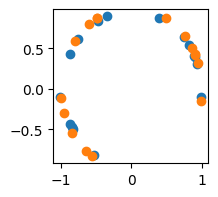

 72%|████████████████████████████████████████████████████████▉                      | 3603/5000 [02:31<01:20, 17.42it/s]

Epoch: 3601, Loss: 0.11691025644540787
Epoch: 3602, Loss: 0.11609730869531631


 72%|████████████████████████████████████████████████████████▉                      | 3606/5000 [02:31<01:11, 19.43it/s]

Epoch: 3603, Loss: 0.12449648231267929
Epoch: 3604, Loss: 0.12322506308555603
Epoch: 3605, Loss: 0.12659390270709991
Epoch: 3606, Loss: 0.11309675872325897
Epoch: 3607, Loss: 0.11910450458526611


 72%|█████████████████████████████████████████████████████████                      | 3609/5000 [02:31<01:23, 16.67it/s]

Epoch: 3608, Loss: 0.1199275478720665


 72%|█████████████████████████████████████████████████████████                      | 3611/5000 [02:32<01:22, 16.87it/s]

Epoch: 3609, Loss: 0.11215316504240036
Epoch: 3610, Loss: 0.12209399789571762
Epoch: 3611, Loss: 0.11377676576375961
Epoch: 3612, Loss: 0.12460573017597198


 72%|█████████████████████████████████████████████████████████                      | 3614/5000 [02:32<01:12, 19.00it/s]

Epoch: 3613, Loss: 0.11709388345479965
Epoch: 3614, Loss: 0.11959192156791687


 72%|█████████████████████████████████████████████████████████▏                     | 3617/5000 [02:32<01:07, 20.60it/s]

Epoch: 3615, Loss: 0.11857514083385468
Epoch: 3616, Loss: 0.12967833876609802
Epoch: 3617, Loss: 0.11886467039585114
Epoch: 3618, Loss: 0.1217915266752243


 72%|█████████████████████████████████████████████████████████▏                     | 3620/5000 [02:32<01:03, 21.83it/s]

Epoch: 3619, Loss: 0.13077741861343384
Epoch: 3620, Loss: 0.10825716704130173


 72%|█████████████████████████████████████████████████████████▏                     | 3623/5000 [02:32<01:01, 22.43it/s]

Epoch: 3621, Loss: 0.11766466498374939
Epoch: 3622, Loss: 0.1291288584470749
Epoch: 3623, Loss: 0.12241801619529724


 73%|█████████████████████████████████████████████████████████▎                     | 3629/5000 [02:32<01:06, 20.64it/s]

Epoch: 3624, Loss: 0.12457571923732758
Epoch: 3625, Loss: 0.10942640900611877
Epoch: 3626, Loss: 0.11037266254425049
Epoch: 3627, Loss: 0.112372025847435
Epoch: 3628, Loss: 0.1372116506099701


 73%|█████████████████████████████████████████████████████████▍                     | 3635/5000 [02:33<00:59, 22.99it/s]

Epoch: 3629, Loss: 0.11300007998943329
Epoch: 3630, Loss: 0.11278174817562103
Epoch: 3631, Loss: 0.13786746561527252
Epoch: 3632, Loss: 0.12233616411685944
Epoch: 3633, Loss: 0.12492434680461884
Epoch: 3634, Loss: 0.10877735167741776


 73%|█████████████████████████████████████████████████████████▍                     | 3638/5000 [02:33<00:56, 23.99it/s]

Epoch: 3635, Loss: 0.11658026278018951
Epoch: 3636, Loss: 0.11945885419845581
Epoch: 3637, Loss: 0.12954148650169373
Epoch: 3638, Loss: 0.11533279716968536
Epoch: 3639, Loss: 0.10477040708065033


 73%|█████████████████████████████████████████████████████████▌                     | 3644/5000 [02:33<00:57, 23.64it/s]

Epoch: 3640, Loss: 0.10860299319028854
Epoch: 3641, Loss: 0.13548651337623596
Epoch: 3642, Loss: 0.13856863975524902
Epoch: 3643, Loss: 0.13881386816501617
Epoch: 3644, Loss: 0.12210208177566528


 73%|█████████████████████████████████████████████████████████▋                     | 3650/5000 [02:33<00:54, 24.65it/s]

Epoch: 3645, Loss: 0.12264980375766754
Epoch: 3646, Loss: 0.12007912993431091
Epoch: 3647, Loss: 0.1394742727279663
Epoch: 3648, Loss: 0.11361626535654068
Epoch: 3649, Loss: 0.12593303620815277
Epoch: 3650, Loss: 0.12004858255386353


 73%|█████████████████████████████████████████████████████████▊                     | 3656/5000 [02:33<00:53, 24.90it/s]

Epoch: 3651, Loss: 0.12579938769340515
Epoch: 3652, Loss: 0.1310230791568756
Epoch: 3653, Loss: 0.13390493392944336
Epoch: 3654, Loss: 0.11410581320524216
Epoch: 3655, Loss: 0.12693029642105103


 73%|█████████████████████████████████████████████████████████▊                     | 3662/5000 [02:34<00:52, 25.69it/s]

Epoch: 3656, Loss: 0.12008531391620636
Epoch: 3657, Loss: 0.11415766924619675
Epoch: 3658, Loss: 0.1199500635266304
Epoch: 3659, Loss: 0.1288405954837799
Epoch: 3660, Loss: 0.11492437869310379
Epoch: 3661, Loss: 0.12007525563240051


 73%|█████████████████████████████████████████████████████████▉                     | 3665/5000 [02:34<00:56, 23.56it/s]

Epoch: 3662, Loss: 0.1221071183681488
Epoch: 3663, Loss: 0.11956483870744705
Epoch: 3664, Loss: 0.13217927515506744
Epoch: 3665, Loss: 0.12633943557739258
Epoch: 3666, Loss: 0.13603828847408295


 73%|██████████████████████████████████████████████████████████                     | 3671/5000 [02:34<00:58, 22.81it/s]

Epoch: 3667, Loss: 0.12711136043071747
Epoch: 3668, Loss: 0.11048321425914764
Epoch: 3669, Loss: 0.11968371272087097
Epoch: 3670, Loss: 0.1192980632185936
Epoch: 3671, Loss: 0.12062200903892517


 74%|██████████████████████████████████████████████████████████                     | 3677/5000 [02:34<01:01, 21.41it/s]

Epoch: 3672, Loss: 0.11719150841236115
Epoch: 3673, Loss: 0.12020909041166306
Epoch: 3674, Loss: 0.1461050659418106
Epoch: 3675, Loss: 0.12338580936193466
Epoch: 3676, Loss: 0.11448786407709122


 74%|██████████████████████████████████████████████████████████▏                    | 3680/5000 [02:35<01:05, 20.18it/s]

Epoch: 3677, Loss: 0.11920677125453949
Epoch: 3678, Loss: 0.13090886175632477
Epoch: 3679, Loss: 0.11774028837680817
Epoch: 3680, Loss: 0.14426803588867188


 74%|██████████████████████████████████████████████████████████▏                    | 3683/5000 [02:35<01:06, 19.92it/s]

Epoch: 3681, Loss: 0.1226138323545456
Epoch: 3682, Loss: 0.12365731596946716
Epoch: 3683, Loss: 0.12068469077348709


 74%|██████████████████████████████████████████████████████████▎                    | 3688/5000 [02:35<01:20, 16.39it/s]

Epoch: 3684, Loss: 0.13046827912330627
Epoch: 3685, Loss: 0.1159069612622261
Epoch: 3686, Loss: 0.11929307132959366
Epoch: 3687, Loss: 0.12060761451721191


 74%|██████████████████████████████████████████████████████████▎                    | 3694/5000 [02:35<01:05, 19.99it/s]

Epoch: 3688, Loss: 0.12586075067520142
Epoch: 3689, Loss: 0.1219543069601059
Epoch: 3690, Loss: 0.1127818375825882
Epoch: 3691, Loss: 0.12609335780143738
Epoch: 3692, Loss: 0.10711019486188889
Epoch: 3693, Loss: 0.11228270828723907


 74%|██████████████████████████████████████████████████████████▍                    | 3700/5000 [02:36<00:58, 22.35it/s]

Epoch: 3694, Loss: 0.11375594139099121
Epoch: 3695, Loss: 0.11133390665054321
Epoch: 3696, Loss: 0.12138389050960541
Epoch: 3697, Loss: 0.13217785954475403
Epoch: 3698, Loss: 0.11851876974105835
Epoch: 3699, Loss: 0.10864166915416718


 74%|██████████████████████████████████████████████████████████▌                    | 3703/5000 [02:36<00:56, 23.15it/s]

Epoch: 3700, Loss: 0.11700957268476486
Epoch: 3701, Loss: 0.12532241642475128
Epoch: 3702, Loss: 0.13104118406772614
Epoch: 3703, Loss: 0.11937321722507477
Epoch: 3704, Loss: 0.11948135495185852


 74%|██████████████████████████████████████████████████████████▌                    | 3709/5000 [02:36<00:54, 23.68it/s]

Epoch: 3705, Loss: 0.12152145802974701
Epoch: 3706, Loss: 0.12190526723861694
Epoch: 3707, Loss: 0.12354064732789993
Epoch: 3708, Loss: 0.1468455195426941
Epoch: 3709, Loss: 0.13145989179611206


 74%|██████████████████████████████████████████████████████████▋                    | 3715/5000 [02:36<00:52, 24.50it/s]

Epoch: 3710, Loss: 0.1312353014945984
Epoch: 3711, Loss: 0.11377212405204773
Epoch: 3712, Loss: 0.12237381935119629
Epoch: 3713, Loss: 0.12461565434932709
Epoch: 3714, Loss: 0.11030561476945877
Epoch: 3715, Loss: 0.13516829907894135


 74%|██████████████████████████████████████████████████████████▊                    | 3721/5000 [02:36<00:52, 24.40it/s]

Epoch: 3716, Loss: 0.11060188710689545
Epoch: 3717, Loss: 0.11581266671419144
Epoch: 3718, Loss: 0.11713896691799164
Epoch: 3719, Loss: 0.10748754441738129
Epoch: 3720, Loss: 0.12914405763149261
Epoch: 3721, Loss: 0.13234983384609222


 75%|██████████████████████████████████████████████████████████▉                    | 3727/5000 [02:37<00:52, 24.31it/s]

Epoch: 3722, Loss: 0.14689406752586365
Epoch: 3723, Loss: 0.12139074504375458
Epoch: 3724, Loss: 0.11532009392976761
Epoch: 3725, Loss: 0.12593840062618256
Epoch: 3726, Loss: 0.11508715152740479


 75%|██████████████████████████████████████████████████████████▉                    | 3730/5000 [02:37<00:52, 24.17it/s]

Epoch: 3727, Loss: 0.12083186209201813
Epoch: 3728, Loss: 0.1377856433391571
Epoch: 3729, Loss: 0.12470882385969162
Epoch: 3730, Loss: 0.12049213796854019
Epoch: 3731, Loss: 0.134404718875885


 75%|███████████████████████████████████████████████████████████                    | 3736/5000 [02:37<00:52, 24.12it/s]

Epoch: 3732, Loss: 0.12206786870956421
Epoch: 3733, Loss: 0.12566915154457092
Epoch: 3734, Loss: 0.11058356612920761
Epoch: 3735, Loss: 0.1216278076171875
Epoch: 3736, Loss: 0.11664745211601257
Epoch: 3737, Loss: 0.11637681722640991


 75%|███████████████████████████████████████████████████████████                    | 3742/5000 [02:37<00:50, 24.98it/s]

Epoch: 3738, Loss: 0.14690731465816498
Epoch: 3739, Loss: 0.13344743847846985
Epoch: 3740, Loss: 0.12125791609287262
Epoch: 3741, Loss: 0.12560033798217773
Epoch: 3742, Loss: 0.13809657096862793
Epoch: 3743, Loss: 0.1098032221198082


 75%|███████████████████████████████████████████████████████████▏                   | 3748/5000 [02:38<00:49, 25.15it/s]

Epoch: 3744, Loss: 0.14521923661231995
Epoch: 3745, Loss: 0.12643678486347198
Epoch: 3746, Loss: 0.13186311721801758
Epoch: 3747, Loss: 0.12990832328796387
Epoch: 3748, Loss: 0.11896910518407822
Epoch: 3749, Loss: 0.12796983122825623


 75%|███████████████████████████████████████████████████████████▎                   | 3754/5000 [02:38<00:47, 26.06it/s]

Epoch: 3750, Loss: 0.1234520822763443
Epoch: 3751, Loss: 0.11772739142179489
Epoch: 3752, Loss: 0.1278729885816574
Epoch: 3753, Loss: 0.11904292553663254
Epoch: 3754, Loss: 0.14199477434158325
Epoch: 3755, Loss: 0.110892653465271


 75%|███████████████████████████████████████████████████████████▍                   | 3760/5000 [02:38<00:47, 25.89it/s]

Epoch: 3756, Loss: 0.12507739663124084
Epoch: 3757, Loss: 0.11637771129608154
Epoch: 3758, Loss: 0.11759459227323532
Epoch: 3759, Loss: 0.11118462681770325
Epoch: 3760, Loss: 0.13356447219848633
Epoch: 3761, Loss: 0.12722791731357574


 75%|███████████████████████████████████████████████████████████▌                   | 3766/5000 [02:38<00:48, 25.68it/s]

Epoch: 3762, Loss: 0.12194354087114334
Epoch: 3763, Loss: 0.13535575568675995
Epoch: 3764, Loss: 0.11295238882303238
Epoch: 3765, Loss: 0.12038439512252808
Epoch: 3766, Loss: 0.13237854838371277
Epoch: 3767, Loss: 0.12554652988910675


 75%|███████████████████████████████████████████████████████████▌                   | 3772/5000 [02:38<00:47, 25.66it/s]

Epoch: 3768, Loss: 0.1454773098230362
Epoch: 3769, Loss: 0.11107206344604492
Epoch: 3770, Loss: 0.12049025297164917
Epoch: 3771, Loss: 0.12366193532943726
Epoch: 3772, Loss: 0.14158716797828674
Epoch: 3773, Loss: 0.11950518190860748


 76%|███████████████████████████████████████████████████████████▋                   | 3778/5000 [02:39<00:47, 25.48it/s]

Epoch: 3774, Loss: 0.11035130172967911
Epoch: 3775, Loss: 0.12010230123996735
Epoch: 3776, Loss: 0.11583685129880905
Epoch: 3777, Loss: 0.11796171218156815
Epoch: 3778, Loss: 0.12557560205459595
Epoch: 3779, Loss: 0.1205584704875946


 76%|███████████████████████████████████████████████████████████▊                   | 3784/5000 [02:39<00:47, 25.76it/s]

Epoch: 3780, Loss: 0.13011668622493744
Epoch: 3781, Loss: 0.12135030329227448
Epoch: 3782, Loss: 0.12619978189468384
Epoch: 3783, Loss: 0.12834985554218292
Epoch: 3784, Loss: 0.14483720064163208
Epoch: 3785, Loss: 0.12565506994724274


 76%|███████████████████████████████████████████████████████████▉                   | 3790/5000 [02:39<00:48, 24.97it/s]

Epoch: 3786, Loss: 0.13254275918006897
Epoch: 3787, Loss: 0.12702710926532745
Epoch: 3788, Loss: 0.13284523785114288
Epoch: 3789, Loss: 0.1283501386642456
Epoch: 3790, Loss: 0.11986632645130157
Epoch: 3791, Loss: 0.11738074570894241


 76%|███████████████████████████████████████████████████████████▉                   | 3796/5000 [02:39<00:48, 25.00it/s]

Epoch: 3792, Loss: 0.11013974249362946
Epoch: 3793, Loss: 0.15003103017807007
Epoch: 3794, Loss: 0.1344737559556961
Epoch: 3795, Loss: 0.14563408493995667
Epoch: 3796, Loss: 0.13658186793327332
Epoch: 3797, Loss: 0.12314456701278687


 76%|████████████████████████████████████████████████████████████                   | 3799/5000 [02:40<00:48, 24.80it/s]

Epoch: 3798, Loss: 0.14067138731479645
Epoch: 3799, Loss: 0.13074074685573578
Epoch: 3800, Loss: 0.14144404232501984


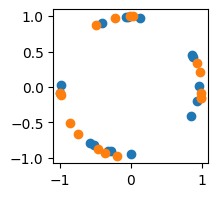

 76%|████████████████████████████████████████████████████████████                   | 3805/5000 [02:40<00:54, 21.82it/s]

Epoch: 3801, Loss: 0.11640632897615433
Epoch: 3802, Loss: 0.1305587887763977
Epoch: 3803, Loss: 0.13669638335704803
Epoch: 3804, Loss: 0.11950605362653732
Epoch: 3805, Loss: 0.12627173960208893
Epoch: 3806, Loss: 0.12270522117614746


 76%|████████████████████████████████████████████████████████████▏                  | 3811/5000 [02:40<00:51, 23.31it/s]

Epoch: 3807, Loss: 0.13032743334770203
Epoch: 3808, Loss: 0.1334339827299118
Epoch: 3809, Loss: 0.12432105839252472
Epoch: 3810, Loss: 0.12368986010551453
Epoch: 3811, Loss: 0.12483078241348267
Epoch: 3812, Loss: 0.14033947885036469


 76%|████████████████████████████████████████████████████████████▎                  | 3817/5000 [02:40<00:49, 23.87it/s]

Epoch: 3813, Loss: 0.1253187209367752
Epoch: 3814, Loss: 0.13313931226730347
Epoch: 3815, Loss: 0.11492837220430374
Epoch: 3816, Loss: 0.11735884845256805
Epoch: 3817, Loss: 0.11717399209737778


 76%|████████████████████████████████████████████████████████████▍                  | 3823/5000 [02:41<00:50, 23.40it/s]

Epoch: 3818, Loss: 0.11086726933717728
Epoch: 3819, Loss: 0.13352957367897034
Epoch: 3820, Loss: 0.16038814187049866
Epoch: 3821, Loss: 0.11328814178705215
Epoch: 3822, Loss: 0.11770733445882797


 77%|████████████████████████████████████████████████████████████▍                  | 3829/5000 [02:41<00:48, 24.36it/s]

Epoch: 3823, Loss: 0.12071545422077179
Epoch: 3824, Loss: 0.1287909746170044
Epoch: 3825, Loss: 0.12799088656902313
Epoch: 3826, Loss: 0.1155037060379982
Epoch: 3827, Loss: 0.13809244334697723
Epoch: 3828, Loss: 0.1341792345046997


 77%|████████████████████████████████████████████████████████████▌                  | 3835/5000 [02:41<00:47, 24.56it/s]

Epoch: 3829, Loss: 0.11120545864105225
Epoch: 3830, Loss: 0.11336442083120346
Epoch: 3831, Loss: 0.10717590153217316
Epoch: 3832, Loss: 0.12912456691265106
Epoch: 3833, Loss: 0.13072553277015686
Epoch: 3834, Loss: 0.12006355077028275


 77%|████████████████████████████████████████████████████████████▋                  | 3841/5000 [02:41<00:46, 24.74it/s]

Epoch: 3835, Loss: 0.11573603004217148
Epoch: 3836, Loss: 0.12163286656141281
Epoch: 3837, Loss: 0.12900522351264954
Epoch: 3838, Loss: 0.12289600074291229
Epoch: 3839, Loss: 0.1317264884710312
Epoch: 3840, Loss: 0.11677845567464828


 77%|████████████████████████████████████████████████████████████▊                  | 3847/5000 [02:42<00:45, 25.21it/s]

Epoch: 3841, Loss: 0.12126737087965012
Epoch: 3842, Loss: 0.1298641860485077
Epoch: 3843, Loss: 0.11371501535177231
Epoch: 3844, Loss: 0.11966976523399353
Epoch: 3845, Loss: 0.11138749867677689
Epoch: 3846, Loss: 0.11815007776021957


 77%|████████████████████████████████████████████████████████████▉                  | 3853/5000 [02:42<00:45, 25.48it/s]

Epoch: 3847, Loss: 0.1249760240316391
Epoch: 3848, Loss: 0.12259897589683533
Epoch: 3849, Loss: 0.11416935175657272
Epoch: 3850, Loss: 0.11524292081594467
Epoch: 3851, Loss: 0.10466185957193375
Epoch: 3852, Loss: 0.1363634467124939


 77%|████████████████████████████████████████████████████████████▉                  | 3859/5000 [02:42<00:44, 25.37it/s]

Epoch: 3853, Loss: 0.1134440004825592
Epoch: 3854, Loss: 0.12295985966920853
Epoch: 3855, Loss: 0.12579286098480225
Epoch: 3856, Loss: 0.13002808392047882
Epoch: 3857, Loss: 0.12980782985687256
Epoch: 3858, Loss: 0.12360158562660217


 77%|█████████████████████████████████████████████████████████████                  | 3865/5000 [02:42<00:44, 25.29it/s]

Epoch: 3859, Loss: 0.12241698801517487
Epoch: 3860, Loss: 0.1148044764995575
Epoch: 3861, Loss: 0.10503317415714264
Epoch: 3862, Loss: 0.12435332685709
Epoch: 3863, Loss: 0.1196942925453186
Epoch: 3864, Loss: 0.11999140679836273


 77%|█████████████████████████████████████████████████████████████▏                 | 3871/5000 [02:43<00:44, 25.25it/s]

Epoch: 3865, Loss: 0.12901686131954193
Epoch: 3866, Loss: 0.12489403784275055
Epoch: 3867, Loss: 0.13951106369495392
Epoch: 3868, Loss: 0.11632975190877914
Epoch: 3869, Loss: 0.12337392568588257
Epoch: 3870, Loss: 0.11675560474395752


 78%|█████████████████████████████████████████████████████████████▎                 | 3877/5000 [02:43<00:44, 25.36it/s]

Epoch: 3871, Loss: 0.11325056850910187
Epoch: 3872, Loss: 0.11519192159175873
Epoch: 3873, Loss: 0.11711818724870682
Epoch: 3874, Loss: 0.1208181083202362
Epoch: 3875, Loss: 0.11913055181503296
Epoch: 3876, Loss: 0.13239604234695435


 78%|█████████████████████████████████████████████████████████████▎                 | 3883/5000 [02:43<00:44, 24.99it/s]

Epoch: 3877, Loss: 0.11246204376220703
Epoch: 3878, Loss: 0.12343642860651016
Epoch: 3879, Loss: 0.10987907648086548
Epoch: 3880, Loss: 0.1179826408624649
Epoch: 3881, Loss: 0.1184440329670906
Epoch: 3882, Loss: 0.13817358016967773


 78%|█████████████████████████████████████████████████████████████▍                 | 3886/5000 [02:43<00:44, 24.82it/s]

Epoch: 3883, Loss: 0.14229653775691986
Epoch: 3884, Loss: 0.1265667825937271
Epoch: 3885, Loss: 0.15244528651237488
Epoch: 3886, Loss: 0.12348012626171112
Epoch: 3887, Loss: 0.1136854737997055


 78%|█████████████████████████████████████████████████████████████▍                 | 3892/5000 [02:43<00:45, 24.61it/s]

Epoch: 3888, Loss: 0.15018230676651
Epoch: 3889, Loss: 0.13668978214263916
Epoch: 3890, Loss: 0.11774701625108719
Epoch: 3891, Loss: 0.11673922091722488
Epoch: 3892, Loss: 0.12691164016723633
Epoch: 3893, Loss: 0.12382687628269196


 78%|█████████████████████████████████████████████████████████████▌                 | 3898/5000 [02:44<00:43, 25.21it/s]

Epoch: 3894, Loss: 0.11950715631246567
Epoch: 3895, Loss: 0.1348167210817337
Epoch: 3896, Loss: 0.11595404893159866
Epoch: 3897, Loss: 0.11312100291252136
Epoch: 3898, Loss: 0.12195205688476562
Epoch: 3899, Loss: 0.11569537222385406


 78%|█████████████████████████████████████████████████████████████▋                 | 3904/5000 [02:44<00:43, 24.93it/s]

Epoch: 3900, Loss: 0.12277958542108536
Epoch: 3901, Loss: 0.11212676763534546
Epoch: 3902, Loss: 0.12232444435358047
Epoch: 3903, Loss: 0.12322697043418884
Epoch: 3904, Loss: 0.10993155837059021
Epoch: 3905, Loss: 0.12165984511375427


 78%|█████████████████████████████████████████████████████████████▊                 | 3910/5000 [02:44<00:43, 24.98it/s]

Epoch: 3906, Loss: 0.11446240544319153
Epoch: 3907, Loss: 0.12174875289201736
Epoch: 3908, Loss: 0.14087963104248047
Epoch: 3909, Loss: 0.12784919142723083
Epoch: 3910, Loss: 0.13593977689743042
Epoch: 3911, Loss: 0.1297113597393036


 78%|█████████████████████████████████████████████████████████████▊                 | 3916/5000 [02:44<00:43, 24.98it/s]

Epoch: 3912, Loss: 0.11623689532279968
Epoch: 3913, Loss: 0.12890417873859406
Epoch: 3914, Loss: 0.11728712916374207
Epoch: 3915, Loss: 0.1279812753200531
Epoch: 3916, Loss: 0.11837480962276459
Epoch: 3917, Loss: 0.1312509924173355


 78%|█████████████████████████████████████████████████████████████▉                 | 3922/5000 [02:45<00:44, 24.31it/s]

Epoch: 3918, Loss: 0.11951618641614914
Epoch: 3919, Loss: 0.10879898071289062
Epoch: 3920, Loss: 0.11876547336578369
Epoch: 3921, Loss: 0.15045425295829773
Epoch: 3922, Loss: 0.11830012500286102


 79%|██████████████████████████████████████████████████████████████                 | 3928/5000 [02:45<00:43, 24.53it/s]

Epoch: 3923, Loss: 0.12131396681070328
Epoch: 3924, Loss: 0.11209877580404282
Epoch: 3925, Loss: 0.13680565357208252
Epoch: 3926, Loss: 0.11963413655757904
Epoch: 3927, Loss: 0.11484122276306152


 79%|██████████████████████████████████████████████████████████████▏                | 3934/5000 [02:45<00:42, 25.00it/s]

Epoch: 3928, Loss: 0.11550460010766983
Epoch: 3929, Loss: 0.10953531414270401
Epoch: 3930, Loss: 0.11468324810266495
Epoch: 3931, Loss: 0.11083155125379562
Epoch: 3932, Loss: 0.13009367883205414
Epoch: 3933, Loss: 0.10896959900856018


 79%|██████████████████████████████████████████████████████████████▎                | 3940/5000 [02:45<00:42, 24.87it/s]

Epoch: 3934, Loss: 0.12575757503509521
Epoch: 3935, Loss: 0.1265256702899933
Epoch: 3936, Loss: 0.1374317854642868
Epoch: 3937, Loss: 0.13192929327487946
Epoch: 3938, Loss: 0.12103909254074097
Epoch: 3939, Loss: 0.15072953701019287


 79%|██████████████████████████████████████████████████████████████▎                | 3943/5000 [02:45<00:44, 23.75it/s]

Epoch: 3940, Loss: 0.1089748665690422
Epoch: 3941, Loss: 0.12467518448829651
Epoch: 3942, Loss: 0.12193691730499268
Epoch: 3943, Loss: 0.12724600732326508
Epoch: 3944, Loss: 0.13991710543632507


 79%|██████████████████████████████████████████████████████████████▍                | 3949/5000 [02:46<00:42, 24.82it/s]

Epoch: 3945, Loss: 0.12199246883392334
Epoch: 3946, Loss: 0.13501012325286865
Epoch: 3947, Loss: 0.12414439022541046
Epoch: 3948, Loss: 0.12067021429538727
Epoch: 3949, Loss: 0.12544363737106323
Epoch: 3950, Loss: 0.11681582033634186


 79%|██████████████████████████████████████████████████████████████▍                | 3955/5000 [02:46<00:41, 24.93it/s]

Epoch: 3951, Loss: 0.1172742247581482
Epoch: 3952, Loss: 0.11779181659221649
Epoch: 3953, Loss: 0.1459880769252777
Epoch: 3954, Loss: 0.12164372950792313
Epoch: 3955, Loss: 0.11065106838941574


 79%|██████████████████████████████████████████████████████████████▌                | 3961/5000 [02:46<00:41, 24.89it/s]

Epoch: 3956, Loss: 0.11980777978897095
Epoch: 3957, Loss: 0.1184992864727974
Epoch: 3958, Loss: 0.12543818354606628
Epoch: 3959, Loss: 0.12203174829483032
Epoch: 3960, Loss: 0.10993825644254684
Epoch: 3961, Loss: 0.11146321892738342


 79%|██████████████████████████████████████████████████████████████▋                | 3967/5000 [02:46<00:41, 24.98it/s]

Epoch: 3962, Loss: 0.1175031065940857
Epoch: 3963, Loss: 0.10935176908969879
Epoch: 3964, Loss: 0.1463310718536377
Epoch: 3965, Loss: 0.12019483745098114
Epoch: 3966, Loss: 0.1312934011220932


 79%|██████████████████████████████████████████████████████████████▊                | 3973/5000 [02:47<00:40, 25.27it/s]

Epoch: 3967, Loss: 0.12465918064117432
Epoch: 3968, Loss: 0.11283901333808899
Epoch: 3969, Loss: 0.15868708491325378
Epoch: 3970, Loss: 0.1350899338722229
Epoch: 3971, Loss: 0.12040574848651886
Epoch: 3972, Loss: 0.11102112382650375


 80%|██████████████████████████████████████████████████████████████▊                | 3976/5000 [02:47<00:41, 24.94it/s]

Epoch: 3973, Loss: 0.1140698790550232
Epoch: 3974, Loss: 0.11931896209716797
Epoch: 3975, Loss: 0.11496534198522568
Epoch: 3976, Loss: 0.10945829004049301
Epoch: 3977, Loss: 0.11495959758758545


 80%|██████████████████████████████████████████████████████████████▉                | 3982/5000 [02:47<00:42, 23.78it/s]

Epoch: 3978, Loss: 0.12209300696849823
Epoch: 3979, Loss: 0.11338557302951813
Epoch: 3980, Loss: 0.12784484028816223
Epoch: 3981, Loss: 0.1092924177646637
Epoch: 3982, Loss: 0.14495393633842468


 80%|███████████████████████████████████████████████████████████████                | 3988/5000 [02:47<00:41, 24.31it/s]

Epoch: 3983, Loss: 0.1234150230884552
Epoch: 3984, Loss: 0.12462655454874039
Epoch: 3985, Loss: 0.10613006353378296
Epoch: 3986, Loss: 0.12167100608348846
Epoch: 3987, Loss: 0.13231535255908966


 80%|███████████████████████████████████████████████████████████████                | 3994/5000 [02:48<00:40, 25.03it/s]

Epoch: 3988, Loss: 0.11631230264902115
Epoch: 3989, Loss: 0.11678057909011841
Epoch: 3990, Loss: 0.11107336729764938
Epoch: 3991, Loss: 0.1172698363661766
Epoch: 3992, Loss: 0.11520714312791824
Epoch: 3993, Loss: 0.12845265865325928


 80%|███████████████████████████████████████████████████████████████▏               | 4000/5000 [02:48<00:40, 24.74it/s]

Epoch: 3994, Loss: 0.13070902228355408
Epoch: 3995, Loss: 0.12321427464485168
Epoch: 3996, Loss: 0.1750427782535553
Epoch: 3997, Loss: 0.12245161086320877
Epoch: 3998, Loss: 0.125605970621109
Epoch: 3999, Loss: 0.12186183035373688
Epoch: 4000, Loss: 0.10606380552053452


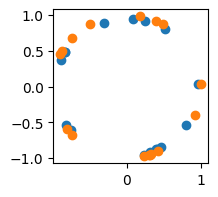

 80%|███████████████████████████████████████████████████████████████▏               | 4003/5000 [02:48<00:48, 20.49it/s]

Epoch: 4001, Loss: 0.13207104802131653
Epoch: 4002, Loss: 0.10902874916791916


 80%|███████████████████████████████████████████████████████████████▎               | 4006/5000 [02:48<00:45, 21.68it/s]

Epoch: 4003, Loss: 0.11467278748750687
Epoch: 4004, Loss: 0.10452866554260254
Epoch: 4005, Loss: 0.14074069261550903


 80%|███████████████████████████████████████████████████████████████▎               | 4009/5000 [02:48<00:44, 22.07it/s]

Epoch: 4006, Loss: 0.12048894166946411
Epoch: 4007, Loss: 0.12519797682762146
Epoch: 4008, Loss: 0.12018051743507385
Epoch: 4009, Loss: 0.10587601363658905
Epoch: 4010, Loss: 0.11410339921712875


 80%|███████████████████████████████████████████████████████████████▍               | 4015/5000 [02:48<00:42, 22.95it/s]

Epoch: 4011, Loss: 0.11599664390087128
Epoch: 4012, Loss: 0.12146545946598053
Epoch: 4013, Loss: 0.12111424654722214
Epoch: 4014, Loss: 0.11015360802412033
Epoch: 4015, Loss: 0.14668530225753784


 80%|███████████████████████████████████████████████████████████████▌               | 4021/5000 [02:49<00:41, 23.85it/s]

Epoch: 4016, Loss: 0.11652178317308426
Epoch: 4017, Loss: 0.13249869644641876
Epoch: 4018, Loss: 0.1331227570772171
Epoch: 4019, Loss: 0.11277976632118225
Epoch: 4020, Loss: 0.13679775595664978
Epoch: 4021, Loss: 0.16086344420909882


 81%|███████████████████████████████████████████████████████████████▋               | 4027/5000 [02:49<00:39, 24.72it/s]

Epoch: 4022, Loss: 0.13932427763938904
Epoch: 4023, Loss: 0.12233851850032806
Epoch: 4024, Loss: 0.11640164256095886
Epoch: 4025, Loss: 0.11555694043636322
Epoch: 4026, Loss: 0.13056118786334991
Epoch: 4027, Loss: 0.12655837833881378


 81%|███████████████████████████████████████████████████████████████▋               | 4033/5000 [02:49<00:38, 25.01it/s]

Epoch: 4028, Loss: 0.12494024634361267
Epoch: 4029, Loss: 0.1261373907327652
Epoch: 4030, Loss: 0.11447346210479736
Epoch: 4031, Loss: 0.12852203845977783
Epoch: 4032, Loss: 0.11853553354740143
Epoch: 4033, Loss: 0.1234154999256134


 81%|███████████████████████████████████████████████████████████████▊               | 4036/5000 [02:49<00:39, 24.33it/s]

Epoch: 4034, Loss: 0.11792748421430588
Epoch: 4035, Loss: 0.127395361661911
Epoch: 4036, Loss: 0.1242208480834961
Epoch: 4037, Loss: 0.12158757448196411


 81%|███████████████████████████████████████████████████████████████▊               | 4039/5000 [02:49<00:39, 24.37it/s]

Epoch: 4038, Loss: 0.13092155754566193


 81%|███████████████████████████████████████████████████████████████▊               | 4042/5000 [02:50<00:40, 23.82it/s]

Epoch: 4039, Loss: 0.12177000939846039
Epoch: 4040, Loss: 0.11485253274440765
Epoch: 4041, Loss: 0.15230469405651093
Epoch: 4042, Loss: 0.12054450064897537
Epoch: 4043, Loss: 0.11443690955638885


 81%|███████████████████████████████████████████████████████████████▉               | 4048/5000 [02:50<00:40, 23.77it/s]

Epoch: 4044, Loss: 0.12364193797111511
Epoch: 4045, Loss: 0.10663878172636032
Epoch: 4046, Loss: 0.11577554047107697
Epoch: 4047, Loss: 0.11509846150875092
Epoch: 4048, Loss: 0.10316355526447296


 81%|████████████████████████████████████████████████████████████████               | 4051/5000 [02:50<00:39, 23.85it/s]

Epoch: 4049, Loss: 0.11052053421735764
Epoch: 4050, Loss: 0.11536671966314316
Epoch: 4051, Loss: 0.13347983360290527
Epoch: 4052, Loss: 0.1308165341615677


 81%|████████████████████████████████████████████████████████████████               | 4054/5000 [02:50<00:39, 23.80it/s]

Epoch: 4053, Loss: 0.12031160295009613


 81%|████████████████████████████████████████████████████████████████               | 4057/5000 [02:50<00:40, 23.33it/s]

Epoch: 4054, Loss: 0.12980011105537415
Epoch: 4055, Loss: 0.13345840573310852
Epoch: 4056, Loss: 0.13292768597602844
Epoch: 4057, Loss: 0.12244835495948792
Epoch: 4058, Loss: 0.1307731717824936


 81%|████████████████████████████████████████████████████████████████▏              | 4063/5000 [02:50<00:40, 23.03it/s]

Epoch: 4059, Loss: 0.12438371777534485
Epoch: 4060, Loss: 0.14503593742847443
Epoch: 4061, Loss: 0.12320193648338318
Epoch: 4062, Loss: 0.124188631772995
Epoch: 4063, Loss: 0.12048500776290894


 81%|████████████████████████████████████████████████████████████████▏              | 4066/5000 [02:51<00:40, 23.17it/s]

Epoch: 4064, Loss: 0.127961665391922
Epoch: 4065, Loss: 0.1203184649348259
Epoch: 4066, Loss: 0.1232750415802002
Epoch: 4067, Loss: 0.13410095870494843


 81%|████████████████████████████████████████████████████████████████▎              | 4069/5000 [02:51<00:39, 23.31it/s]

Epoch: 4068, Loss: 0.1433834433555603


 81%|████████████████████████████████████████████████████████████████▎              | 4072/5000 [02:51<00:39, 23.43it/s]

Epoch: 4069, Loss: 0.11509856581687927
Epoch: 4070, Loss: 0.11631673574447632
Epoch: 4071, Loss: 0.1853642761707306
Epoch: 4072, Loss: 0.12903110682964325
Epoch: 4073, Loss: 0.12025730311870575


 82%|████████████████████████████████████████████████████████████████▍              | 4078/5000 [02:51<00:39, 23.61it/s]

Epoch: 4074, Loss: 0.13037648797035217
Epoch: 4075, Loss: 0.11750038713216782
Epoch: 4076, Loss: 0.12610788643360138
Epoch: 4077, Loss: 0.11849852651357651
Epoch: 4078, Loss: 0.12346775829792023


 82%|████████████████████████████████████████████████████████████████▌              | 4084/5000 [02:51<00:37, 24.11it/s]

Epoch: 4079, Loss: 0.15350283682346344
Epoch: 4080, Loss: 0.1115838959813118
Epoch: 4081, Loss: 0.13584506511688232
Epoch: 4082, Loss: 0.12020046263933182
Epoch: 4083, Loss: 0.1192430704832077


 82%|████████████████████████████████████████████████████████████████▌              | 4090/5000 [02:52<00:36, 24.94it/s]

Epoch: 4084, Loss: 0.12142441421747208
Epoch: 4085, Loss: 0.11947016417980194
Epoch: 4086, Loss: 0.12910062074661255
Epoch: 4087, Loss: 0.138942152261734
Epoch: 4088, Loss: 0.1289532333612442
Epoch: 4089, Loss: 0.13225920498371124


 82%|████████████████████████████████████████████████████████████████▋              | 4096/5000 [02:52<00:36, 25.09it/s]

Epoch: 4090, Loss: 0.12210889160633087
Epoch: 4091, Loss: 0.1343938410282135
Epoch: 4092, Loss: 0.13882111012935638
Epoch: 4093, Loss: 0.11495678871870041
Epoch: 4094, Loss: 0.12248885631561279
Epoch: 4095, Loss: 0.13334336876869202


 82%|████████████████████████████████████████████████████████████████▊              | 4102/5000 [02:52<00:36, 24.71it/s]

Epoch: 4096, Loss: 0.11938609927892685
Epoch: 4097, Loss: 0.13391748070716858
Epoch: 4098, Loss: 0.1324741542339325
Epoch: 4099, Loss: 0.11539345234632492
Epoch: 4100, Loss: 0.12873557209968567
Epoch: 4101, Loss: 0.1354759782552719


 82%|████████████████████████████████████████████████████████████████▉              | 4108/5000 [02:52<00:35, 25.06it/s]

Epoch: 4102, Loss: 0.12221105396747589
Epoch: 4103, Loss: 0.12705174088478088
Epoch: 4104, Loss: 0.12336002290248871
Epoch: 4105, Loss: 0.11164648830890656
Epoch: 4106, Loss: 0.10547368228435516
Epoch: 4107, Loss: 0.12910965085029602


 82%|█████████████████████████████████████████████████████████████████              | 4114/5000 [02:53<00:34, 25.40it/s]

Epoch: 4108, Loss: 0.1134725958108902
Epoch: 4109, Loss: 0.13506639003753662
Epoch: 4110, Loss: 0.12358300387859344
Epoch: 4111, Loss: 0.12372186779975891
Epoch: 4112, Loss: 0.11313919723033905
Epoch: 4113, Loss: 0.12298689782619476


 82%|█████████████████████████████████████████████████████████████████              | 4120/5000 [02:53<00:34, 25.18it/s]

Epoch: 4114, Loss: 0.12015978246927261
Epoch: 4115, Loss: 0.1162482425570488
Epoch: 4116, Loss: 0.1273408979177475
Epoch: 4117, Loss: 0.1190243661403656
Epoch: 4118, Loss: 0.11873800307512283
Epoch: 4119, Loss: 0.13313031196594238


 82%|█████████████████████████████████████████████████████████████████▏             | 4123/5000 [02:53<00:35, 24.61it/s]

Epoch: 4120, Loss: 0.12221761792898178
Epoch: 4121, Loss: 0.11855670809745789
Epoch: 4122, Loss: 0.12064313143491745
Epoch: 4123, Loss: 0.11373172700405121
Epoch: 4124, Loss: 0.11753720045089722


 83%|█████████████████████████████████████████████████████████████████▏             | 4129/5000 [02:53<00:35, 24.59it/s]

Epoch: 4125, Loss: 0.10537967085838318
Epoch: 4126, Loss: 0.12462761998176575
Epoch: 4127, Loss: 0.13371580839157104
Epoch: 4128, Loss: 0.11169172078371048
Epoch: 4129, Loss: 0.11423574388027191


 83%|█████████████████████████████████████████████████████████████████▎             | 4135/5000 [02:53<00:34, 24.83it/s]

Epoch: 4130, Loss: 0.12058711051940918
Epoch: 4131, Loss: 0.10862796753644943
Epoch: 4132, Loss: 0.11634951829910278
Epoch: 4133, Loss: 0.13673177361488342
Epoch: 4134, Loss: 0.13187313079833984
Epoch: 4135, Loss: 0.1333206295967102


 83%|█████████████████████████████████████████████████████████████████▍             | 4141/5000 [02:54<00:33, 25.87it/s]

Epoch: 4136, Loss: 0.1374589502811432
Epoch: 4137, Loss: 0.12396407127380371
Epoch: 4138, Loss: 0.12309227883815765
Epoch: 4139, Loss: 0.1362331211566925
Epoch: 4140, Loss: 0.1299198716878891
Epoch: 4141, Loss: 0.1114589273929596


 83%|█████████████████████████████████████████████████████████████████▌             | 4147/5000 [02:54<00:33, 25.14it/s]

Epoch: 4142, Loss: 0.11704946309328079
Epoch: 4143, Loss: 0.10774461925029755
Epoch: 4144, Loss: 0.11750731617212296
Epoch: 4145, Loss: 0.12452652305364609
Epoch: 4146, Loss: 0.12248845398426056


 83%|█████████████████████████████████████████████████████████████████▌             | 4150/5000 [02:54<00:33, 25.13it/s]

Epoch: 4147, Loss: 0.12480296194553375
Epoch: 4148, Loss: 0.12065458297729492
Epoch: 4149, Loss: 0.12307145446538925
Epoch: 4150, Loss: 0.1366068571805954
Epoch: 4151, Loss: 0.1135689988732338


 83%|█████████████████████████████████████████████████████████████████▋             | 4156/5000 [02:54<00:34, 24.61it/s]

Epoch: 4152, Loss: 0.14619854092597961
Epoch: 4153, Loss: 0.11562223732471466
Epoch: 4154, Loss: 0.12601718306541443
Epoch: 4155, Loss: 0.12482670694589615
Epoch: 4156, Loss: 0.12770207226276398


 83%|█████████████████████████████████████████████████████████████████▊             | 4162/5000 [02:54<00:33, 24.71it/s]

Epoch: 4157, Loss: 0.14226165413856506
Epoch: 4158, Loss: 0.12871797382831573
Epoch: 4159, Loss: 0.12939435243606567
Epoch: 4160, Loss: 0.12095849961042404
Epoch: 4161, Loss: 0.11789073795080185
Epoch: 4162, Loss: 0.11476334929466248


 83%|█████████████████████████████████████████████████████████████████▊             | 4168/5000 [02:55<00:33, 24.91it/s]

Epoch: 4163, Loss: 0.11841628700494766
Epoch: 4164, Loss: 0.10961499065160751
Epoch: 4165, Loss: 0.11957372725009918
Epoch: 4166, Loss: 0.1197415366768837
Epoch: 4167, Loss: 0.11497871577739716


 83%|█████████████████████████████████████████████████████████████████▉             | 4174/5000 [02:55<00:33, 24.99it/s]

Epoch: 4168, Loss: 0.1304853856563568
Epoch: 4169, Loss: 0.11458863317966461
Epoch: 4170, Loss: 0.14023457467556
Epoch: 4171, Loss: 0.11715608090162277
Epoch: 4172, Loss: 0.11889403313398361
Epoch: 4173, Loss: 0.113901287317276


 84%|██████████████████████████████████████████████████████████████████             | 4180/5000 [02:55<00:32, 25.21it/s]

Epoch: 4174, Loss: 0.12217091768980026
Epoch: 4175, Loss: 0.1322803497314453
Epoch: 4176, Loss: 0.13435491919517517
Epoch: 4177, Loss: 0.12409243732690811
Epoch: 4178, Loss: 0.14284062385559082
Epoch: 4179, Loss: 0.13653603196144104


 84%|██████████████████████████████████████████████████████████████████             | 4183/5000 [02:55<00:32, 25.33it/s]

Epoch: 4180, Loss: 0.11764498054981232
Epoch: 4181, Loss: 0.12712395191192627
Epoch: 4182, Loss: 0.13595476746559143
Epoch: 4183, Loss: 0.12471002340316772
Epoch: 4184, Loss: 0.1138676106929779


 84%|██████████████████████████████████████████████████████████████████▏            | 4189/5000 [02:56<00:32, 24.70it/s]

Epoch: 4185, Loss: 0.11555309593677521
Epoch: 4186, Loss: 0.1388019323348999
Epoch: 4187, Loss: 0.15635694563388824
Epoch: 4188, Loss: 0.12465257197618484
Epoch: 4189, Loss: 0.11711151897907257
Epoch: 4190, Loss: 0.12126331031322479


 84%|██████████████████████████████████████████████████████████████████▎            | 4195/5000 [02:56<00:32, 25.10it/s]

Epoch: 4191, Loss: 0.12957318127155304
Epoch: 4192, Loss: 0.13521745800971985
Epoch: 4193, Loss: 0.1153877004981041
Epoch: 4194, Loss: 0.1200265884399414
Epoch: 4195, Loss: 0.12363168597221375
Epoch: 4196, Loss: 0.10569539666175842


 84%|██████████████████████████████████████████████████████████████████▎            | 4198/5000 [02:56<00:32, 24.97it/s]

Epoch: 4197, Loss: 0.12416603416204453
Epoch: 4198, Loss: 0.13837316632270813
Epoch: 4199, Loss: 0.14098595082759857
Epoch: 4200, Loss: 0.10719823837280273


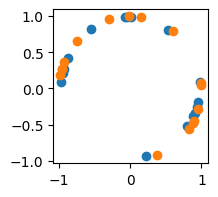

 84%|██████████████████████████████████████████████████████████████████▍            | 4207/5000 [02:56<00:34, 22.79it/s]

Epoch: 4201, Loss: 0.11487235128879547
Epoch: 4202, Loss: 0.12470198422670364
Epoch: 4203, Loss: 0.11814557015895844
Epoch: 4204, Loss: 0.13242192566394806
Epoch: 4205, Loss: 0.10671642422676086
Epoch: 4206, Loss: 0.11542879790067673


 84%|██████████████████████████████████████████████████████████████████▌            | 4213/5000 [02:57<00:32, 23.98it/s]

Epoch: 4207, Loss: 0.12365397065877914
Epoch: 4208, Loss: 0.11907986551523209
Epoch: 4209, Loss: 0.1197507306933403
Epoch: 4210, Loss: 0.12130560725927353
Epoch: 4211, Loss: 0.1284032016992569
Epoch: 4212, Loss: 0.13058865070343018


 84%|██████████████████████████████████████████████████████████████████▌            | 4216/5000 [02:57<00:33, 23.62it/s]

Epoch: 4213, Loss: 0.12110242992639542
Epoch: 4214, Loss: 0.11682797968387604
Epoch: 4215, Loss: 0.12846019864082336
Epoch: 4216, Loss: 0.12002667039632797
Epoch: 4217, Loss: 0.11933103203773499


 84%|██████████████████████████████████████████████████████████████████▋            | 4222/5000 [02:57<00:32, 23.86it/s]

Epoch: 4218, Loss: 0.11618056148290634
Epoch: 4219, Loss: 0.12726883590221405
Epoch: 4220, Loss: 0.12309172749519348
Epoch: 4221, Loss: 0.12754589319229126
Epoch: 4222, Loss: 0.11019645631313324
Epoch: 4223, Loss: 0.1114460900425911


 85%|██████████████████████████████████████████████████████████████████▊            | 4228/5000 [02:57<00:31, 24.15it/s]

Epoch: 4224, Loss: 0.10634558647871017
Epoch: 4225, Loss: 0.12354114651679993
Epoch: 4226, Loss: 0.1155669093132019
Epoch: 4227, Loss: 0.13098153471946716
Epoch: 4228, Loss: 0.11098174005746841


 85%|██████████████████████████████████████████████████████████████████▉            | 4234/5000 [02:58<00:32, 23.75it/s]

Epoch: 4229, Loss: 0.12305586785078049
Epoch: 4230, Loss: 0.11208908259868622
Epoch: 4231, Loss: 0.1286279261112213
Epoch: 4232, Loss: 0.12357832491397858
Epoch: 4233, Loss: 0.11049115657806396
Epoch: 4234, Loss: 0.11504565924406052


 85%|██████████████████████████████████████████████████████████████████▉            | 4240/5000 [02:58<00:31, 24.29it/s]

Epoch: 4235, Loss: 0.13427138328552246
Epoch: 4236, Loss: 0.12840479612350464
Epoch: 4237, Loss: 0.1145983636379242
Epoch: 4238, Loss: 0.1429234743118286
Epoch: 4239, Loss: 0.11553209275007248
Epoch: 4240, Loss: 0.1095159500837326


 85%|███████████████████████████████████████████████████████████████████            | 4246/5000 [02:58<00:30, 24.55it/s]

Epoch: 4241, Loss: 0.11269573867321014
Epoch: 4242, Loss: 0.12879769504070282
Epoch: 4243, Loss: 0.11023597419261932
Epoch: 4244, Loss: 0.13225601613521576
Epoch: 4245, Loss: 0.1265038251876831


 85%|███████████████████████████████████████████████████████████████████▏           | 4249/5000 [02:58<00:31, 24.10it/s]

Epoch: 4246, Loss: 0.12314185500144958
Epoch: 4247, Loss: 0.11098147928714752
Epoch: 4248, Loss: 0.11937379091978073
Epoch: 4249, Loss: 0.10644318163394928
Epoch: 4250, Loss: 0.12432059645652771
Epoch: 4251, Loss: 0.11516112089157104


 85%|███████████████████████████████████████████████████████████████████▎           | 4258/5000 [02:58<00:29, 25.29it/s]

Epoch: 4252, Loss: 0.10853376984596252
Epoch: 4253, Loss: 0.11900308728218079
Epoch: 4254, Loss: 0.13629454374313354
Epoch: 4255, Loss: 0.11440452933311462
Epoch: 4256, Loss: 0.1206706315279007
Epoch: 4257, Loss: 0.12251169979572296


 85%|███████████████████████████████████████████████████████████████████▎           | 4264/5000 [02:59<00:28, 26.04it/s]

Epoch: 4258, Loss: 0.13801352679729462
Epoch: 4259, Loss: 0.12220093607902527
Epoch: 4260, Loss: 0.11995673179626465
Epoch: 4261, Loss: 0.13153475522994995
Epoch: 4262, Loss: 0.11605314165353775
Epoch: 4263, Loss: 0.1209944635629654


 85%|███████████████████████████████████████████████████████████████████▍           | 4267/5000 [02:59<00:29, 24.69it/s]

Epoch: 4264, Loss: 0.1258310079574585
Epoch: 4265, Loss: 0.12062054872512817
Epoch: 4266, Loss: 0.11106468737125397
Epoch: 4267, Loss: 0.11558178067207336
Epoch: 4268, Loss: 0.1267184466123581


 85%|███████████████████████████████████████████████████████████████████▌           | 4273/5000 [02:59<00:31, 23.32it/s]

Epoch: 4269, Loss: 0.11753202974796295
Epoch: 4270, Loss: 0.11611106991767883
Epoch: 4271, Loss: 0.13496363162994385
Epoch: 4272, Loss: 0.11132636666297913
Epoch: 4273, Loss: 0.13110661506652832


 86%|███████████████████████████████████████████████████████████████████▌           | 4279/5000 [02:59<00:30, 23.62it/s]

Epoch: 4274, Loss: 0.12140913307666779
Epoch: 4275, Loss: 0.11473432183265686
Epoch: 4276, Loss: 0.12483589351177216
Epoch: 4277, Loss: 0.11692558974027634
Epoch: 4278, Loss: 0.125467911362648


 86%|███████████████████████████████████████████████████████████████████▋           | 4285/5000 [03:00<00:28, 24.73it/s]

Epoch: 4279, Loss: 0.14914117753505707
Epoch: 4280, Loss: 0.1091187372803688
Epoch: 4281, Loss: 0.13330233097076416
Epoch: 4282, Loss: 0.12966157495975494
Epoch: 4283, Loss: 0.11464017629623413
Epoch: 4284, Loss: 0.12155156582593918


 86%|███████████████████████████████████████████████████████████████████▊           | 4291/5000 [03:00<00:28, 24.93it/s]

Epoch: 4285, Loss: 0.1500379890203476
Epoch: 4286, Loss: 0.14626243710517883
Epoch: 4287, Loss: 0.11639679223299026
Epoch: 4288, Loss: 0.11430294066667557
Epoch: 4289, Loss: 0.14719924330711365
Epoch: 4290, Loss: 0.12517620623111725


 86%|███████████████████████████████████████████████████████████████████▉           | 4297/5000 [03:00<00:28, 24.45it/s]

Epoch: 4291, Loss: 0.12132226675748825
Epoch: 4292, Loss: 0.1326257884502411
Epoch: 4293, Loss: 0.13244163990020752
Epoch: 4294, Loss: 0.12187092006206512
Epoch: 4295, Loss: 0.12868459522724152
Epoch: 4296, Loss: 0.11784983426332474


 86%|███████████████████████████████████████████████████████████████████▉           | 4303/5000 [03:00<00:27, 24.98it/s]

Epoch: 4297, Loss: 0.13889263570308685
Epoch: 4298, Loss: 0.13008998334407806
Epoch: 4299, Loss: 0.11363525688648224
Epoch: 4300, Loss: 0.12891659140586853
Epoch: 4301, Loss: 0.1259860098361969
Epoch: 4302, Loss: 0.12232466042041779


 86%|████████████████████████████████████████████████████████████████████           | 4306/5000 [03:00<00:28, 24.06it/s]

Epoch: 4303, Loss: 0.13054370880126953
Epoch: 4304, Loss: 0.13041117787361145
Epoch: 4305, Loss: 0.1256132572889328
Epoch: 4306, Loss: 0.11628124862909317
Epoch: 4307, Loss: 0.12577709555625916


 86%|████████████████████████████████████████████████████████████████████▏          | 4312/5000 [03:01<00:28, 24.20it/s]

Epoch: 4308, Loss: 0.11848951131105423
Epoch: 4309, Loss: 0.11968262493610382
Epoch: 4310, Loss: 0.11396154761314392
Epoch: 4311, Loss: 0.11492834240198135
Epoch: 4312, Loss: 0.1278960257768631


 86%|████████████████████████████████████████████████████████████████████▏          | 4318/5000 [03:01<00:27, 24.52it/s]

Epoch: 4313, Loss: 0.11295826733112335
Epoch: 4314, Loss: 0.11154955625534058
Epoch: 4315, Loss: 0.11367999017238617
Epoch: 4316, Loss: 0.15832605957984924
Epoch: 4317, Loss: 0.14424335956573486


 86%|████████████████████████████████████████████████████████████████████▎          | 4321/5000 [03:01<00:27, 24.30it/s]

Epoch: 4318, Loss: 0.11977988481521606
Epoch: 4319, Loss: 0.11214368790388107
Epoch: 4320, Loss: 0.14013227820396423
Epoch: 4321, Loss: 0.12741531431674957
Epoch: 4322, Loss: 0.13216140866279602


 87%|████████████████████████████████████████████████████████████████████▎          | 4327/5000 [03:01<00:27, 24.13it/s]

Epoch: 4323, Loss: 0.12285174429416656
Epoch: 4324, Loss: 0.12959496676921844
Epoch: 4325, Loss: 0.1166323870420456
Epoch: 4326, Loss: 0.1480257660150528
Epoch: 4327, Loss: 0.13024626672267914


 87%|████████████████████████████████████████████████████████████████████▍          | 4333/5000 [03:02<00:26, 25.20it/s]

Epoch: 4328, Loss: 0.11123955249786377
Epoch: 4329, Loss: 0.13284115493297577
Epoch: 4330, Loss: 0.12736506760120392
Epoch: 4331, Loss: 0.13167616724967957
Epoch: 4332, Loss: 0.10911044478416443
Epoch: 4333, Loss: 0.11133529245853424


 87%|████████████████████████████████████████████████████████████████████▌          | 4339/5000 [03:02<00:26, 25.24it/s]

Epoch: 4334, Loss: 0.14532312750816345
Epoch: 4335, Loss: 0.13286881148815155
Epoch: 4336, Loss: 0.10534069687128067
Epoch: 4337, Loss: 0.12012116611003876
Epoch: 4338, Loss: 0.11270493268966675
Epoch: 4339, Loss: 0.13143187761306763


 87%|████████████████████████████████████████████████████████████████████▋          | 4345/5000 [03:02<00:26, 25.01it/s]

Epoch: 4340, Loss: 0.12696076929569244
Epoch: 4341, Loss: 0.127775177359581
Epoch: 4342, Loss: 0.1235642358660698
Epoch: 4343, Loss: 0.12435241043567657
Epoch: 4344, Loss: 0.12191952764987946
Epoch: 4345, Loss: 0.10958655923604965


 87%|████████████████████████████████████████████████████████████████████▋          | 4351/5000 [03:02<00:26, 24.59it/s]

Epoch: 4346, Loss: 0.11928090453147888
Epoch: 4347, Loss: 0.16320787370204926
Epoch: 4348, Loss: 0.11538542807102203
Epoch: 4349, Loss: 0.11642361432313919
Epoch: 4350, Loss: 0.1290803700685501
Epoch: 4351, Loss: 0.13586050271987915


 87%|████████████████████████████████████████████████████████████████████▊          | 4357/5000 [03:03<00:25, 25.22it/s]

Epoch: 4352, Loss: 0.11291217803955078
Epoch: 4353, Loss: 0.13931894302368164
Epoch: 4354, Loss: 0.11721878498792648
Epoch: 4355, Loss: 0.11420492082834244
Epoch: 4356, Loss: 0.11264736205339432
Epoch: 4357, Loss: 0.13417191803455353


 87%|████████████████████████████████████████████████████████████████████▉          | 4363/5000 [03:03<00:24, 25.81it/s]

Epoch: 4358, Loss: 0.11340580880641937
Epoch: 4359, Loss: 0.12455344200134277
Epoch: 4360, Loss: 0.11097335070371628
Epoch: 4361, Loss: 0.12918245792388916
Epoch: 4362, Loss: 0.12744882702827454
Epoch: 4363, Loss: 0.12438692897558212


 87%|█████████████████████████████████████████████████████████████████████          | 4369/5000 [03:03<00:25, 24.92it/s]

Epoch: 4364, Loss: 0.12019391357898712
Epoch: 4365, Loss: 0.13416200876235962
Epoch: 4366, Loss: 0.13986817002296448
Epoch: 4367, Loss: 0.1067965179681778
Epoch: 4368, Loss: 0.12217745929956436


 87%|█████████████████████████████████████████████████████████████████████          | 4372/5000 [03:03<00:25, 24.47it/s]

Epoch: 4369, Loss: 0.13595016300678253
Epoch: 4370, Loss: 0.14147023856639862
Epoch: 4371, Loss: 0.12422410398721695
Epoch: 4372, Loss: 0.117764912545681
Epoch: 4373, Loss: 0.1293509304523468


 88%|█████████████████████████████████████████████████████████████████████▏         | 4378/5000 [03:03<00:25, 23.94it/s]

Epoch: 4374, Loss: 0.11507643759250641
Epoch: 4375, Loss: 0.1291998028755188
Epoch: 4376, Loss: 0.11946502327919006
Epoch: 4377, Loss: 0.13555662333965302
Epoch: 4378, Loss: 0.10388033837080002
Epoch: 4379, Loss: 0.1090817078948021


 88%|█████████████████████████████████████████████████████████████████████▎         | 4384/5000 [03:04<00:25, 24.42it/s]

Epoch: 4380, Loss: 0.11226076632738113
Epoch: 4381, Loss: 0.10751813650131226
Epoch: 4382, Loss: 0.13851626217365265
Epoch: 4383, Loss: 0.11095773428678513
Epoch: 4384, Loss: 0.13200342655181885
Epoch: 4385, Loss: 0.11707501858472824


 88%|█████████████████████████████████████████████████████████████████████▎         | 4390/5000 [03:04<00:24, 24.90it/s]

Epoch: 4386, Loss: 0.10843229293823242
Epoch: 4387, Loss: 0.1268271803855896
Epoch: 4388, Loss: 0.1137983500957489
Epoch: 4389, Loss: 0.10825908929109573
Epoch: 4390, Loss: 0.1278020441532135
Epoch: 4391, Loss: 0.1254328489303589


 88%|█████████████████████████████████████████████████████████████████████▍         | 4396/5000 [03:04<00:24, 24.78it/s]

Epoch: 4392, Loss: 0.11655469983816147
Epoch: 4393, Loss: 0.12402632087469101
Epoch: 4394, Loss: 0.12819862365722656
Epoch: 4395, Loss: 0.1240081638097763
Epoch: 4396, Loss: 0.11828932166099548
Epoch: 4397, Loss: 0.12370164692401886


 88%|█████████████████████████████████████████████████████████████████████▌         | 4399/5000 [03:04<00:24, 24.92it/s]

Epoch: 4398, Loss: 0.12126538157463074
Epoch: 4399, Loss: 0.12190821766853333
Epoch: 4400, Loss: 0.11331880837678909


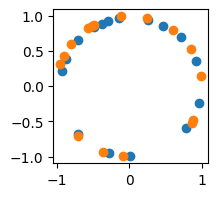

 88%|█████████████████████████████████████████████████████████████████████▌         | 4405/5000 [03:05<00:27, 21.98it/s]

Epoch: 4401, Loss: 0.11725321412086487
Epoch: 4402, Loss: 0.12570948898792267
Epoch: 4403, Loss: 0.13017785549163818
Epoch: 4404, Loss: 0.13079065084457397
Epoch: 4405, Loss: 0.11963312327861786
Epoch: 4406, Loss: 0.13600504398345947


 88%|█████████████████████████████████████████████████████████████████████▋         | 4411/5000 [03:05<00:25, 23.49it/s]

Epoch: 4407, Loss: 0.11408908665180206
Epoch: 4408, Loss: 0.12480528652667999
Epoch: 4409, Loss: 0.13134630024433136
Epoch: 4410, Loss: 0.11322803050279617
Epoch: 4411, Loss: 0.11729305982589722


 88%|█████████████████████████████████████████████████████████████████████▊         | 4417/5000 [03:05<00:24, 23.38it/s]

Epoch: 4412, Loss: 0.1108868196606636
Epoch: 4413, Loss: 0.12065485119819641
Epoch: 4414, Loss: 0.19363901019096375
Epoch: 4415, Loss: 0.1279512643814087
Epoch: 4416, Loss: 0.12183872610330582
Epoch: 4417, Loss: 0.1285724639892578


 88%|█████████████████████████████████████████████████████████████████████▉         | 4423/5000 [03:05<00:24, 24.01it/s]

Epoch: 4418, Loss: 0.12022040784358978
Epoch: 4419, Loss: 0.13673029839992523
Epoch: 4420, Loss: 0.12200523167848587
Epoch: 4421, Loss: 0.13557644188404083
Epoch: 4422, Loss: 0.1212165355682373
Epoch: 4423, Loss: 0.12609073519706726


 89%|█████████████████████████████████████████████████████████████████████▉         | 4429/5000 [03:06<00:23, 24.18it/s]

Epoch: 4424, Loss: 0.13719268143177032
Epoch: 4425, Loss: 0.13452908396720886
Epoch: 4426, Loss: 0.13674768805503845
Epoch: 4427, Loss: 0.14013409614562988
Epoch: 4428, Loss: 0.11531256139278412


 89%|██████████████████████████████████████████████████████████████████████         | 4432/5000 [03:06<00:24, 22.97it/s]

Epoch: 4429, Loss: 0.11384269595146179
Epoch: 4430, Loss: 0.11726981401443481
Epoch: 4431, Loss: 0.11146385967731476
Epoch: 4432, Loss: 0.1108190193772316
Epoch: 4433, Loss: 0.12152579426765442


 89%|██████████████████████████████████████████████████████████████████████         | 4438/5000 [03:06<00:23, 23.83it/s]

Epoch: 4434, Loss: 0.11283537745475769
Epoch: 4435, Loss: 0.11792582273483276
Epoch: 4436, Loss: 0.15487153828144073
Epoch: 4437, Loss: 0.11741846054792404
Epoch: 4438, Loss: 0.11741513758897781


 89%|██████████████████████████████████████████████████████████████████████▏        | 4444/5000 [03:06<00:22, 24.57it/s]

Epoch: 4439, Loss: 0.14405371248722076
Epoch: 4440, Loss: 0.12241211533546448
Epoch: 4441, Loss: 0.12563960254192352
Epoch: 4442, Loss: 0.12546809017658234
Epoch: 4443, Loss: 0.11260886490345001


 89%|██████████████████████████████████████████████████████████████████████▎        | 4450/5000 [03:06<00:22, 24.75it/s]

Epoch: 4444, Loss: 0.13605272769927979
Epoch: 4445, Loss: 0.11837510764598846
Epoch: 4446, Loss: 0.14349691569805145
Epoch: 4447, Loss: 0.1105867475271225
Epoch: 4448, Loss: 0.11490114778280258
Epoch: 4449, Loss: 0.12552200257778168


 89%|██████████████████████████████████████████████████████████████████████▍        | 4456/5000 [03:07<00:21, 25.02it/s]

Epoch: 4450, Loss: 0.1263490915298462
Epoch: 4451, Loss: 0.11320432275533676
Epoch: 4452, Loss: 0.11789503693580627
Epoch: 4453, Loss: 0.11602230370044708
Epoch: 4454, Loss: 0.12293105572462082
Epoch: 4455, Loss: 0.11576122790575027


 89%|██████████████████████████████████████████████████████████████████████▍        | 4462/5000 [03:07<00:21, 25.26it/s]

Epoch: 4456, Loss: 0.12316219508647919
Epoch: 4457, Loss: 0.12458448112010956
Epoch: 4458, Loss: 0.1280588060617447
Epoch: 4459, Loss: 0.11958345770835876
Epoch: 4460, Loss: 0.1312020719051361
Epoch: 4461, Loss: 0.12786497175693512


 89%|██████████████████████████████████████████████████████████████████████▌        | 4468/5000 [03:07<00:21, 25.09it/s]

Epoch: 4462, Loss: 0.12405382096767426
Epoch: 4463, Loss: 0.13265126943588257
Epoch: 4464, Loss: 0.11750774085521698
Epoch: 4465, Loss: 0.1308625042438507
Epoch: 4466, Loss: 0.12853309512138367
Epoch: 4467, Loss: 0.12240371108055115


 89%|██████████████████████████████████████████████████████████████████████▋        | 4474/5000 [03:07<00:21, 24.91it/s]

Epoch: 4468, Loss: 0.12116556614637375
Epoch: 4469, Loss: 0.14126984775066376
Epoch: 4470, Loss: 0.1426582783460617
Epoch: 4471, Loss: 0.11925869435071945
Epoch: 4472, Loss: 0.13507086038589478
Epoch: 4473, Loss: 0.10399065166711807


 90%|██████████████████████████████████████████████████████████████████████▋        | 4477/5000 [03:08<00:21, 24.18it/s]

Epoch: 4474, Loss: 0.11818382143974304
Epoch: 4475, Loss: 0.11315334588289261
Epoch: 4476, Loss: 0.12129151076078415
Epoch: 4477, Loss: 0.1621316820383072
Epoch: 4478, Loss: 0.13458438217639923


 90%|██████████████████████████████████████████████████████████████████████▊        | 4483/5000 [03:08<00:20, 24.86it/s]

Epoch: 4479, Loss: 0.12648792564868927
Epoch: 4480, Loss: 0.13516615331172943
Epoch: 4481, Loss: 0.12509766221046448
Epoch: 4482, Loss: 0.12381705641746521
Epoch: 4483, Loss: 0.12751561403274536
Epoch: 4484, Loss: 0.12605346739292145


 90%|██████████████████████████████████████████████████████████████████████▉        | 4489/5000 [03:08<00:20, 25.08it/s]

Epoch: 4485, Loss: 0.11874324083328247
Epoch: 4486, Loss: 0.12318886071443558
Epoch: 4487, Loss: 0.13193348050117493
Epoch: 4488, Loss: 0.13030385971069336
Epoch: 4489, Loss: 0.1239488422870636
Epoch: 4490, Loss: 0.12570419907569885


 90%|███████████████████████████████████████████████████████████████████████        | 4495/5000 [03:08<00:20, 24.76it/s]

Epoch: 4491, Loss: 0.11851920932531357
Epoch: 4492, Loss: 0.13253764808177948
Epoch: 4493, Loss: 0.13157393038272858
Epoch: 4494, Loss: 0.13151168823242188
Epoch: 4495, Loss: 0.14533838629722595


 90%|███████████████████████████████████████████████████████████████████████        | 4498/5000 [03:08<00:20, 24.50it/s]

Epoch: 4496, Loss: 0.12083978205919266
Epoch: 4497, Loss: 0.11756262183189392
Epoch: 4498, Loss: 0.1087009385228157
Epoch: 4499, Loss: 0.11991260945796967


 90%|███████████████████████████████████████████████████████████████████████▏       | 4504/5000 [03:09<00:22, 21.79it/s]

Epoch: 4500, Loss: 0.12417296320199966
Epoch: 4501, Loss: 0.12326018512248993
Epoch: 4502, Loss: 0.13835179805755615
Epoch: 4503, Loss: 0.12072888761758804
Epoch: 4504, Loss: 0.1062861904501915
Epoch: 4505, Loss: 0.12151546031236649


 90%|███████████████████████████████████████████████████████████████████████▎       | 4510/5000 [03:09<00:20, 23.52it/s]

Epoch: 4506, Loss: 0.11052826046943665
Epoch: 4507, Loss: 0.1525353491306305
Epoch: 4508, Loss: 0.11971829831600189
Epoch: 4509, Loss: 0.11681027710437775
Epoch: 4510, Loss: 0.11300086230039597
Epoch: 4511, Loss: 0.11447910964488983


 90%|███████████████████████████████████████████████████████████████████████▎       | 4516/5000 [03:09<00:20, 23.99it/s]

Epoch: 4512, Loss: 0.13291144371032715
Epoch: 4513, Loss: 0.11991772800683975
Epoch: 4514, Loss: 0.11542317271232605
Epoch: 4515, Loss: 0.121784508228302
Epoch: 4516, Loss: 0.13673172891139984


 90%|███████████████████████████████████████████████████████████████████████▍       | 4522/5000 [03:09<00:19, 24.41it/s]

Epoch: 4517, Loss: 0.15109601616859436
Epoch: 4518, Loss: 0.11285233497619629
Epoch: 4519, Loss: 0.13959848880767822
Epoch: 4520, Loss: 0.1376514732837677
Epoch: 4521, Loss: 0.11327242106199265


 91%|███████████████████████████████████████████████████████████████████████▌       | 4528/5000 [03:10<00:19, 24.61it/s]

Epoch: 4522, Loss: 0.11252284795045853
Epoch: 4523, Loss: 0.1234271228313446
Epoch: 4524, Loss: 0.13676631450653076
Epoch: 4525, Loss: 0.12965284287929535
Epoch: 4526, Loss: 0.11478079855442047
Epoch: 4527, Loss: 0.13840894401073456


 91%|███████████████████████████████████████████████████████████████████████▋       | 4534/5000 [03:10<00:18, 24.79it/s]

Epoch: 4528, Loss: 0.1224181205034256
Epoch: 4529, Loss: 0.14260584115982056
Epoch: 4530, Loss: 0.1429312527179718
Epoch: 4531, Loss: 0.14591139554977417
Epoch: 4532, Loss: 0.1287836879491806
Epoch: 4533, Loss: 0.10658426582813263


 91%|███████████████████████████████████████████████████████████████████████▋       | 4540/5000 [03:10<00:18, 24.76it/s]

Epoch: 4534, Loss: 0.1487302929162979
Epoch: 4535, Loss: 0.12218569964170456
Epoch: 4536, Loss: 0.10892517119646072
Epoch: 4537, Loss: 0.1173768937587738
Epoch: 4538, Loss: 0.12757721543312073
Epoch: 4539, Loss: 0.11376729607582092


 91%|███████████████████████████████████████████████████████████████████████▊       | 4546/5000 [03:10<00:18, 24.95it/s]

Epoch: 4540, Loss: 0.1313953995704651
Epoch: 4541, Loss: 0.1215582937002182
Epoch: 4542, Loss: 0.12245538830757141
Epoch: 4543, Loss: 0.12401509284973145
Epoch: 4544, Loss: 0.13063114881515503
Epoch: 4545, Loss: 0.11727950721979141


 91%|███████████████████████████████████████████████████████████████████████▉       | 4552/5000 [03:11<00:17, 25.04it/s]

Epoch: 4546, Loss: 0.13252301514148712
Epoch: 4547, Loss: 0.1283346712589264
Epoch: 4548, Loss: 0.11888185888528824
Epoch: 4549, Loss: 0.1289408802986145
Epoch: 4550, Loss: 0.11766189336776733
Epoch: 4551, Loss: 0.12824586033821106


 91%|███████████████████████████████████████████████████████████████████████▉       | 4555/5000 [03:11<00:17, 24.86it/s]

Epoch: 4552, Loss: 0.12383094429969788
Epoch: 4553, Loss: 0.11079084128141403
Epoch: 4554, Loss: 0.12154040485620499
Epoch: 4555, Loss: 0.10879519581794739
Epoch: 4556, Loss: 0.13227534294128418


 91%|████████████████████████████████████████████████████████████████████████       | 4561/5000 [03:11<00:17, 24.53it/s]

Epoch: 4557, Loss: 0.13304778933525085
Epoch: 4558, Loss: 0.12582534551620483
Epoch: 4559, Loss: 0.12906621396541595
Epoch: 4560, Loss: 0.12062376737594604
Epoch: 4561, Loss: 0.11238107830286026


 91%|████████████████████████████████████████████████████████████████████████▏      | 4567/5000 [03:11<00:17, 24.43it/s]

Epoch: 4562, Loss: 0.12240411341190338
Epoch: 4563, Loss: 0.13965606689453125
Epoch: 4564, Loss: 0.1268460750579834
Epoch: 4565, Loss: 0.1386931836605072
Epoch: 4566, Loss: 0.11450251191854477


 91%|████████████████████████████████████████████████████████████████████████▎      | 4573/5000 [03:11<00:17, 24.89it/s]

Epoch: 4567, Loss: 0.11794628947973251
Epoch: 4568, Loss: 0.12658624351024628
Epoch: 4569, Loss: 0.11768785119056702
Epoch: 4570, Loss: 0.12703025341033936
Epoch: 4571, Loss: 0.13356417417526245
Epoch: 4572, Loss: 0.13906633853912354


 92%|████████████████████████████████████████████████████████████████████████▎      | 4579/5000 [03:12<00:16, 25.61it/s]

Epoch: 4573, Loss: 0.12331263720989227
Epoch: 4574, Loss: 0.11642127484083176
Epoch: 4575, Loss: 0.1167876347899437
Epoch: 4576, Loss: 0.11565878987312317
Epoch: 4577, Loss: 0.1306118667125702
Epoch: 4578, Loss: 0.12183106690645218


 92%|████████████████████████████████████████████████████████████████████████▍      | 4582/5000 [03:12<00:17, 24.48it/s]

Epoch: 4579, Loss: 0.10807435214519501
Epoch: 4580, Loss: 0.11767767369747162
Epoch: 4581, Loss: 0.12736481428146362
Epoch: 4582, Loss: 0.1442381739616394
Epoch: 4583, Loss: 0.10914161801338196


 92%|████████████████████████████████████████████████████████████████████████▍      | 4588/5000 [03:12<00:16, 24.68it/s]

Epoch: 4584, Loss: 0.11911630630493164
Epoch: 4585, Loss: 0.1325702965259552
Epoch: 4586, Loss: 0.1350841224193573
Epoch: 4587, Loss: 0.12244702130556107
Epoch: 4588, Loss: 0.12207624316215515


 92%|████████████████████████████████████████████████████████████████████████▌      | 4594/5000 [03:12<00:16, 24.70it/s]

Epoch: 4589, Loss: 0.11892785131931305
Epoch: 4590, Loss: 0.11636000871658325
Epoch: 4591, Loss: 0.1129964143037796
Epoch: 4592, Loss: 0.13722902536392212
Epoch: 4593, Loss: 0.15291908383369446


 92%|████████████████████████████████████████████████████████████████████████▋      | 4600/5000 [03:13<00:16, 24.93it/s]

Epoch: 4594, Loss: 0.1471615433692932
Epoch: 4595, Loss: 0.11005841195583344
Epoch: 4596, Loss: 0.12538431584835052
Epoch: 4597, Loss: 0.12448789179325104
Epoch: 4598, Loss: 0.14478951692581177
Epoch: 4599, Loss: 0.11651541292667389
Epoch: 4600, Loss: 0.12439333647489548


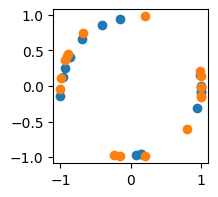

 92%|████████████████████████████████████████████████████████████████████████▋      | 4603/5000 [03:13<00:19, 20.46it/s]

Epoch: 4601, Loss: 0.11458989232778549
Epoch: 4602, Loss: 0.13097310066223145


 92%|████████████████████████████████████████████████████████████████████████▊      | 4606/5000 [03:13<00:18, 21.44it/s]

Epoch: 4603, Loss: 0.12706483900547028
Epoch: 4604, Loss: 0.12913905084133148
Epoch: 4605, Loss: 0.13672563433647156


 92%|████████████████████████████████████████████████████████████████████████▊      | 4609/5000 [03:13<00:17, 22.39it/s]

Epoch: 4606, Loss: 0.12266674637794495
Epoch: 4607, Loss: 0.1128065213561058
Epoch: 4608, Loss: 0.12113551795482635
Epoch: 4609, Loss: 0.12245089560747147
Epoch: 4610, Loss: 0.15628907084465027


 92%|████████████████████████████████████████████████████████████████████████▉      | 4615/5000 [03:13<00:16, 23.69it/s]

Epoch: 4611, Loss: 0.11958548426628113
Epoch: 4612, Loss: 0.1137147843837738
Epoch: 4613, Loss: 0.11846400052309036
Epoch: 4614, Loss: 0.10689082741737366
Epoch: 4615, Loss: 0.11183260381221771
Epoch: 4616, Loss: 0.14707961678504944


 92%|█████████████████████████████████████████████████████████████████████████      | 4621/5000 [03:13<00:15, 24.43it/s]

Epoch: 4617, Loss: 0.1232917308807373
Epoch: 4618, Loss: 0.13310466706752777
Epoch: 4619, Loss: 0.12662506103515625
Epoch: 4620, Loss: 0.13527369499206543
Epoch: 4621, Loss: 0.1257249116897583
Epoch: 4622, Loss: 0.1069699227809906


 93%|█████████████████████████████████████████████████████████████████████████      | 4627/5000 [03:14<00:15, 24.60it/s]

Epoch: 4623, Loss: 0.11392170935869217
Epoch: 4624, Loss: 0.11985684931278229
Epoch: 4625, Loss: 0.13252219557762146
Epoch: 4626, Loss: 0.11891072243452072
Epoch: 4627, Loss: 0.13088402152061462


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4630/5000 [03:14<00:15, 24.09it/s]

Epoch: 4628, Loss: 0.12264823913574219
Epoch: 4629, Loss: 0.125817209482193
Epoch: 4630, Loss: 0.12250038981437683
Epoch: 4631, Loss: 0.12100113928318024


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4633/5000 [03:14<00:15, 24.29it/s]

Epoch: 4632, Loss: 0.15195119380950928


 93%|█████████████████████████████████████████████████████████████████████████▏     | 4636/5000 [03:14<00:15, 23.52it/s]

Epoch: 4633, Loss: 0.11104314029216766
Epoch: 4634, Loss: 0.11168510466814041
Epoch: 4635, Loss: 0.1307859569787979
Epoch: 4636, Loss: 0.11860573291778564
Epoch: 4637, Loss: 0.12106375396251678


 93%|█████████████████████████████████████████████████████████████████████████▎     | 4642/5000 [03:14<00:15, 23.55it/s]

Epoch: 4638, Loss: 0.13099241256713867
Epoch: 4639, Loss: 0.11607819050550461
Epoch: 4640, Loss: 0.10305963456630707
Epoch: 4641, Loss: 0.10691382735967636
Epoch: 4642, Loss: 0.14331695437431335


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4645/5000 [03:15<00:15, 23.66it/s]

Epoch: 4643, Loss: 0.12804952263832092
Epoch: 4644, Loss: 0.12196247279644012
Epoch: 4645, Loss: 0.12622147798538208
Epoch: 4646, Loss: 0.1236715316772461


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4648/5000 [03:15<00:14, 24.02it/s]

Epoch: 4647, Loss: 0.10741300135850906


 93%|█████████████████████████████████████████████████████████████████████████▍     | 4651/5000 [03:15<00:14, 23.49it/s]

Epoch: 4648, Loss: 0.11734628677368164
Epoch: 4649, Loss: 0.12949565052986145
Epoch: 4650, Loss: 0.11123834550380707
Epoch: 4651, Loss: 0.1260840892791748
Epoch: 4652, Loss: 0.1349804848432541


 93%|█████████████████████████████████████████████████████████████████████████▌     | 4657/5000 [03:15<00:14, 23.25it/s]

Epoch: 4653, Loss: 0.12361977249383926
Epoch: 4654, Loss: 0.11290334910154343
Epoch: 4655, Loss: 0.11214621365070343
Epoch: 4656, Loss: 0.11515350639820099
Epoch: 4657, Loss: 0.14361467957496643


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4660/5000 [03:15<00:14, 22.74it/s]

Epoch: 4658, Loss: 0.1295018494129181
Epoch: 4659, Loss: 0.12297835201025009
Epoch: 4660, Loss: 0.11585432291030884
Epoch: 4661, Loss: 0.12569883465766907


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4663/5000 [03:15<00:14, 23.06it/s]

Epoch: 4662, Loss: 0.11561156064271927


 93%|█████████████████████████████████████████████████████████████████████████▋     | 4666/5000 [03:15<00:14, 23.39it/s]

Epoch: 4663, Loss: 0.11343848705291748
Epoch: 4664, Loss: 0.126449316740036
Epoch: 4665, Loss: 0.12054025381803513
Epoch: 4666, Loss: 0.12017928808927536
Epoch: 4667, Loss: 0.12276682257652283


 93%|█████████████████████████████████████████████████████████████████████████▊     | 4672/5000 [03:16<00:14, 22.37it/s]

Epoch: 4668, Loss: 0.12056005001068115
Epoch: 4669, Loss: 0.11948755383491516
Epoch: 4670, Loss: 0.12250581383705139
Epoch: 4671, Loss: 0.11419695615768433
Epoch: 4672, Loss: 0.1252172440290451


 94%|█████████████████████████████████████████████████████████████████████████▊     | 4675/5000 [03:16<00:14, 22.33it/s]

Epoch: 4673, Loss: 0.11455287039279938
Epoch: 4674, Loss: 0.11434052884578705
Epoch: 4675, Loss: 0.13817080855369568
Epoch: 4676, Loss: 0.1096816137433052


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4678/5000 [03:16<00:13, 23.03it/s]

Epoch: 4677, Loss: 0.11355718225240707


 94%|█████████████████████████████████████████████████████████████████████████▉     | 4681/5000 [03:16<00:13, 22.93it/s]

Epoch: 4678, Loss: 0.11737725138664246
Epoch: 4679, Loss: 0.10910621285438538
Epoch: 4680, Loss: 0.1234990805387497
Epoch: 4681, Loss: 0.12118113785982132
Epoch: 4682, Loss: 0.1141284853219986


 94%|██████████████████████████████████████████████████████████████████████████     | 4687/5000 [03:16<00:13, 23.59it/s]

Epoch: 4683, Loss: 0.11921320855617523
Epoch: 4684, Loss: 0.12410619854927063
Epoch: 4685, Loss: 0.12056542932987213
Epoch: 4686, Loss: 0.13283750414848328
Epoch: 4687, Loss: 0.1316116452217102
Epoch: 4688, Loss: 0.11166249215602875


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4692/5000 [03:17<00:22, 13.47it/s]

Epoch: 4689, Loss: 0.10393933951854706
Epoch: 4690, Loss: 0.12240179628133774
Epoch: 4691, Loss: 0.1303994059562683
Epoch: 4692, Loss: 0.12628793716430664
Epoch: 4693, Loss: 0.14563590288162231


 94%|██████████████████████████████████████████████████████████████████████████▏    | 4698/5000 [03:17<00:17, 17.67it/s]

Epoch: 4694, Loss: 0.11734560877084732
Epoch: 4695, Loss: 0.14837783575057983
Epoch: 4696, Loss: 0.11929977685213089
Epoch: 4697, Loss: 0.12991349399089813
Epoch: 4698, Loss: 0.12094675749540329


 94%|██████████████████████████████████████████████████████████████████████████▎    | 4704/5000 [03:17<00:14, 20.26it/s]

Epoch: 4699, Loss: 0.11362169682979584
Epoch: 4700, Loss: 0.12157782912254333
Epoch: 4701, Loss: 0.11882355064153671
Epoch: 4702, Loss: 0.13472361862659454
Epoch: 4703, Loss: 0.14140823483467102


 94%|██████████████████████████████████████████████████████████████████████████▍    | 4710/5000 [03:18<00:12, 22.51it/s]

Epoch: 4704, Loss: 0.10676596313714981
Epoch: 4705, Loss: 0.10964638739824295
Epoch: 4706, Loss: 0.13395655155181885
Epoch: 4707, Loss: 0.11951880156993866
Epoch: 4708, Loss: 0.11874893307685852
Epoch: 4709, Loss: 0.1354757845401764


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4716/5000 [03:18<00:12, 23.51it/s]

Epoch: 4710, Loss: 0.12728802859783173
Epoch: 4711, Loss: 0.12143590301275253
Epoch: 4712, Loss: 0.11365246772766113
Epoch: 4713, Loss: 0.11614502221345901
Epoch: 4714, Loss: 0.1365327090024948
Epoch: 4715, Loss: 0.11181905120611191


 94%|██████████████████████████████████████████████████████████████████████████▌    | 4722/5000 [03:18<00:11, 23.71it/s]

Epoch: 4716, Loss: 0.1549043506383896
Epoch: 4717, Loss: 0.12156286090612411
Epoch: 4718, Loss: 0.12186571955680847
Epoch: 4719, Loss: 0.11510729044675827
Epoch: 4720, Loss: 0.155614972114563
Epoch: 4721, Loss: 0.11675984412431717


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4728/5000 [03:18<00:11, 24.32it/s]

Epoch: 4722, Loss: 0.11131245642900467
Epoch: 4723, Loss: 0.12371845543384552
Epoch: 4724, Loss: 0.13015878200531006
Epoch: 4725, Loss: 0.10930432379245758
Epoch: 4726, Loss: 0.11925317347049713
Epoch: 4727, Loss: 0.11796228587627411


 95%|██████████████████████████████████████████████████████████████████████████▋    | 4731/5000 [03:19<00:11, 23.65it/s]

Epoch: 4728, Loss: 0.13307861983776093
Epoch: 4729, Loss: 0.11854326725006104
Epoch: 4730, Loss: 0.11047385632991791
Epoch: 4731, Loss: 0.12551651895046234
Epoch: 4732, Loss: 0.12132769078016281


 95%|██████████████████████████████████████████████████████████████████████████▊    | 4737/5000 [03:19<00:10, 24.02it/s]

Epoch: 4733, Loss: 0.12886765599250793
Epoch: 4734, Loss: 0.127224400639534
Epoch: 4735, Loss: 0.11196160316467285
Epoch: 4736, Loss: 0.1318512260913849
Epoch: 4737, Loss: 0.11397431790828705


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4743/5000 [03:19<00:10, 24.19it/s]

Epoch: 4738, Loss: 0.13990075886249542
Epoch: 4739, Loss: 0.13533863425254822
Epoch: 4740, Loss: 0.1085701510310173
Epoch: 4741, Loss: 0.11866535991430283
Epoch: 4742, Loss: 0.1170148104429245


 95%|██████████████████████████████████████████████████████████████████████████▉    | 4746/5000 [03:19<00:10, 24.05it/s]

Epoch: 4743, Loss: 0.118338443338871
Epoch: 4744, Loss: 0.1291334331035614
Epoch: 4745, Loss: 0.1241893395781517
Epoch: 4746, Loss: 0.11998680979013443
Epoch: 4747, Loss: 0.14444664120674133


 95%|███████████████████████████████████████████████████████████████████████████    | 4752/5000 [03:19<00:10, 24.24it/s]

Epoch: 4748, Loss: 0.12685976922512054
Epoch: 4749, Loss: 0.12452518194913864
Epoch: 4750, Loss: 0.11402422189712524
Epoch: 4751, Loss: 0.11399921029806137
Epoch: 4752, Loss: 0.11386258155107498


 95%|███████████████████████████████████████████████████████████████████████████▏   | 4758/5000 [03:20<00:09, 24.88it/s]

Epoch: 4753, Loss: 0.12459392100572586
Epoch: 4754, Loss: 0.11792390048503876
Epoch: 4755, Loss: 0.11470440030097961
Epoch: 4756, Loss: 0.11868497729301453
Epoch: 4757, Loss: 0.1260291188955307
Epoch: 4758, Loss: 0.16143471002578735


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4764/5000 [03:20<00:09, 24.33it/s]

Epoch: 4759, Loss: 0.11297444999217987
Epoch: 4760, Loss: 0.12720760703086853
Epoch: 4761, Loss: 0.12698082625865936
Epoch: 4762, Loss: 0.11880794912576675
Epoch: 4763, Loss: 0.13228251039981842


 95%|███████████████████████████████████████████████████████████████████████████▎   | 4767/5000 [03:20<00:10, 22.02it/s]

Epoch: 4764, Loss: 0.1283455193042755
Epoch: 4765, Loss: 0.12905623018741608
Epoch: 4766, Loss: 0.13238556683063507
Epoch: 4767, Loss: 0.1282258927822113


 95%|███████████████████████████████████████████████████████████████████████████▍   | 4773/5000 [03:20<00:09, 23.04it/s]

Epoch: 4768, Loss: 0.10659585893154144
Epoch: 4769, Loss: 0.11889877915382385
Epoch: 4770, Loss: 0.12143277376890182
Epoch: 4771, Loss: 0.12558738887310028
Epoch: 4772, Loss: 0.13067391514778137
Epoch: 4773, Loss: 0.12918983399868011


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4779/5000 [03:21<00:09, 24.07it/s]

Epoch: 4774, Loss: 0.13702577352523804
Epoch: 4775, Loss: 0.16487422585487366
Epoch: 4776, Loss: 0.13000144064426422
Epoch: 4777, Loss: 0.11861403286457062
Epoch: 4778, Loss: 0.1283036172389984


 96%|███████████████████████████████████████████████████████████████████████████▌   | 4785/5000 [03:21<00:08, 24.88it/s]

Epoch: 4779, Loss: 0.1327001005411148
Epoch: 4780, Loss: 0.13322652876377106
Epoch: 4781, Loss: 0.13456742465496063
Epoch: 4782, Loss: 0.10892979800701141
Epoch: 4783, Loss: 0.10843843966722488
Epoch: 4784, Loss: 0.12492930889129639


 96%|███████████████████████████████████████████████████████████████████████████▋   | 4791/5000 [03:21<00:08, 24.96it/s]

Epoch: 4785, Loss: 0.10821344703435898
Epoch: 4786, Loss: 0.13320863246917725
Epoch: 4787, Loss: 0.1140802651643753
Epoch: 4788, Loss: 0.12294444441795349
Epoch: 4789, Loss: 0.12390897423028946
Epoch: 4790, Loss: 0.11946655809879303


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4797/5000 [03:21<00:08, 24.99it/s]

Epoch: 4791, Loss: 0.11918029189109802
Epoch: 4792, Loss: 0.12391236424446106
Epoch: 4793, Loss: 0.11167491972446442
Epoch: 4794, Loss: 0.12194418907165527
Epoch: 4795, Loss: 0.13562500476837158
Epoch: 4796, Loss: 0.10624352097511292


 96%|███████████████████████████████████████████████████████████████████████████▊   | 4800/5000 [03:21<00:08, 24.39it/s]

Epoch: 4797, Loss: 0.13052889704704285
Epoch: 4798, Loss: 0.13056477904319763
Epoch: 4799, Loss: 0.1299293041229248
Epoch: 4800, Loss: 0.11942216008901596


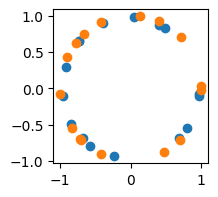

 96%|███████████████████████████████████████████████████████████████████████████▉   | 4806/5000 [03:22<00:08, 21.78it/s]

Epoch: 4801, Loss: 0.11266475170850754
Epoch: 4802, Loss: 0.1262199431657791
Epoch: 4803, Loss: 0.13051849603652954
Epoch: 4804, Loss: 0.12880074977874756
Epoch: 4805, Loss: 0.1261950582265854
Epoch: 4806, Loss: 0.1158648356795311


 96%|████████████████████████████████████████████████████████████████████████████   | 4812/5000 [03:22<00:08, 23.39it/s]

Epoch: 4807, Loss: 0.1567998230457306
Epoch: 4808, Loss: 0.11821316182613373
Epoch: 4809, Loss: 0.12592056393623352
Epoch: 4810, Loss: 0.11289684474468231
Epoch: 4811, Loss: 0.12470836937427521


 96%|████████████████████████████████████████████████████████████████████████████   | 4818/5000 [03:22<00:07, 23.80it/s]

Epoch: 4812, Loss: 0.11757499724626541
Epoch: 4813, Loss: 0.12007924914360046
Epoch: 4814, Loss: 0.1083497405052185
Epoch: 4815, Loss: 0.11112447828054428
Epoch: 4816, Loss: 0.11840155720710754
Epoch: 4817, Loss: 0.12008831650018692


 96%|████████████████████████████████████████████████████████████████████████████▏  | 4821/5000 [03:22<00:07, 23.29it/s]

Epoch: 4818, Loss: 0.12369628995656967
Epoch: 4819, Loss: 0.1130654513835907
Epoch: 4820, Loss: 0.11799442023038864
Epoch: 4821, Loss: 0.11534932255744934
Epoch: 4822, Loss: 0.14341187477111816
Epoch: 4823, Loss: 0.11769513785839081


 97%|████████████████████████████████████████████████████████████████████████████▎  | 4830/5000 [03:23<00:06, 24.61it/s]

Epoch: 4824, Loss: 0.1296030431985855
Epoch: 4825, Loss: 0.1322866529226303
Epoch: 4826, Loss: 0.13606885075569153
Epoch: 4827, Loss: 0.12695342302322388
Epoch: 4828, Loss: 0.11636889725923538
Epoch: 4829, Loss: 0.11462219804525375


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4836/5000 [03:23<00:06, 24.65it/s]

Epoch: 4830, Loss: 0.11128978431224823
Epoch: 4831, Loss: 0.14806827902793884
Epoch: 4832, Loss: 0.11081460863351822
Epoch: 4833, Loss: 0.13671988248825073
Epoch: 4834, Loss: 0.1301751732826233
Epoch: 4835, Loss: 0.11835375428199768


 97%|████████████████████████████████████████████████████████████████████████████▍  | 4839/5000 [03:23<00:06, 24.20it/s]

Epoch: 4836, Loss: 0.11431533098220825
Epoch: 4837, Loss: 0.12714378535747528
Epoch: 4838, Loss: 0.13210397958755493
Epoch: 4839, Loss: 0.14000266790390015
Epoch: 4840, Loss: 0.11678610742092133


 97%|████████████████████████████████████████████████████████████████████████████▌  | 4845/5000 [03:23<00:06, 24.08it/s]

Epoch: 4841, Loss: 0.11125722527503967
Epoch: 4842, Loss: 0.11976645886898041
Epoch: 4843, Loss: 0.11083190888166428
Epoch: 4844, Loss: 0.11933916062116623
Epoch: 4845, Loss: 0.11614902317523956


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4851/5000 [03:24<00:06, 24.38it/s]

Epoch: 4846, Loss: 0.11717502027750015
Epoch: 4847, Loss: 0.12342213094234467
Epoch: 4848, Loss: 0.11712311208248138
Epoch: 4849, Loss: 0.13089945912361145
Epoch: 4850, Loss: 0.11235928535461426


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4854/5000 [03:24<00:06, 23.26it/s]

Epoch: 4851, Loss: 0.13972434401512146
Epoch: 4852, Loss: 0.11551229655742645
Epoch: 4853, Loss: 0.12059444189071655
Epoch: 4854, Loss: 0.12445850670337677


 97%|████████████████████████████████████████████████████████████████████████████▋  | 4857/5000 [03:24<00:07, 18.45it/s]

Epoch: 4855, Loss: 0.17340482771396637
Epoch: 4856, Loss: 0.11009709537029266


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4860/5000 [03:24<00:11, 12.71it/s]

Epoch: 4857, Loss: 0.13300785422325134
Epoch: 4858, Loss: 0.1233392208814621
Epoch: 4859, Loss: 0.1359548717737198
Epoch: 4860, Loss: 0.13901779055595398


 97%|████████████████████████████████████████████████████████████████████████████▊  | 4864/5000 [03:25<00:11, 12.21it/s]

Epoch: 4861, Loss: 0.11778668314218521
Epoch: 4862, Loss: 0.12963257730007172
Epoch: 4863, Loss: 0.13555733859539032
Epoch: 4864, Loss: 0.14628665149211884


 97%|████████████████████████████████████████████████████████████████████████████▉  | 4869/5000 [03:25<00:08, 15.34it/s]

Epoch: 4865, Loss: 0.13571283221244812
Epoch: 4866, Loss: 0.12450236082077026
Epoch: 4867, Loss: 0.12430868297815323
Epoch: 4868, Loss: 0.11842896044254303
Epoch: 4869, Loss: 0.11489186435937881


 98%|█████████████████████████████████████████████████████████████████████████████  | 4875/5000 [03:25<00:06, 19.28it/s]

Epoch: 4870, Loss: 0.13470648229122162
Epoch: 4871, Loss: 0.12564349174499512
Epoch: 4872, Loss: 0.12385208159685135
Epoch: 4873, Loss: 0.11380253732204437
Epoch: 4874, Loss: 0.1049129068851471


 98%|█████████████████████████████████████████████████████████████████████████████  | 4878/5000 [03:25<00:05, 20.46it/s]

Epoch: 4875, Loss: 0.10753978788852692
Epoch: 4876, Loss: 0.12140069156885147
Epoch: 4877, Loss: 0.1224999651312828
Epoch: 4878, Loss: 0.1078936755657196
Epoch: 4879, Loss: 0.11282151937484741


 98%|█████████████████████████████████████████████████████████████████████████████▏ | 4884/5000 [03:26<00:05, 22.36it/s]

Epoch: 4880, Loss: 0.13997387886047363
Epoch: 4881, Loss: 0.1237264946103096
Epoch: 4882, Loss: 0.12088890373706818
Epoch: 4883, Loss: 0.1208975613117218
Epoch: 4884, Loss: 0.13034385442733765
Epoch: 4885, Loss: 0.12423881143331528


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4890/5000 [03:26<00:04, 23.10it/s]

Epoch: 4886, Loss: 0.10637088119983673
Epoch: 4887, Loss: 0.11964891850948334
Epoch: 4888, Loss: 0.13423210382461548
Epoch: 4889, Loss: 0.1280042827129364
Epoch: 4890, Loss: 0.11336411535739899


 98%|█████████████████████████████████████████████████████████████████████████████▎ | 4896/5000 [03:26<00:04, 23.91it/s]

Epoch: 4891, Loss: 0.12108083814382553
Epoch: 4892, Loss: 0.12342666834592819
Epoch: 4893, Loss: 0.1277451068162918
Epoch: 4894, Loss: 0.12678533792495728
Epoch: 4895, Loss: 0.11936873197555542


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4899/5000 [03:26<00:04, 23.64it/s]

Epoch: 4896, Loss: 0.1299522966146469
Epoch: 4897, Loss: 0.12754935026168823
Epoch: 4898, Loss: 0.1169339269399643
Epoch: 4899, Loss: 0.13114139437675476
Epoch: 4900, Loss: 0.12617595493793488


 98%|█████████████████████████████████████████████████████████████████████████████▍ | 4905/5000 [03:27<00:03, 24.10it/s]

Epoch: 4901, Loss: 0.12921980023384094
Epoch: 4902, Loss: 0.12176304310560226
Epoch: 4903, Loss: 0.12287798523902893
Epoch: 4904, Loss: 0.11706996709108353
Epoch: 4905, Loss: 0.1292237639427185


 98%|█████████████████████████████████████████████████████████████████████████████▌ | 4911/5000 [03:27<00:03, 23.97it/s]

Epoch: 4906, Loss: 0.12418229877948761
Epoch: 4907, Loss: 0.10982956737279892
Epoch: 4908, Loss: 0.13145151734352112
Epoch: 4909, Loss: 0.15696485340595245
Epoch: 4910, Loss: 0.12274141609668732
Epoch: 4911, Loss: 0.12619808316230774


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4917/5000 [03:27<00:03, 23.86it/s]

Epoch: 4912, Loss: 0.11092260479927063
Epoch: 4913, Loss: 0.12687554955482483
Epoch: 4914, Loss: 0.11732111126184464
Epoch: 4915, Loss: 0.10802619159221649
Epoch: 4916, Loss: 0.11187364161014557


 98%|█████████████████████████████████████████████████████████████████████████████▋ | 4920/5000 [03:27<00:03, 23.69it/s]

Epoch: 4917, Loss: 0.11837618052959442
Epoch: 4918, Loss: 0.13996621966362
Epoch: 4919, Loss: 0.11983273178339005
Epoch: 4920, Loss: 0.10987032949924469
Epoch: 4921, Loss: 0.11652889847755432


 99%|█████████████████████████████████████████████████████████████████████████████▊ | 4926/5000 [03:27<00:03, 23.82it/s]

Epoch: 4922, Loss: 0.12234719097614288
Epoch: 4923, Loss: 0.11721475422382355
Epoch: 4924, Loss: 0.12416475266218185
Epoch: 4925, Loss: 0.12748122215270996
Epoch: 4926, Loss: 0.13146360218524933


 99%|█████████████████████████████████████████████████████████████████████████████▉ | 4932/5000 [03:28<00:02, 23.74it/s]

Epoch: 4927, Loss: 0.12305876612663269
Epoch: 4928, Loss: 0.12447814643383026
Epoch: 4929, Loss: 0.1202927753329277
Epoch: 4930, Loss: 0.11645542830228806
Epoch: 4931, Loss: 0.12587279081344604


 99%|██████████████████████████████████████████████████████████████████████████████ | 4938/5000 [03:28<00:02, 23.89it/s]

Epoch: 4932, Loss: 0.13639864325523376
Epoch: 4933, Loss: 0.1257384568452835
Epoch: 4934, Loss: 0.1307278275489807
Epoch: 4935, Loss: 0.12475353479385376
Epoch: 4936, Loss: 0.11946415901184082
Epoch: 4937, Loss: 0.15503577888011932


 99%|██████████████████████████████████████████████████████████████████████████████ | 4941/5000 [03:28<00:02, 23.30it/s]

Epoch: 4938, Loss: 0.12599092721939087
Epoch: 4939, Loss: 0.10957375168800354
Epoch: 4940, Loss: 0.13005027174949646
Epoch: 4941, Loss: 0.11192668229341507
Epoch: 4942, Loss: 0.13429033756256104


 99%|██████████████████████████████████████████████████████████████████████████████▏| 4947/5000 [03:28<00:02, 24.30it/s]

Epoch: 4943, Loss: 0.12790857255458832
Epoch: 4944, Loss: 0.12717333436012268
Epoch: 4945, Loss: 0.11668547987937927
Epoch: 4946, Loss: 0.13077281415462494
Epoch: 4947, Loss: 0.11531074345111847
Epoch: 4948, Loss: 0.11466726660728455


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4953/5000 [03:29<00:01, 25.13it/s]

Epoch: 4949, Loss: 0.12176592648029327
Epoch: 4950, Loss: 0.136471688747406
Epoch: 4951, Loss: 0.11067493259906769
Epoch: 4952, Loss: 0.11570683121681213
Epoch: 4953, Loss: 0.14634811878204346
Epoch: 4954, Loss: 0.12290135025978088


 99%|██████████████████████████████████████████████████████████████████████████████▎| 4959/5000 [03:29<00:01, 24.87it/s]

Epoch: 4955, Loss: 0.11582513153553009
Epoch: 4956, Loss: 0.11032763868570328
Epoch: 4957, Loss: 0.124691903591156
Epoch: 4958, Loss: 0.1188281923532486
Epoch: 4959, Loss: 0.12132919579744339


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4965/5000 [03:29<00:01, 24.40it/s]

Epoch: 4960, Loss: 0.12385600060224533
Epoch: 4961, Loss: 0.1518070250749588
Epoch: 4962, Loss: 0.11824648082256317
Epoch: 4963, Loss: 0.12291690707206726
Epoch: 4964, Loss: 0.11366145312786102


 99%|██████████████████████████████████████████████████████████████████████████████▍| 4968/5000 [03:29<00:01, 24.25it/s]

Epoch: 4965, Loss: 0.13798806071281433
Epoch: 4966, Loss: 0.11125504970550537
Epoch: 4967, Loss: 0.11744243651628494
Epoch: 4968, Loss: 0.12258563935756683
Epoch: 4969, Loss: 0.12194757163524628


 99%|██████████████████████████████████████████████████████████████████████████████▌| 4974/5000 [03:29<00:01, 24.29it/s]

Epoch: 4970, Loss: 0.11656830459833145
Epoch: 4971, Loss: 0.15710675716400146
Epoch: 4972, Loss: 0.11693771183490753
Epoch: 4973, Loss: 0.12628211081027985
Epoch: 4974, Loss: 0.1326950192451477


100%|██████████████████████████████████████████████████████████████████████████████▋| 4980/5000 [03:30<00:00, 24.42it/s]

Epoch: 4975, Loss: 0.12387105822563171
Epoch: 4976, Loss: 0.12046447396278381
Epoch: 4977, Loss: 0.11414583027362823
Epoch: 4978, Loss: 0.13501964509487152
Epoch: 4979, Loss: 0.12680363655090332


100%|██████████████████████████████████████████████████████████████████████████████▋| 4983/5000 [03:30<00:00, 24.15it/s]

Epoch: 4980, Loss: 0.12336915731430054
Epoch: 4981, Loss: 0.12153055518865585
Epoch: 4982, Loss: 0.11338981986045837
Epoch: 4983, Loss: 0.122118279337883
Epoch: 4984, Loss: 0.11319340020418167


100%|██████████████████████████████████████████████████████████████████████████████▊| 4989/5000 [03:30<00:00, 23.99it/s]

Epoch: 4985, Loss: 0.12150802463293076
Epoch: 4986, Loss: 0.11935701966285706
Epoch: 4987, Loss: 0.12786804139614105
Epoch: 4988, Loss: 0.1129944771528244
Epoch: 4989, Loss: 0.12496523559093475


100%|██████████████████████████████████████████████████████████████████████████████▉| 4995/5000 [03:30<00:00, 24.11it/s]

Epoch: 4990, Loss: 0.12144611030817032
Epoch: 4991, Loss: 0.12189634889364243
Epoch: 4992, Loss: 0.13014227151870728
Epoch: 4993, Loss: 0.12043848633766174
Epoch: 4994, Loss: 0.14113588631153107


100%|███████████████████████████████████████████████████████████████████████████████| 5000/5000 [03:30<00:00, 23.70it/s]

Epoch: 4995, Loss: 0.12001138925552368
Epoch: 4996, Loss: 0.14258262515068054
Epoch: 4997, Loss: 0.13534528017044067
Epoch: 4998, Loss: 0.10607163608074188
Epoch: 4999, Loss: 0.11743982136249542


In [95]:
x, x_hat = train(model=model, data_loader=dataloader, epochs=5000)

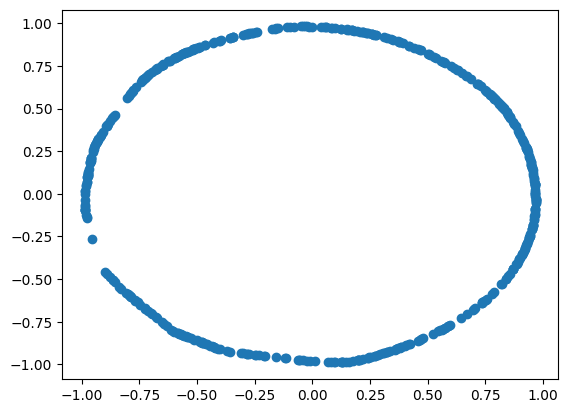

In [105]:
sample = model.sample(num_samples=500).detach()
plt.scatter(sample[:, 0], sample[:, 1])
plt.show()

In [106]:
student = torch.load('peal_runs/artificial_symbolic_100_classifier/model.cpl')
teacher = torch.load('peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')


In [107]:
target_classes = student(sample[:,:2]).argmin(dim=-1)

In [108]:
config = {
    'lasso_weight': 0.01,
    'reconstruction_weight': 0.01
}

In [167]:
def DIVE(clean_batch, target_classes, model, classifier):
    
    classifier.eval()
    
    lasso_weight = config['lasso_weight']
    reconstruction_weight = config['reconstruction_weight']
    
    batch_size ,_ = clean_batch.size()
    latent_dim = 1
        
    mean, logvar = model.encode(clean_batch)
    z = model.reparameterize(mean, logvar).detach()
    
    epsilon = torch.randn_like(z, requires_grad=True)
    epsilon.data *= 0.01
    optimizer = torch.optim.Adam([epsilon], lr=0.1, weight_decay=0)

    for it in range(1):
        optimizer.zero_grad()
        
        z_perturbed =  z + epsilon # no grads required for latents

        decoded = model.decode(z_perturbed)
    
        classifier_criterion = lambda x: F.cross_entropy(classifier(x), target_classes)
        loss_attack = classifier_criterion(decoded)


        recon_regularizer = reconstruction_weight  * torch.abs((clean_batch - decoded).mean(dim=-1)).sum()
        lasso_regularizer = lasso_weight * (torch.abs(z_perturbed - z)).sum()
        regularizer = recon_regularizer + lasso_regularizer

        loss = loss_attack + regularizer

        loss.backward()

        optimizer.step()
        
    return clean_batch, model.decode(z + epsilon).detach()
    
    

In [169]:
clean_batch, counterfactuals = DIVE(clean_batch=sample[0:1], target_classes=target_classes[0:1], model=model, classifier=student)

In [155]:
_, counterfactuals = DIVE(clean_batch=counterfactuals, target_classes=target_classes[2:3], model=model, classifier=student)

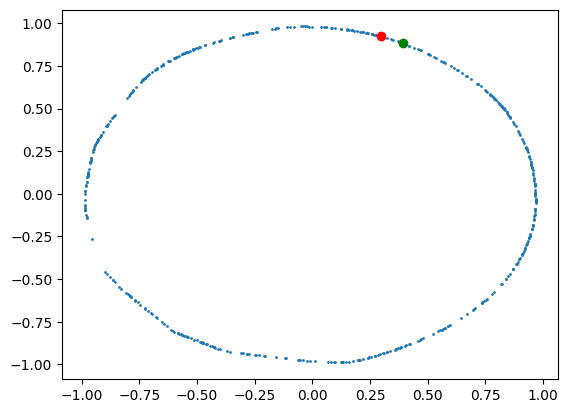

In [189]:
plt.scatter(sample[:, 0], sample[:, 1], s=1)
plt.scatter(counterfactuals[:,0], counterfactuals[:,1], color='red')
plt.scatter(clean_batch[:, 0], clean_batch[:, 1], color='green')
plt.show()

In [175]:
target_

0

In [188]:
student(counterfactuals).softmax(dim=-1)[0][target_classes[0].item()].item() >0.99

False

In [132]:
student(sample[0:1,:])

tensor([[9.7690, 0.0000]], grad_fn=<ReluBackward0>)

In [3]:
from peal.data.datasets import SymbolicDataset
from torchvision import transforms
from torchvision.transforms import ToTensor
from peal.data.transformations import (
    IdentityNormalization,
)

class CircleDataset(SymbolicDataset):
    def __init__(
        self,
        data_dir,
        mode,
        config,
        transform,
        task_config=None,
        **kwargs,
    ):
        
        super().__init__(data_dir, mode, config, transform, task_config, **kwargs)
        
        self.config = config
        self.true_data = torch.zeros([config.num_samples, config.input_size[0]])
        for i in range(config.num_samples):
            self.true_data[i,:] = self.data[str(i)][:2]

    @staticmethod
    def circle_fid(samples, radius=1):
        return (((samples.pow(2)).sum(dim=1) - radius).pow(2)).mean()
    
    @staticmethod
    def angle_cdf(samples):
        scores = abs(samples[:,1] / samples[:,0])

        first_quad_mask = (samples[:,0]>0) & (samples[:,1]>0)
        second_quad_mask = (samples[:,0]<0) & (samples[:,1]>0)
        third_quad_mask = (samples[:,0]<0) & (samples[:,1]<0)
        fourth_quad_mask = (samples[:,0]>0) & (samples[:,1]<0)
        theta_1 = torch.atan(scores)*first_quad_mask
        theta_1 = theta_1[theta_1 != 0]
        theta_2 = (torch.pi - torch.atan(scores))*second_quad_mask
        theta_2 = theta_2[theta_2 != 0]
        theta_3 = (torch.pi + torch.atan(scores))*third_quad_mask
        theta_3 = theta_3[theta_3 != 0]
        theta_4 = (2*torch.pi - torch.atan(scores))*fourth_quad_mask
        theta_4 = theta_4[theta_4 != 0]
        thetas, indices = torch.cat([theta_1, theta_2, theta_3, theta_4]).sort(dim=-1)
        
        return thetas
    
    #@staticmethod
    def circle_ks(self, samples, true_data):
        true_thetas = CircleDataset.angle_cdf(true_data)
        sample_thetas = CircleDataset.angle_cdf(samples)

        ecdf = torch.arange(self.config.num_samples)/self.config.num_samples
        true_cdf = (sample_thetas[:,None] >= true_thetas[None,:]).sum(-1)/len(true_data)
        return torch.max(torch.abs((true_cdf-ecdf)))
    
    
    def track_generator_performance(self, generator, batch_size=1):
        
        samples = generator.sample_x(batch_size).detach()
        
        ks = self.circle_ks(samples, self.true_data)
        fid = CircleDataset.circle_fid(samples)
        
        harmonic_mean = 1/(1/fid + 1/ks)
        
        
        
        return {
            'KS': ks,
            'FID': fid,
            'harmonic_mean_fid_ks': harmonic_mean
        
        }
    
    
def get_datasets(config, base_dir, task_config=None, return_dict=False):
    
    config = load_yaml_config(config)
    
    dataset = CircleDataset
    
    transform_list_train = []
    transform_list_test = []
    
    transform_list_train.append(ToTensor())
    transform_list_test.append(ToTensor())

    transform_train = transforms.Compose(transform_list_train)
    transform_test = transforms.Compose(transform_list_test)
    normalization = IdentityNormalization()
    
    transform_train = transforms.Compose([transform_train, normalization])
    transform_test = transforms.Compose([transform_test, normalization])

    train_data = dataset(
        base_dir, "train", config, transform_train, return_dict=return_dict
    )
    val_data = dataset(
        base_dir, "val", config, transform_train, return_dict=return_dict
    )
    test_data = dataset(
        base_dir, "test", config, transform_test, return_dict=return_dict
    )
    
    train_data.normalization = normalization
    val_data.normalization = normalization
    test_data.normalization = normalization

    train_data.task_config = task_config
    val_data.task_config = task_config
    test_data.task_config = task_config

    return train_data, val_data, test_data

In [4]:
# create the datasets
#from peal.data.dataset_factory import get_datasets
from peal.data.dataset_generators import CircleDatasetGenerator
from peal.global_utils import load_yaml_config
import copy

unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/symbolic_circle.yaml')
unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')
dg = CircleDatasetGenerator(
    dataset_name='circle',
    num_samples=unpoisened_dataset_config.num_samples,
    radius=unpoisened_dataset_config.radius,
    noise_scale=unpoisened_dataset_config.noise_scale,
    seed=unpoisened_dataset_config.seed,
)

#dg.generate_dataset()

unpoisened_dataset_config = load_yaml_config('<PEAL_BASE>/configs/data/circle_dataset_diffusion_unpoisened.yaml')
student_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml')
if len(student_config.task['x_selection']):
    unpoisened_dataset_config.input_size = [len(student_config.task['x_selection'])]
    
unpoisened_dataset_train, unpoisened_dataset_val, unpoisened_dataset_test = get_datasets(
    config=unpoisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config.task,
)

# create a copy of the dataset config that will be poisened in the next steps
poisened_dataset_config = copy.deepcopy(unpoisened_dataset_config)
poisened_dataset_config.num_samples = int(unpoisened_dataset_config.num_samples / 2)

confounder_probability = request('confounder_probability', '100')
poisened_dataset_config.confounder_probability = float(confounder_probability) / 100

# create dataset based changed data config
poisened_dataset_train, poisened_dataset_val, poisened_dataset_test = get_datasets(
    config=poisened_dataset_config,
    base_dir=dg.label_dir,
    task_config=student_config.task,
)

Do you want to change value of confounder_probability==100? [y/n]n


In [68]:
generator_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_vae.yaml')
generator_config.data = unpoisened_dataset_train.config
generator_config.training['max_epochs'] = 100


In [69]:
generator_config

namespace(name='symbolic_vae',
          training={'train_batch_size': 10,
                    'val_batch_size': 10,
                    'test_batch_size': 10,
                    'base_batch_size': 32,
                    'gigabyte_vram': 40,
                    'assumed_input_size': [3, 64, 64],
                    'max_epochs': 100,
                    'learning_rate': 1e-05,
                    'optimizer': 'adam',
                    'global_train_step': 0,
                    'global_validation_step': 0,
                    'epoch': -1,
                    'steps_per_epoch': 1000,
                    'verbosity': 1},
          architecture={'encoder': {'layers': [['fc', 512], ['fc', 512]],
                         'activation': 'ReLU'},
                        'decoder': {'layers': [['fc', 512]],
                         'activation': 'ReLU'}},
          task={'criterions': {'likelihood': 1.0, 'reconstruction': 1.0},
                'selection': {'x1': None, 'x2': None}},
       

In [70]:
from peal.configs.architectures import architecture_template
from peal.configs.generators import generator_template

In [86]:
encoder_config = architecture_template.ArchitectureConfig(layers=[
    ['fc', 512],
    ['fc', 512]
  ], activation='ReLU', output_channels=3)

decoder_config = architecture_template.ArchitectureConfig(layers=[
    ['fc', 512],
    ['fc', 512]
  ], activation='ReLU', output_channels=3)

In [87]:
architecture_config = generator_template.VAEConfig(encoder=encoder_config, decoder=decoder_config)

In [88]:
generator_config.architecture = architecture_config

In [89]:
generator_config.encoder = encoder_config
generator_config.decoder = decoder_config

In [94]:
is_train_generator = request('is_train_generator', True)
if is_train_generator:
    # if you want the generator getting trained from scratch
    from peal.generators.variational_autoencoders import VAE
    from peal.training.trainers import ModelTrainer
    from peal.data.dataset_wrappers import VAEDatasetWrapper
    #generator_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_vae.yaml')
    generator_config.data = unpoisened_dataset_train.config
    #generator_config.training['max_epochs'] = 50
    generator = VAE(generator_config, 2).to(device)

    dataset_train = VAEDatasetWrapper(unpoisened_dataset_train)
    dataset_val = VAEDatasetWrapper(unpoisened_dataset_val)

    generator_trainer = ModelTrainer(
        config=generator_config,
        model=generator,
        datasource=(dataset_train, dataset_val),
        model_name=request(
            'generator_model_name',
            'artificial_symbolic_' + confounder_probability + '_generator'
        ),
        gigabyte_vram=gigabyte_vram
    )
    generator_trainer.fit()

else:
    # if you want to use loaded generator
    generator_path = request(
        'generator_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_generator/model.cpl'
    )
    generator = torch.load(generator_path).to(device)

Do you want to change value of is_train_generator==True? [y/n]n
Do you want to change value of generator_model_name==artificial_symbolic_100_generator? [y/n]n


AttributeError: 'dict' object has no attribute 'train_batch_size'

In [ ]:
FC1 = nn.Sequential()

In [93]:
nn

NameError: name 'nn' is not defined

In [54]:
generator_config

namespace(name='symbolic_vae',
          training={'train_batch_size': 10,
                    'val_batch_size': 10,
                    'test_batch_size': 10,
                    'base_batch_size': 32,
                    'gigabyte_vram': 40,
                    'assumed_input_size': [3, 64, 64],
                    'max_epochs': 50,
                    'learning_rate': 1e-05,
                    'optimizer': 'adam',
                    'global_train_step': 0,
                    'global_validation_step': 0,
                    'epoch': -1,
                    'steps_per_epoch': 1000,
                    'verbosity': 1},
          architecture={'encoder': {'layers': [['fc', 512], ['fc', 512]],
                         'activation': 'ReLU'},
                        'decoder': {'layers': [['fc', 512]],
                         'activation': 'ReLU'}},
          task={'criterions': {'likelihood': 1.0, 'reconstruction': 1.0},
                'selection': {'x1': None, 'x2': None}},
        

In [50]:
if isinstance(architecture_config, generator_template.VAEConfig):
    

True

In [ ]:
is_train_student = request('is_train_student', True)
if is_train_student:
    # if you want to train your own initial student model
    from peal.architectures.downstream_models import SequentialModel
    from peal.configs.models.model_template import ModelConfig
    from peal.training.trainers import ModelTrainer
    student_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml', ModelConfig)
    student_config.data = poisened_dataset_train.config
    student_config.training.max_epochs = 5

    input_channels=len(student_config.task.x_selection) if not student_config.task.x_selection is None else student_config.data.input_size[0]
    output_channels=student_config.task.output_channels if not student_config.task.output_channels is None else student_config.data.output_size[0]
    # create and traing student model
    student = SequentialModel(student_config.architecture, input_channels, output_channels).to(device)
    student_trainer = ModelTrainer(
        config=student_config,
        model=student,
        datasource=(poisened_dataset_train, poisened_dataset_val),
        model_name=request(
            'student_model_name',
            'artificial_symbolic_' + confounder_probability + '_classifier'
        ),
        gigabyte_vram=gigabyte_vram
    )
    student_trainer.fit()
else:
    # if you want to load your initial student model
    student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/model.cpl'
    )
    student = torch.load(student_path).to(device)


In [ ]:
import numpy as np
dataset = unpoisened_dataset_train
input_ = np.zeros((len(dataset), len(dataset.task_config['x_selection'])))
target_ = np.zeros((len(dataset), len(dataset.task_config['y_selection'])))
for i in range(len(dataset)):
        x = dataset[i]
        input_[i] = x[0].numpy()
        target_[i] = x[1].numpy()

In [ ]:
data = torch.tensor(input_, dtype=torch.float32)

In [ ]:
encoded = generator.encode(data)

In [ ]:
encoded[0].shape

In [ ]:
decoded = generator.decode(encoded[0]).detach()

In [ ]:
plt.scatter(decoded[:,0], decoded[:,1])

In [ ]:
teacher_type = request('teacher_type', 'train')
if teacher_type == 'train':
    # if you want to train and use new model for knowledge distillation
    from peal.architectures.downstream_models import SequentialModel
    from peal.configs.models.model_template import ModelConfig
    from peal.training.trainers import ModelTrainer
    teacher_config = load_yaml_config('<PEAL_BASE>/configs/models/symbolic_circle_classifier.yaml', ModelConfig)
    teacher_config.data = unpoisened_dataset_train.config
    teacher_config.training.max_epochs = 5

    input_channels=len(teacher_config.task.x_selection) if not teacher_config.task.x_selection is None else teacher_config.data.input_size[0]
    output_channels=teacher_config.task.output_channels if not teacher_config.task.output_channels is None else teacher_config.data.output_size[0]
    # create and traing student model
    teacher = SequentialModel(teacher_config.architecture, input_channels, output_channels).to(device)
    teacher_trainer = ModelTrainer(
        config=teacher_config,
        model=teacher,
        datasource=(unpoisened_dataset_train, unpoisened_dataset_val),
        model_name=request('teacher_model_name', 'artificial_symbolic_unpoisened_classifier'),
        gigabyte_vram=gigabyte_vram
    )
    teacher_trainer.fit()
    teacher_type = 'oracle'

elif teacher_type == 'load':
    # if you want to use existing model for knowledge distillation
    teacher_path = request(
        'teacher_path', 'peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')
    teacher = torch.load(teacher_path).to(device)
    teacher_type = 'oracle'

else:
    teacher = teacher_type

In [ ]:
teacher_type = request('teacher_type', 'load') # changes this to load
if teacher_type == 'train':
    # if you want to train and use new model for knowledge distillation
    from peal.architectures.downstream_models import Symbolic2VectorModel
    from peal.training.trainers import ModelTrainer
    teacher_config = load_yaml_config('$PEAL/configs/models/symbolic_circle_classifier.yaml')
    teacher_config['data'] = unpoisened_dataset_train.config
    teacher_config['training']['max_epochs'] = 5

    # create and train teacher model
    teacher = Symbolic2VectorModel(teacher_config).to(device)
    teacher_trainer = ModelTrainer(
        config=teacher_config,
        model=teacher,
        datasource=(unpoisened_dataset_train, unpoisened_dataset_val),
        model_name=request('teacher_model_name', 'artificial_symbolic_unpoisened_classifier'),
        gigabyte_vram=gigabyte_vram
    )
    teacher_trainer.fit()
    teacher_type = 'oracle'

elif teacher_type == 'load':
    # if you want to use existing model for knowledge distillation
    teacher_path = request(
        'teacher_path', 'peal_runs/artificial_symbolic_unpoisened_classifier/model.cpl')
    teacher = torch.load(teacher_path).to(device)
    teacher_type = 'oracle'

else:
    teacher = teacher_type

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
def plot_decision_boundary(model, dataset):
    assert isinstance(dataset, peal.data.datasets.SymbolicDataset)
    
    #data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
    input_ = np.zeros((len(dataset), len(dataset.task_config['x_selection'])))
    target_ = np.zeros((len(dataset), len(dataset.task_config['y_selection'])))
    for i in range(len(dataset)):
        x = dataset[i]
        input_[i] = x[0].numpy()
        target_[i] = x[1].numpy()
    
    #for idx, key in enumerate(dataset.data):
    #    data[idx] = dataset.data[key]
    #data = [dataset[i] for i in range(len(dataset))]
    
    #input_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config['x_selection']]
    #target_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config['y_selection']]
    #confounder_idx =  [idx for idx, element in enumerate(dataset.attributes) if element in list(set(dataset.config['confounding_factors']) - set(dataset.task_config['y_selection']))]

    
    #if isinstance(data, torch.Tensor):
    #    data = data.numpy()
    #if isinstance(data, pd.DataFrame):
    #    data = data.to_numpy()
    #xmin, xmax = data[:,0].min()-1, data[:,0].max()+1
    #ymin, ymax = data[:,1].min()-1, data[:,1].max()+1
    
    steps = 1000
    #input_grid = []
    #x1_span = np.linspace(-1.5, 1.5, steps)
    #x2_span = np.linspace(-1.5, 1.5, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    xx1, xx2 = np.meshgrid(*[np.linspace(float(input_.min()-0.5),float(input_.max()+0.5), 1000) for idx in range(len(dataset.task_config['x_selection']))])
    grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    #xx1, xx2 = np.meshgrid(*[np.linspace(int(data[:, 0].min())-0.5,int(data[:, 0].min())+0.5) for idx in input_idx])
    #grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    model.eval()
    z = model(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
    fig, ax = plt.subplots()
    #idx = features_idx+[class_label_idx]
    ax.scatter(input_[:,0], input_[:,1], c=target_)
    ax.contour(xx1, xx2, z, levels=[0],linestyles='dashed')
    ax.grid()

In [ ]:
samples = generator.sample_x(batch_size=10000).detach()

In [ ]:
plt.scatter(samples[:,0], samples[:,1])

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
def plot_decision_boundary(model, dataset):
    assert isinstance(dataset, peal.data.datasets.SymbolicDataset)
    
    data = torch.zeros([len(dataset.data),len(dataset.attributes)], dtype=torch.float16)
    for idx, key in enumerate(dataset.data):
        data[idx] = dataset.data[key]
    
    input_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config.x_selection]
    target_idx = [idx for idx, element in enumerate(dataset.attributes) if element in dataset.task_config.y_selection]
    confounder_idx =  [idx for idx, element in enumerate(dataset.attributes) if element in list(set(dataset.config.confounding_factors) - set(dataset.task_config.y_selection))]
    #if isinstance(data, torch.Tensor):
    #    data = data.numpy()
    #if isinstance(data, pd.DataFrame):
    #    data = data.to_numpy()
    #xmin, xmax = data[:,0].min()-1, data[:,0].max()+1
    #ymin, ymax = data[:,1].min()-1, data[:,1].max()+1
    
    steps = 1000
    #input_grid = []
    #x1_span = np.linspace(-1.5, 1.5, steps)
    #x2_span = np.linspace(-1.5, 1.5, steps)
    #xx1, xx2 = np.meshgrid(x1_span, x2_span)
    xx1, xx2 = np.meshgrid(*[np.linspace(float(data[:, [input_idx]].min()-0.5),float(data[:, [input_idx]].max()+0.5), 1000) for idx in input_idx])
    grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    #xx1, xx2 = np.meshgrid(*[np.linspace(int(data[:, 0].min())-0.5,int(data[:, 0].min())+0.5) for idx in input_idx])
    #grid = torch.from_numpy(np.array([xx1.flatten(), xx2.flatten()]).T).to(torch.float32)
    model.eval()
    z = model(grid).to(torch.float32).detach().numpy().argmax(axis=1).reshape(xx1.shape)
    fig, ax = plt.subplots()
    #idx = features_idx+[class_label_idx]
    ax.scatter(data[:,0], data[:,1], c=data[:,target_idx])
    ax.contour(xx1, xx2, z, levels=[0],linestyles='dashed')
    ax.grid()

In [ ]:
import peal
plot_decision_boundary(teacher, poisened_dataset_train)

In [ ]:
import peal
plot_decision_boundary(student, poisened_dataset_train)
#for i in range(10):
#    plt.scatter(*generator.sample_x().detach())

In [ ]:
# use counterfactual knowledge distillation to improve model
from peal.adaptors.counterfactual_knowledge_distillation import CounterfactualKnowledgeDistillation
cfkd = CounterfactualKnowledgeDistillation(
    student=student,
    datasource=(
        poisened_dataset_train,
        poisened_dataset_val,
        unpoisened_dataset_test,
    ),
    output_size=2,
    generator=generator,
    teacher=teacher,
    base_dir=request(
        'cfkd_base_dir',
        'peal_runs/artificial_symbolic_' + confounder_probability +
        '_classifier/cfkd_' + teacher_type
    ),
    gigabyte_vram=gigabyte_vram,
    overwrite=False,
)
cfkd.adaptor_config['explainer']['learning_rate'] = 1.0
cfkd.adaptor_config['explainer']['gradient_steps'] = 51
cfkd.run()

In [ ]:
# NOTES:
# 1. When student is ran without generating data, confounder probability is not defined and, therefore, the logic of loading preexisting model fails (need to load data before, should be allowed to skip)
# 2. unclear about the folder structure for cfdk
# 3. 

In [ ]:
plot_decision_boundary(student, unpoisened_dataset_train)

In [ ]:
run = '1'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student1 = torch.load(student_path).to(device)
plot_decision_boundary(student1, unpoisened_dataset_train)

In [ ]:
run = '2'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student2 = torch.load(student_path).to(device)
plot_decision_boundary(student2, unpoisened_dataset_train)

In [ ]:
run = '3'
student_path = request(
        'student_path',
        'peal_runs/artificial_symbolic_' + confounder_probability + '_classifier/'+ 'cfkd_oracle/' + run + '/finetuned_model/model.cpl'
)
student3 = torch.load(student_path).to(device)
plot_decision_boundary(student3, unpoisened_dataset_train)